In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import pandas as pd

# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from olympus.objects import (
        ParameterContinuous,
        ParameterDiscrete,
        ParameterCategorical,
)
from olympus.planners import Planner
from olympus.campaigns import Campaign, ParameterSpace
from olympus.surfaces import Surface

from olympus.utils.misc import get_hypervolume

from atlas.optimizers.gp.planner import BoTorchPlanner

In [3]:
def surface(x, s):
    if s == '0':
        return  np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2]
    elif s == '1':
        return 3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2
    elif s == '2':
        return 5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3
    
    
def moo_surface(x, s):
    if s == '0':
        return  np.array([
                    np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2],
                    np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2],
                ])
    elif s == '1':
        return  np.array([
                    3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2,
                    3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2,
                ])
    elif s == '2':
        return np.array([
                    5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3,
                    5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3,
                ])
    

In [4]:
# evaluate the surface for the best points 
p1_domain = np.linspace(0, 1, 100)
p2_domain = np.linspace(0, 1, 100)
p3_domain = np.linspace(0, 1, 100)

params = []
measurements = []

for p1 in p1_domain:
    for p2 in p2_domain:
        for p3 in p3_domain:
            vals = []
            x = [p1, p2, p3]
            for s in ['0', '1', '2']:
                vals.append(surface(x, s))
            measurements.append(np.mean(vals))
            params.append(x)

            

In [5]:
best_ix = np.argmin(measurements)
best_val = measurements[best_ix]
best_params = params[best_ix]

print('best values')
best_ix, best_val, best_params

best values


(9904, 3.830719239025027, [0.0, 1.0, 0.04040404040404041])

In [6]:
worst_ix = np.argmax(measurements)
worst_val = measurements[worst_ix]
worst_params = params[worst_ix]

print('worst values')
worst_ix, worst_val, worst_params

worst values


(670099, 7.107703695510463, [0.6767676767676768, 0.0, 1.0])

In [7]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        #descriptors=[None for i in range(3)],   # OHE
        descriptors=[[float(i),float(i)] for i in range(3)],  # descriptors
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)



In [8]:
NUM_RANDOM_RUNS = 100
BUDGET = 30
NUM_RUNS = 20

In [9]:
all_campaigns = []
all_true_measurements = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        use_descriptors=True,
        acquisition_type='general',
        acquisition_optimizer_kind='genetic',
        general_parameters=[0],
        
    )
    planner.set_param_space(param_space)

    true_measurements = []

    iter_=0
    while len(campaign.observations.get_values())<BUDGET:

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurement = np.mean(all_measurements)
            true_measurements.append(true_measurement)


            print(f'RUN # : {run+1}\t ITER : {iter_}\tSAMPLES : {samples}\t SINGLE MEASUREMENT : {measurement}\t TRUE MEASUREMENT : {true_measurement}')
            campaign.add_observation(sample, measurement)
        iter_ +=1
    
    all_true_measurements.append(true_measurements)
        
    all_campaigns.append(campaign)

[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 1	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24263985259673915, param_2 = 0.09215101477259202, param_3 = 0.30309177475346094)]	 SINGLE MEASUREMENT : 12.159041994864124	 TRUE MEASUREMENT : 5.966947331039101


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 1	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2503139075951901, param_2 = 0.3872207949996911, param_3 = 0.7278579523016149)]	 SINGLE MEASUREMENT : 11.286467597446528	 TRUE MEASUREMENT : 6.064422326823532


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 1	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5290840308375445, param_2 = 0.17571058225079006, param_3 = 0.738323449749587)]	 SINGLE MEASUREMENT : 12.246141345465421	 TRUE MEASUREMENT : 6.482161397155899


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 1	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4721132273599844, param_2 = 0.032438366855872536, param_3 = 0.7999225521874397)]	 SINGLE MEASUREMENT : 2.014178906450602	 TRUE MEASUREMENT : 6.623128892984532


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 1	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6240679313617133, param_2 = 0.0050937321807152935, param_3 = 0.43629078561260026)]	 SINGLE MEASUREMENT : 12.540556390737397	 TRUE MEASUREMENT : 6.242521801319167


[INFO] Regression surrogate GP trained in 0.039 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999880528846, param_2 = 1.0000000358755885, param_3 = -3.1665742250552853e-10)]	 SINGLE MEASUREMENT : 2.706914602363252	 TRUE MEASUREMENT : 4.187276282240519


[WARNING] Proposed parameter 1.0000000358755885 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -3.1665742250552853e-10 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999880528846, param_2 = 0.9999999765745516, param_3 = -5.115352788536941e-18)]	 SINGLE MEASUREMENT : 7.325098885312539	 TRUE MEASUREMENT : 4.18727648216304


[WARNING] Proposed parameter -5.115352788536941e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.039 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999880528846, param_2 = 0.9999999765745516, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 3.52981591608559	 TRUE MEASUREMENT : 5.153943093228537


[INFO] Regression surrogate GP trained in 0.04 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999880528846, param_2 = 0.9999999765745516, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 4.706914476176044	 TRUE MEASUREMENT : 5.153943093228537


[INFO] Regression surrogate GP trained in 0.036 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999880528846, param_2 = 0.9999999765745516, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 7.225098887423976	 TRUE MEASUREMENT : 5.153943093228537


[INFO] Regression surrogate GP trained in 0.041 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = -6.788672485269487e-09, param_2 = 0.9999999765745516, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 0.005403002889782292	 TRUE MEASUREMENT : 3.831477975438869


[WARNING] Proposed parameter -6.788672485269487e-09 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.048 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 2.147811997950134e-16, param_2 = 0.9999999765745516, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 5.005403023255799	 TRUE MEASUREMENT : 3.8314779844904323


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.038 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.147811997950134e-16, param_2 = 0.9999999765745516, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 6.483627906959697	 TRUE MEASUREMENT : 3.8314779844904323


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 2.147811997950134e-16, param_2 = 0.9999999765745516, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 7.00540289656959	 TRUE MEASUREMENT : 4.798144595555929


[INFO] Regression surrogate GP trained in 0.083 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 2.147811997950134e-16, param_2 = 0.9999999765745516, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 1.0054029810270635	 TRUE MEASUREMENT : 4.798144595555929


[INFO] Regression surrogate GP trained in 0.103 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.147811997950134e-16, param_2 = 0.9999999765745516, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 6.383627909071134	 TRUE MEASUREMENT : 4.798144595555929


[INFO] Regression surrogate GP trained in 0.095 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999880528846, param_2 = 0.39170373737259834, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 2.5336555348243577	 TRUE MEASUREMENT : 5.725666803848657


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999880528846, param_2 = 0.4073161176772123, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 2.710693452995951	 TRUE MEASUREMENT : 5.701335769064788


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.096 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999880528846, param_2 = 0.36470469088523116, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 12.052220548097132	 TRUE MEASUREMENT : 5.765609881792784


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.092 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.011514467937906336, param_2 = 1.2995694537859537e-10, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 7.009668419546175	 TRUE MEASUREMENT : 6.655241744479665


[INFO] Regression surrogate GP trained in 0.095 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4658066462311812, param_2 = 0.9999999762709416, param_3 = 0.4889364239378559)]	 SINGLE MEASUREMENT : 1.591892809737214	 TRUE MEASUREMENT : 4.394080223657405


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4661813050238841, param_2 = 0.9999999762709416, param_3 = 0.49460679416773357)]	 SINGLE MEASUREMENT : 4.713856250606957	 TRUE MEASUREMENT : 4.398658614067791


[INFO] Regression surrogate GP trained in 0.091 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.147811997950134e-16, param_2 = 6.630309911244288e-18, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 11.900000002111437	 TRUE MEASUREMENT : 6.639999944398831


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46995567869504595, param_2 = 0.9999999762709416, param_3 = 0.5030176852172272)]	 SINGLE MEASUREMENT : 6.886172910967994	 TRUE MEASUREMENT : 4.4070139195771665


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999880528846, param_2 = 0.5589079593669545, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 4.709989799746362	 TRUE MEASUREMENT : 6.386122737069422


[INFO] Regression surrogate GP trained in 0.122 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9967462927174833, param_2 = 0.520396684907813, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 3.5278018224466385	 TRUE MEASUREMENT : 6.467612417129843


[INFO] Regression surrogate GP trained in 0.13 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999880528846, param_2 = 0.5428908624184511, param_3 = 0.9999999788856313)]	 SINGLE MEASUREMENT : 11.016096617038585	 TRUE MEASUREMENT : 6.419715112949858


[INFO] Regression surrogate GP trained in 0.156 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 2.147811997950134e-16, param_2 = 0.6112618586601889, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 0.008189244877142447	 TRUE MEASUREMENT : 4.94782411410815


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.141 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 2.147811997950134e-16, param_2 = 0.6066483796108009, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 5.008215634448143	 TRUE MEASUREMENT : 4.9583975355560375


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 1	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.147811997950134e-16, param_2 = 0.6028264390010837, param_3 = -6.585749665796662e-18)]	 SINGLE MEASUREMENT : 9.884836713903617	 TRUE MEASUREMENT : 4.967103813920041


[WARNING] Proposed parameter -6.585749665796662e-18 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 2	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1619349806239503, param_2 = 0.7748868012321212, param_3 = 0.6667903316158502)]	 SINGLE MEASUREMENT : 8.668551977382734	 TRUE MEASUREMENT : 5.046214687573408


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 2	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19500314636315252, param_2 = 0.2372112661794804, param_3 = 0.34462695239781593)]	 SINGLE MEASUREMENT : 11.82327196185528	 TRUE MEASUREMENT : 5.8432949768089495


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 2	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44270284689242756, param_2 = 0.60515633986424, param_3 = 0.9425179361426892)]	 SINGLE MEASUREMENT : 6.200762564900248	 TRUE MEASUREMENT : 6.1951887391982545


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 2	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5419679795977272, param_2 = 0.8342712342550833, param_3 = 0.4537514707807433)]	 SINGLE MEASUREMENT : 4.47703937822314	 TRUE MEASUREMENT : 4.922725476308301


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 2	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9494139487828576, param_2 = 0.625695238831459, param_3 = 0.714586044253817)]	 SINGLE MEASUREMENT : 10.46828955903035	 TRUE MEASUREMENT : 5.691646168302799


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999851234382, param_2 = 1.0000000221094123, param_3 = -1.3628942419074974e-09)]	 SINGLE MEASUREMENT : 7.325098424070873	 TRUE MEASUREMENT : 4.187276330685996


[WARNING] Proposed parameter 1.0000000221094123 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.3628942419074974e-09 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4988743212133021, param_2 = 1.0000000221094123, param_3 = -2.7732798370281653e-17)]	 SINGLE MEASUREMENT : 1.4407150998326788	 TRUE MEASUREMENT : 4.266263784484664


[WARNING] Proposed parameter 1.0000000221094123 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.7732798370281653e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.398171945503695, param_2 = 1.0000000221094123, param_3 = -2.7732798370281653e-17)]	 SINGLE MEASUREMENT : 6.871361390043844	 TRUE MEASUREMENT : 4.2180753090845675


[WARNING] Proposed parameter 1.0000000221094123 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.7732798370281653e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999851234382, param_2 = -2.234881280038792e-09, param_3 = -2.7732798370281653e-17)]	 SINGLE MEASUREMENT : 2.7115115919316732	 TRUE MEASUREMENT : 6.029131833003966


[WARNING] Proposed parameter -2.234881280038792e-09 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.7732798370281653e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999851234382, param_2 = -5.661569873808969e-17, param_3 = -2.7732798370281653e-17)]	 SINGLE MEASUREMENT : 12.841470976770056	 TRUE MEASUREMENT : 6.029131833003966


[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.7732798370281653e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.9119679173229542e-09, param_2 = -5.661569873808969e-17, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 1.0099998896302391	 TRUE MEASUREMENT : 6.6399998596828


[WARNING] Proposed parameter -1.9119679173229542e-09 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.036 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = -2.4787887324263228e-17, param_2 = -5.661569873808969e-17, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 7.009999686098437	 TRUE MEASUREMENT : 6.639999862232091


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.048 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = -2.4787887324263228e-17, param_2 = -5.661569873808969e-17, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 11.900000005231693	 TRUE MEASUREMENT : 6.639999862232091


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = -2.4787887324263228e-17, param_2 = 1.0000000221094125, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 1.00540291823878	 TRUE MEASUREMENT : 4.798144359868691


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.048 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999851234382, param_2 = 1.0000000221094125, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 3.5298158485489473	 TRUE MEASUREMENT : 5.153942859539323


[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.041 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999851234382, param_2 = 1.0000000221094125, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 4.706914300902747	 TRUE MEASUREMENT : 5.153942859539323


[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.055 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999851234382, param_2 = 1.0000000221094125, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 7.225098429166274	 TRUE MEASUREMENT : 5.153942859539323


[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.084 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = -2.4787887324263228e-17, param_2 = 1.0000000221094125, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 7.005402708971074	 TRUE MEASUREMENT : 4.798144359868691


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = -2.4787887324263228e-17, param_2 = 1.0000000221094125, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 6.383627452396218	 TRUE MEASUREMENT : 4.798144359868691


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = -2.4787887324263228e-17, param_2 = 1.0000000221094125, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 5.005403022872637	 TRUE MEASUREMENT : 3.831477830969933


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.085 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = -2.4787887324263228e-17, param_2 = 1.0000000221094125, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 0.00540302287263703	 TRUE MEASUREMENT : 3.831477830969933


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.095 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999851234382, param_2 = -5.661569873808969e-17, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 3.53441282567631	 TRUE MEASUREMENT : 6.995798361902724


[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.111 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = -2.4787887324263228e-17, param_2 = 1.0000000221094125, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 6.483627447164525	 TRUE MEASUREMENT : 3.831477830969933


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000221094125 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.108 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999851234382, param_2 = 0.018857395021324858, param_3 = 0.9979476141102693)]	 SINGLE MEASUREMENT : 4.699220755075804	 TRUE MEASUREMENT : 6.989691339480934


[INFO] Regression surrogate GP trained in 0.108 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999851234382, param_2 = -5.661569873808969e-17, param_3 = 0.9999999476830701)]	 SINGLE MEASUREMENT : 12.741470982001749	 TRUE MEASUREMENT : 6.995798361902724


[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = -2.4787887324263228e-17, param_2 = 0.545528449924219, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 0.008548532133915022	 TRUE MEASUREMENT : 5.091778541655315


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.147 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = -2.4787887324263228e-17, param_2 = 0.5614936950560268, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 5.00846460735945	 TRUE MEASUREMENT : 5.058152682019521


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.179 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0022074693147279834, param_2 = -5.661569873808969e-17, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 0.01662240256577372	 TRUE MEASUREMENT : 5.676272562596902


[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.114 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


RUN # : 2	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = -2.4787887324263228e-17, param_2 = -5.661569873808969e-17, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.2 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 2	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = -2.4787887324263228e-17, param_2 = -5.661569873808969e-17, param_3 = 4.157733496503755e-17)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -2.4787887324263228e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.661569873808969e-17 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 3	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27495742118861377, param_2 = 0.940955105731132, param_3 = 0.8714987307115134)]	 SINGLE MEASUREMENT : 6.141898026553324	 TRUE MEASUREMENT : 4.991456540005355


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 3	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14718631425768391, param_2 = 0.46385227179022726, param_3 = 0.026469931027141014)]	 SINGLE MEASUREMENT : 4.954918625948521	 TRUE MEASUREMENT : 5.426855064020818


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 3	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8659497806867137, param_2 = 0.10156565912430882, param_3 = 0.8001983087913002)]	 SINGLE MEASUREMENT : 4.2742949091950795	 TRUE MEASUREMENT : 6.609848170400601


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 3	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.650234246718671, param_2 = 0.7237366252809956, param_3 = 0.49213181547535756)]	 SINGLE MEASUREMENT : 4.225585909010688	 TRUE MEASUREMENT : 5.279863549800477


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 3	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7202129792068214, param_2 = 0.7121318988863501, param_3 = 0.838399438896077)]	 SINGLE MEASUREMENT : 9.659350951857217	 TRUE MEASUREMENT : 5.764336487100427


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 5.314428896951995e-10, param_2 = -5.733045843614448e-10, param_3 = 9.199392705938614e-10)]	 SINGLE MEASUREMENT : 12.00000000043945	 TRUE MEASUREMENT : 5.673333334011258


[WARNING] Proposed parameter -5.733045843614448e-10 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999918917992, param_2 = 1.000000021601806, param_3 = -3.00928869329608e-17)]	 SINGLE MEASUREMENT : 2.5298159641579594	 TRUE MEASUREMENT : 4.187276327735607


[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -3.00928869329608e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.02 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999918917992, param_2 = 1.000000021601806, param_3 = 1.3272041772173602e-24)]	 SINGLE MEASUREMENT : 7.325098432717176	 TRUE MEASUREMENT : 4.187276327735607


[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 4.591477231224511e-18, param_2 = -1.1646956348809224e-18, param_3 = 1.0000000498256063)]	 SINGLE MEASUREMENT : 1.010000099651215	 TRUE MEASUREMENT : 6.640000131207437


[WARNING] Proposed parameter -1.1646956348809224e-18 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000498256063 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = -6.616895631367058e-26, param_2 = -1.1646956348809224e-18, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 11.900000000977904	 TRUE MEASUREMENT : 6.639999974248525


[WARNING] Proposed parameter -6.616895631367058e-26 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.1646956348809224e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = -5.365111878318908e-34, param_2 = 1.000000021601806, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 0.005403022876908466	 TRUE MEASUREMENT : 3.8314778326813257


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = -5.365111878318908e-34, param_2 = 1.000000021601806, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 6.483627452290159	 TRUE MEASUREMENT : 3.8314778326813257


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.037 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999918917992, param_2 = -1.1646956348809224e-18, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 2.5344129412810505	 TRUE MEASUREMENT : 6.029131828387615


[WARNING] Proposed parameter -1.1646956348809224e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.039 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999918917992, param_2 = -1.1646956348809224e-18, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 12.841470980427017	 TRUE MEASUREMENT : 6.029131828387615


[WARNING] Proposed parameter -1.1646956348809224e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = -5.365111878318908e-34, param_2 = 1.000000021601806, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 1.0054030033188257	 TRUE MEASUREMENT : 4.798144473596516


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = -5.365111878318908e-34, param_2 = 1.000000021601806, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 6.383627453268064	 TRUE MEASUREMENT : 4.798144473596516


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999918917992, param_2 = 1.000000021601806, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 3.5298159445998767	 TRUE MEASUREMENT : 5.1539429686507985


[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999918917992, param_2 = 1.000000021601806, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 4.706914527657437	 TRUE MEASUREMENT : 5.1539429686507985


[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999918917992, param_2 = 0.9707026258830574, param_3 = 0.9976186672154409)]	 SINGLE MEASUREMENT : 7.5183467810959295	 TRUE MEASUREMENT : 5.245518229293517


[INFO] Regression surrogate GP trained in 0.093 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = -5.365111878318908e-34, param_2 = 0.5829684728247964, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 0.008348321727596426	 TRUE MEASUREMENT : 5.011560905523635


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.134 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999918917992, param_2 = -1.1646956348809224e-18, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 3.534412921722968	 TRUE MEASUREMENT : 6.995798469302806


[WARNING] Proposed parameter -1.1646956348809224e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.115 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999918917992, param_2 = -1.1646956348809224e-18, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 12.741470981404921	 TRUE MEASUREMENT : 6.995798469302806


[WARNING] Proposed parameter -1.1646956348809224e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = -5.365111878318908e-34, param_2 = 0.5824223909436228, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 10.021592025853993	 TRUE MEASUREMENT : 5.012764893076805


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.122 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45590132020506174, param_2 = 1.000000021601806, param_3 = 0.45410402479452844)]	 SINGLE MEASUREMENT : 1.5324287562282386	 TRUE MEASUREMENT : 4.364308474991971


[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.144 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


RUN # : 3	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45799431204199015, param_2 = 1.000000021601806, param_3 = 0.4681755165089779)]	 SINGLE MEASUREMENT : 4.695345807300011	 TRUE MEASUREMENT : 4.375115699708922


[INFO] Regression surrogate GP trained in 0.281 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.000000021601806 not within defined bounds (0.0,1.0)


RUN # : 3	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45513207722701976, param_2 = 1.000000021601806, param_3 = 0.4613446159608696)]	 SINGLE MEASUREMENT : 6.877073940492245	 TRUE MEASUREMENT : 4.368953565520503


[INFO] Regression surrogate GP trained in 0.25 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999918917992, param_2 = 0.5681423109339403, param_3 = 1.4993963350155742e-24)]	 SINGLE MEASUREMENT : 2.7099405833591663	 TRUE MEASUREMENT : 5.3996924700796605


[INFO] Regression surrogate GP trained in 0.098 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = -5.365111878318908e-34, param_2 = 0.57249503303531, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 7.008405460888506	 TRUE MEASUREMENT : 6.001144812391781


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.156 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = -5.365111878318908e-34, param_2 = 0.5780810472745089, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 1.0083751078540262	 TRUE MEASUREMENT : 5.988967690700195


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.194 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 3	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = -5.365111878318908e-34, param_2 = 0.558858455665521, param_3 = 0.9999999902209585)]	 SINGLE MEASUREMENT : 10.074331178228631	 TRUE MEASUREMENT : 6.030429439541684


[WARNING] Proposed parameter -5.365111878318908e-34 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 4	 ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5182832565895611, param_2 = 0.2910445770136285, param_3 = 0.8208137518509736)]	 SINGLE MEASUREMENT : 5.4589562867648365	 TRUE MEASUREMENT : 6.512361250422948


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 4	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8613964149515368, param_2 = 0.8889872105790496, param_3 = 0.2962399411656461)]	 SINGLE MEASUREMENT : 8.291513467156378	 TRUE MEASUREMENT : 4.659007331507258


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 4	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8891638583976764, param_2 = 0.941747720684134, param_3 = 0.9138965441768325)]	 SINGLE MEASUREMENT : 7.745664411858674	 TRUE MEASUREMENT : 5.199722514959389


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 4	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.713993578922408, param_2 = 0.05242729005686919, param_3 = 0.35343130385938604)]	 SINGLE MEASUREMENT : 3.8770465036392765	 TRUE MEASUREMENT : 6.193181314886826


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 4	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.911981432155655, param_2 = 0.2600656433933187, param_3 = 0.8863457597339399)]	 SINGLE MEASUREMENT : 3.1674273907024624	 TRUE MEASUREMENT : 6.643065030342977


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9149589568726304, param_2 = 0.06053802325727432, param_3 = 0.9048610272511697)]	 SINGLE MEASUREMENT : 12.680069056961258	 TRUE MEASUREMENT : 6.809095505505385


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.0145005280293162e-08, param_2 = 0.2559702473010849, param_3 = 0.6781498380352777)]	 SINGLE MEASUREMENT : 11.541202204020102	 TRUE MEASUREMENT : 5.8813942008775335


[WARNING] Proposed parameter -1.0145005280293162e-08 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000176020478, param_2 = -8.479613122780449e-10, param_3 = 9.08284791822922e-09)]	 SINGLE MEASUREMENT : 12.841470993410038	 TRUE MEASUREMENT : 6.029131810549214


[WARNING] Proposed parameter 1.0000000176020478 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -8.479613122780449e-10 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.6259522198199014e-16, param_2 = 1.0000000482746016, param_3 = -2.7779815316299167e-16)]	 SINGLE MEASUREMENT : 5.005403022652465	 TRUE MEASUREMENT : 3.83147774275416


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000482746016 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.7779815316299167e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.6259522198199014e-16, param_2 = 0.999999988669954, param_3 = -2.6483101391626192e-24)]	 SINGLE MEASUREMENT : 0.005403023154019959	 TRUE MEASUREMENT : 3.831477943710859


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.6483101391626192e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.6259522198199014e-16, param_2 = 0.999999988669954, param_3 = -2.6483101391626192e-24)]	 SINGLE MEASUREMENT : 6.483627784824536	 TRUE MEASUREMENT : 3.831477943710859


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.6483101391626192e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.6259522198199014e-16, param_2 = 0.999999988669954, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 1.0054030094407327	 TRUE MEASUREMENT : 4.798144592321697


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.046 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.6259522198199014e-16, param_2 = 0.999999988669954, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 7.005402982014159	 TRUE MEASUREMENT : 4.798144592321697


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.6259522198199014e-16, param_2 = 0.999999988669954, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 6.383627785510201	 TRUE MEASUREMENT : 4.798144592321697


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.07 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.6259522198199014e-16, param_2 = 0.5828189816976175, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 0.008349144589745318	 TRUE MEASUREMENT : 5.011890598958153


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.6259522198199014e-16, param_2 = 0.5150109361743889, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 5.00870287335799	 TRUE MEASUREMENT : 5.153617925434742


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.6259522198199014e-16, param_2 = -1.3857121010402549e-17, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 0.009999999999999513	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.3857121010402549e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.083 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.6259522198199014e-16, param_2 = -1.3857121010402549e-17, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.3857121010402549e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.085 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37272385469526403, param_2 = 0.999999988669954, param_3 = 0.5441009904379758)]	 SINGLE MEASUREMENT : 1.393909745633845	 TRUE MEASUREMENT : 4.3905120963638735


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.385127681388701, param_2 = 0.999999988669954, param_3 = 0.5302001645108317)]	 SINGLE MEASUREMENT : 4.937246873879024	 TRUE MEASUREMENT : 4.385693251413705


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42170833827263066, param_2 = 0.9944845082423854, param_3 = 0.6145065840912067)]	 SINGLE MEASUREMENT : 6.887091349252709	 TRUE MEASUREMENT : 4.509873517762861


[INFO] Regression surrogate GP trained in 0.122 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3183578449135483, param_2 = 0.5972185391010714, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 10.235842760208168	 TRUE MEASUREMENT : 5.313385460214724


[INFO] Regression surrogate GP trained in 0.164 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0000000176020478, param_2 = 0.999999988669954, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 2.5298160061089905	 TRUE MEASUREMENT : 4.187276421229502


[WARNING] Proposed parameter 1.0000000176020478 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.152 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4453018481698431, param_2 = 0.6358052873561586, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 2.30023686005063	 TRUE MEASUREMENT : 6.2688472038692185


[INFO] Regression surrogate GP trained in 0.151 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4444474574998132, param_2 = 0.6360327878936654, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 9.983462772487211	 TRUE MEASUREMENT : 6.267890337132331


[INFO] Regression surrogate GP trained in 0.16 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.3857121010402549e-17 not within defined bounds (0.0,1.0)


RUN # : 4	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.6259522198199014e-16, param_2 = -1.3857121010402549e-17, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 1.0099999862867124	 TRUE MEASUREMENT : 6.639999981944172


[INFO] Regression surrogate GP trained in 0.262 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.6259522198199014e-16, param_2 = -1.3857121010402549e-17, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 7.0099999588601385	 TRUE MEASUREMENT : 6.639999981944172


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.3857121010402549e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000176020478, param_2 = 0.999999988669954, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 2.706914478436656	 TRUE MEASUREMENT : 4.187276421229502


[WARNING] Proposed parameter 1.0000000176020478 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.108 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0000000176020478 not within defined bounds (0.0,1.0)


RUN # : 4	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000176020478, param_2 = 0.999999988669954, param_3 = 1.1330126868092937e-23)]	 SINGLE MEASUREMENT : 7.325098779142859	 TRUE MEASUREMENT : 4.187276421229502


[INFO] Regression surrogate GP trained in 0.237 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 4	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.6259522198199014e-16, param_2 = -1.3857121010402549e-17, param_3 = 0.9999999931433564)]	 SINGLE MEASUREMENT : 11.900000000685665	 TRUE MEASUREMENT : 6.639999981944172


[WARNING] Proposed parameter -1.6259522198199014e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.3857121010402549e-17 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 5	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5181769497542451, param_2 = 0.44398453263854887, param_3 = 0.04453519300314979)]	 SINGLE MEASUREMENT : 1.4969055617483527	 TRUE MEASUREMENT : 5.725714024845516


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 5	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1825431718449425, param_2 = 0.29055843376953294, param_3 = 0.31573435756611523)]	 SINGLE MEASUREMENT : 0.6538622510094193	 TRUE MEASUREMENT : 5.763428411015018


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 5	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31282758625279483, param_2 = 0.11885975640897462, param_3 = 0.6394993082141092)]	 SINGLE MEASUREMENT : 5.290323828995886	 TRUE MEASUREMENT : 6.263865826969628


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 5	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4466303497401053, param_2 = 0.9581697629051651, param_3 = 0.08916759047207734)]	 SINGLE MEASUREMENT : 1.3094876784621396	 TRUE MEASUREMENT : 4.383142106302363


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 5	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13063647810883128, param_2 = 0.22220745860808955, param_3 = 0.7365749201606113)]	 SINGLE MEASUREMENT : 5.766396615031054	 TRUE MEASUREMENT : 6.157018944751318


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2944487666210695, param_2 = 0.4469637075245644, param_3 = 0.22135636916284418)]	 SINGLE MEASUREMENT : 11.08924033492336	 TRUE MEASUREMENT : 5.611138346390708


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7309000589416975, param_2 = 0.9999999508095128, param_3 = 0.005568629842890305)]	 SINGLE MEASUREMENT : 3.7282727618991784	 TRUE MEASUREMENT : 4.295646120623348


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000135582618, param_2 = 0.9999999508095128, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 7.225099157495783	 TRUE MEASUREMENT : 5.153943264746004


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.039 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0000000135582618, param_2 = -6.115328160527511e-09, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 3.534413011675462	 TRUE MEASUREMENT : 6.99579852672224


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -6.115328160527511e-09 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.037 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000135582618, param_2 = -1.8015201054223933e-16, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 12.741470990369702	 TRUE MEASUREMENT : 6.99579852672224


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.8015201054223933e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 4.772919143247734e-09, param_2 = 0.9999999508095128, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 6.383628170135245	 TRUE MEASUREMENT : 4.798144790833194


[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.039 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000135582618, param_2 = 0.9999999508095128, param_3 = -3.984785158089865e-11)]	 SINGLE MEASUREMENT : 7.325099159263522	 TRUE MEASUREMENT : 4.187276551635127


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -3.984785158089865e-11 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.048 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.5235730101183053e-16, param_2 = -1.8015201054223933e-16, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 11.899999998236245	 TRUE MEASUREMENT : 6.640000046445539


[WARNING] Proposed parameter -1.8015201054223933e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 4.158417153000146e-25, param_2 = 0.9999999508095128, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 6.483628167126081	 TRUE MEASUREMENT : 3.8314780713570973


[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000135582618, param_2 = -1.8015201054223933e-16, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 2.7115114722962783	 TRUE MEASUREMENT : 6.029131813610036


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.8015201054223933e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.09 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000135582618, param_2 = -1.8015201054223933e-16, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 12.841470992133457	 TRUE MEASUREMENT : 6.029131813610036


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.8015201054223933e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.106 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4451902923851484, param_2 = 0.9999999508095128, param_3 = 0.5170385288078768)]	 SINGLE MEASUREMENT : 4.794485325024586	 TRUE MEASUREMENT : 4.407220010928172


[INFO] Regression surrogate GP trained in 0.117 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45752373161819276, param_2 = 0.9999999508095128, param_3 = 0.5105752392958641)]	 SINGLE MEASUREMENT : 1.5912737433805404	 TRUE MEASUREMENT : 4.407640480706445


[INFO] Regression surrogate GP trained in 0.128 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46552512794428924, param_2 = 0.9999999508095128, param_3 = 0.5171935379317925)]	 SINGLE MEASUREMENT : 6.880800923609883	 TRUE MEASUREMENT : 4.416796532600314


[INFO] Regression surrogate GP trained in 0.117 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = -5.6380908702676214e-33, param_2 = 0.6043929009260498, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 1.008228507684757	 TRUE MEASUREMENT : 5.930207991917835


[WARNING] Proposed parameter -5.6380908702676214e-33 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.182 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.5392785355399833e-41, param_2 = 0.6035554049133101, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 7.008233334525541	 TRUE MEASUREMENT : 5.93211367901768


[WARNING] Proposed parameter -1.5392785355399833e-41 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.12 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.5392785355399833e-41, param_2 = 0.6043987549004629, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 9.77412697052578	 TRUE MEASUREMENT : 5.930194663304434


[WARNING] Proposed parameter -1.5392785355399833e-41 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.133 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.056543373898727975, param_2 = -1.8015201054223933e-16, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 5.002009246482633	 TRUE MEASUREMENT : 5.746020747597309


[WARNING] Proposed parameter -1.8015201054223933e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.175 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000135582618, param_2 = 0.5849633489735367, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 4.709848901361569	 TRUE MEASUREMENT : 6.3296193715539


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.18 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.5392785355399833e-41, param_2 = -1.8015201054223933e-16, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -1.5392785355399833e-41 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.8015201054223933e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.127 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0000000135582618, param_2 = 0.5830453546663905, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 3.532760910140362	 TRUE MEASUREMENT : 6.333856511658593


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.152 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000135582618, param_2 = 0.5874674684488103, param_3 = 1.000000017637546)]	 SINGLE MEASUREMENT : 10.729635167141971	 TRUE MEASUREMENT : 6.324068899077871


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000017637546 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.128 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000135582618, param_2 = 0.6028799788890471, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 2.7097485326560293	 TRUE MEASUREMENT : 5.3227806644169045


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.181 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0000000135582618, param_2 = 0.5957095597193742, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 2.532690482159994	 TRUE MEASUREMENT : 5.33898578796602


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 5	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000135582618, param_2 = 0.6005715342248531, param_3 = -1.6295558233696947e-19)]	 SINGLE MEASUREMENT : 10.741624203698201	 TRUE MEASUREMENT : 5.328016302582486


[WARNING] Proposed parameter 1.0000000135582618 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.6295558233696947e-19 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 6	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8124620726022961, param_2 = 0.9965204758688723, param_3 = 0.05931258027393593)]	 SINGLE MEASUREMENT : 7.238774688388947	 TRUE MEASUREMENT : 4.290029245097808


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 6	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3293658127557333, param_2 = 0.6914399499818615, param_3 = 0.50047990564397)]	 SINGLE MEASUREMENT : 1.228512408146651	 TRUE MEASUREMENT : 5.245171047797783


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 6	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20124789981419222, param_2 = 0.049674193651672804, param_3 = 0.08057797152132895)]	 SINGLE MEASUREMENT : 4.91012349663839	 TRUE MEASUREMENT : 5.901104289215302


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 6	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6462340526205353, param_2 = 0.8894014004276566, param_3 = 0.11614427966658325)]	 SINGLE MEASUREMENT : 1.8263405993261266	 TRUE MEASUREMENT : 4.658884524222925


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 6	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4217274826726717, param_2 = 0.533936840863157, param_3 = 0.6121622290400989)]	 SINGLE MEASUREMENT : 1.6113622640535228	 TRUE MEASUREMENT : 5.772845324575201


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3083247315847637, param_2 = 0.6082387884893972, param_3 = 0.5755646509643358)]	 SINGLE MEASUREMENT : 10.093774572103747	 TRUE MEASUREMENT : 5.49913571870091


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999997088053, param_2 = -6.400853458377043e-10, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 4.711511518640221	 TRUE MEASUREMENT : 6.995798484488674


[WARNING] Proposed parameter -6.400853458377043e-10 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999997088053, param_2 = -6.385346705938274e-18, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 12.741470984849324	 TRUE MEASUREMENT : 6.995798484488674


[WARNING] Proposed parameter -6.385346705938274e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.037 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.5827729954741585e-09, param_2 = -6.385346705938274e-18, param_3 = 1.071255036066976e-09)]	 SINGLE MEASUREMENT : 12.000000002475648	 TRUE MEASUREMENT : 5.673333336741322


[WARNING] Proposed parameter -6.385346705938274e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.054 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999997088053, param_2 = 0.9999999667160959, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 4.706914541978977	 TRUE MEASUREMENT : 5.153943168883493


[INFO] Regression surrogate GP trained in 0.037 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999997088053, param_2 = 0.9999999667160959, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 3.529815973315233	 TRUE MEASUREMENT : 5.153943168883493


[INFO] Regression surrogate GP trained in 0.057 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999997088053, param_2 = 0.9999999667160959, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 7.225098991356271	 TRUE MEASUREMENT : 5.153943168883493


[INFO] Regression surrogate GP trained in 0.082 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.0359949590614602e-16, param_2 = 0.9999999667160959, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 7.005403011413119	 TRUE MEASUREMENT : 4.79814467916079


[WARNING] Proposed parameter -1.0359949590614602e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.2709385375670034e-24, param_2 = 0.9999999667160959, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 6.383628006705708	 TRUE MEASUREMENT : 4.79814467916079


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.058 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.2709385375670034e-24, param_2 = 0.9999999667160959, param_3 = -4.529543654502767e-17)]	 SINGLE MEASUREMENT : 5.005403023338756	 TRUE MEASUREMENT : 3.8314780177281533


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -4.529543654502767e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.2709385375670034e-24, param_2 = 0.9999999667160959, param_3 = 9.43946275325838e-25)]	 SINGLE MEASUREMENT : 6.483628006506947	 TRUE MEASUREMENT : 3.8314780177281533


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999997088053, param_2 = 0.3524670275158318, param_3 = 9.43946275325838e-25)]	 SINGLE MEASUREMENT : 2.710896769733499	 TRUE MEASUREMENT : 5.7828176495574475


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999997088053, param_2 = 0.3588453388813556, param_3 = 9.43946275325838e-25)]	 SINGLE MEASUREMENT : 2.5337759835222826	 TRUE MEASUREMENT : 5.773919004340165


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999997088053, param_2 = 0.368168204713619, param_3 = 9.43946275325838e-25)]	 SINGLE MEASUREMENT : 12.037329222407084	 TRUE MEASUREMENT : 5.760637823551408


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.2709385375670034e-24, param_2 = 6.860744671367786e-18, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 1.0099999960247876	 TRUE MEASUREMENT : 6.63999999476597


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.2709385375670034e-24, param_2 = 6.860744671367786e-18, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 7.009999988074362	 TRUE MEASUREMENT : 6.63999999476597


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.093 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = -1.2709385375670034e-24, param_2 = 6.860744671367786e-18, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 11.90000000019876	 TRUE MEASUREMENT : 6.63999999476597


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.108 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42283221119641273, param_2 = 0.9999999667160959, param_3 = 0.5880372302402037)]	 SINGLE MEASUREMENT : 4.971727285037122	 TRUE MEASUREMENT : 4.463040625221718


[INFO] Regression surrogate GP trained in 0.112 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40784509520781925, param_2 = 0.9999999667160959, param_3 = 0.5706466036928076)]	 SINGLE MEASUREMENT : 1.5209368575373714	 TRUE MEASUREMENT : 4.437023844092082


[INFO] Regression surrogate GP trained in 0.105 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4199859437207574, param_2 = 0.9999999667160959, param_3 = 0.5854679574444327)]	 SINGLE MEASUREMENT : 6.832828829148673	 TRUE MEASUREMENT : 4.458829572840416


[INFO] Regression surrogate GP trained in 0.254 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999997088053, param_2 = 0.589304967519013, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 4.70982479031372	 TRUE MEASUREMENT : 6.31998266833687


[INFO] Regression surrogate GP trained in 0.129 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999997088053, param_2 = 0.5828938602471136, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 3.53276168242646	 TRUE MEASUREMENT : 6.334190619448267


[INFO] Regression surrogate GP trained in 0.164 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999997088053, param_2 = 0.5831709707270286, param_3 = 0.9999999980123938)]	 SINGLE MEASUREMENT : 10.758119140415735	 TRUE MEASUREMENT : 6.333579340875015


[INFO] Regression surrogate GP trained in 0.121 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.2709385375670034e-24, param_2 = 0.5945602696575276, param_3 = 9.43946275325838e-25)]	 SINGLE MEASUREMENT : 0.00828394891471677	 TRUE MEASUREMENT : 4.985768865163187


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.167 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 6	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.2709385375670034e-24, param_2 = 0.5735751973774216, param_3 = 9.43946275325838e-25)]	 SINGLE MEASUREMENT : 5.008399663075882	 TRUE MEASUREMENT : 5.0321316724035015


[WARNING] Proposed parameter -1.2709385375670034e-24 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 7	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9914249662241742, param_2 = 0.9558492390524314, param_3 = 0.5294855918941882)]	 SINGLE MEASUREMENT : 2.7965451272677013	 TRUE MEASUREMENT : 4.514511399489559


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 7	 ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3641237279583779, param_2 = 0.3807723569694248, param_3 = 0.11626748849128787)]	 SINGLE MEASUREMENT : 1.0911937406484562	 TRUE MEASUREMENT : 5.753613420829736


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 7	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7733271048761481, param_2 = 0.6494324702381321, param_3 = 0.5351956859232112)]	 SINGLE MEASUREMENT : 10.202125956207	 TRUE MEASUREMENT : 5.494866206142283


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 7	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8467036556797369, param_2 = 0.3723142505548994, param_3 = 0.5051603542390201)]	 SINGLE MEASUREMENT : 2.511804250482266	 TRUE MEASUREMENT : 5.9892201765247775


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 7	 ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4524628562583647, param_2 = 0.6774865927595995, param_3 = 0.21795258003025297)]	 SINGLE MEASUREMENT : 4.525364026889805	 TRUE MEASUREMENT : 5.219133076142821


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3413400187435147, param_2 = 0.3676068943969504, param_3 = 0.09070547357177094)]	 SINGLE MEASUREMENT : 11.523960261909835	 TRUE MEASUREMENT : 5.756043035569953


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.4685216709331428e-08, param_2 = -7.241235555621728e-09, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 7.009999887994081	 TRUE MEASUREMENT : 6.639999931261557


[WARNING] Proposed parameter -1.4685216709331428e-08 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -7.241235555621728e-09 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = -4.353191630630896e-16, param_2 = 1.3346601121600158e-16, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 11.900000001866765	 TRUE MEASUREMENT : 6.639999950841847


[WARNING] Proposed parameter -4.353191630630896e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = -4.353191630630896e-16, param_2 = 1.000000052072977, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 1.0054029852851947	 TRUE MEASUREMENT : 4.798144347456474


[WARNING] Proposed parameter -4.353191630630896e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.000000052072977 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = -4.353191630630896e-16, param_2 = 0.9999999924683287, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 7.00540291111614	 TRUE MEASUREMENT : 4.798144548413176


[WARNING] Proposed parameter -4.353191630630896e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = -4.353191630630896e-16, param_2 = 0.9999999924683287, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 6.383627748336637	 TRUE MEASUREMENT : 4.798144548413176


[WARNING] Proposed parameter -4.353191630630896e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000289151334, param_2 = 0.9999999924683287, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 4.706914318800608	 TRUE MEASUREMENT : 5.153943018215744


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000289151334, param_2 = 0.9999999924683287, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 7.225098748767446	 TRUE MEASUREMENT : 5.153943018215744


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.589201776981795e-16, param_2 = 0.9999999924683287, param_3 = 2.1783935211239225e-09)]	 SINGLE MEASUREMENT : 6.483627746252032	 TRUE MEASUREMENT : 3.8314779308320492


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000289151334, param_2 = 0.9999999924683287, param_3 = 1.0092204337143896e-16)]	 SINGLE MEASUREMENT : 2.706914430806527	 TRUE MEASUREMENT : 4.187276400707232


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.055 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000289151334, param_2 = 0.9999999924683287, param_3 = 1.883977742127855e-24)]	 SINGLE MEASUREMENT : 7.3250987469006805	 TRUE MEASUREMENT : 4.187276400707232


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.053 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000289151334, param_2 = 4.0930103565637524e-17, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 4.71151129567855	 TRUE MEASUREMENT : 6.995798420644415


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000289151334, param_2 = 4.0930103565637524e-17, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 12.741471002297574	 TRUE MEASUREMENT : 6.995798420644415


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.081 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000289151334, param_2 = 4.0930103565637524e-17, param_3 = 4.7495394842939537e-32)]	 SINGLE MEASUREMENT : 2.7115114076844686	 TRUE MEASUREMENT : 6.029131803135901


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.096 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000289151334, param_2 = 4.0930103565637524e-17, param_3 = -9.500823184405472e-40)]	 SINGLE MEASUREMENT : 12.84147100043081	 TRUE MEASUREMENT : 6.029131803135901


[WARNING] Proposed parameter 1.0000000289151334 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -9.500823184405472e-40 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.103 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42621108062408236, param_2 = 0.9999999924683287, param_3 = 0.5059577428322082)]	 SINGLE MEASUREMENT : 1.501667722010566	 TRUE MEASUREMENT : 4.388421205099847


[INFO] Regression surrogate GP trained in 0.1 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4259106942556167, param_2 = 0.9999999924683287, param_3 = 0.5002450859206052)]	 SINGLE MEASUREMENT : 4.809085117469647	 TRUE MEASUREMENT : 4.383645892669058


[INFO] Regression surrogate GP trained in 0.091 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4832301224369857, param_2 = 0.9940695825519581, param_3 = 0.5683044223924113)]	 SINGLE MEASUREMENT : 6.951208017645083	 TRUE MEASUREMENT : 4.491197707993648


[INFO] Regression surrogate GP trained in 0.152 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = -3.589201776981795e-16, param_2 = 0.599018129818716, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 1.0082588588905732	 TRUE MEASUREMENT : 5.942397705344754


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.1 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = -3.589201776981795e-16, param_2 = 0.5965653255420142, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 7.008272589053534	 TRUE MEASUREMENT : 5.947928841995572


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.145 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.589201776981795e-16, param_2 = 0.6000336302745741, param_3 = 0.9999999813323466)]	 SINGLE MEASUREMENT : 9.803799506205245	 TRUE MEASUREMENT : 5.940101896457083


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.125 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = -3.589201776981795e-16, param_2 = 4.0930103565637524e-17, param_3 = -5.760656538362201e-46)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.760656538362201e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.14 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = -3.589201776981795e-16, param_2 = 4.0930103565637524e-17, param_3 = -5.760656538362201e-46)]	 SINGLE MEASUREMENT : 0.009999999999998923	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.760656538362201e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.137 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.589201776981795e-16, param_2 = 4.0930103565637524e-17, param_3 = -5.760656538362201e-46)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -5.760656538362201e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.165 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 7	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = -3.589201776981795e-16, param_2 = 0.9999999924683287, param_3 = 0.49852259743505584)]	 SINGLE MEASUREMENT : 0.2539278032754519	 TRUE MEASUREMENT : 3.9802989169939895


[WARNING] Proposed parameter -3.589201776981795e-16 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 8	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.945512313387473, param_2 = 0.989296546728625, param_3 = 0.5384653359676581)]	 SINGLE MEASUREMENT : 7.348284337541643	 TRUE MEASUREMENT : 4.440164663422617


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 8	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.958692093257013, param_2 = 0.665849396631623, param_3 = 0.7491850483030389)]	 SINGLE MEASUREMENT : 10.180230732833278	 TRUE MEASUREMENT : 5.64217207370459


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 8	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5579226176945389, param_2 = 0.47207185885685277, param_3 = 0.8691276169781901)]	 SINGLE MEASUREMENT : 2.3525640359019304	 TRUE MEASUREMENT : 6.348783722141221


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 8	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4251047622129902, param_2 = 0.29490486265499616, param_3 = 0.21531554523703578)]	 SINGLE MEASUREMENT : 1.2931777477460022	 TRUE MEASUREMENT : 5.91684344939426


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 8	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.142730960549439, param_2 = 0.2933125178778817, param_3 = 0.7216703778272625)]	 SINGLE MEASUREMENT : 0.9571215434276217	 TRUE MEASUREMENT : 6.075043573772461


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 5.492634791437467e-09, param_2 = -8.091963321632534e-09, param_3 = 1.5666759001220498e-09)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333340604624


[WARNING] Proposed parameter -8.091963321632534e-09 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 7.359755293204206e-17, param_2 = 0.11652496565227266, param_3 = 0.41501869644459566)]	 SINGLE MEASUREMENT : 11.877121864882461	 TRUE MEASUREMENT : 5.737397609004447


[INFO] Regression surrogate GP trained in 0.025 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 5.459472624991451e-25, param_2 = 1.0000000586842392, param_3 = 5.876832668082778e-18)]	 SINGLE MEASUREMENT : 5.00540302256487	 TRUE MEASUREMENT : 3.8314777076581303


[WARNING] Proposed parameter 1.0000000586842392 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.574738590919997e-32, param_2 = 0.9999999990795905, param_3 = 1.3299985089736716e-25)]	 SINGLE MEASUREMENT : 6.4836276797116525	 TRUE MEASUREMENT : 3.831477908614835


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.8841106227078022e-40, param_2 = 0.9999999990795905, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 7.005402802721139	 TRUE MEASUREMENT : 4.798144478574403


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.0467009571929296e-47, param_2 = 0.9999999990795905, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 6.383627683384074	 TRUE MEASUREMENT : 4.798144478574403


[WARNING] Proposed parameter -3.0467009571929296e-47 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999505724787, param_2 = -1.2578327762779788e-16, param_3 = 2.573199401237094e-33)]	 SINGLE MEASUREMENT : 2.71151173729982	 TRUE MEASUREMENT : 6.029131856569395


[WARNING] Proposed parameter -1.2578327762779788e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.037 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999505724787, param_2 = -1.2578327762779788e-16, param_3 = -6.621338185890092e-41)]	 SINGLE MEASUREMENT : 12.841470958102091	 TRUE MEASUREMENT : 6.029131856569395


[WARNING] Proposed parameter -1.2578327762779788e-16 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -6.621338185890092e-41 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999505724787, param_2 = 0.9999999990795905, param_3 = -6.305527004590085e-46)]	 SINGLE MEASUREMENT : 2.5298158973727016	 TRUE MEASUREMENT : 4.187276431850897


[WARNING] Proposed parameter -6.305527004590085e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999505724787, param_2 = 0.9999999990795905, param_3 = -6.305527004590085e-46)]	 SINGLE MEASUREMENT : 2.7069147603662467	 TRUE MEASUREMENT : 4.187276431850897


[WARNING] Proposed parameter -6.305527004590085e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.042 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999505724787, param_2 = 0.9999999990795905, param_3 = -6.305527004590085e-46)]	 SINGLE MEASUREMENT : 7.325098637813745	 TRUE MEASUREMENT : 4.187276431850897


[WARNING] Proposed parameter -6.305527004590085e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.068 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999505724787, param_2 = -1.2578327762779788e-16, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 4.711511516954532	 TRUE MEASUREMENT : 6.995798426528964


[WARNING] Proposed parameter -1.2578327762779788e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999505724787, param_2 = -1.2578327762779788e-16, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 3.5344128008578446	 TRUE MEASUREMENT : 6.995798426528964


[WARNING] Proposed parameter -1.2578327762779788e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999505724787, param_2 = -1.2578327762779788e-16, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 12.741470961774512	 TRUE MEASUREMENT : 6.995798426528964


[WARNING] Proposed parameter -1.2578327762779788e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.079 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = -3.0467009571929296e-47, param_2 = 0.5863807890793613, param_3 = -6.305527004590085e-46)]	 SINGLE MEASUREMENT : 0.008329488204839358	 TRUE MEASUREMENT : 5.004014940738969


[WARNING] Proposed parameter -3.0467009571929296e-47 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -6.305527004590085e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.098 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = -3.0467009571929296e-47, param_2 = 0.512857807387425, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 7.008713237945962	 TRUE MEASUREMENT : 6.124525525320184


[WARNING] Proposed parameter -3.0467009571929296e-47 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.0467009571929296e-47, param_2 = 0.4870112301651981, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 10.504826101468892	 TRUE MEASUREMENT : 6.17416683927939


[WARNING] Proposed parameter -3.0467009571929296e-47 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.063 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6201515348224901, param_2 = 0.9999999990795905, param_3 = 0.9667875284247114)]	 SINGLE MEASUREMENT : 2.683556602563571	 TRUE MEASUREMENT : 5.177763115831648


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5747029894794077, param_2 = 0.9999999990795905, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 6.202171753010127	 TRUE MEASUREMENT : 5.255181485680636


[INFO] Regression surrogate GP trained in 0.102 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38257462617321214, param_2 = 0.6402578022471048, param_3 = -6.305527004590085e-46)]	 SINGLE MEASUREMENT : 4.646552303553666	 TRUE MEASUREMENT : 5.2570379342985625


[WARNING] Proposed parameter -6.305527004590085e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.117 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999505724787, param_2 = 0.9999999990795905, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 3.529815823924271	 TRUE MEASUREMENT : 5.1539430018104655


[INFO] Regression surrogate GP trained in 0.188 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.0467009571929296e-47, param_2 = 0.5551064555195795, param_3 = -6.305527004590085e-46)]	 SINGLE MEASUREMENT : 10.198132073175108	 TRUE MEASUREMENT : 5.0717096533212445


[WARNING] Proposed parameter -3.0467009571929296e-47 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -6.305527004590085e-46 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.133 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6016262401495595, param_2 = 0.9999999990795905, param_3 = 0.999999963275784)]	 SINGLE MEASUREMENT : 6.949611603458653	 TRUE MEASUREMENT : 5.26015017148961


[INFO] Regression surrogate GP trained in 0.179 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40525995967166806, param_2 = 0.9999999990795905, param_3 = 0.3650352492378274)]	 SINGLE MEASUREMENT : 1.321426786087898	 TRUE MEASUREMENT : 4.286831251790017


[INFO] Regression surrogate GP trained in 0.154 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 8	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4103049695936317, param_2 = 0.9999999990795905, param_3 = 0.35087033987869104)]	 SINGLE MEASUREMENT : 6.847429649131897	 TRUE MEASUREMENT : 4.283133358326807


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 9	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.740708064215892, param_2 = 0.497496778592061, param_3 = 0.3066430538902005)]	 SINGLE MEASUREMENT : 2.127249638843051	 TRUE MEASUREMENT : 5.691054911114655


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 9	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4155936521607513, param_2 = 0.7664452625835194, param_3 = 0.7856174021149818)]	 SINGLE MEASUREMENT : 5.551345628036096	 TRUE MEASUREMENT : 5.4522277855195


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 9	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3095719956500692, param_2 = 0.4423606597645432, param_3 = 0.005898680319325611)]	 SINGLE MEASUREMENT : 0.9230252476915545	 TRUE MEASUREMENT : 5.6144560726728265


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 9	 ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8168474213331656, param_2 = 0.17772598968142383, param_3 = 0.5913030476612723)]	 SINGLE MEASUREMENT : 3.845942083109622	 TRUE MEASUREMENT : 6.29107949861372


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 9	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23273349978827462, param_2 = 0.4729329932129125, param_3 = 0.5392843866925854)]	 SINGLE MEASUREMENT : 10.859543461100317	 TRUE MEASUREMENT : 5.679655306493262


[INFO] Regression surrogate GP trained in 0.029 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8533274626201436, param_2 = 0.493221793034545, param_3 = 0.1331675872704159)]	 SINGLE MEASUREMENT : 11.309899825439432	 TRUE MEASUREMENT : 5.6325959619674535


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999999949237, param_2 = 0.9999999677611703, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 7.225098983665447	 TRUE MEASUREMENT : 5.153943093251642


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999999949237, param_2 = -3.274428367339155e-09, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 12.741470987711297	 TRUE MEASUREMENT : 6.995798412380284


[WARNING] Proposed parameter -3.274428367339155e-09 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = -1.0361376423517754e-08, param_2 = 0.9999999677611703, param_3 = -1.194042104774029e-10)]	 SINGLE MEASUREMENT : 5.005403023329962	 TRUE MEASUREMENT : 3.831478000393503


[WARNING] Proposed parameter -1.0361376423517754e-08 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.194042104774029e-10 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.2887675451148815e-16, param_2 = 0.9999999677611703, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 6.483627995954151	 TRUE MEASUREMENT : 3.8314780142046927


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 3.2887675451148815e-16, param_2 = 0.9999999677611703, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 1.00540296471343	 TRUE MEASUREMENT : 4.798144603692925


[INFO] Regression surrogate GP trained in 0.032 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.2887675451148815e-16, param_2 = 0.9999999677611703, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 6.383627998884978	 TRUE MEASUREMENT : 4.798144603692925


[INFO] Regression surrogate GP trained in 0.041 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 3.2887675451148815e-16, param_2 = 4.39360167002899e-17, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333335


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.044 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.2887675451148815e-16, param_2 = 4.39360167002899e-17, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333335


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999999949237, param_2 = 0.9999999677611703, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 2.706914552884238	 TRUE MEASUREMENT : 4.187276503763409


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999999949237, param_2 = 0.9999999677611703, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 2.5298159776713693	 TRUE MEASUREMENT : 4.187276503763409


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999999949237, param_2 = 0.9999999677611703, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 7.32509898073462	 TRUE MEASUREMENT : 4.187276503763409


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.091 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45963944781270666, param_2 = 0.9999999677611703, param_3 = 0.5113301483071604)]	 SINGLE MEASUREMENT : 1.5977365571831377	 TRUE MEASUREMENT : 4.409235114321417


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 3.2887675451148815e-16, param_2 = 0.0018142646078162092, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 1.0099999249256923	 TRUE MEASUREMENT : 6.639993328739387


[INFO] Regression surrogate GP trained in 0.086 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46216880852062303, param_2 = 0.9999999677611703, param_3 = 0.5213931028978903)]	 SINGLE MEASUREMENT : 6.8773791132922355	 TRUE MEASUREMENT : 4.4188757344921195


[INFO] Regression surrogate GP trained in 0.065 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 3.2887675451148815e-16, param_2 = 4.39360167002899e-17, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 7.009999824150404	 TRUE MEASUREMENT : 6.639999922821566


[INFO] Regression surrogate GP trained in 0.099 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.2887675451148815e-16, param_2 = 4.39360167002899e-17, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 11.900000002930827	 TRUE MEASUREMENT : 6.639999922821566


[INFO] Regression surrogate GP trained in 0.133 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999999949237, param_2 = 4.39360167002899e-17, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 2.5344129543414073	 TRUE MEASUREMENT : 6.029131822892051


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.109 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999999949237, param_2 = 4.39360167002899e-17, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 2.711511529554276	 TRUE MEASUREMENT : 6.029131822892051


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9953867494587623, param_2 = 0.011221678213998665, param_3 = 0.04848915874536162)]	 SINGLE MEASUREMENT : 12.833365025315741	 TRUE MEASUREMENT : 6.0312479149311


[INFO] Regression surrogate GP trained in 0.163 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5505064438132287, param_2 = 0.7309560877025764, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 2.5768020590971483	 TRUE MEASUREMENT : 6.067700795248093


[INFO] Regression surrogate GP trained in 0.131 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 26	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.999999999949237, param_2 = 0.5943492353772103, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 4.709796484531919	 TRUE MEASUREMENT : 6.308707497160455


[INFO] Regression surrogate GP trained in 0.108 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 27	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.999999999949237, param_2 = 0.5890417525897078, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 3.532727630015148	 TRUE MEASUREMENT : 6.320568618016338


[INFO] Regression surrogate GP trained in 0.116 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 28	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.999999999949237, param_2 = 0.6052406703268314, param_3 = 0.9999999706917332)]	 SINGLE MEASUREMENT : 10.60985326361151	 TRUE MEASUREMENT : 6.284074938944745


[INFO] Regression surrogate GP trained in 0.181 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 9	 ITER : 29	SAMPLES : [ParamVector(param_0 = 2, param_1 = 3.2887675451148815e-16, param_2 = 0.63505757601698, param_3 = -5.21999651269888e-18)]	 SINGLE MEASUREMENT : 5.008050375423404	 TRUE MEASUREMENT : 4.8921837529773535


[WARNING] Proposed parameter -5.21999651269888e-18 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 10	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8680130740822285, param_2 = 0.32861694353985893, param_3 = 0.5975143136482355)]	 SINGLE MEASUREMENT : 2.6556268707555777	 TRUE MEASUREMENT : 6.128211554734715


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 10	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9829104102342022, param_2 = 0.23044800256474707, param_3 = 0.5164443702132366)]	 SINGLE MEASUREMENT : 12.46324053134302	 TRUE MEASUREMENT : 6.098091287667667


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 10	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09543556422959831, param_2 = 0.9741987211275304, param_3 = 0.4377082282695136)]	 SINGLE MEASUREMENT : 0.48307908356844864	 TRUE MEASUREMENT : 4.142385860444009


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 10	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2651247756883336, param_2 = 0.7431429996054348, param_3 = 0.6066320623967402)]	 SINGLE MEASUREMENT : 1.1614549739833855	 TRUE MEASUREMENT : 5.159371898818448


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 10	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6598846207690432, param_2 = 0.8699766436207892, param_3 = 0.2532549544342477)]	 SINGLE MEASUREMENT : 1.9096636135251563	 TRUE MEASUREMENT : 4.741582151480195


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 4.108883372433425e-10, param_2 = 0.9999999822374547, param_3 = 0.11968372320269538)]	 SINGLE MEASUREMENT : 5.008831768851914	 TRUE MEASUREMENT : 3.833406154920226


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10104350308760046, param_2 = 0.9900558407283571, param_3 = 0.45012678421358)]	 SINGLE MEASUREMENT : 6.639577078720438	 TRUE MEASUREMENT : 4.104226780611114


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9012814328794277, param_2 = 0.9999999822374547, param_3 = -2.6115467982590346e-09)]	 SINGLE MEASUREMENT : 7.2677506677610255	 TRUE MEASUREMENT : 4.2446511846554715


[WARNING] Proposed parameter -2.6115467982590346e-09 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.035 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 7.487018932960898e-18, param_2 = 0.9999999822374547, param_3 = 1.0000000318667979)]	 SINGLE MEASUREMENT : 7.0054032144089415	 TRUE MEASUREMENT : 4.79814471598056


[WARNING] Proposed parameter 1.0000000318667979 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 5.979548097094177e-26, param_2 = -1.0296650393426532e-08, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -1.0296650393426532e-08 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.038 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = -4.04833952212272e-34, param_2 = 1.7292646960476104e-16, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 11.900000002773785	 TRUE MEASUREMENT : 6.639999926957


[WARNING] Proposed parameter -4.04833952212272e-34 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 7.684145770448626e-42, param_2 = 1.7292646960476104e-16, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 0.01	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.045 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 7.684145770448626e-42, param_2 = 1.7292646960476104e-16, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[INFO] Regression surrogate GP trained in 0.051 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999539740764, param_2 = 0.9999999822374547, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 4.706914579769151	 TRUE MEASUREMENT : 5.153943079937664


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999539740764, param_2 = 0.9999999822374547, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 7.225098812491441	 TRUE MEASUREMENT : 5.153943079937664


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = -7.153420056438098e-42, param_2 = 0.9999999822374547, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 6.3836278525514585	 TRUE MEASUREMENT : 4.798144559021655


[WARNING] Proposed parameter -7.153420056438098e-42 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.052 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0110166105027865, param_2 = 0.9999999822374547, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 0.038452186201203276	 TRUE MEASUREMENT : 3.8460653452175375


[INFO] Regression surrogate GP trained in 0.073 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = -7.153420056438098e-42, param_2 = 0.9999999822374547, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 6.483627849777673	 TRUE MEASUREMENT : 3.831477965397989


[WARNING] Proposed parameter -7.153420056438098e-42 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.084 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = -7.153420056438098e-42, param_2 = 0.6046883704103926, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 7.008226626580752	 TRUE MEASUREMENT : 5.929534992098614


[WARNING] Proposed parameter -7.153420056438098e-42 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.103 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43061689741184256, param_2 = 0.6562707083918133, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 9.824710155828429	 TRUE MEASUREMENT : 6.212130611514827


[INFO] Regression surrogate GP trained in 0.091 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = -7.153420056438098e-42, param_2 = 0.584292290434706, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 10.009232086268646	 TRUE MEASUREMENT : 5.008638046581921


[WARNING] Proposed parameter -7.153420056438098e-42 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999539740764, param_2 = 1.7292646960476104e-16, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 2.711511722988092	 TRUE MEASUREMENT : 6.02913185424934


[INFO] Regression surrogate GP trained in 0.122 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999539740764, param_2 = 1.7292646960476104e-16, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 2.5344128798199486	 TRUE MEASUREMENT : 6.02913185424934


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999539740764, param_2 = 1.7292646960476104e-16, param_3 = 4.840844578756305e-17)]	 SINGLE MEASUREMENT : 12.841470959939983	 TRUE MEASUREMENT : 6.02913185424934


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5056103651474638, param_2 = 0.9999999822374547, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 2.458427546235747	 TRUE MEASUREMENT : 5.2353982809514745


[INFO] Regression surrogate GP trained in 0.103 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999539740764, param_2 = 1.7292646960476104e-16, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 4.711511556561002	 TRUE MEASUREMENT : 6.995798447873008


[INFO] Regression surrogate GP trained in 0.094 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999539740764, param_2 = 1.7292646960476104e-16, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 3.534412824344251	 TRUE MEASUREMENT : 6.995798447873008


[INFO] Regression surrogate GP trained in 0.169 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 27	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999539740764, param_2 = 1.7292646960476104e-16, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 12.741470962713768	 TRUE MEASUREMENT : 6.995798447873008


[INFO] Regression surrogate GP trained in 0.165 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 28	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49802912328767246, param_2 = 0.9999999822374547, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 6.398031584218199	 TRUE MEASUREMENT : 5.232614136914525


[INFO] Regression surrogate GP trained in 0.165 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 10	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5023019013677317, param_2 = 0.9999999822374547, param_3 = 0.999999972262151)]	 SINGLE MEASUREMENT : 6.865072227693713	 TRUE MEASUREMENT : 5.234198138407512


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 11	 ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.306409154479642, param_2 = 0.03688071913434621, param_3 = 0.8427891080882217)]	 SINGLE MEASUREMENT : 1.62519766351189	 TRUE MEASUREMENT : 6.602919398796577


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 11	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.552986785614325, param_2 = 0.6583494287998121, param_3 = 0.7471850474299754)]	 SINGLE MEASUREMENT : 9.94255047218119	 TRUE MEASUREMENT : 5.727144206296064


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 11	 ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1736980615582293, param_2 = 0.979763162935046, param_3 = 0.8753829183651435)]	 SINGLE MEASUREMENT : 6.771918329645536	 TRUE MEASUREMENT : 4.778067080636976


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 11	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.36447755005089977, param_2 = 0.09712328663562986, param_3 = 0.5241319450215147)]	 SINGLE MEASUREMENT : 1.35405080680828	 TRUE MEASUREMENT : 6.190340754090134


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 11	 ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24011654090433843, param_2 = 0.7343453182811567, param_3 = 0.054948552807346784)]	 SINGLE MEASUREMENT : 9.139556356681604	 TRUE MEASUREMENT : 4.909250572231585


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999548274936, param_2 = -1.6912221276199624e-09, param_3 = -1.1530178201102359e-10)]	 SINGLE MEASUREMENT : 2.7115117193974627	 TRUE MEASUREMENT : 6.029131853671113


[WARNING] Proposed parameter -1.6912221276199624e-09 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.1530178201102359e-10 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = -8.100816129008592e-10, param_2 = -2.438078273437459e-17, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 7.010000035955369	 TRUE MEASUREMENT : 6.640000014700303


[WARNING] Proposed parameter -8.100816129008592e-10 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.438078273437459e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.033 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.9573964126718077e-17, param_2 = -2.438078273437459e-17, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 11.899999999400745	 TRUE MEASUREMENT : 6.640000015780412


[WARNING] Proposed parameter -2.438078273437459e-17 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999548274936, param_2 = -2.438078273437459e-17, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 12.841470960401086	 TRUE MEASUREMENT : 6.02913185366727


[WARNING] Proposed parameter -2.438078273437459e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999548274936, param_2 = 0.9999999727512837, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 2.52981590449123	 TRUE MEASUREMENT : 4.1872765177144915


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999548274936, param_2 = 0.9999999727512837, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 2.7069147426854343	 TRUE MEASUREMENT : 4.1872765177144915


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999548274936, param_2 = 0.9999999727512837, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 7.32509890596681	 TRUE MEASUREMENT : 4.1872765177144915


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999548274936, param_2 = 0.9999999727512837, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 4.706914778640804	 TRUE MEASUREMENT : 5.15394320016157


[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999548274936, param_2 = 0.9999999727512837, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 3.529815916476353	 TRUE MEASUREMENT : 5.15394320016157


[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.046 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999548274936, param_2 = 0.9999999727512837, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 7.225098905367553	 TRUE MEASUREMENT : 5.15394320016157


[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.9573964126718077e-17, param_2 = -8.52893087624417e-18, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -8.52893087624417e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.9573964126718077e-17, param_2 = 0.9999999727512837, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 0.005403023287971496	 TRUE MEASUREMENT : 3.831477997380556


[INFO] Regression surrogate GP trained in 0.07 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999548274936, param_2 = -8.52893087624417e-18, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 4.7115117553528325	 TRUE MEASUREMENT : 6.995798536114347


[WARNING] Proposed parameter -8.52893087624417e-18 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.056 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.9573964126718077e-17, param_2 = -8.52893087624417e-18, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -8.52893087624417e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999548274936, param_2 = -8.52893087624417e-18, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 3.5344128931883816	 TRUE MEASUREMENT : 6.995798536114347


[WARNING] Proposed parameter -8.52893087624417e-18 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.086 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.9573964126718077e-17, param_2 = 0.9999999727512837, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 5.005403023287972	 TRUE MEASUREMENT : 3.831477997380556


[INFO] Regression surrogate GP trained in 0.061 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999548274936, param_2 = -8.52893087624417e-18, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 12.74147095980183	 TRUE MEASUREMENT : 6.995798536114347


[WARNING] Proposed parameter -8.52893087624417e-18 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.081 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.9573964126718077e-17, param_2 = 0.9999999727512837, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 6.483627945565724	 TRUE MEASUREMENT : 3.831477997380556


[INFO] Regression surrogate GP trained in 0.083 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.9573964126718077e-17, param_2 = 0.6307111638604521, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 1.0080760952406778	 TRUE MEASUREMENT : 5.869150706839316


[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.106 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.9573964126718077e-17, param_2 = 0.6278888494296756, param_3 = 1.0000000059925616)]	 SINGLE MEASUREMENT : 7.0080927307554575	 TRUE MEASUREMENT : 5.875806399015777


[WARNING] Proposed parameter 1.0000000059925616 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.153 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 25	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.9573964126718077e-17, param_2 = 0.6429652577016376, param_3 = 0.9996009430087319)]	 SINGLE MEASUREMENT : 9.503896655119696	 TRUE MEASUREMENT : 5.838903913901177


[INFO] Regression surrogate GP trained in 0.154 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999548274936, param_2 = 0.5619530161289126, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 2.532875042009566	 TRUE MEASUREMENT : 5.412970950060974


[INFO] Regression surrogate GP trained in 0.134 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999548274936, param_2 = 0.5642179256878699, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 2.709961790167908	 TRUE MEASUREMENT : 5.408126875692266


[INFO] Regression surrogate GP trained in 0.131 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5443146004971184, param_2 = 0.9999999727512837, param_3 = 0.3420755463643811)]	 SINGLE MEASUREMENT : 1.6759142975918626	 TRUE MEASUREMENT : 4.335346016231729


[INFO] Regression surrogate GP trained in 0.167 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 11	 ITER : 29	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999548274936, param_2 = 0.5576794520172192, param_3 = 7.042475243819314e-19)]	 SINGLE MEASUREMENT : 11.023296621497165	 TRUE MEASUREMENT : 5.422063643844349


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 12	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4860081335377935, param_2 = 0.6240732346467021, param_3 = 0.3450257545757761)]	 SINGLE MEASUREMENT : 10.170657645928408	 TRUE MEASUREMENT : 5.403466212321979


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 12	 ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19119100484158102, param_2 = 0.5823145619991089, param_3 = 0.9311993948879143)]	 SINGLE MEASUREMENT : 6.5321911242787225	 TRUE MEASUREMENT : 6.032324149750927


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 12	 ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2223692223974476, param_2 = 0.8303538845329602, param_3 = 0.7996092888929633)]	 SINGLE MEASUREMENT : 1.3077445402204484	 TRUE MEASUREMENT : 5.149944857045814


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 12	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.415188342788378, param_2 = 0.012726608261547145, param_3 = 0.9171194780309608)]	 SINGLE MEASUREMENT : 2.0611941635406845	 TRUE MEASUREMENT : 6.833289013778779


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 12	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.485298384473435, param_2 = 0.6220067997716365, param_3 = 0.3003668662634381)]	 SINGLE MEASUREMENT : 1.4977642982013808	 TRUE MEASUREMENT : 5.390577984034181


[INFO] Regression surrogate GP trained in 0.022 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19609279910146368, param_2 = 0.8365789010050858, param_3 = 0.8511075106110745)]	 SINGLE MEASUREMENT : 8.149804708880001	 TRUE MEASUREMENT : 5.203112783084003


[INFO] Regression surrogate GP trained in 0.021 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4211410343912554, param_2 = 2.179836242066635e-10, param_3 = 0.999999976634992)]	 SINGLE MEASUREMENT : 12.3088020556094	 TRUE MEASUREMENT : 7.039441138353671


[INFO] Regression surrogate GP trained in 0.022 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000058695981, param_2 = 1.0000000443907227, param_3 = 0.999999976634992)]	 SINGLE MEASUREMENT : 4.706914387140317	 TRUE MEASUREMENT : 5.153942846508191


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter 1.0000000443907227 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000058695981, param_2 = -2.6900395352931272e-18, param_3 = -1.2847959918182994e-09)]	 SINGLE MEASUREMENT : 2.7115115046452156	 TRUE MEASUREMENT : 6.029131818896904


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -2.6900395352931272e-18 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -1.2847959918182994e-09 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.03 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000058695981, param_2 = 0.9999999847860752, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 7.225098814358346	 TRUE MEASUREMENT : 5.153943047464889


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.026 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000058695981, param_2 = -8.738236321257453e-26, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 12.841470987979253	 TRUE MEASUREMENT : 6.029131818854077


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -8.738236321257453e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.028 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 11	SAMPLES : [ParamVector(param_0 = 2, param_1 = -5.1335019568554685e-11, param_2 = 0.9999999847860752, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 5.005403023186702	 TRUE MEASUREMENT : 3.831477956736885


[WARNING] Proposed parameter -5.1335019568554685e-11 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.043 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.0395121254597237e-19, param_2 = 0.9999999847860752, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 6.483627824042591	 TRUE MEASUREMENT : 3.8314779568053314


[INFO] Regression surrogate GP trained in 0.04 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000058695981, param_2 = 0.9999999847860752, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 2.706914527831918	 TRUE MEASUREMENT : 4.187276442326076


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 3.0395121254597237e-19, param_2 = -8.738236321257453e-26, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 5.01	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -8.738236321257453e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.05 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0000000058695981, param_2 = 0.9999999847860752, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 2.5298159871244636	 TRUE MEASUREMENT : 4.187276442326076


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000058695981, param_2 = 0.9999999847860752, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 7.325098812021845	 TRUE MEASUREMENT : 4.187276442326076


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.078 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 3.0395121254597237e-19, param_2 = -8.738236321257453e-26, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 0.010000000000000002	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -8.738236321257453e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.0395121254597237e-19, param_2 = -8.738236321257453e-26, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 12.0	 TRUE MEASUREMENT : 5.673333333333333


[WARNING] Proposed parameter -8.738236321257453e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0000000058695981, param_2 = 0.43211571332744314, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 3.5334937345761994	 TRUE MEASUREMENT : 6.627512582953379


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.107 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0000000058695981, param_2 = 0.42665357643096896, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 4.710614921293219	 TRUE MEASUREMENT : 6.636623530437842


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.099 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0000000058695981, param_2 = 0.4931815523671948, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 11.311443885794617	 TRUE MEASUREMENT : 6.518328262983332


[WARNING] Proposed parameter 1.0000000058695981 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 22	SAMPLES : [ParamVector(param_0 = 2, param_1 = 3.0395121254597237e-19, param_2 = 0.9999999847860752, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 7.005402882996656	 TRUE MEASUREMENT : 4.798144561944145


[INFO] Regression surrogate GP trained in 0.08 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 3.0395121254597237e-19, param_2 = 0.9999999847860752, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 1.0054029764566863	 TRUE MEASUREMENT : 4.798144561944145


[INFO] Regression surrogate GP trained in 0.139 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.0395121254597237e-19, param_2 = 0.9999999847860752, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 6.383627826379092	 TRUE MEASUREMENT : 4.798144561944145


[INFO] Regression surrogate GP trained in 0.173 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 25	SAMPLES : [ParamVector(param_0 = 1, param_1 = 3.0395121254597237e-19, param_2 = 0.40478005302710107, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 1.0091918436516556	 TRUE MEASUREMENT : 6.316217351395106


[INFO] Regression surrogate GP trained in 0.176 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 26	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.0395121254597237e-19, param_2 = 0.40169165107755506, param_3 = 0.9999999766349918)]	 SINGLE MEASUREMENT : 10.944810999935019	 TRUE MEASUREMENT : 6.32107294378143


[INFO] Regression surrogate GP trained in 0.168 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 27	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.529141940955524, param_2 = 0.9999999847860752, param_3 = 0.4285290743174343)]	 SINGLE MEASUREMENT : 4.4789934054640685	 TRUE MEASUREMENT : 4.375993258641496


[INFO] Regression surrogate GP trained in 0.161 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 28	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.521540957488958, param_2 = 0.9999999847860752, param_3 = 0.4244802196451455)]	 SINGLE MEASUREMENT : 1.6802369395924164	 TRUE MEASUREMENT : 4.37108920125211


[INFO] Regression surrogate GP trained in 0.211 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 12	 ITER : 29	SAMPLES : [ParamVector(param_0 = 1, param_1 = 3.0395121254597237e-19, param_2 = 0.5900685221555422, param_3 = 2.714258204896307e-17)]	 SINGLE MEASUREMENT : 0.008309025540928919	 TRUE MEASUREMENT : 4.995816233398853


[INFO] Generating 1 initial design points (batch 1/5)

RUN # : 13	 ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.559070538339228, param_2 = 0.5683134342591893, param_3 = 0.6430766136259262)]	 SINGLE MEASUREMENT : 10.579809643224749	 TRUE MEASUREMENT : 5.790678869030743


[INFO] Generating 1 initial design points (batch 2/5)

RUN # : 13	 ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1441706721438295, param_2 = 0.40418774376773936, param_3 = 0.7483958479178475)]	 SINGLE MEASUREMENT : 11.101897828080428	 TRUE MEASUREMENT : 5.965957475376089


[INFO] Generating 1 initial design points (batch 3/5)

RUN # : 13	 ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.027612169073955695, param_2 = 0.6840164283777415, param_3 = 0.7063735015298245)]	 SINGLE MEASUREMENT : 5.710753673607064	 TRUE MEASUREMENT : 5.185918772658954


[INFO] Generating 1 initial design points (batch 4/5)

RUN # : 13	 ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16378987178998983, param_2 = 0.21488810700797478, param_3 = 0.8326355945686373)]	 SINGLE MEASUREMENT : 1.1922275909546796	 TRUE MEASUREMENT : 6.364460089222544


[INFO] Generating 1 initial design points (batch 5/5)

RUN # : 13	 ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0807375215299373, param_2 = 0.01909266920382091, param_3 = 0.6364020111202249)]	 SINGLE MEASUREMENT : 0.6569552018261968	 TRUE MEASUREMENT : 6.060327860512039


[INFO] Regression surrogate GP trained in 0.027 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0346521124034106, param_2 = 5.354812010471832e-10, param_3 = 0.5896239739029401)]	 SINGLE MEASUREMENT : 5.41697151046536	 TRUE MEASUREMENT : 5.95141541850091


[INFO] Regression surrogate GP trained in 0.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 2.699647588810805e-10, param_2 = -1.130667802624752e-18, param_3 = 0.5539187565186894)]	 SINGLE MEASUREMENT : 11.944608124618096	 TRUE MEASUREMENT : 5.870449151548114


[WARNING] Proposed parameter -1.130667802624752e-18 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.023 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999992880478, param_2 = 3.4652222302014427e-26, param_3 = -1.2747979116767283e-08)]	 SINGLE MEASUREMENT : 2.7115115323361336	 TRUE MEASUREMENT : 6.029131823767947


[WARNING] Proposed parameter -1.2747979116767283e-08 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999992880478, param_2 = 0.9999999811113338, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 2.5298159764873054	 TRUE MEASUREMENT : 4.18727645920438


[INFO] Regression surrogate GP trained in 0.031 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999992880478, param_2 = 0.9999999811113338, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 7.325098845572077	 TRUE MEASUREMENT : 4.18727645920438


[INFO] Regression surrogate GP trained in 0.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999992880478, param_2 = -2.1356806635145164e-26, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 2.534412953269681	 TRUE MEASUREMENT : 6.029131823343014


[WARNING] Proposed parameter -2.1356806635145164e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.058 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999992880478, param_2 = -2.1356806635145164e-26, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 12.841470984423227	 TRUE MEASUREMENT : 6.029131823343014


[WARNING] Proposed parameter -2.1356806635145164e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.047 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = -1.3612704855824768e-17, param_2 = 0.9999999811113338, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 0.005403023217624	 TRUE MEASUREMENT : 3.8314779691946987


[WARNING] Proposed parameter -1.3612704855824768e-17 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.064 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = -3.1988432349930887e-25, param_2 = 0.9999999811113338, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 5.005403023217624	 TRUE MEASUREMENT : 3.8314779691946987


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.07 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.1988432349930887e-25, param_2 = 0.9999999811113338, param_3 = 6.973327067071259e-16)]	 SINGLE MEASUREMENT : 6.483627861148849	 TRUE MEASUREMENT : 3.8314779691946987


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.062 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999992880478, param_2 = 0.9999999811113338, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 4.706914532243138	 TRUE MEASUREMENT : 5.153943115640275


[INFO] Regression surrogate GP trained in 0.09 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999992880478, param_2 = 0.9999999811113338, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 3.5298159687170987	 TRUE MEASUREMENT : 5.153943115640275


[INFO] Regression surrogate GP trained in 0.071 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999992880478, param_2 = 0.9999999811113338, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 7.225098845960587	 TRUE MEASUREMENT : 5.153943115640275


[INFO] Regression surrogate GP trained in 0.088 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = -3.1988432349930887e-25, param_2 = 0.9999999811113338, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 1.0054030154474174	 TRUE MEASUREMENT : 4.798144625630593


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.067 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.1988432349930887e-25, param_2 = 0.9999999811113338, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 6.383627861537359	 TRUE MEASUREMENT : 4.798144625630593


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.087 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999992880478, param_2 = -2.1356806635145164e-26, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 4.711511509025513	 TRUE MEASUREMENT : 6.995798479778909


[WARNING] Proposed parameter -2.1356806635145164e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.101 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 21	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999992880478, param_2 = -2.1356806635145164e-26, param_3 = 0.9999999961148966)]	 SINGLE MEASUREMENT : 12.741470984811738	 TRUE MEASUREMENT : 6.995798479778909


[WARNING] Proposed parameter -2.1356806635145164e-26 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = -3.1988432349930887e-25, param_2 = 0.45412860725399357, param_3 = -3.3110545866875305e-16)]	 SINGLE MEASUREMENT : 0.008986436313663427	 TRUE MEASUREMENT : 5.26723214967448


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -3.3110545866875305e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.077 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = -3.1988432349930887e-25, param_2 = 0.43254151842366756, param_3 = -3.3110545866875305e-16)]	 SINGLE MEASUREMENT : 5.009079033303439	 TRUE MEASUREMENT : 5.304332676911364


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -3.3110545866875305e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.151 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = -3.1988432349930887e-25, param_2 = 0.4220994725206082, param_3 = -3.3110545866875305e-16)]	 SINGLE MEASUREMENT : 10.946770160711477	 TRUE MEASUREMENT : 5.3216715925486655


[WARNING] Proposed parameter -3.1988432349930887e-25 not within defined bounds (0.0,1.0)
[WARNING] Proposed parameter -3.3110545866875305e-16 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.104 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 25	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44984166070926823, param_2 = 0.9999999811113338, param_3 = 0.4854564461046217)]	 SINGLE MEASUREMENT : 4.736795900890089	 TRUE MEASUREMENT : 4.3840803039084975


[INFO] Regression surrogate GP trained in 0.16 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

RUN # : 13	 ITER : 26	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4546978189258443, param_2 = 0.9999999811113338, param_3 = 0.491649436879563)]	 SINGLE MEASUREMENT : 1.564694760791269	 TRUE MEASUREMENT : 4.391134221986335


[INFO] Regression surrogate GP trained in 0.127 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

KeyboardInterrupt: 

In [10]:
#campaign.observations.get_values()

In [11]:
len(all_true_measurements)

12

In [12]:
best_ix = np.argmin(true_measurements)
best_params = campaign.observations.get_params()[best_ix]
best_ix, best_params

(12,
 array(['1', '-1.3612704855824768e-17', '0.9999999811113338',
        '6.973327067071259e-16'], dtype='<U32'))

In [13]:
# random sampling runs
all_campaigns_random = []
all_true_measurements_random = []

for run in range(NUM_RANDOM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = Planner(
        kind='RandomSearch',
        goal='minimize',
    )
    planner.set_param_space(param_space)

    true_measurements_random = []

    for iter in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        #sample_arr = samples.to_array()
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_random.append(np.mean(all_measurements))


            print(f'ITER : {iter}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
            campaign.add_observation(samples, measurement)
    
    all_true_measurements_random.append(true_measurements_random)    
    all_campaigns_random.append(campaign)

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9309133630591581, param_2 = 0.2909644464861123, 
param_3 = 0.5062603519213921)]   MEASUREMENT : 3.254596085962337
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7131716162346341, param_2 = 0.6242988159409338, 
param_3 = 0.535531045792446)]    MEASUREMENT : 10.337160788727994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08927874666199376, param_2 = 0.8229252319622734, 
param_3 = 0.18415254990275953)]         MEASUREMENT : 4.999377313076614
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7371730084829025, param_2 = 0.884642707744363, 
param_3 = 0.25950691013569793)]   MEASUREMENT : 2.0902722230923354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31933358293417835, param_2 = 0.8352442166596522, 
param_3 = 0.9336133074900416)]  MEASUREMENT : 1.8201454865678968
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9226210557619171, param_2 = 0.35767273017090995, 
param_3 = 0.313713089761092)]   MEASUREMENT : 3.089779664333271
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6567534741003334, param_2 = 0.16282209114464574, 
param_3 = 0.158637362310038)]   MEASUREMENT : 12.435970065761769
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5527255733127152, param_2 = 0.82619856515389, 
param_3 = 0.8794560862857752)]     MEASUREMENT : 5.622678756131165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8734424581179946, param_2 = 0.7692638438920125, 
param_3 = 0.06589881977152201)]  MEASUREMENT : 2.311159460382969
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04964048951960076, param_2 = 0.584084950664793, 
param_3 = 0.872509901204327)]    MEASUREMENT : 9.972973432193982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8548059664438136, param_2 = 0.22724799094126114, 
param_3 = 0.19494954300440237)]         MEASUREMENT : 3.3063856895642996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.923568929158935, param_2 = 0.6215824094395868, 
param_3 = 0.6541064822909473)]    MEASUREMENT : 10.487844060032863
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.54577592660417, param_2 = 0.5235050148916811, 
param_3 = 0.8522899385602651)]     MEASUREMENT : 2.292303213352989
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7726846606762068, param_2 = 0.7630065026858086, 
param_3 = 0.8755853368793434)]   MEASUREMENT : 9.283639465759915
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08042246259813668, param_2 = 0.3507865906519082, 
param_3 = 0.1000852755707543)]  MEASUREMENT : 11.339559695411044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17544780541992966, param_2 = 0.7573588413740097, 
param_3 = 0.03083920178032462)]         MEASUREMENT : 0.5318648446892381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19040686618305525, param_2 = 0.6806867480402263, 
param_3 = 0.2588794412085411)]  MEASUREMENT : 4.952107432193329
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5011100118803127, param_2 = 0.6245021208389874, 
param_3 = 0.21068806981898325)]  MEASUREMENT : 4.412066470276447
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8954146222570033, param_2 = 0.8833968551096826, 
param_3 = 0.4948350410770793)]   MEASUREMENT : 8.345337484183217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7887749687890208, param_2 = 0.4846072624942964, 
param_3 = 0.4255566131172661)]   MEASUREMENT : 3.68655881079756
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5232039305444416, param_2 = 0.6701151992416602, 
param_3 = 0.9256884895964423)]   MEASUREMENT : 5.925394710145707
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5780605325353823, param_2 = 0.4366498788528269, 
param_3 = 0.4318715457748624)]   MEASUREMENT : 4.357780831505312
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8589607913102733, param_2 = 0.9371216946907196, 
param_3 = 0.6957546889170196)]   MEASUREMENT : 2.7614880922643605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14250103480282228, param_2 = 0.17453295097765031, 
param_3 = 0.24207659784172053)]        MEASUREMENT : 4.987539464284803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1564897732920717, param_2 = 0.11653951816158836, 
param_3 = 0.5736938879441418)]  MEASUREMENT : 5.3264680162438065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07661225926086468, param_2 = 0.48125037380760116, 
param_3 = 0.706583420003247)]  MEASUREMENT : 0.7377363060462055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15423949584552388, param_2 = 0.921416378632082, 
param_3 = 0.6366339149797132)]   MEASUREMENT : 7.3462773908622445
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3955951979392821, param_2 = 0.5641627371544918, 
param_3 = 0.9464208751019325)]   MEASUREMENT : 6.317729149854586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9650241439276347, param_2 = 0.5074654514824716, 
param_3 = 0.4960893894673747)]   MEASUREMENT : 2.72103246485232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5153920021683015, param_2 = 0.22113904902009518, 
param_3 = 0.2863108472554542)]  MEASUREMENT : 1.5703582871329314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7440871047834438, param_2 = 0.4086825791756289, 
param_3 = 0.4053548903819312)]   MEASUREMENT : 11.648506936992776
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6595845145905774, param_2 = 0.9320163089891512, 
param_3 = 0.30304854743080045)]  MEASUREMENT : 1.9361662930959267
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5996757361739709, param_2 = 0.052572305550117715, 
param_3 = 0.2831482806155592)]         MEASUREMENT : 1.7832835844522679
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9406354322972651, param_2 = 0.018185739192228434, 
param_3 = 0.12024061791629381)]        MEASUREMENT : 2.448254275748854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8384787396497279, param_2 = 0.374157827011942, 
param_3 = 0.9627573879383052)]    MEASUREMENT : 11.817140215866345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3501818936504375, param_2 = 0.4562661756658891, 
param_3 = 0.3774648064152345)]   MEASUREMENT : 1.1806627219418175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34052276139624693, param_2 = 0.19525944055052347, 
param_3 = 0.5326528162096472)]         MEASUREMENT : 5.024958459176864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21015397763406596, param_2 = 0.5711618508984817, 
param_3 = 0.5912715662198873)]  MEASUREMENT : 10.244764556631061
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3161968328086162, param_2 = 0.5800918317346162, 
param_3 = 0.3371725987771613)]   MEASUREMENT : 10.314184778281623
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6276347781616578, param_2 = 0.622735172875658, 
param_3 = 0.18630238868618676)]   MEASUREMENT : 4.068148969049714
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8134391293282035, param_2 = 0.33105372965766844, 
param_3 = 0.08527045625783436)]         MEASUREMENT : 3.445714230485085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35004081705982326, param_2 = 0.3583625317845903, 
param_3 = 0.4894028047501332)]  MEASUREMENT : 11.531664747960354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7611945499733318, param_2 = 0.5156006278807751, 
param_3 = 0.4194561805795335)]   MEASUREMENT : 11.087802010226495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4963763963482144, param_2 = 0.8682859680996602, 
param_3 = 0.4714420227627847)]   MEASUREMENT : 8.182726387078974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5078666209971959, param_2 = 0.56754436288792, 
param_3 = 0.9708074930196714)]     MEASUREMENT : 6.207260592212284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9487236526425247, param_2 = 0.7545198085266054, 
param_3 = 0.7225600943929045)]   MEASUREMENT : 9.483622751105855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08573412976809336, param_2 = 0.2732373709568705, 
param_3 = 0.20486221258451853)]         MEASUREMENT : 11.619970983973785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6180575309224043, param_2 = 0.2500752278472277, 
param_3 = 0.6244561111387255)]   MEASUREMENT : 12.14373320812724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6132562016377071, param_2 = 0.9214075099800572, 
param_3 = 0.3424019479476933)]   MEASUREMENT : 7.79769003922691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.625379296413683, param_2 = 0.4400833518821424, 
param_3 = 0.33034338398857155)]   MEASUREMENT : 11.408964374501535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.053217224479667924, param_2 = 0.7323583298727597, 
param_3 = 0.5804276877885514)]         MEASUREMENT : 0.5039086236589208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5711566114362604, param_2 = 0.4438993262665796, 
param_3 = 0.5024404776493124)]   MEASUREMENT : 1.8832935923025633
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3740918947767835, param_2 = 0.6953770441722504, 
param_3 = 0.6226968442250852)]   MEASUREMENT : 9.516904018191862
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8086672681220857, param_2 = 0.06664349794627333, 
param_3 = 0.19835782019934312)]         MEASUREMENT : 12.676893559300483
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.786225269426665, param_2 = 0.35141907172319364, 
param_3 = 0.25034532886785354)]  MEASUREMENT : 11.949278905735017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21377457895577678, param_2 = 0.7902955304101201, 
param_3 = 0.3185676100714736)]  MEASUREMENT : 4.957881731773425
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24603749240336847, param_2 = 0.364342339803275, 
param_3 = 0.18833899797907638)]  MEASUREMENT : 11.437028530118074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43489600151548025, param_2 = 0.5162896419122622, 
param_3 = 0.5082752904990393)]  MEASUREMENT : 4.805885395680438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8853315952815675, param_2 = 0.12358741156605735, 
param_3 = 0.12550692020391052)]         MEASUREMENT : 12.67004774443246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5811790431310678, param_2 = 0.19217706664098955, 
param_3 = 0.6144881381956502)]  MEASUREMENT : 12.26664996592782
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6265713413205107, param_2 = 0.5774497506083648, 
param_3 = 0.8121251277481862)]   MEASUREMENT : 2.427038348198828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36286879406001515, param_2 = 0.9266651443877676, 
param_3 = 0.23603684842030637)]         MEASUREMENT : 4.706717725343532
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10104676041553551, param_2 = 0.7207776497097597, 
param_3 = 0.34410266442896464)]         MEASUREMENT : 5.063496603018438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04529128198046639, param_2 = 0.6957208314131013, 
param_3 = 0.25025219609492433)]         MEASUREMENT : 5.0338932139087635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9635126814165867, param_2 = 0.13776336253060917, 
param_3 = 0.43240211659267214)]         MEASUREMENT : 12.664268409660757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5687286573602653, param_2 = 0.2467850102557415, 
param_3 = 0.9134370849167696)]   MEASUREMENT : 12.083651329255234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8387001807371227, param_2 = 0.227496766094487, 
param_3 = 0.5497585719047192)]    MEASUREMENT : 3.684205156531046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24092737681891452, param_2 = 0.9804578252778423, 
param_3 = 0.805194870818207)]   MEASUREMENT : 1.36971516386049
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6837779915150938, param_2 = 0.7900881013912436, 
param_3 = 0.03510833795064916)]  MEASUREMENT : 9.073608116633727
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33068636828121445, param_2 = 0.05538557843000247, 
param_3 = 0.6228270674804542)]         MEASUREMENT : 1.371975078513038
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7671113894650641, param_2 = 0.9926304356119606, 
param_3 = 0.8518224711206128)]   MEASUREMENT : 2.8132421294968974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5776691772328022, param_2 = 0.3307684886449034, 
param_3 = 0.9624238362380775)]   MEASUREMENT : 2.573935982172877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6862638187233059, param_2 = 0.8129542372098031, 
param_3 = 0.5008862014759039)]   MEASUREMENT : 8.831831144820038
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6179676936957392, param_2 = 0.5093634014965408, 
param_3 = 0.799149229325805)]    MEASUREMENT : 10.976126232745951
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6063151071988969, param_2 = 0.8318283687665287, 
param_3 = 0.9921687623223252)]   MEASUREMENT : 2.700663894763119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8250045479244831, param_2 = 0.17304479316793075, 
param_3 = 0.102108704255365)]   MEASUREMENT : 2.2239294430180254
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4134071593596266, param_2 = 0.09471835654717864, 
param_3 = 0.15758091415008346)]         MEASUREMENT : 12.332184523718777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16233923997482047, param_2 = 0.027377482441749645, 
param_3 = 0.7574637304602992)]        MEASUREMENT : 5.813447352817326
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5944163172445723, param_2 = 0.11392549568408794, 
param_3 = 0.6260641781249466)]  MEASUREMENT : 2.0819673793472275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.923969482274451, param_2 = 0.6860932229798917, 
param_3 = 0.9470415256511022)]    MEASUREMENT : 4.719803296205624
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11815595535162926, param_2 = 0.06533972900202445, 
param_3 = 0.9132855732671207)]         MEASUREMENT : 1.1977128635324752
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2402157859020302, param_2 = 0.5834418336961308, 
param_3 = 0.3113401154708999)]   MEASUREMENT : 4.925137067516392
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7337990715539007, param_2 = 0.09460042025388449, 
param_3 = 0.9546301744303758)]  MEASUREMENT : 12.520577364611935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10177576170527258, param_2 = 0.20824174634473802, 
param_3 = 0.3432737180781251)]         MEASUREMENT : 0.4324212506278193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2496962533780176, param_2 = 0.13240917480153802, 
param_3 = 0.8966273226804501)]  MEASUREMENT : 1.555181954741351
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3858769886944452, param_2 = 0.11136977490925748, 
param_3 = 0.7670597249956265)]  MEASUREMENT : 5.544927779672604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4279423308558288, param_2 = 0.439628216619364, 
param_3 = 0.9623892136514492)]    MEASUREMENT : 11.177680143914756
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3519725245087154, param_2 = 0.672054298084479, 
param_3 = 0.20231440462501216)]   MEASUREMENT : 9.71505050484258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5653016753062172, param_2 = 0.3513158144999404, 
param_3 = 0.3822632022531369)]   MEASUREMENT : 11.764492781392846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22437103481216603, param_2 = 0.5270053181546822, 
param_3 = 0.6108659087752322)]  MEASUREMENT : 10.53321194635241
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24030391763770964, param_2 = 0.2065079344709132, 
param_3 = 0.4025331803221196)]  MEASUREMENT : 11.942779371014023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6150384014152698, param_2 = 0.8378577418920974, 
param_3 = 0.1835268240593816)]   MEASUREMENT : 8.587315334304394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7900328143436581, param_2 = 0.6476027324293406, 
param_3 = 0.440137765148381)]    MEASUREMENT : 10.236750232560448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21361258457840082, param_2 = 0.6740734719675034, 
param_3 = 0.3032250269117912)]  MEASUREMENT : 4.949930435677701
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48547905411025216, param_2 = 0.6168680660577535, 
param_3 = 0.5846679785468077)]  MEASUREMENT : 4.83013636573454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19135073514342926, param_2 = 0.9767250960538948, 
param_3 = 0.10766517401786324)]         MEASUREMENT : 6.896290880407838
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3209938755155072, param_2 = 0.8599530046447712, 
param_3 = 0.7419927751471956)]   MEASUREMENT : 8.070987539712133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6815672326459897, param_2 = 0.9825370624329691, 
param_3 = 0.2580506702119837)]   MEASUREMENT : 3.9228478984512916
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16390531034260147, param_2 = 0.6260102576489417, 
param_3 = 0.22697381549533313)]         MEASUREMENT : 0.5491380614457118
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6695261814093819, param_2 = 0.706393144113615, 
param_3 = 0.8647817401109767)]    MEASUREMENT : 2.6172981223133815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9209916294069185, param_2 = 0.43274014750467504, 
param_3 = 0.33966894793416413)]         MEASUREMENT : 3.112611391050762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9126708940245674, param_2 = 0.9688079843985055, 
param_3 = 0.46830091448992084)]  MEASUREMENT : 2.598389085269767
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3519694866811066, param_2 = 0.16638176296152873, 
param_3 = 0.6223311488951078)]  MEASUREMENT : 1.4313996332752188
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3927080034190725, param_2 = 0.36730652795576824, 
param_3 = 0.8223335117097597)]  MEASUREMENT : 5.7408907068528645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.58402667258321, param_2 = 0.00033661252571293154, 
param_3 = 0.31284058320821584)]        MEASUREMENT : 12.52010290789117
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09766283617078286, param_2 = 0.5391873757549236, 
param_3 = 0.9523669007234451)]  MEASUREMENT : 1.2081069506403181
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8517635895054004, param_2 = 0.39651274982667795, 
param_3 = 0.44497609348826095)]         MEASUREMENT : 2.4645573843344213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12174345625126981, param_2 = 0.24120643407098452, 
param_3 = 0.768050558196792)]  MEASUREMENT : 11.697243832970221
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4381805231121193, param_2 = 0.7887515584940555, 
param_3 = 0.49686178103210554)]  MEASUREMENT : 8.831385625162541
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.459327438010699, param_2 = 0.31550050848026234, 
param_3 = 0.1331724682778439)]   MEASUREMENT : 1.3572773855069198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3549361890344267, param_2 = 0.485135004340432, 
param_3 = 0.19252427851223053)]   MEASUREMENT : 4.711461509899452
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4230766073089669, param_2 = 0.31643512833208254, 
param_3 = 0.8410693496294668)]  MEASUREMENT : 11.730670082474653
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24113625644481285, param_2 = 0.47533489651095495, 
param_3 = 0.9205650876222969)]         MEASUREMENT : 10.816423781488654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08113477653378331, param_2 = 0.42963290479250427, 
param_3 = 0.8016842861817813)]         MEASUREMENT : 0.8949262502811068
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27600230222409106, param_2 = 0.28625705224826903, 
param_3 = 0.7622236887784786)]         MEASUREMENT : 5.706036771442463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9544041369049643, param_2 = 0.9859203106761134, 
param_3 = 0.25673656039817816)]  MEASUREMENT : 2.9298411861821414
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9284562499506034, param_2 = 0.24930329044245259, 
param_3 = 0.22900564015579483)]         MEASUREMENT : 12.406810178710664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5345040941968321, param_2 = 0.21449638762355516, 
param_3 = 0.6834628115222224)]  MEASUREMENT : 4.950897851093665
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8091981642708763, param_2 = 0.825184742370875, 
param_3 = 0.8618680469278507)]    MEASUREMENT : 4.737598729790661
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48164143888428845, param_2 = 0.8618690291905635, 
param_3 = 0.9326487848477546)]  MEASUREMENT : 2.2660474571337663
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2216721706827921, param_2 = 0.03259114501558902, 
param_3 = 0.29338327191843305)]         MEASUREMENT : 12.18415032482643
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0010321738702425698, param_2 = 0.158771187142001, 
param_3 = 0.7623898047813877)]         MEASUREMENT : 11.773860916088982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7505438123202433, param_2 = 0.7517445591385373, 
param_3 = 0.3924422900480694)]   MEASUREMENT : 9.40877549450956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6092131234728566, param_2 = 0.4845139681346531, 
param_3 = 0.18963763846770665)]  MEASUREMENT : 1.7614784113771969
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1097593073624481, param_2 = 0.7719486699191656, 
param_3 = 0.9873727773902257)]   MEASUREMENT : 6.902267305772255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12039500328537678, param_2 = 0.6926286152021837, 
param_3 = 0.6933273540170724)]  MEASUREMENT : 5.638070888126991
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04682818077277051, param_2 = 0.730990218621247, 
param_3 = 0.6764966328662921)]   MEASUREMENT : 0.6055260348751724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6103678774189256, param_2 = 0.6357910812660742, 
param_3 = 0.8100037393753127)]   MEASUREMENT : 2.3836589337121623
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.256107693551168, param_2 = 0.40444462697284644, 
param_3 = 0.7930679728866211)]   MEASUREMENT : 1.3981014046171238
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35114213804665184, param_2 = 0.7117571975594713, 
param_3 = 0.6311062614743169)]  MEASUREMENT : 9.3674435114016
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6289848796488989, param_2 = 0.499107871588791, 
param_3 = 0.4910855922797899)]    MEASUREMENT : 11.07533471110051
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08422534834045803, param_2 = 0.7832126425694291, 
param_3 = 0.7998067521403367)]  MEASUREMENT : 8.507950980957506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19331022222913152, param_2 = 0.005754809222444868, 
param_3 = 0.4641160901085919)]        MEASUREMENT : 12.145498191134113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1976388534315906, param_2 = 0.6683655708871619, 
param_3 = 0.7041676368192153)]   MEASUREMENT : 9.54396484748317
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8329882397907349, param_2 = 0.9020936425772073, 
param_3 = 0.5870703831040126)]   MEASUREMENT : 2.5706856127339917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1263799422978924, param_2 = 0.9878193381910586, 
param_3 = 0.25238999602470913)]  MEASUREMENT : 6.706944523829169
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8840839175154305, param_2 = 0.4006471916310499, 
param_3 = 0.11520463825695648)]  MEASUREMENT : 2.342483747565604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09627181309408617, param_2 = 0.6182742149433571, 
param_3 = 0.852865303304546)]   MEASUREMENT : 1.0238975352290551
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47371464288362186, param_2 = 0.09011591546495146, 
param_3 = 0.16964152437489843)]        MEASUREMENT : 4.469122544738126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3565955276147199, param_2 = 0.8868282302909662, 
param_3 = 0.7837089065009262)]   MEASUREMENT : 5.654479735548966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8790494781992811, param_2 = 0.7789492887001838, 
param_3 = 0.5005124464773277)]   MEASUREMENT : 3.4473032805049586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6912188241179047, param_2 = 0.7648842642612282, 
param_3 = 0.11399777223727903)]  MEASUREMENT : 3.8625256166513395
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.016649870056066107, param_2 = 0.9019631351535667, 
param_3 = 0.8438678837818635)]         MEASUREMENT : 7.373114250668719
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19012184194190962, param_2 = 0.7362801370124623, 
param_3 = 0.8653512952893153)]  MEASUREMENT : 6.21332277957522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5272063185977418, param_2 = 0.1368288507553198, 
param_3 = 0.5614988862763651)]   MEASUREMENT : 12.334813418316877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7320270476245593, param_2 = 0.06871373020706806, 
param_3 = 0.30307590604351475)]         MEASUREMENT : 2.106967709970563
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5315449615464964, param_2 = 0.36123763185736557, 
param_3 = 0.3254744767863641)]  MEASUREMENT : 4.38843704775544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29188680391855104, param_2 = 0.8976234713361543, 
param_3 = 0.8324536861761495)]  MEASUREMENT : 1.562493037725134
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6503269719871441, param_2 = 0.9176375508668055, 
param_3 = 0.327574809034891)]    MEASUREMENT : 1.9297222472883704
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6215173138157666, param_2 = 0.9945464868672249, 
param_3 = 0.8880359342415846)]   MEASUREMENT : 5.471052534741513
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22853473178181904, param_2 = 0.6873323087248387, 
param_3 = 0.13222026880790327)]         MEASUREMENT : 4.882349405111306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8152900732885339, param_2 = 0.4000005977326371, 
param_3 = 0.9426474919226877)]   MEASUREMENT : 11.686388905704568
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4575022282099729, param_2 = 0.016504046353004842, 
param_3 = 0.29513751979853475)]        MEASUREMENT : 4.547208138839743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5840354715079017, param_2 = 0.8766171533956614, 
param_3 = 0.8576481637706945)]   MEASUREMENT : 8.142687589687167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.379061421609842, param_2 = 0.8658686840848273, 
param_3 = 0.1397900315875874)]    MEASUREMENT : 1.1361670849429912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4750974085106594, param_2 = 0.3278047169465461, 
param_3 = 0.23760074288922872)]  MEASUREMENT : 1.438196836382613
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3349563353718844, param_2 = 0.10704014899033876, 
param_3 = 0.3388724360307497)]  MEASUREMENT : 1.110961091318195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5467601952055525, param_2 = 0.5437421497783915, 
param_3 = 0.20938853838232996)]  MEASUREMENT : 10.768328100938229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5308055414364281, param_2 = 0.8102843389106992, 
param_3 = 0.6756459769869627)]   MEASUREMENT : 1.982075022710514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8971666986423041, param_2 = 0.597902191597951, 
param_3 = 0.7674760146687398)]    MEASUREMENT : 10.623034674410158
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5972334317037125, param_2 = 0.2856128706951653, 
param_3 = 0.709363677577814)]    MEASUREMENT : 2.1998626229732996
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28360289057451626, param_2 = 0.9675999767949618, 
param_3 = 0.7065660054531524)]  MEASUREMENT : 7.016491576687449
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3344370125078673, param_2 = 0.08512432510194734, 
param_3 = 0.5686558900529922)]  MEASUREMENT : 12.22792118026784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14985132098926712, param_2 = 0.9610991022541587, 
param_3 = 0.9753641224940192)]  MEASUREMENT : 6.923185883559374
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47686839816064264, param_2 = 0.1549695750270771, 
param_3 = 0.9707722773216922)]  MEASUREMENT : 12.218116701029054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1902142487612346, param_2 = 0.6929210241160186, 
param_3 = 0.6057261346426295)]   MEASUREMENT : 0.9418058355518324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46064914919375355, param_2 = 0.4562476278691161, 
param_3 = 0.6781629811097544)]  MEASUREMENT : 1.8024712048124703
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7081571532362164, param_2 = 0.6922394025002784, 
param_3 = 0.9915761663207526)]   MEASUREMENT : 2.9422268405372316
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41572154933953276, param_2 = 0.3651258188277561, 
param_3 = 0.4512683012304034)]  MEASUREMENT : 4.767261926050344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8033015192868971, param_2 = 0.5998419127174787, 
param_3 = 0.7178643980029653)]   MEASUREMENT : 2.6825406458779404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8714120748067016, param_2 = 0.6159544784022557, 
param_3 = 0.8741382953687896)]   MEASUREMENT : 4.562784490609271
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40280712448782696, param_2 = 0.6406340150250882, 
param_3 = 0.5330419069796258)]  MEASUREMENT : 1.4681578567154547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0774068039242094, param_2 = 0.24618200998057527, 
param_3 = 0.7142016552053186)]  MEASUREMENT : 0.7517710814117872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1273518489305937, param_2 = 0.5374619895513908, 
param_3 = 0.5573571503907057)]   MEASUREMENT : 5.314381290413822
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46676602785921184, param_2 = 0.10437260314628016, 
param_3 = 0.8039551127982157)]         MEASUREMENT : 5.514349649159032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9644783290627515, param_2 = 0.9181749183761353, 
param_3 = 0.23717108360393857)]  MEASUREMENT : 2.52757810373931
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14725512465024615, param_2 = 0.19684508702910197, 
param_3 = 0.716691708474653)]  MEASUREMENT : 5.691947691966377
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.803152256746826, param_2 = 0.003015193808006855, 
param_3 = 0.01612148218825471)]         MEASUREMENT : 3.4822181396947194
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35083084765976436, param_2 = 0.26843423524525567, 
param_3 = 0.5020686304271302)]         MEASUREMENT : 4.958195138631015
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04290115075059342, param_2 = 0.29798230632000067, 
param_3 = 0.9175034970966515)]         MEASUREMENT : 6.549690874058499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2478947663591019, param_2 = 0.06915399150760049, 
param_3 = 0.8054053918062529)]  MEASUREMENT : 5.90202895296653
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8898479271885705, param_2 = 0.08322457162619168, 
param_3 = 0.7406707678162727)]  MEASUREMENT : 3.9702702152686897
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4308878373190438, param_2 = 0.009645750888727544, 
param_3 = 0.40082085221682506)]        MEASUREMENT : 1.4236898455845508
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5092901505189179, param_2 = 0.6874948521022783, 
param_3 = 0.5629453604384215)]   MEASUREMENT : 9.70532162707719
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06255538217367307, param_2 = 0.37852097663819295, 
param_3 = 0.4071305529190503)]         MEASUREMENT : 11.172348172711406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8549373004157496, param_2 = 0.8958090374305291, 
param_3 = 0.6940878694617441)]   MEASUREMENT : 2.751596154538928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7131097744399751, param_2 = 0.15108369629718765, 
param_3 = 0.22440433108207136)]         MEASUREMENT : 12.495051138390542
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.465185402166467, param_2 = 0.007955700852824377, 
param_3 = 0.853941303839752)]   MEASUREMENT : 12.362814622755026
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2352066085415323, param_2 = 0.04077834843302208, 
param_3 = 0.1404352051981238)]  MEASUREMENT : 0.7288454645755398
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.004446598945811564, param_2 = 0.6405492824165839, 
param_3 = 0.04147553752784572)]        MEASUREMENT : 5.008110939671453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42062836628950884, param_2 = 0.7489178912514923, 
param_3 = 0.6040442005237066)]  MEASUREMENT : 1.5971960371533114
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4023178662635054, param_2 = 0.07192002155661681, 
param_3 = 0.5164244303221247)]  MEASUREMENT : 1.451324912510843
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.007181270651337224, param_2 = 0.018075189777511658,
param_3 = 0.03720921074385064)]      MEASUREMENT : 5.0099724746078085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6900930274788991, param_2 = 0.39051837403767786, 
param_3 = 0.4273971407161832)]  MEASUREMENT : 11.690411482013099
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27034595560329777, param_2 = 0.03942129878338407, 
param_3 = 0.009404749960668979)]       MEASUREMENT : 4.828386701789932
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11951304651644856, param_2 = 0.13620893524223632, 
param_3 = 0.7606838757679129)]         MEASUREMENT : 5.8545656142045335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33073333399182236, param_2 = 0.7034097967954458, 
param_3 = 0.9390701436359302)]  MEASUREMENT : 6.392891846367143
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6873864717079143, param_2 = 0.689365325264733, 
param_3 = 0.23973504562479186)]   MEASUREMENT : 1.9687474025207674
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46578331889827085, param_2 = 0.18747124511582303, 
param_3 = 0.4301076412318051)]         MEASUREMENT : 12.195856119404793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5792039668743318, param_2 = 0.5544843071515638, 
param_3 = 0.9861999678647767)]   MEASUREMENT : 6.111332067292716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3057740910275254, param_2 = 0.9697326746704319, 
param_3 = 0.4239447052476205)]   MEASUREMENT : 4.926116674788502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9710824787492897, param_2 = 0.10917042651118791, 
param_3 = 0.501920034090727)]   MEASUREMENT : 3.084862987544972
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2750422405210998, param_2 = 0.6911306742050125, 
param_3 = 0.024328317409987754)]         MEASUREMENT : 4.819802688745286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4020544990898396, param_2 = 0.8496898758849956, 
param_3 = 0.8524923655843896)]   MEASUREMENT : 8.228653853305321
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5764861250326471, param_2 = 0.7944276526206691, 
param_3 = 0.26494685637771265)]  MEASUREMENT : 4.236119642296777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9812949743493564, param_2 = 0.2939157663009557, 
param_3 = 0.6601727817206273)]   MEASUREMENT : 12.250602443417687
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6673359250979499, param_2 = 0.24897871714819575, 
param_3 = 0.7314633565029739)]  MEASUREMENT : 2.4014171664237773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3675883918948347, param_2 = 0.6801953204201138, 
param_3 = 0.2110672007167187)]   MEASUREMENT : 9.667657907961066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5818928761017769, param_2 = 0.09348893769565647, 
param_3 = 0.8792824803929518)]  MEASUREMENT : 5.5466882184349
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5804368348079628, param_2 = 0.15136580661996557, 
param_3 = 0.7975426880512413)]  MEASUREMENT : 5.205594408109582
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21164832500598352, param_2 = 0.9143387008178466, 
param_3 = 0.08383929412994573)]         MEASUREMENT : 7.5254625559141575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10626656619113906, param_2 = 0.39360180447981274, 
param_3 = 0.4262037961023233)]         MEASUREMENT : 11.145850684281333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3361556181169808, param_2 = 0.9734454016217877, 
param_3 = 0.16124528958655393)]  MEASUREMENT : 1.0212055679034953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43024006761120503, param_2 = 0.5634659967010042, 
param_3 = 0.09495561111735151)]         MEASUREMENT : 10.552500674549517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4666929313849224, param_2 = 0.2760962563327176, 
param_3 = 0.044333143295930966)]         MEASUREMENT : 1.3613927070687128
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9890833696319932, param_2 = 0.9975100982207725, 
param_3 = 0.7404462337834722)]   MEASUREMENT : 3.564618771934745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08172900902720037, param_2 = 0.8633987896733784, 
param_3 = 0.24192883266924148)]         MEASUREMENT : 7.855740656489641
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5829471521231756, param_2 = 0.5995626111933918, 
param_3 = 0.31294658301341793)]  MEASUREMENT : 1.7576515965992336
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37481817613941437, param_2 = 0.8099019056741315, 
param_3 = 0.5803737432826532)]  MEASUREMENT : 8.582899697372804
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3411445117884221, param_2 = 0.9876304115718422, 
param_3 = 0.680835138484033)]    MEASUREMENT : 6.874514622827258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4356798556610493, param_2 = 0.5213507726306194, 
param_3 = 0.5684947731175474)]   MEASUREMENT : 4.909047597251976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17886750659482042, param_2 = 0.7600674177471457, 
param_3 = 0.7237453286331996)]  MEASUREMENT : 1.0648009834453416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5469199790798176, param_2 = 0.6994172164708523, 
param_3 = 0.04653115127815555)]  MEASUREMENT : 1.5699942044403525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8679633954166731, param_2 = 0.013360488532330739, 
param_3 = 0.8307714531270323)]         MEASUREMENT : 2.9892226031503655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9829589992881909, param_2 = 0.08879234406293823, 
param_3 = 0.21493217083405058)]         MEASUREMENT : 12.763375333551961
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2798095415051497, param_2 = 0.25282416798509433, 
param_3 = 0.7718583473891765)]  MEASUREMENT : 1.4339652140594439
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5195856195813658, param_2 = 0.27062452444093066, 
param_3 = 0.053585820291290887)]        MEASUREMENT : 12.054411443392311
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6984551315048787, param_2 = 0.7559080651840928, 
param_3 = 0.441816340377846)]    MEASUREMENT : 2.131584183261104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3401262673509101, param_2 = 0.3955358142387212, 
param_3 = 0.14236540480785875)]  MEASUREMENT : 11.392852542193669
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36866445573893725, param_2 = 0.20160588674712254, 
param_3 = 0.10392705425658244)]        MEASUREMENT : 4.676089797127364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.026239672921019475, param_2 = 0.7722330487348792, 
param_3 = 0.8061818737898658)]         MEASUREMENT : 0.7358027431964305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.056542931671382024, param_2 = 0.5762256237479988, 
param_3 = 0.43024452845861616)]        MEASUREMENT : 5.159680056965401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17816650551885393, param_2 = 0.007440920863831635, 
param_3 = 0.4027135649971251)]        MEASUREMENT : 0.7038541431979914
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7124416561865551, param_2 = 0.6145682830838824, 
param_3 = 0.6115870100644615)]   MEASUREMENT : 10.396794226514324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.334065432532317, param_2 = 0.11091624707002767, 
param_3 = 0.05856350284803913)]  MEASUREMENT : 12.248291221472828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3516976248347804, param_2 = 0.276064653866111, 
param_3 = 0.712268477685735)]     MEASUREMENT : 11.818891752119818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8431410316335409, param_2 = 0.5981474662990498, 
param_3 = 0.7957511118673221)]   MEASUREMENT : 2.8816915292784158
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3819049750390804, param_2 = 0.06510244177930491, 
param_3 = 0.5453160768564449)]  MEASUREMENT : 1.4254150743365757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4207947135600242, param_2 = 0.9049299257552148, 
param_3 = 0.7957879189807319)]   MEASUREMENT : 5.5779110223281805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9451865593676173, param_2 = 0.1676986040979519, 
param_3 = 0.34335812857723635)]  MEASUREMENT : 12.607928527784841
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9026223242571061, param_2 = 0.618252020536523, 
param_3 = 0.6948698973906265)]    MEASUREMENT : 10.49418149119639
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5549593616112567, param_2 = 0.07056367445617151, 
param_3 = 0.7641546142119414)]  MEASUREMENT : 5.152013466414154
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6404064690697959, param_2 = 0.32718542168647713, 
param_3 = 0.4386291188576662)]  MEASUREMENT : 1.9944292677155666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4438191582768872, param_2 = 0.09462639057179134, 
param_3 = 0.6204656266826115)]  MEASUREMENT : 1.68310807683097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08690698846397549, param_2 = 0.5356830252867849, 
param_3 = 0.7239809727683135)]  MEASUREMENT : 10.333441865361833
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9878923159316829, param_2 = 0.6522103567083674, 
param_3 = 0.2281417608449411)]   MEASUREMENT : 2.7839499849523888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.008232536424373937, param_2 = 0.6544197089917423, 
param_3 = 0.7311638421716807)]         MEASUREMENT : 0.5672319072365475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.059302702676019226, param_2 = 0.9323093835902808, 
param_3 = 0.2309285823183187)]         MEASUREMENT : 7.18794879272004
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.44542654850543395, param_2 = 0.685827373969458, 
param_3 = 0.5724730508990503)]   MEASUREMENT : 9.660339442158733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3432401823521054, param_2 = 0.8197353196890211, 
param_3 = 0.7115134036539554)]   MEASUREMENT : 1.5226955702804987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7800130927143174, param_2 = 0.4708273502587905, 
param_3 = 0.5913235270857908)]   MEASUREMENT : 2.468441627344246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3440799482733926, param_2 = 0.6561068439274832, 
param_3 = 0.8527398822865213)]   MEASUREMENT : 9.760535086871032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6824222905842084, param_2 = 0.617729208325705, 
param_3 = 0.9714630122235057)]    MEASUREMENT : 2.8439163953890474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5371482218573541, param_2 = 0.835582222692176, 
param_3 = 0.34004843596700596)]   MEASUREMENT : 4.381206026889766
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8020534946208094, param_2 = 0.30926933866234696, 
param_3 = 0.05340333947492315)]         MEASUREMENT : 12.144119449435083
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39603950944083255, param_2 = 0.5641094074609738, 
param_3 = 0.4777635595772878)]  MEASUREMENT : 4.8395376482340025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12880777558825096, param_2 = 0.19605064509579517, 
param_3 = 0.9004048191152625)]         MEASUREMENT : 11.808533983683644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08701884362651402, param_2 = 0.029001175522072598, 
param_3 = 0.5449011235313983)]        MEASUREMENT : 5.3146581090534
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9794666476116787, param_2 = 0.6337014123518565, 
param_3 = 0.4402863079492587)]   MEASUREMENT : 10.456267257587449
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8587835150226723, param_2 = 0.5326911294106016, 
param_3 = 0.679738579965809)]    MEASUREMENT : 2.741803937929662
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7972607842829801, param_2 = 0.11398591810471703, 
param_3 = 0.7567803196069243)]  MEASUREMENT : 4.370121616604829
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.472631012575211, param_2 = 0.26050589948138325, 
param_3 = 0.3910541264523921)]   MEASUREMENT : 4.581133467489484
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4135784339345573, param_2 = 0.9447732440088212, 
param_3 = 0.9415030494441956)]   MEASUREMENT : 7.3388581080983535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5769261314238594, param_2 = 0.985599760146628, 
param_3 = 0.30192530335514667)]   MEASUREMENT : 1.7330330479429976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.983715149470781, param_2 = 0.18277114650274084, 
param_3 = 0.6156450083764043)]   MEASUREMENT : 12.571122139401801
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8518292260966073, param_2 = 0.2291384207023066, 
param_3 = 0.5044040357648509)]   MEASUREMENT : 12.388395454089805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36742730264174195, param_2 = 0.7307513952480231, 
param_3 = 0.11065531147223417)]         MEASUREMENT : 4.676429521780456
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8514306163019244, param_2 = 0.3666232482978884, 
param_3 = 0.28789297819012394)]  MEASUREMENT : 2.348889253996089
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7516982834918092, param_2 = 0.09379331631177135, 
param_3 = 0.8635634402348441)]  MEASUREMENT : 2.8043390363362595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7355348833497967, param_2 = 0.30491293169166855, 
param_3 = 0.22172633872454062)]         MEASUREMENT : 12.095288358388835
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5535351147370897, param_2 = 0.012543877687117955, 
param_3 = 0.6264274972022275)]         MEASUREMENT : 1.9795038084307635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3739217706486624, param_2 = 0.06472090930725605, 
param_3 = 0.6697005718928591)]  MEASUREMENT : 5.265208977699756
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14505519148630275, param_2 = 0.7408854785672793, 
param_3 = 0.3452497511667737)]  MEASUREMENT : 0.5602172280750324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2577760362177204, param_2 = 0.8553090914470258, 
param_3 = 0.28091190445235426)]  MEASUREMENT : 4.8856908389335185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09378148095437044, param_2 = 0.9863753379180564, 
param_3 = 0.5778816155780816)]  MEASUREMENT : 6.656454647012565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2008166795510754, param_2 = 0.21380309172764567, 
param_3 = 0.37440685015833164)]         MEASUREMENT : 5.0142613907509075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8269017211698556, param_2 = 0.4561792167815678, 
param_3 = 0.6643737031504277)]   MEASUREMENT : 2.6578804773230784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6912856677985708, param_2 = 0.7746787915197169, 
param_3 = 0.34830808632876276)]  MEASUREMENT : 2.0410496466284735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.916724167840474, param_2 = 0.7281309093504679, 
param_3 = 0.2612692501636168)]    MEASUREMENT : 9.724520342015381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34988744606591315, param_2 = 0.4713830683002811, 
param_3 = 0.6945498588038606)]  MEASUREMENT : 5.376066935666712
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2116816041491787, param_2 = 0.9451990774695823, 
param_3 = 0.659851844970632)]    MEASUREMENT : 5.46885560920232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.664406959770829, param_2 = 0.32530708442567624, 
param_3 = 0.8071821149625312)]   MEASUREMENT : 2.5107955457932327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7822131756512718, param_2 = 0.26027419650050876, 
param_3 = 0.10796015478216214)]         MEASUREMENT : 3.5589564176016437
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.00734111288087913, param_2 = 0.32475381250212554, 
param_3 = 0.711050499979668)]  MEASUREMENT : 0.5370932474263781
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49374072459583773, param_2 = 0.8937893550422459, 
param_3 = 0.9026000894522906)]  MEASUREMENT : 7.901218110433738
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.057366320397065906, param_2 = 0.8193172652894211, 
param_3 = 0.293472137870193)]  MEASUREMENT : 8.220630369981247
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7248097499633629, param_2 = 0.6940438915192461, 
param_3 = 0.1055720540905114)]   MEASUREMENT : 9.876423366326097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22779626344806292, param_2 = 0.7131791693610409, 
param_3 = 0.21216631356930693)]         MEASUREMENT : 4.897496161135896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7920613181595599, param_2 = 0.5949419156745985, 
param_3 = 0.7755405882869276)]   MEASUREMENT : 10.572421203121095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.855392296769204, param_2 = 0.21662695716714386, 
param_3 = 0.6156463699040036)]   MEASUREMENT : 2.6532716041167888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10855842521892001, param_2 = 0.6122394207806179, 
param_3 = 0.313619503986308)]   MEASUREMENT : 5.0404436927796805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5779836062793228, param_2 = 0.8071490725810132, 
param_3 = 0.7074653367109974)]   MEASUREMENT : 2.146431365261825
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6138394089662798, param_2 = 0.04002943252131741, 
param_3 = 0.16804556134061877)]         MEASUREMENT : 12.549592788746859
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.016643056661104882, param_2 = 0.6837053055094486, 
param_3 = 0.3491343017043277)]         MEASUREMENT : 5.092175197072764
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8856233470414001, param_2 = 0.13650696611463375, 
param_3 = 0.2797350381953775)]  MEASUREMENT : 12.634704689281403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7825082867296561, param_2 = 0.03897822296659492, 
param_3 = 0.404365875878969)]   MEASUREMENT : 2.2886853059769017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.011460387222939628, param_2 = 0.8513421535075366, 
param_3 = 0.38734375136106336)]        MEASUREMENT : 5.122491774832667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7626975642237747, param_2 = 0.7844533745489148, 
param_3 = 0.9225847311045131)]   MEASUREMENT : 5.192491785960124
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16490722315513673, param_2 = 0.9529051221272903, 
param_3 = 0.8453927257087686)]  MEASUREMENT : 7.031432342319775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12011445487041317, param_2 = 0.9429473599374293, 
param_3 = 0.6975024694499465)]  MEASUREMENT : 7.098939219698165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3556213276557676, param_2 = 0.46755050348218485, 
param_3 = 0.05711910505605078)]         MEASUREMENT : 4.696451163937172
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8346579613064283, param_2 = 0.6834312547745583, 
param_3 = 0.09996271313983651)]  MEASUREMENT : 2.240947348879517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9038701728430356, param_2 = 0.5216198908066378, 
param_3 = 0.522617386535675)]    MEASUREMENT : 11.137622834930953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8092319534845975, param_2 = 0.7988076564363948, 
param_3 = 0.12812212604844986)]  MEASUREMENT : 3.4614545152828806
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8895634731919926, param_2 = 0.9134533730478246, 
param_3 = 0.18309940251837165)]  MEASUREMENT : 3.1671430108568095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47464530271220684, param_2 = 0.6582223321464341, 
param_3 = 0.001342200454359066)]        MEASUREMENT : 1.3789815766109235
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1368549901091567, param_2 = 0.48661948601704663, 
param_3 = 0.2874832563876658)]  MEASUREMENT : 0.5007703820969716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7003856312158745, param_2 = 0.909394244824808, 
param_3 = 0.18796591025224285)]   MEASUREMENT : 7.996402589310402
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24241073690778348, param_2 = 0.30993625850907225, 
param_3 = 0.6053802670597012)]         MEASUREMENT : 5.307060000523027
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6671114121070862, param_2 = 0.4492440930161531, 
param_3 = 0.07996781838195433)]  MEASUREMENT : 1.8715603933957303
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06250576430603227, param_2 = 0.13760879324222908, 
param_3 = 0.10650249647806986)]        MEASUREMENT : 0.2086434628476649
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9407048801801126, param_2 = 0.011198636064338574, 
param_3 = 0.42856054524689025)]        MEASUREMENT : 2.6175844028214272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.262721305980513, param_2 = 0.4960865880331242, 
param_3 = 0.8156703574764976)]    MEASUREMENT : 10.731566724848085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5567607366313249, param_2 = 0.0348111613261568, 
param_3 = 0.8877509127757737)]   MEASUREMENT : 2.3834124250274065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6265514530324446, param_2 = 0.4865799097737371, 
param_3 = 0.31281177359945966)]  MEASUREMENT : 11.162320899856427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17481465307685062, param_2 = 0.4234080661492481, 
param_3 = 0.7140291459597552)]  MEASUREMENT : 5.660988744248073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1411321252536133, param_2 = 0.0713363165322648, 
param_3 = 0.804941401598683)]    MEASUREMENT : 6.00335390054236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3308374221990561, param_2 = 0.07014831678205524, 
param_3 = 0.4206015001107506)]  MEASUREMENT : 4.88764220113195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04121015853544818, param_2 = 0.5386292725556324, 
param_3 = 0.2075504928908395)]  MEASUREMENT : 10.321394834083373
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7378108084123403, param_2 = 0.5573510561123802, 
param_3 = 0.8694300580015917)]   MEASUREMENT : 2.7824041618921633
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5474209597773417, param_2 = 0.15638358502481897, 
param_3 = 0.6223923299704346)]  MEASUREMENT : 1.9587105763445103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9148204117911544, param_2 = 0.3206420405233198, 
param_3 = 0.314920031969373)]    MEASUREMENT : 2.4860241478075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3185758389306369, param_2 = 0.651868063160121, 
param_3 = 0.8538420191599895)]    MEASUREMENT : 6.001342310710145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3424334129551293, param_2 = 0.0831732562935763, 
param_3 = 0.15458937177644072)]  MEASUREMENT : 1.0412039466151575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8663017956655014, param_2 = 0.25052951157568404, 
param_3 = 0.3894518765885926)]  MEASUREMENT : 12.348369219202894
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8733002164103116, param_2 = 0.15839296892082344, 
param_3 = 0.14614087108839546)]         MEASUREMENT : 2.330590488587655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23283686362331657, param_2 = 0.63238248304155, 
param_3 = 0.05909943987477395)]   MEASUREMENT : 4.873557738284107
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6657160163991243, param_2 = 0.10220717794769385, 
param_3 = 0.875413727834669)]   MEASUREMENT : 5.284066819894779
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7855673751874219, param_2 = 0.6342896290487563, 
param_3 = 0.550135253041441)]    MEASUREMENT : 2.4323829909336787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31297144835935287, param_2 = 0.032411220368147586, 
param_3 = 0.47454278099170955)]       MEASUREMENT : 12.254130445954173
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7243365320508016, param_2 = 0.06143543097928594, 
param_3 = 0.7825495405138165)]  MEASUREMENT : 4.713118562470397
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16842491761199407, param_2 = 0.9589307230718692, 
param_3 = 0.8628794997463342)]  MEASUREMENT : 1.2531942750085023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09946479425864785, param_2 = 0.41580935160509114, 
param_3 = 0.5394211070660546)]         MEASUREMENT : 11.022835140399055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8245346627259579, param_2 = 0.06176156483496553, 
param_3 = 0.1234213085757152)]  MEASUREMENT : 2.2279095876587687
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7363277389898453, param_2 = 0.026490797585934533, 
param_3 = 0.8953703214995338)]         MEASUREMENT : 5.150310473941504
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.125963333263719, param_2 = 0.5605219314658707, 
param_3 = 0.22857961629328527)]   MEASUREMENT : 10.266505564779164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.693402196035134, param_2 = 0.8764788305388292, 
param_3 = 0.8554955410200105)]    MEASUREMENT : 2.6557435016902455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23318830696321413, param_2 = 0.7572616534135138, 
param_3 = 0.39373416438096065)]         MEASUREMENT : 4.994018654984427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9775602823697473, param_2 = 0.3987141765564429, 
param_3 = 0.527347440686788)]    MEASUREMENT : 3.0977566538321732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3054918692286669, param_2 = 0.005968348018665859, 
param_3 = 0.26639766269804777)]        MEASUREMENT : 12.273908814125603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8730659623123341, param_2 = 0.4010537073586261, 
param_3 = 0.41209221947068153)]  MEASUREMENT : 2.47793356513322
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7881525917433313, param_2 = 0.31928441996793844, 
param_3 = 0.9397974635959807)]  MEASUREMENT : 12.00859529595201
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.849193220810627, param_2 = 0.7877547091828926, 
param_3 = 0.9284370431973094)]    MEASUREMENT : 4.910616442375898
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31677402577652425, param_2 = 0.8240924975006344, 
param_3 = 0.03372700526981098)]         MEASUREMENT : 8.458809500348659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6752280803738875, param_2 = 0.09360308210018276, 
param_3 = 0.050441820346315946)]        MEASUREMENT : 1.8877266947478852
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8445302491923061, param_2 = 0.3034565449284987, 
param_3 = 0.20403677962476063)]  MEASUREMENT : 12.178967226458049
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9904889419646865, param_2 = 0.12864874223982914, 
param_3 = 0.606355518765524)]   MEASUREMENT : 3.197196343105337
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.774851431321481, param_2 = 0.5634284361217285, 
param_3 = 0.7811096113509904)]    MEASUREMENT : 4.534239490489391
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5970474205184345, param_2 = 0.21986116514428256, 
param_3 = 0.9380661051671113)]  MEASUREMENT : 5.795691453113567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23960136142065525, param_2 = 0.13856283200180963, 
param_3 = 0.1758402696543766)]         MEASUREMENT : 4.877941322834736
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3083536751671059, param_2 = 0.5184040645145539, 
param_3 = 0.8207785146105729)]   MEASUREMENT : 1.5928346006741783
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6715901340171287, param_2 = 0.8949129478744292, 
param_3 = 0.4464497465542412)]   MEASUREMENT : 8.084627402818288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5148827471246059, param_2 = 0.6684100070746875, 
param_3 = 0.591560280544447)]    MEASUREMENT : 1.8350900498773535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9025573585295827, param_2 = 0.4941220690698025, 
param_3 = 0.34234385436366255)]  MEASUREMENT : 11.315304628165867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4040478524440928, param_2 = 0.29897351483502654, 
param_3 = 0.6783292791279345)]  MEASUREMENT : 1.6491173866395425
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32679470144406064, param_2 = 0.09956306743777943, 
param_3 = 0.3663372053454802)]         MEASUREMENT : 4.843658225833615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5198691657563966, param_2 = 0.9086266091346349, 
param_3 = 0.265445976985185)]    MEASUREMENT : 7.848175606001962
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7922225368179786, param_2 = 0.04903063408785491, 
param_3 = 0.8398576746694443)]  MEASUREMENT : 4.7061174973062245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14986298166188228, param_2 = 0.4249127397798288, 
param_3 = 0.6852269047884322)]  MEASUREMENT : 0.9265546120369157
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6114623716380554, param_2 = 0.5686384666352724, 
param_3 = 0.15173471067424404)]  MEASUREMENT : 4.109460236881276
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7920948776466609, param_2 = 0.2907472057054581, 
param_3 = 0.5229717546970452)]   MEASUREMENT : 2.4185583030232776
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.023292288820347395, param_2 = 0.6810272953904235, 
param_3 = 0.495780936606647)]  MEASUREMENT : 9.296828317758111
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.801420018549108, param_2 = 0.12134720364368767, 
param_3 = 0.41734770103090435)]  MEASUREMENT : 3.6337497029364454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6645783566735085, param_2 = 0.06833606324214525, 
param_3 = 0.9696035771070153)]  MEASUREMENT : 5.768970078871204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7595844527610728, param_2 = 0.25951883074083226, 
param_3 = 0.5415832058309323)]  MEASUREMENT : 2.368838050598206
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32432520164502954, param_2 = 0.32316321581409446, 
param_3 = 0.5656331083518489)]         MEASUREMENT : 5.110750488099246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2521841829327752, param_2 = 0.5256296151625423, 
param_3 = 0.7168392723831529)]   MEASUREMENT : 5.587206726628318
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32335667137777546, param_2 = 0.9642602355637496, 
param_3 = 0.495916394443763)]   MEASUREMENT : 7.108457530438056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8765311843587277, param_2 = 0.2381925773228798, 
param_3 = 0.3663064052699029)]   MEASUREMENT : 2.449470302073071
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5375767959606002, param_2 = 0.9596143443729047, 
param_3 = 0.7949527210223031)]   MEASUREMENT : 2.173856430546589
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14106076212258645, param_2 = 0.39539986999183596, 
param_3 = 0.20638544264976788)]        MEASUREMENT : 4.977147467213075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7551062756946005, param_2 = 0.4205034557294639, 
param_3 = 0.2964357117040638)]   MEASUREMENT : 11.61032491436554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.038049712153425674, param_2 = 0.6086488730280195, 
param_3 = 0.17874953844458386)]        MEASUREMENT : 0.1542772049921306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.014063740888176413, param_2 = 0.12545931670698374, 
param_3 = 0.13903204981695294)]       MEASUREMENT : 0.07144114570312061
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06882381919331992, param_2 = 0.550192124953342, 
param_3 = 0.5075587867444104)]   MEASUREMENT : 10.24710264101146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03902305908884407, param_2 = 0.23785012798892124, 
param_3 = 0.7600161812622194)]         MEASUREMENT : 11.625172657011527
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23760101559405433, param_2 = 0.5895262881785622, 
param_3 = 0.23847339048947946)]         MEASUREMENT : 10.185974068768012
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8251642777952408, param_2 = 0.13241704178831537, 
param_3 = 0.1556532005913851)]  MEASUREMENT : 2.238118108049112
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.26203361971140215, param_2 = 0.35317653986583797, 
param_3 = 0.9598896182301915)]         MEASUREMENT : 6.607570371172613
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21867023729349566, param_2 = 0.735730325053683, 
param_3 = 0.6038811255853455)]   MEASUREMENT : 5.328784883741707
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38495970109567734, param_2 = 0.7544763910771082, 
param_3 = 0.48852642608592056)]         MEASUREMENT : 4.874535682372553
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7439573773508583, param_2 = 0.29637112013316913, 
param_3 = 0.9623930474519805)]  MEASUREMENT : 2.967379472221294
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6677883223821885, param_2 = 0.7806430623624486, 
param_3 = 0.21194160930111972)]  MEASUREMENT : 3.9521109685102993
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7561615995471315, param_2 = 0.4711316647754057, 
param_3 = 0.5593411515421531)]   MEASUREMENT : 2.3801755739101345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9859281221376351, param_2 = 0.6838957624020466, 
param_3 = 0.09159276296793717)]  MEASUREMENT : 2.769735449068566
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9928185108225783, param_2 = 0.9867166202727342, 
param_3 = 0.46915438264655285)]  MEASUREMENT : 2.943698233118054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1433933446458614, param_2 = 0.6077125547127399, 
param_3 = 0.2599502330245552)]   MEASUREMENT : 4.992025272042978
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3286235287689012, param_2 = 0.6235804796538257, 
param_3 = 0.9894056339670231)]   MEASUREMENT : 6.677660213079836
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6903859011080847, param_2 = 0.19419331039315768, 
param_3 = 0.7805811790512519)]  MEASUREMENT : 4.816040739620381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3362699890731954, param_2 = 0.8828249998692749, 
param_3 = 0.9189743659248965)]   MEASUREMENT : 7.857726067788916
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3799184235029105, param_2 = 0.4597582756302412, 
param_3 = 0.5379696533084322)]   MEASUREMENT : 1.4109070786378344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6671206103691331, param_2 = 0.07760139648732589, 
param_3 = 0.05725138513042982)]         MEASUREMENT : 12.576887617447069
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5531920543648733, param_2 = 0.8346524018980482, 
param_3 = 0.4670765175894587)]   MEASUREMENT : 8.535921998702563
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6004278211048776, param_2 = 0.41065107340852736, 
param_3 = 0.19935843008587273)]         MEASUREMENT : 4.150484994768291
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33925247205339826, param_2 = 0.13943863699700232, 
param_3 = 0.9791929030985372)]         MEASUREMENT : 1.9670684739374673
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2790075141514814, param_2 = 0.021231866985502168, 
param_3 = 0.48896629892324817)]        MEASUREMENT : 12.223800397348304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10969511047828007, param_2 = 0.6849716273678476, 
param_3 = 0.8840538834448162)]  MEASUREMENT : 1.1177213856282147
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6968516946286158, param_2 = 0.14804803574222225, 
param_3 = 0.2939546743311673)]  MEASUREMENT : 2.0217195847747043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09367655343813797, param_2 = 0.5291837474211981, 
param_3 = 0.37477942028330213)]         MEASUREMENT : 10.414694776102525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.039679269419316654, param_2 = 0.9631013303349599, 
param_3 = 0.3244145394890019)]         MEASUREMENT : 6.858947184441816
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2743431321771409, param_2 = 0.8906393143297626, 
param_3 = 0.6609119330278095)]   MEASUREMENT : 5.396684676096193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7980345607749997, param_2 = 0.09284161486630582, 
param_3 = 0.993044469454245)]   MEASUREMENT : 5.459089766104259
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45029177246892793, param_2 = 0.48995949483459245, 
param_3 = 0.7030133738894793)]         MEASUREMENT : 10.95314995186723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4466000366439966, param_2 = 0.9807836504720366, 
param_3 = 0.9710132005975969)]   MEASUREMENT : 2.244134967736312
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3569188778416764, param_2 = 0.6362267017975202, 
param_3 = 0.5715899830333637)]   MEASUREMENT : 9.944351222946134
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5858548589499879, param_2 = 0.5110874895591693, 
param_3 = 0.7741097310144249)]   MEASUREMENT : 2.2667036668291938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7742441145652085, param_2 = 0.83456537488677, 
param_3 = 0.030785614710154063)]   MEASUREMENT : 8.754094957629048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3146334400429114, param_2 = 0.35978993132493675, 
param_3 = 0.03648735072821563)]         MEASUREMENT : 11.537468849174012
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3885198378487196, param_2 = 0.21305283878275072, 
param_3 = 0.315565326051801)]   MEASUREMENT : 1.2458123259405554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6020599749094236, param_2 = 0.3018037053061644, 
param_3 = 0.20061268790592046)]  MEASUREMENT : 12.003903024354344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4465695516575132, param_2 = 0.0815092901799126, 
param_3 = 0.7538315759801766)]   MEASUREMENT : 12.316650364574269
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06880666638854427, param_2 = 0.8392452528769713, 
param_3 = 0.5849384983773952)]  MEASUREMENT : 0.5550904534576586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5661167193815826, param_2 = 0.8218900882953175, 
param_3 = 0.6797535902591704)]   MEASUREMENT : 4.854939812614413
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45017241219261994, param_2 = 0.9018174104910255, 
param_3 = 0.7317812111761055)]  MEASUREMENT : 5.2918054836017046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8235043644323057, param_2 = 0.810608202726213, 
param_3 = 0.034638592159226156)]  MEASUREMENT : 8.998761732134518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8929357850638077, param_2 = 0.4029716225744965, 
param_3 = 0.4803879275251227)]   MEASUREMENT : 3.366559710898264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3202185848140162, param_2 = 0.9862611225239202, 
param_3 = 0.9843437664091399)]   MEASUREMENT : 1.9187728932780226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6520983918599986, param_2 = 0.7641444115655989, 
param_3 = 0.17147106092964948)]  MEASUREMENT : 3.9913636847160396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07418072560046052, param_2 = 0.9143669401355906, 
param_3 = 0.7067861359887122)]  MEASUREMENT : 0.7279876967950065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.826912465840211, param_2 = 0.5308764520879647, 
param_3 = 0.8354127106727206)]    MEASUREMENT : 4.560471393417817
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9603576252241535, param_2 = 0.1014014230514968, 
param_3 = 0.03528914153865492)]  MEASUREMENT : 2.876171454764424
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5032280800176577, param_2 = 0.37271412191810915, 
param_3 = 0.4779964445846595)]  MEASUREMENT : 4.607891095129068
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09106299696001396, param_2 = 0.7063664654301351, 
param_3 = 0.4188774398212469)]  MEASUREMENT : 0.45587714168215515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35088584646343157, param_2 = 0.6126544532485553, 
param_3 = 0.7956692056571393)]  MEASUREMENT : 1.6724601680580422
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4511613176688798, param_2 = 0.9984649247679076, 
param_3 = 0.5872426197454195)]   MEASUREMENT : 4.910148553248659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9938159124457505, param_2 = 0.9772019148765165, 
param_3 = 0.5178477956791193)]   MEASUREMENT : 2.7881006988316304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9954124412932456, param_2 = 0.2665669180560786, 
param_3 = 0.8294729646093062)]   MEASUREMENT : 3.871828265967676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5421906920255476, param_2 = 0.8533665642476858, 
param_3 = 0.7344278346911569)]   MEASUREMENT : 2.093999942186074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28537358192702833, param_2 = 0.2826862316201578, 
param_3 = 0.8671166115753947)]  MEASUREMENT : 6.111340578490143
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6656614131215103, param_2 = 0.34133408615711813, 
param_3 = 0.3220507012405033)]  MEASUREMENT : 1.9658781678487502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9000231093867003, param_2 = 0.6856245710439876, 
param_3 = 0.5843435118013514)]   MEASUREMENT : 2.6992214005829682
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5903111352514793, param_2 = 0.9775950215144388, 
param_3 = 0.2130949877046514)]   MEASUREMENT : 7.2435291792971706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5033879952052019, param_2 = 0.6850723049210694, 
param_3 = 0.37898883381082604)]  MEASUREMENT : 4.496380172273935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6632213279903062, param_2 = 0.6042489374414645, 
param_3 = 0.30385202820375956)]  MEASUREMENT : 1.9475308170176828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8146081133828142, param_2 = 0.9521372126050203, 
param_3 = 0.7066401165402753)]   MEASUREMENT : 4.142274777725571
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5882838244689107, param_2 = 0.6126187511634308, 
param_3 = 0.4931739926575063)]   MEASUREMENT : 1.9162045298656387
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4083034608559113, param_2 = 0.8154230038472058, 
param_3 = 0.014312409931829473)]         MEASUREMENT : 4.595840263524213
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5507642797522232, param_2 = 0.19990914873416876, 
param_3 = 0.32562184599455035)]         MEASUREMENT : 1.6858463631427476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5809115268878438, param_2 = 0.7262100597392979, 
param_3 = 0.9517685883393953)]   MEASUREMENT : 9.42596659639401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43625804330233886, param_2 = 0.9261511468018865, 
param_3 = 0.9049910985981516)]  MEASUREMENT : 2.0926708852962035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20444262879063269, param_2 = 0.16017028238790587, 
param_3 = 0.528992771463595)]  MEASUREMENT : 11.99652383050012
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05952535140425341, param_2 = 0.5344163043028, 
param_3 = 0.014942594430843004)]   MEASUREMENT : 4.9997567801593314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9630617918969155, param_2 = 0.31164889498637116, 
param_3 = 0.6885670595881379)]  MEASUREMENT : 12.174038208617098
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8357655806356407, param_2 = 0.07734196617367795, 
param_3 = 0.2706660989429246)]  MEASUREMENT : 3.4026779958874775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42307803159026314, param_2 = 0.13690939114608558, 
param_3 = 0.4108013507718965)]         MEASUREMENT : 12.257199372670557
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19411524938228142, param_2 = 0.4866099766577663, 
param_3 = 0.7435970664898263)]  MEASUREMENT : 10.725617389739714
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29165613690401604, param_2 = 0.10887403342536739, 
param_3 = 0.5584651593477575)]         MEASUREMENT : 1.1844405707650352
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2682218599416246, param_2 = 0.029578696567634233, 
param_3 = 0.5916257107423746)]         MEASUREMENT : 5.245376741623657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.033024386246451765, param_2 = 0.1748461524596705, 
param_3 = 0.7309008675418484)]         MEASUREMENT : 0.6431187626639813
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43052780826957515, param_2 = 0.6557967771174725, 
param_3 = 0.9035484857164341)]  MEASUREMENT : 6.026967324611064
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19046769746579995, param_2 = 0.2205031137670277, 
param_3 = 0.1553585781415302)]  MEASUREMENT : 0.6018486287061462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44488429499686266, param_2 = 0.013431456100512662, 
param_3 = 0.8257217191762506)]        MEASUREMENT : 5.649282575202758
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.739348895084712, param_2 = 0.9831356522482467, 
param_3 = 0.23235313837551375)]   MEASUREMENT : 2.0809529822069712
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21350341604014866, param_2 = 0.2747133312874077, 
param_3 = 0.9409476191940334)]  MEASUREMENT : 11.667826325912019
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.355982131129583, param_2 = 0.3625297668764743, 
param_3 = 0.47669746443489835)]   MEASUREMENT : 1.282123766940718
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9492530992611132, param_2 = 0.0888971139190241, 
param_3 = 0.9004470779801608)]   MEASUREMENT : 12.675551147521656
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2108388611505756, param_2 = 0.14280019153684564, 
param_3 = 0.8129858900475101)]  MEASUREMENT : 12.005838074730855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5314736798690862, param_2 = 0.7383286692857225, 
param_3 = 0.8458291337184831)]   MEASUREMENT : 9.2973551986769
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4400515336298403, param_2 = 0.25705740661668164, 
param_3 = 0.7344064030291083)]  MEASUREMENT : 11.958252769267435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04597315037628602, param_2 = 0.883336501292671, 
param_3 = 0.7101732629318139)]   MEASUREMENT : 5.717409043444841
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3709184263295766, param_2 = 0.8186767141228218, 
param_3 = 0.18563884650829154)]  MEASUREMENT : 8.542165164368788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07421707481600492, param_2 = 0.7196476291415135, 
param_3 = 0.6759887666093294)]  MEASUREMENT : 9.031006448347293
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5326579902341674, param_2 = 0.37123242994659134, 
param_3 = 0.1333407914026028)]  MEASUREMENT : 4.321361953966093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.63232406385804, param_2 = 0.26476591028718066, 
param_3 = 0.9141074662901403)]    MEASUREMENT : 12.081455742528883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.925520890906891, param_2 = 0.3446608616411385, 
param_3 = 0.8407802162686181)]    MEASUREMENT : 3.1131257080305463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29571595484039026, param_2 = 0.17713559122657596, 
param_3 = 0.8266165908795291)]         MEASUREMENT : 5.922458174872006
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8372916911525298, param_2 = 0.543304291810161, 
param_3 = 0.7310960796796964)]    MEASUREMENT : 4.1374894165028495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9765178577620531, param_2 = 0.9935969575420462, 
param_3 = 0.6947109768120494)]   MEASUREMENT : 3.4755796267187304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8062180290505375, param_2 = 0.12543498067698422, 
param_3 = 0.9589110017034566)]  MEASUREMENT : 5.23454217887882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.646765238008367, param_2 = 0.6248931847253514, 
param_3 = 0.24005899896128624)]   MEASUREMENT : 1.873562886232364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12313327714030331, param_2 = 0.38629087194034095, 
param_3 = 0.8041551862611432)]         MEASUREMENT : 6.011445419777596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8495612482959368, param_2 = 0.02875567092126008, 
param_3 = 0.15747184513379697)]         MEASUREMENT : 12.73028258979658
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5185523215349893, param_2 = 0.5789197248972587, 
param_3 = 0.9687278863018692)]   MEASUREMENT : 6.16923232897423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48664019569014616, param_2 = 0.12372145387570188, 
param_3 = 0.10395619979040871)]        MEASUREMENT : 4.431715881899588
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39327241545936953, param_2 = 0.9195650057259138, 
param_3 = 0.538417194081178)]   MEASUREMENT : 4.936528370472663
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18103126084577081, param_2 = 0.4327439687739302, 
param_3 = 0.06684100898813883)]         MEASUREMENT : 11.067181360793844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44822860237384676, param_2 = 0.24056348932442384, 
param_3 = 0.020886161200044495)]       MEASUREMENT : 4.5158111918445805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36254287149581244, param_2 = 0.013462416983278547, 
param_3 = 0.4982121331631415)]        MEASUREMENT : 4.932316925011615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6350250096427619, param_2 = 0.2101296627388014, 
param_3 = 0.25541682517074926)]  MEASUREMENT : 1.8546107395279956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5467777847711158, param_2 = 0.4257359967632257, 
param_3 = 0.001630303771173347)]         MEASUREMENT : 4.280128879646525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06512174828685258, param_2 = 0.8055750186293659, 
param_3 = 0.2117455719323914)]  MEASUREMENT : 5.015316335553653
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03416385321177706, param_2 = 0.13575983069162045, 
param_3 = 0.16335800881789797)]        MEASUREMENT : 5.0157090404855005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27856303557847484, param_2 = 0.0655082482258812, 
param_3 = 0.7788062764148054)]  MEASUREMENT : 1.4414408509482008
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20966018309946322, param_2 = 0.1337442753136553, 
param_3 = 0.9416915103358519)]  MEASUREMENT : 12.006793084800725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07506322721806902, param_2 = 0.4090186668222857, 
param_3 = 0.836292718873857)]   MEASUREMENT : 0.9335388969319066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2449795227838455, param_2 = 0.13893754645570722, 
param_3 = 0.44122288395497433)]         MEASUREMENT : 5.032407548826301
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1620207238547, param_2 = 0.5960346431718515, 
param_3 = 0.001953295472564176)]    MEASUREMENT : 4.942792345746044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4721562343396629, param_2 = 0.8818541941014296, 
param_3 = 0.9592269056039344)]   MEASUREMENT : 6.2245061853505685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.032717324697873806, param_2 = 0.05880409320874025, 
param_3 = 0.7501294450737022)]        MEASUREMENT : 11.936956993257361
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11697383423589847, param_2 = 0.6590302275046518, 
param_3 = 0.10732258254127391)]         MEASUREMENT : 0.36954578184451087
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9764696715865341, param_2 = 0.6467012316388115, 
param_3 = 0.0454389911769586)]   MEASUREMENT : 2.8079233842624625
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9918981402469219, param_2 = 0.2561414280870893, 
param_3 = 0.5915307014190495)]   MEASUREMENT : 12.386409836782159
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3433371186428895, param_2 = 0.0859297313864783, 
param_3 = 0.26088189664246386)]  MEASUREMENT : 1.0879164077848913
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07826014963593586, param_2 = 0.2245934580943839, 
param_3 = 0.03650967941867256)]         MEASUREMENT : 0.24562266821273884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4340864807191698, param_2 = 0.3823641734970523, 
param_3 = 0.9806445426737667)]   MEASUREMENT : 2.232686917410948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9806189778566348, param_2 = 0.13014928166911466, 
param_3 = 0.8185274791499357)]  MEASUREMENT : 3.8892632519746995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25000236379424234, param_2 = 0.5354221240446853, 
param_3 = 0.1941219500526803)]  MEASUREMENT : 10.548634092250486
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38232983188185465, param_2 = 0.6248186260366356, 
param_3 = 0.7527519985216595)]  MEASUREMENT : 5.500172477573415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04888251143343614, param_2 = 0.7047556633740502, 
param_3 = 0.557901949726337)]   MEASUREMENT : 0.4654614230815616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7085849207610405, param_2 = 0.8835421846221545, 
param_3 = 0.30992995861582096)]  MEASUREMENT : 2.054680679585096
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5974432276993558, param_2 = 0.372381211024739, 
param_3 = 0.7123168068656751)]    MEASUREMENT : 4.866049830721536
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.480897050800849, param_2 = 0.3910477279775393, 
param_3 = 0.6278752933446405)]    MEASUREMENT : 1.7911964936061864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.644225166060286, param_2 = 0.9847863299302659, 
param_3 = 0.33780609167891607)]   MEASUREMENT : 1.921380632502661
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1404819065482774, param_2 = 0.28529569469711735, 
param_3 = 0.806259738600835)]   MEASUREMENT : 11.574336003379525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8861548525272415, param_2 = 0.8943371113165814, 
param_3 = 0.013578321632245371)]         MEASUREMENT : 2.3303822101343106
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8771548900120741, param_2 = 0.527778815995292, 
param_3 = 0.19003997823138175)]   MEASUREMENT : 2.351523462058204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7055346035087139, param_2 = 0.28136420811377216, 
param_3 = 0.3396962254642869)]  MEASUREMENT : 3.8943292744747002
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5279325269719565, param_2 = 0.8460468001165425, 
param_3 = 0.8792298154211312)]   MEASUREMENT : 5.685250036439222
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1727172484819487, param_2 = 0.45494759609796864, 
param_3 = 0.3176067692872421)]  MEASUREMENT : 10.919507800803414
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12627952665156494, param_2 = 0.843026412536333, 
param_3 = 0.0012219855043924532)]        MEASUREMENT : 4.966838717510242
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28460082121027386, param_2 = 0.7423752056626095, 
param_3 = 0.898284783604171)]   MEASUREMENT : 1.6566072584860043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40396111571540005, param_2 = 0.540010008133339, 
param_3 = 0.4154008417501146)]   MEASUREMENT : 1.3603260153179244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7424036049755275, param_2 = 0.20627956102022005, 
param_3 = 0.5855036963621109)]  MEASUREMENT : 4.095454929409943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2838404183535347, param_2 = 0.6737172594770395, 
param_3 = 0.28140818938045076)]  MEASUREMENT : 4.852319990252067
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06805770711410841, param_2 = 0.8823621156386383, 
param_3 = 0.03342636393608278)]         MEASUREMENT : 0.2114861509909308
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9022411087136645, param_2 = 0.3813471085712852, 
param_3 = 0.5717697332472064)]   MEASUREMENT : 2.6903563795534984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6600937582209522, param_2 = 0.49212763100184076, 
param_3 = 0.6890088519849128)]  MEASUREMENT : 4.612677763502883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41082308729606787, param_2 = 0.7200588684684732, 
param_3 = 0.5024537198825088)]  MEASUREMENT : 4.8451784502904545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5698646174026001, param_2 = 0.9206640195020258, 
param_3 = 0.61774790979184)]     MEASUREMENT : 2.0062195924782102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7415420883192537, param_2 = 0.06370222747891208, 
param_3 = 0.8601338375457124)]  MEASUREMENT : 2.7760876150073255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9966265031943168, param_2 = 0.09872860342647083, 
param_3 = 0.9064048172010601)]  MEASUREMENT : 3.3504514715181513
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6836590153718415, param_2 = 0.4113668897712963, 
param_3 = 0.6827286209705766)]   MEASUREMENT : 11.562262431299448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20943083678792607, param_2 = 0.15086408948937058, 
param_3 = 0.6576930215054125)]         MEASUREMENT : 1.0661561470287169
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33697846514813046, param_2 = 0.23100184595653028, 
param_3 = 0.8112001460317887)]         MEASUREMENT : 11.930767090095966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4113964550135917, param_2 = 0.050366210988615934, 
param_3 = 0.7426574781946751)]         MEASUREMENT : 12.310406595093841
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.032740526555971705, param_2 = 0.6550793366214739, 
param_3 = 0.26244219801960755)]        MEASUREMENT : 5.041402269156229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42859709813838176, param_2 = 0.2861711586011014, 
param_3 = 0.2863636296209018)]  MEASUREMENT : 4.604307735958629
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5523551043684503, param_2 = 0.23644757487898205, 
param_3 = 0.6825509623819864)]  MEASUREMENT : 2.049678264161275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38504034696659295, param_2 = 0.7961262714252145, 
param_3 = 0.36774554050857766)]         MEASUREMENT : 1.2690211755843785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7082446791596744, param_2 = 0.9633494057647656, 
param_3 = 0.6156298114090334)]   MEASUREMENT : 7.438214248623356
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5531313606359387, param_2 = 0.8290852994550615, 
param_3 = 0.32421939618849227)]  MEASUREMENT : 1.6879363926511706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9896335312683899, param_2 = 0.5532956205752781, 
param_3 = 0.013654000957638468)]         MEASUREMENT : 2.516168939275982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14834803099318428, param_2 = 0.5237378232891728, 
param_3 = 0.609221194056952)]   MEASUREMENT : 0.8232235524014768
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4998322921454972, param_2 = 0.7874723902138144, 
param_3 = 0.9506491032030568)]   MEASUREMENT : 8.851876179139872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.057121653266141714, param_2 = 0.2213170613849289, 
param_3 = 0.052795860009033246)]       MEASUREMENT : 11.75912118298835
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5182834820734146, param_2 = 0.37601358863815537, 
param_3 = 0.05900490497656741)]         MEASUREMENT : 1.4989522759072686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7107952651962373, param_2 = 0.09445890657041423, 
param_3 = 0.7520659450792785)]  MEASUREMENT : 2.5328685974012193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41252962359301815, param_2 = 0.6878604931259901, 
param_3 = 0.11090270333535801)]         MEASUREMENT : 9.661111243703282
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9310662755135788, param_2 = 0.03235190066943927, 
param_3 = 0.8055651018704316)]  MEASUREMENT : 4.040408235257355
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6597492568811842, param_2 = 0.3002083094084862, 
param_3 = 0.019163626454818394)]         MEASUREMENT : 12.07430129005095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9009530626866821, param_2 = 0.09961125461148101, 
param_3 = 0.23357119794097592)]         MEASUREMENT : 3.1397512501911833
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07335663006983895, param_2 = 0.3182147893304489, 
param_3 = 0.8653140516314796)]  MEASUREMENT : 6.291890648105755
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09606425244678951, param_2 = 0.545307069508126, 
param_3 = 0.2674130789194117)]   MEASUREMENT : 10.328791981393191
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.36971377646233405, param_2 = 0.8915636564905715, 
param_3 = 0.07029544851397906)]         MEASUREMENT : 4.669130736057264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3484901634679063, param_2 = 0.8940531842795384, 
param_3 = 0.6077180892959032)]   MEASUREMENT : 7.795794310522592
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7555468634683425, param_2 = 0.22711620374251085, 
param_3 = 0.10275662998274293)]         MEASUREMENT : 2.0773626166727883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5142856302379403, param_2 = 0.9784211329516711, 
param_3 = 0.5261410224488695)]   MEASUREMENT : 7.139296072860269
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8904557338493009, param_2 = 0.17459363359781743, 
param_3 = 0.5683700660458529)]  MEASUREMENT : 3.5223547726685975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.019501647251955356, param_2 = 0.07920235933777098, 
param_3 = 0.8569261655041741)]        MEASUREMENT : 0.8027923378990135
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5743243967377372, param_2 = 0.1614349454867373, 
param_3 = 0.34059649205724485)]  MEASUREMENT : 12.353179905890695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5730977437229314, param_2 = 0.04933852177749842, 
param_3 = 0.01014641377936809)]         MEASUREMENT : 12.52662003174496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.954255520864685, param_2 = 0.10877002440637218, 
param_3 = 0.9279232735554367)]   MEASUREMENT : 3.318632995101493
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9302973569669593, param_2 = 0.21540418923633475, 
param_3 = 0.2502409718062837)]  MEASUREMENT : 12.499454558415694
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5415233693305532, param_2 = 0.8274202304194649, 
param_3 = 0.1787332323915669)]   MEASUREMENT : 4.302809578653673
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3553023955941641, param_2 = 0.2606208053488779, 
param_3 = 0.8032160029402273)]   MEASUREMENT : 5.733768145380003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.017347565531499298, param_2 = 0.07577118594749976, 
param_3 = 0.6670050548032751)]        MEASUREMENT : 5.602714400221601
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.005704621285439027, param_2 = 0.4114934626725315, 
param_3 = 0.06678522555919619)]        MEASUREMENT : 5.009679648170469
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1250801384126271, param_2 = 0.4140398943380268, 
param_3 = 0.18852244845533062)]  MEASUREMENT : 0.4189584820001079
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6035220039351867, param_2 = 0.9803200770604418, 
param_3 = 0.5912360244712133)]   MEASUREMENT : 2.057765005429788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8077837535935164, param_2 = 0.07961466776838666, 
param_3 = 0.3502138015119177)]  MEASUREMENT : 3.5513852502067706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4093465211842212, param_2 = 0.26969784834735955, 
param_3 = 0.31212083787751077)]         MEASUREMENT : 11.933015188680606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9597880143785125, param_2 = 0.8055893327343042, 
param_3 = 0.04926190879321468)]  MEASUREMENT : 9.126379448097525
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7049355179585245, param_2 = 0.17658412697008008, 
param_3 = 0.5531761390587918)]  MEASUREMENT : 2.259802489526776
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7413389416888913, param_2 = 0.6751151616332957, 
param_3 = 0.8259999307952055)]   MEASUREMENT : 4.822751342787089
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9700522522806992, param_2 = 0.03508192775994745, 
param_3 = 0.8823052465721205)]  MEASUREMENT : 12.72930103314423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6761641552265931, param_2 = 0.7674297560169057, 
param_3 = 0.09758543070695536)]  MEASUREMENT : 1.8941371630787318
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9431291047627803, param_2 = 0.9348973403129922, 
param_3 = 0.9814246112247561)]   MEASUREMENT : 3.3973322349321937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4556245570560543, param_2 = 0.02323596325378685, 
param_3 = 0.6772449308562204)]  MEASUREMENT : 5.121180482343417
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8885339936906417, param_2 = 0.006782720048229329, 
param_3 = 0.1451901764018224)]         MEASUREMENT : 12.761353142494496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9471796971402916, param_2 = 0.5326584778929462, 
param_3 = 0.31122043953863043)]  MEASUREMENT : 2.988777335798975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7387055742410311, param_2 = 0.7480290182474781, 
param_3 = 0.6747162314862953)]   MEASUREMENT : 9.402231163217518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9748970588576054, param_2 = 0.9822719563498128, 
param_3 = 0.6100369701763422)]   MEASUREMENT : 7.428251503486127
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16085032215822503, param_2 = 0.35267167772813324, 
param_3 = 0.9022553538156892)]         MEASUREMENT : 6.413830316152674
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14746629396489763, param_2 = 0.46693593976662284, 
param_3 = 0.3020240699365839)]         MEASUREMENT : 0.5409452572437192
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32760877262064403, param_2 = 0.8170554145154286, 
param_3 = 0.5559905532543561)]  MEASUREMENT : 5.0846579151658275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6297742536303216, param_2 = 0.9976490406510207, 
param_3 = 0.22419930350544448)]  MEASUREMENT : 4.06876411872929
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2554621685253875, param_2 = 0.07119885252080704, 
param_3 = 0.8776856942389295)]  MEASUREMENT : 12.134521222783237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1784760138104613, param_2 = 0.25897776646284343, 
param_3 = 0.7593280398117243)]  MEASUREMENT : 5.805868779713964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1796705384589029, param_2 = 0.504379905109807, 
param_3 = 0.852028421339735)]     MEASUREMENT : 1.2708234490656345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3795512390358018, param_2 = 0.8640381614058572, 
param_3 = 0.5816925965699098)]   MEASUREMENT : 5.044299018512595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6078839634999618, param_2 = 0.7671789546938027, 
param_3 = 0.8526725650279146)]   MEASUREMENT : 5.351362703070082
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6450302921356148, param_2 = 0.09783972426208642, 
param_3 = 0.692348910169577)]   MEASUREMENT : 2.2929671225539474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9410764241782995, param_2 = 0.3962458722427983, 
param_3 = 0.49622118327306797)]  MEASUREMENT : 3.198191711840828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49950768112901545, param_2 = 0.08451795355038805, 
param_3 = 0.04749558622739303)]        MEASUREMENT : 1.449200425738271
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5465168515229857, param_2 = 0.03222619036678265, 
param_3 = 0.9309114340514267)]  MEASUREMENT : 5.89514296085267
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19146739796267342, param_2 = 0.20789346597264258, 
param_3 = 0.8902166436338927)]         MEASUREMENT : 1.3731693977530266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.834299493671676, param_2 = 0.6257061868614083, 
param_3 = 0.44176359652078445)]   MEASUREMENT : 2.4257390695182255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3653762422042869, param_2 = 0.9919808499906432, 
param_3 = 0.967289738980671)]    MEASUREMENT : 6.485505509262688
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.038148910594096974, param_2 = 0.2416697680588611, 
param_3 = 0.6870163495039748)]         MEASUREMENT : 0.5961198356088253
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9387347823635657, param_2 = 0.6609166167171113, 
param_3 = 0.5818641216273703)]   MEASUREMENT : 10.221783710467667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4330221668085559, param_2 = 0.17401763718359786, 
param_3 = 0.9874350182538277)]  MEASUREMENT : 2.2437247081587515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2199884294833523, param_2 = 0.3126583824240393, 
param_3 = 0.7287084729885184)]   MEASUREMENT : 11.5635784032036
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24249717627771694, param_2 = 0.9220332527624102, 
param_3 = 0.10641751878203609)]         MEASUREMENT : 0.7377491555008237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5187628741117111, param_2 = 0.24061298624974825, 
param_3 = 0.9463950980317106)]  MEASUREMENT : 6.0471814498644925
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8000502350078983, param_2 = 0.9099508794138009, 
param_3 = 0.5742778216437523)]   MEASUREMENT : 3.8682791329432904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8054314405478463, param_2 = 0.23134255312144802, 
param_3 = 0.5945975542363444)]  MEASUREMENT : 2.5266686825387277
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5373844258616636, param_2 = 0.7714764550514407, 
param_3 = 0.9794425850442272)]   MEASUREMENT : 6.181595133172681
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4749916438667775, param_2 = 0.6300106168139435, 
param_3 = 0.9760152534199801)]   MEASUREMENT : 2.3326790357863305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6189674326999555, param_2 = 0.3941045145576152, 
param_3 = 0.03129350758105953)]  MEASUREMENT : 11.657154528405432
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4339565414843749, param_2 = 0.049755012216385675, 
param_3 = 0.7031600945816602)]         MEASUREMENT : 12.33529757789997
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5166006142475988, param_2 = 0.7596586970401934, 
param_3 = 0.27853315338867657)]  MEASUREMENT : 1.5666130898618238
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21502088929023488, param_2 = 0.6474609386614983, 
param_3 = 0.5945807013410761)]  MEASUREMENT : 9.725323800807676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6025916547447919, param_2 = 0.7396693037566529, 
param_3 = 0.18091333621547612)]  MEASUREMENT : 9.412986259987154
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1712589298411935, param_2 = 0.2881009295973058, 
param_3 = 0.8320060576073116)]   MEASUREMENT : 11.592644678855223
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3369761847371099, param_2 = 0.332987128251768, 
param_3 = 0.7831235128109529)]    MEASUREMENT : 1.61463770575892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6259779832853696, param_2 = 0.0596973424580618, 
param_3 = 0.8575440473935565)]   MEASUREMENT : 12.478759409946376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03651145343504625, param_2 = 0.9819037524448774, 
param_3 = 0.28746329458073316)]         MEASUREMENT : 5.04973120188612
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8914461280187874, param_2 = 0.7538567760364554, 
param_3 = 0.2593817965266799)]   MEASUREMENT : 3.1836305154399502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9120224320692948, param_2 = 0.9785592857684141, 
param_3 = 0.3788644670258966)]   MEASUREMENT : 7.451478668273492
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1517984674141366, param_2 = 0.5935596010273688, 
param_3 = 0.4397183610060844)]   MEASUREMENT : 10.054704274634124
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9876848841577732, param_2 = 0.6440589905645514, 
param_3 = 0.8297352864931576)]   MEASUREMENT : 3.2007176732095504
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5693515360882146, param_2 = 0.8080221180755588, 
param_3 = 0.6693447048070115)]   MEASUREMENT : 4.8179257001535785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8104697828611946, param_2 = 0.15692163421057082, 
param_3 = 0.286813478032226)]   MEASUREMENT : 2.265972128571369
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31507191172700555, param_2 = 0.8119359494657964, 
param_3 = 0.44132623858631914)]         MEASUREMENT : 8.522891720465662
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9498748762771003, param_2 = 0.3253739373458817, 
param_3 = 0.16254669991289827)]  MEASUREMENT : 2.9269890574130546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12266273823880247, param_2 = 0.3309418033238001, 
param_3 = 0.9983362093921243)]  MEASUREMENT : 6.9619229955644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7672724183555988, param_2 = 0.9287389261336568, 
param_3 = 0.8027164952526286)]   MEASUREMENT : 4.639489058993773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6448301727851959, param_2 = 0.61520703487814, 
param_3 = 0.027256374606826395)]   MEASUREMENT : 4.004216314229185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9431553213219941, param_2 = 0.11989165745505548, 
param_3 = 0.935553641266647)]   MEASUREMENT : 3.3134339757042657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7706496779469717, param_2 = 0.2066177360218624, 
param_3 = 0.3885562008279623)]   MEASUREMENT : 2.250567732292704
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7393034403384381, param_2 = 0.14768899551229842, 
param_3 = 0.5901998670920283)]  MEASUREMENT : 2.379547103049004
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5314509878104926, param_2 = 0.3633756405058355, 
param_3 = 0.3351462187819224)]   MEASUREMENT : 11.689698219529385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.021477853538278024, param_2 = 0.8567324474423542, 
param_3 = 0.750526854994075)]  MEASUREMENT : 0.634268269660487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27665636163560214, param_2 = 0.23355414211539083, 
param_3 = 0.4371778700264598)]         MEASUREMENT : 1.0202750535744265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6559246423054143, param_2 = 0.9316121950050815, 
param_3 = 0.08030043724674696)]  MEASUREMENT : 1.8420903740596617
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29553977739506043, param_2 = 0.8030639266928588, 
param_3 = 0.9213711351332967)]  MEASUREMENT : 8.533185347540378
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3681922034128383, param_2 = 0.1011922838062852, 
param_3 = 0.2312013651829422)]   MEASUREMENT : 4.699563897340932
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1822034967199906, param_2 = 0.1300128434787261, 
param_3 = 0.9182694000354498)]   MEASUREMENT : 6.475753513100691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8915827268358373, param_2 = 0.9135725671778722, 
param_3 = 0.4276696871169158)]   MEASUREMENT : 2.5232114574890003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6042647426762848, param_2 = 0.1565685180482541, 
param_3 = 0.24844557845022153)]  MEASUREMENT : 12.396530624335487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7987227205346564, param_2 = 0.8738974428349353, 
param_3 = 0.6265979043370743)]   MEASUREMENT : 2.5484402114262092
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8759903477455254, param_2 = 0.4766377302812429, 
param_3 = 0.2956422679206986)]   MEASUREMENT : 2.4008235824845485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4700475348454717, param_2 = 0.13007541907546505, 
param_3 = 0.22944486913831486)]         MEASUREMENT : 1.421346465398565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7280345730805408, param_2 = 0.2908980452298907, 
param_3 = 0.35815386295739293)]  MEASUREMENT : 2.134065342734296
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.978919884036138, param_2 = 0.35101587470731754, 
param_3 = 0.10400138420814375)]  MEASUREMENT : 2.8012363323722074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.306286126824041, param_2 = 0.31919166601890037, 
param_3 = 0.7546046446719411)]   MEASUREMENT : 11.61993182353087
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38445820741048786, param_2 = 0.08221617017847838, 
param_3 = 0.9274074603220401)]         MEASUREMENT : 1.9952216663871614
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.845085433756029, param_2 = 0.9452443778896028, 
param_3 = 0.16431268515162223)]   MEASUREMENT : 2.276937549946815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9340209900768872, param_2 = 0.023320208819143873, 
param_3 = 0.016001356525296773)]       MEASUREMENT : 2.9830347358169416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24475259030322327, param_2 = 0.9830904394725365, 
param_3 = 0.19263925625177325)]         MEASUREMENT : 6.876491838220257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4441799042459663, param_2 = 0.6740660883827674, 
param_3 = 0.19053676994564706)]  MEASUREMENT : 9.786146344843992
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30128890875234515, param_2 = 0.6163233316404555, 
param_3 = 0.10276816831972646)]         MEASUREMENT : 4.785104807955453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6386536899278785, param_2 = 0.7390495870479258, 
param_3 = 0.9336951528411245)]   MEASUREMENT : 9.372054440472214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7286549912650245, param_2 = 0.8134596284514108, 
param_3 = 0.9848400856926273)]   MEASUREMENT : 5.647635737095781
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7583561908226389, param_2 = 0.38924541844819427, 
param_3 = 0.5595712133298978)]  MEASUREMENT : 3.9895152010648465
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41970803633980736, param_2 = 0.27738426824289597, 
param_3 = 0.20433427676515103)]        MEASUREMENT : 4.592720445775446
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5205711934412138, param_2 = 0.6506067308260244, 
param_3 = 0.3923385819699752)]   MEASUREMENT : 10.006739492734518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7982942023534183, param_2 = 0.908743824457064, 
param_3 = 0.4789548500911388)]    MEASUREMENT : 8.045115365482763
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3512073300531485, param_2 = 0.6687105197558367, 
param_3 = 0.294015142142687)]    MEASUREMENT : 4.753468626411446
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46223299134809936, param_2 = 0.8362405993838029, 
param_3 = 0.315648591024587)]   MEASUREMENT : 1.4441802360379463
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2822438929760698, param_2 = 0.6040633728061933, 
param_3 = 0.7391554691156833)]   MEASUREMENT : 10.081009367300153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6716326053777812, param_2 = 0.46449491687503275, 
param_3 = 0.39716882743212434)]         MEASUREMENT : 2.0334780479488237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9742541279655396, param_2 = 0.701435706935062, 
param_3 = 0.8855001584624823)]    MEASUREMENT : 3.273598990790335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8595047373502263, param_2 = 0.7682638950665869, 
param_3 = 0.0267369887778498)]   MEASUREMENT : 3.2712930045076334
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.056810973445605595, param_2 = 0.992748708532745, 
param_3 = 0.9587156435527227)]  MEASUREMENT : 1.0949408399817102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7805538546915047, param_2 = 0.8634075123545487, 
param_3 = 0.5543725869798101)]   MEASUREMENT : 8.446451725385272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38409338095310197, param_2 = 0.023569271660742297, 
param_3 = 0.06085244356074215)]       MEASUREMENT : 12.365300575941344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.761376177373621, param_2 = 0.8761579155961143, 
param_3 = 0.4097918924288395)]    MEASUREMENT : 2.2440853579356106
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6901976765474461, param_2 = 0.5177461306488051, 
param_3 = 0.9439198175361297)]   MEASUREMENT : 2.80974287181294
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2643710642908027, param_2 = 0.3798376953239547, 
param_3 = 0.4097909148552442)]   MEASUREMENT : 4.97320364293091
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04127855063046959, param_2 = 0.1632576693116825, 
param_3 = 0.9874569398430014)]  MEASUREMENT : 11.78295761312438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5057328556461395, param_2 = 0.76315711801128, 
param_3 = 0.28733154571029373)]    MEASUREMENT : 9.127604280624773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38052321816776635, param_2 = 0.7058046011764928, 
param_3 = 0.4493461823504534)]  MEASUREMENT : 9.459550452707497
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29825844203612484, param_2 = 0.2802618977402215, 
param_3 = 0.217515329404684)]   MEASUREMENT : 0.9384907052255075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8902881850599329, param_2 = 0.04693082996616649, 
param_3 = 0.2312236534523232)]  MEASUREMENT : 12.740918145576883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12438348562920576, param_2 = 0.6647043482003254, 
param_3 = 0.6196150403774444)]  MEASUREMENT : 9.507291726092012
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4971374083124336, param_2 = 0.1732607532847068, 
param_3 = 0.8260749726655001)]   MEASUREMENT : 12.21463831635859
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4840597211808265, param_2 = 0.09684564455971867, 
param_3 = 0.6613524504340287)]  MEASUREMENT : 5.0140517730148595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7372254843487241, param_2 = 0.896069605346275, 
param_3 = 0.16981232260442713)]   MEASUREMENT : 2.0517923434517695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33483403956365343, param_2 = 0.5272782898936873, 
param_3 = 0.2943530353763262)]  MEASUREMENT : 4.781973772127172
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6311453496873285, param_2 = 0.5823006343105405, 
param_3 = 0.45332071717592504)]  MEASUREMENT : 1.9840612050666826
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46231031017933155, param_2 = 0.8614495993736531, 
param_3 = 0.125490017163724)]   MEASUREMENT : 8.249526657202237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9010485248742137, param_2 = 0.4123417270544725, 
param_3 = 0.6451600980911525)]   MEASUREMENT : 3.650175271657356
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10275231666162654, param_2 = 0.05216437765011195, 
param_3 = 0.9315379313848434)]         MEASUREMENT : 6.600322662627577
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42937085188651725, param_2 = 0.6620023281760257, 
param_3 = 0.21969681266090368)]         MEASUREMENT : 4.57523492175258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20943374863146558, param_2 = 0.615095982470965, 
param_3 = 0.13457225942867002)]  MEASUREMENT : 9.995065611976266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13185416647919623, param_2 = 0.14731062691155672, 
param_3 = 0.40054508020095025)]        MEASUREMENT : 11.961450690610691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46868475033465506, param_2 = 0.8120937121746676, 
param_3 = 0.9197393054393881)]  MEASUREMENT : 6.023748145621417
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12794873239609272, param_2 = 0.5800048961992218, 
param_3 = 0.26716820235443306)]         MEASUREMENT : 10.138402692339625
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2707746806940782, param_2 = 0.609214210335211, 
param_3 = 0.11999957138620487)]   MEASUREMENT : 10.096653031063234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5454688442563993, param_2 = 0.7565706279691158, 
param_3 = 0.9756715582205411)]   MEASUREMENT : 6.1392444295203035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5593493128496433, param_2 = 0.8373091317120276, 
param_3 = 0.660697297307668)]    MEASUREMENT : 8.498134779871977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8675116822546727, param_2 = 0.9044047839080522, 
param_3 = 0.3625706299808805)]   MEASUREMENT : 2.4258051146137007
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5374442017852264, param_2 = 0.5378286622589246, 
param_3 = 0.32173480112905606)]  MEASUREMENT : 4.370295413092328
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.025557619158967704, param_2 = 0.37012055138644895, 
param_3 = 0.6913126655684303)]        MEASUREMENT : 0.5639005497658645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9837760587198529, param_2 = 0.41658332161420675, 
param_3 = 0.5725363833997938)]  MEASUREMENT : 3.1539101090586468
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9875529949781678, param_2 = 0.4705597804015892, 
param_3 = 0.4615587526147855)]   MEASUREMENT : 2.7259921187474796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12250753016791127, param_2 = 0.5196470419433037, 
param_3 = 0.24235587828211036)]         MEASUREMENT : 10.513899779687902
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5786619734315442, param_2 = 0.5586307984627552, 
param_3 = 0.31555262083120694)]  MEASUREMENT : 1.748765984616188
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5647053456957093, param_2 = 0.08394244644945759, 
param_3 = 0.34563852580108356)]         MEASUREMENT : 4.3162805183622
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7085625615355816, param_2 = 0.6862096880193912, 
param_3 = 0.4988385749064197)]   MEASUREMENT : 2.2088054535941906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7275414565582724, param_2 = 0.9522407356796935, 
param_3 = 0.5428129667904124)]   MEASUREMENT : 4.059732221355722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38722054017844654, param_2 = 0.874617144222792, 
param_3 = 0.7576431455549142)]   MEASUREMENT : 1.7132846496341072
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03417655182068913, param_2 = 0.5203459700376296, 
param_3 = 0.45428599590752694)]         MEASUREMENT : 0.3175619351931488
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6246461144566211, param_2 = 0.7574972427149688, 
param_3 = 0.8370068755771907)]   MEASUREMENT : 5.235897617488721
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04204452721980734, param_2 = 0.4754408088744697, 
param_3 = 0.4015500886088783)]  MEASUREMENT : 0.2962298070255748
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5709845241519034, param_2 = 0.1675266775608909, 
param_3 = 0.8753524283366165)]   MEASUREMENT : 2.397483852481744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3899686995835171, param_2 = 0.42348493108282015, 
param_3 = 0.9100454330202995)]  MEASUREMENT : 6.141089170890029
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42666288242982897, param_2 = 0.7969236382206141, 
param_3 = 0.1141673182086188)]  MEASUREMENT : 1.261528762937438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6433642065882383, param_2 = 0.9204390380991416, 
param_3 = 0.018792842233187113)]         MEASUREMENT : 7.863660774524132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8832615139439166, param_2 = 0.6532885678978649, 
param_3 = 0.41526314790568486)]  MEASUREMENT : 2.4988229346244935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41134399153342793, param_2 = 0.43143001020843386, 
param_3 = 0.05460156437628905)]        MEASUREMENT : 11.294805705668258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8496393105400607, param_2 = 0.14966379012281972, 
param_3 = 0.18388218852543747)]         MEASUREMENT : 12.598509263987186
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06889865580831456, param_2 = 0.07958003868433794, 
param_3 = 0.8481037785418294)]         MEASUREMENT : 0.9357808453938167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18196523786391305, param_2 = 0.6699626404172095, 
param_3 = 0.7465369206418305)]  MEASUREMENT : 5.757404228076018
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9727189917230339, param_2 = 0.9023526912622207, 
param_3 = 0.6386588594250637)]   MEASUREMENT : 2.893341913066517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8217847311469161, param_2 = 0.29789601239503183, 
param_3 = 0.77504320988215)]    MEASUREMENT : 2.8073382768499053
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8527674726288904, param_2 = 0.27390104107565794, 
param_3 = 0.12247142559335744)]         MEASUREMENT : 2.2839385137698436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03177243435677879, param_2 = 0.0956097867401623, 
param_3 = 0.7072102245720642)]  MEASUREMENT : 11.906240446926146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08725789442389886, param_2 = 0.9087410090489054, 
param_3 = 0.4726733298222505)]  MEASUREMENT : 5.198334039743056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9705843518226996, param_2 = 0.9011812637044907, 
param_3 = 0.8726057319114914)]   MEASUREMENT : 3.2432953244424922
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7778422389632481, param_2 = 0.048480276502918196, 
param_3 = 0.6032230797360335)]         MEASUREMENT : 2.4790977394849647
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14232691963649324, param_2 = 0.3591449525928415, 
param_3 = 0.7585317793230653)]  MEASUREMENT : 1.0102731006572354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9432401251512383, param_2 = 0.926548788985497, 
param_3 = 0.5302877302862657)]    MEASUREMENT : 3.2400868956072926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6459840133370968, param_2 = 0.21047473204911415, 
param_3 = 0.8070535947433136)]  MEASUREMENT : 12.25646121574975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31208324206298677, param_2 = 0.39044532540790644, 
param_3 = 0.8143214530667987)]         MEASUREMENT : 1.593492568724248
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.701988745516664, param_2 = 0.9417287565076986, 
param_3 = 0.030394288286572646)]  MEASUREMENT : 7.703390936925934
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8176911115878276, param_2 = 0.38081109583740436, 
param_3 = 0.6154522001201049)]  MEASUREMENT : 2.576771174305288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33027426132954485, param_2 = 0.19716785082096644, 
param_3 = 0.4684678640772669)]         MEASUREMENT : 1.2021758298561953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40056271489660367, param_2 = 0.1718598909887522, 
param_3 = 0.9631845874855197)]  MEASUREMENT : 2.1073869596937285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9768154039408442, param_2 = 0.48704707723463747, 
param_3 = 0.42537860433035657)]         MEASUREMENT : 11.39080618950783
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7164201310459609, param_2 = 0.33936168317899096, 
param_3 = 0.5214540751408961)]  MEASUREMENT : 11.920151805531397
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.98368017254633, param_2 = 0.32647939769723067, 
param_3 = 0.6906068392145085)]    MEASUREMENT : 3.4380368348773063
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31794611792537397, param_2 = 0.3522954120685615, 
param_3 = 0.6620332137851516)]  MEASUREMENT : 5.339105716838016
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2079457401455923, param_2 = 0.09128122393791838, 
param_3 = 0.8489109247995263)]  MEASUREMENT : 6.1257786810154515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4705913036664944, param_2 = 0.4370079947610547, 
param_3 = 0.26820972219792527)]  MEASUREMENT : 4.504150028643374
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22809413125681943, param_2 = 0.6566467115937185, 
param_3 = 0.2464228247921716)]  MEASUREMENT : 4.908343707647372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4776264456620978, param_2 = 0.8740310292815897, 
param_3 = 0.29653515807840947)]  MEASUREMENT : 8.130902441988667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08609419218096726, param_2 = 0.4953889851067381, 
param_3 = 0.22619162608498522)]         MEASUREMENT : 0.31792411100253193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19792786553319153, param_2 = 0.566801288917345, 
param_3 = 0.7276020806165043)]   MEASUREMENT : 5.681208993180327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7253723055139368, param_2 = 0.9166037572380613, 
param_3 = 0.3358383132910593)]   MEASUREMENT : 2.1091147612915577
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8071995787781306, param_2 = 0.1375227729401215, 
param_3 = 0.07590544875375593)]  MEASUREMENT : 2.1827275759008575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5818829223071204, param_2 = 0.6222943424635463, 
param_3 = 0.3591522903467935)]   MEASUREMENT : 1.7859096755710875
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01608379152795203, param_2 = 0.7198274890373674, 
param_3 = 0.20267146889123533)]         MEASUREMENT : 5.0235222425174
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5214090503003589, param_2 = 0.16115631034769196, 
param_3 = 0.2042438505581985)]  MEASUREMENT : 1.5458933096814385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6271714597435072, param_2 = 0.17637435947476565, 
param_3 = 0.6270636962206463)]  MEASUREMENT : 2.1636243400008466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7012052913667768, param_2 = 0.6414050278396857, 
param_3 = 0.5922646411978084)]   MEASUREMENT : 10.200983295400533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05675586346021366, param_2 = 0.30594391072854643, 
param_3 = 0.917819835746708)]  MEASUREMENT : 6.5478151925159445
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2238089021246008, param_2 = 0.47428649904093756, 
param_3 = 0.16898892260741005)]         MEASUREMENT : 0.7032888308935892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25161859077537674, param_2 = 0.4628725864458013, 
param_3 = 0.7622752885750842)]  MEASUREMENT : 5.737362140329567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5068354549398947, param_2 = 0.6459912822651402, 
param_3 = 0.5335338290186636)]   MEASUREMENT : 1.748882284237335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.919288691911625, param_2 = 0.6851927572638271, 
param_3 = 0.8816921202079524)]    MEASUREMENT : 4.4104939719132314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9566061393611225, param_2 = 0.7469524742583181, 
param_3 = 0.7365204174397313)]   MEASUREMENT : 3.0015211749797013
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47957099561335736, param_2 = 0.010671606112553134, 
param_3 = 0.9081855123170361)]        MEASUREMENT : 2.2189961804110787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4617457139384863, param_2 = 0.6606042803800154, 
param_3 = 0.27411265789783634)]  MEASUREMENT : 9.893559528856937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44308033235951605, param_2 = 0.5820921746669185, 
param_3 = 0.4048620164239626)]  MEASUREMENT : 1.4584395221268611
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17530053070490959, param_2 = 0.3879491155406949, 
param_3 = 0.5025452646268999)]  MEASUREMENT : 0.7850208222279635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14626520309238444, param_2 = 0.8276797307934919, 
param_3 = 0.13821187740309526)]         MEASUREMENT : 8.250956747826974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.504156454941387, param_2 = 0.37875903755687246, 
param_3 = 0.7540620580580109)]   MEASUREMENT : 5.244736455505578
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9188784221996019, param_2 = 0.6831288913016101, 
param_3 = 0.5021208902088825)]   MEASUREMENT : 2.6446463392871964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4438961349852548, param_2 = 0.5107360476364246, 
param_3 = 0.8312521100186846)]   MEASUREMENT : 5.672907546366854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16714843263513446, param_2 = 0.13969279454312145, 
param_3 = 0.335172249563212)]  MEASUREMENT : 0.6213566360719529
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05361301953737829, param_2 = 0.284126720955431, 
param_3 = 0.047153391497604)]    MEASUREMENT : 5.00262458525837
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2685646372420786, param_2 = 0.7788186923430298, 
param_3 = 0.012861571754618994)]         MEASUREMENT : 0.8033262629690436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.030190431218851566, param_2 = 0.6401785686091045, 
param_3 = 0.3518876712154172)]         MEASUREMENT : 5.092886343506354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25918374705914426, param_2 = 0.9768100672584276, 
param_3 = 0.12035935408134202)]         MEASUREMENT : 0.7889580065318974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8414840528188349, param_2 = 0.9514725980875437, 
param_3 = 0.2775712804351774)]   MEASUREMENT : 2.3197492110426228
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7159584397471006, param_2 = 0.9508304375735327, 
param_3 = 0.9696336670813694)]   MEASUREMENT : 5.601411382566711
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8431516282459294, param_2 = 0.5903068494014966, 
param_3 = 0.7781001088903395)]   MEASUREMENT : 4.276056598674973
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9450015518552262, param_2 = 0.8906236592526471, 
param_3 = 0.02007382204184438)]  MEASUREMENT : 2.9350135568079
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8859735236260825, param_2 = 0.9006727492544025, 
param_3 = 0.21043866900565533)]  MEASUREMENT : 8.206481416265362
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5713519339655603, param_2 = 0.3696575482969552, 
param_3 = 0.8059012825968047)]   MEASUREMENT : 2.2811106378437502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20770598259924922, param_2 = 0.17567990020734991, 
param_3 = 0.6855644413694256)]         MEASUREMENT : 11.95295451106767
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33554387024596266, param_2 = 0.854925280842127, 
param_3 = 0.6702669919065)]      MEASUREMENT : 1.4436688630030692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.246533854998095, param_2 = 0.045175889394661994, 
param_3 = 0.35915822088504956)]         MEASUREMENT : 12.195885183288407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47994089278813945, param_2 = 0.8040698435187441, 
param_3 = 0.1229945054734658)]  MEASUREMENT : 4.445770128012954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05354507735648395, param_2 = 0.8324700341404465, 
param_3 = 0.6619433352077929)]  MEASUREMENT : 0.6054579730889269
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34215269522001734, param_2 = 0.11056720448830992, 
param_3 = 0.44540735341747095)]        MEASUREMENT : 1.2148739911818396
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5361467600900175, param_2 = 0.17299716858762815, 
param_3 = 0.7066546874311297)]  MEASUREMENT : 12.2610410315994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3354390635778244, param_2 = 0.17354061930230313, 
param_3 = 0.7055133052721148)]  MEASUREMENT : 12.078387426679871
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1579744985386058, param_2 = 0.3849361221427766, 
param_3 = 0.8651678536606751)]   MEASUREMENT : 6.242190960720123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5408581327958848, param_2 = 0.2868503949065542, 
param_3 = 0.2010689592368945)]   MEASUREMENT : 12.004442026886176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9852949177821136, param_2 = 0.6187650911930319, 
param_3 = 0.5431411121749616)]   MEASUREMENT : 2.8034535313958853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35912063573927944, param_2 = 0.7955279735062469, 
param_3 = 0.6434368080597628)]  MEASUREMENT : 8.686000630758446
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6183701511534225, param_2 = 0.7891005317634959, 
param_3 = 0.06683390832524494)]  MEASUREMENT : 1.750635282596255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9708952617783397, param_2 = 0.17105512678250345, 
param_3 = 0.653040950504599)]   MEASUREMENT : 3.389653067979503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29037703896262346, param_2 = 0.7078425207941034, 
param_3 = 0.2515687490406556)]  MEASUREMENT : 9.378353757868847
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6543497960792597, param_2 = 0.5836430087116403, 
param_3 = 0.8045919867990745)]   MEASUREMENT : 5.017298434716198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9230713105905993, param_2 = 0.9938913546800898, 
param_3 = 0.7931427390203275)]   MEASUREMENT : 4.020216320450265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34337670160132383, param_2 = 0.11131303515789881, 
param_3 = 0.3902065400321546)]         MEASUREMENT : 1.1722050130266977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6837566660796259, param_2 = 0.9457512551949218, 
param_3 = 0.8620867468297985)]   MEASUREMENT : 2.644173881127073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1367097416602454, param_2 = 0.324221597660016, 
param_3 = 0.9546299481268752)]    MEASUREMENT : 11.415609183940502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6688287294240572, param_2 = 0.7348928405839456, 
param_3 = 0.8049558490206103)]   MEASUREMENT : 4.973309973256761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8004672001061685, param_2 = 0.2329274212077429, 
param_3 = 0.9153757734532382)]   MEASUREMENT : 5.025597537680185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4013435242135076, param_2 = 0.8637280785921504, 
param_3 = 0.9372248236470956)]   MEASUREMENT : 8.092224705118515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5214333412027613, param_2 = 0.4461531214005242, 
param_3 = 0.4991175010312945)]   MEASUREMENT : 1.752509940766171
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.411882076876405, param_2 = 0.4716859719713473, 
param_3 = 0.5148272356936915)]    MEASUREMENT : 11.038493603293036
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6387155461544431, param_2 = 0.24737631026975837, 
param_3 = 0.5342245067959996)]  MEASUREMENT : 4.328937298233451
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9958467670809065, param_2 = 0.8165574702794064, 
param_3 = 0.9481407214591692)]   MEASUREMENT : 8.961215473152475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4206250656811542, param_2 = 0.10160410881889836, 
param_3 = 0.6563995492084919)]  MEASUREMENT : 5.139750954775323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15842569403207063, param_2 = 0.17515987125153587, 
param_3 = 0.8764133220966861)]         MEASUREMENT : 11.88650677703208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9134328849845305, param_2 = 0.18296095312132088, 
param_3 = 0.7329801830905627)]  MEASUREMENT : 3.852594198497761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37713663153436283, param_2 = 0.1489246956511654, 
param_3 = 0.9247815169360646)]  MEASUREMENT : 1.9698896963907548
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40007892086195473, param_2 = 0.9078529875676457, 
param_3 = 0.6090526072363658)]  MEASUREMENT : 1.5455725685310915
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41309953382609244, param_2 = 0.08804337126520356, 
param_3 = 0.03609573758781648)]        MEASUREMENT : 4.589459906604194
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6053732439943246, param_2 = 0.3931276741478087, 
param_3 = 0.9687950621791886)]   MEASUREMENT : 5.939238011346856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6516125624221873, param_2 = 0.7165370682452362, 
param_3 = 0.3294963952341059)]   MEASUREMENT : 9.622535164576377
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8576644798952611, param_2 = 0.9934515316288205, 
param_3 = 0.8379644558264587)]   MEASUREMENT : 2.976592589226611
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38580479093355813, param_2 = 0.943073548718209, 
param_3 = 0.4631194189079265)]   MEASUREMENT : 1.3492673099701833
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2014490142549502, param_2 = 0.2915559704947057, 
param_3 = 0.5322663034136579)]   MEASUREMENT : 11.640436011734725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16640630713268634, param_2 = 0.9215015750267382, 
param_3 = 0.8138857758030088)]  MEASUREMENT : 7.339748620768364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3745452823169495, param_2 = 0.9147659424204942, 
param_3 = 0.34007398027362656)]  MEASUREMENT : 1.2192981915911771
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03689245936442631, param_2 = 0.8574109036789276, 
param_3 = 0.3152352262266831)]  MEASUREMENT : 0.21656949541525866
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2587562620083501, param_2 = 0.4550953951921023, 
param_3 = 0.479195699624847)]    MEASUREMENT : 1.006245961857683
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.729778405506303, param_2 = 0.2929393737475613, 
param_3 = 0.6924866582896787)]    MEASUREMENT : 4.400331803989176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7531840257605785, param_2 = 0.5726024663701171, 
param_3 = 0.28107753040301164)]  MEASUREMENT : 10.741782281584726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9717073774103142, param_2 = 0.48311553043976885, 
param_3 = 0.3715886445145802)]  MEASUREMENT : 2.6244827106393327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5753267945129682, param_2 = 0.6755511287215855, 
param_3 = 0.028829571594115477)]         MEASUREMENT : 1.6409617837731163
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3994528536577059, param_2 = 0.9960051972397346, 
param_3 = 0.7661592118766201)]   MEASUREMENT : 6.836212363932361
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4206399530849465, param_2 = 0.8963706376190167, 
param_3 = 0.7391717984073654)]   MEASUREMENT : 7.827813666693978
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45766910226059365, param_2 = 0.06316776454753914, 
param_3 = 0.8828404880343549)]         MEASUREMENT : 12.3296412080972
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8351136575264173, param_2 = 0.4056806784908551, 
param_3 = 0.8831240130727978)]   MEASUREMENT : 11.679068200074173
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28985754646819906, param_2 = 0.3102685043173192, 
param_3 = 0.9028917971928241)]  MEASUREMENT : 11.622546049221068
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10759195846871372, param_2 = 0.23767782626163925, 
param_3 = 0.5105778187833839)]         MEASUREMENT : 0.5925620743632893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8831964139546981, param_2 = 0.4419266892063023, 
param_3 = 0.5877596770877346)]   MEASUREMENT : 3.5885573647277145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7238853874638285, param_2 = 0.6747409555688934, 
param_3 = 0.39021647502064505)]  MEASUREMENT : 3.8728348324782207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.350019888024511, param_2 = 0.1727596701721863, 
param_3 = 0.8510022097646934)]    MEASUREMENT : 5.939280310685994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4711528985059339, param_2 = 0.3162911453175301, 
param_3 = 0.4034378802764721)]   MEASUREMENT : 11.818316904972658
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4815161290286144, param_2 = 0.7623672956347439, 
param_3 = 0.5976306740298337)]   MEASUREMENT : 1.7537647826764693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.604792513021892, param_2 = 0.7214990708858768, 
param_3 = 0.36583874911429093)]   MEASUREMENT : 4.218534863410391
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49590112234403017, param_2 = 0.944410266427267, 
param_3 = 0.03351430309044512)]  MEASUREMENT : 1.434458669342031
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24402540487441615, param_2 = 0.6347581331492266, 
param_3 = 0.4887454498731847)]  MEASUREMENT : 5.093413761879336
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12271207164487508, param_2 = 0.2128212207475202, 
param_3 = 0.3552619648616472)]  MEASUREMENT : 5.061851954819134
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3476301353813671, param_2 = 0.992445464313156, 
param_3 = 0.4959413233216753)]    MEASUREMENT : 1.273436215128135
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2557773290943721, param_2 = 0.5239616138687738, 
param_3 = 0.15494387483811423)]  MEASUREMENT : 4.853432730076538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5186673534905717, param_2 = 0.9178752972089484, 
param_3 = 0.5842884505764456)]   MEASUREMENT : 4.74742193075557
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45231103602961686, param_2 = 0.8969293953773494, 
param_3 = 0.424505091966205)]   MEASUREMENT : 1.4975807055319164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6553172319588392, param_2 = 0.13349971613984002, 
param_3 = 0.5629283992027707)]  MEASUREMENT : 4.3309551784160485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5878884919118963, param_2 = 0.08791060264843797, 
param_3 = 0.17680321026368861)]         MEASUREMENT : 12.490585136037456
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9430962017045976, param_2 = 0.6713703102432862, 
param_3 = 0.3545516940246176)]   MEASUREMENT : 10.169565001294867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5607185126481128, param_2 = 0.08970795957119759, 
param_3 = 0.23200145260617044)]         MEASUREMENT : 1.6591689361987108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30502542051694637, param_2 = 0.07978511799387378, 
param_3 = 0.5036948321098786)]         MEASUREMENT : 5.034748086214018
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6124757055912241, param_2 = 0.17861050806321754, 
param_3 = 0.9284177107706855)]  MEASUREMENT : 2.59648508957259
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14282409359244275, param_2 = 0.4308202764147132, 
param_3 = 0.142753909013972)]   MEASUREMENT : 11.031545561720925
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9156298394515264, param_2 = 0.4356775038050641, 
param_3 = 0.6396598161351266)]   MEASUREMENT : 2.797070023069867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9492085763945668, param_2 = 0.7558825274178709, 
param_3 = 0.11995818592268825)]  MEASUREMENT : 2.4605313082088616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7680799080507549, param_2 = 0.0757750303502639, 
param_3 = 0.5412037093541485)]   MEASUREMENT : 12.60620048075146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7028054862512146, param_2 = 0.8279688509393716, 
param_3 = 0.4552082800308207)]   MEASUREMENT : 2.1530610206424146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5249641114317157, param_2 = 0.8840631435699982, 
param_3 = 0.9262003277459914)]   MEASUREMENT : 8.01673316468209
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5228834425486188, param_2 = 0.586590559619162, 
param_3 = 0.6055665644669594)]    MEASUREMENT : 10.432816426558917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35598051119080865, param_2 = 0.5907134399358421, 
param_3 = 0.9966652162828249)]  MEASUREMENT : 6.6748894931125085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8592707593407184, param_2 = 0.2012144086651424, 
param_3 = 0.2195741471067142)]   MEASUREMENT : 12.49330423617093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4126631192651896, param_2 = 0.9874580835699647, 
param_3 = 0.7791921769467786)]   MEASUREMENT : 5.531946446118834
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2032315991192838, param_2 = 0.7375345443118974, 
param_3 = 0.3221688164155012)]   MEASUREMENT : 9.051163464159309
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20078405268690724, param_2 = 0.3009256826673028, 
param_3 = 0.29094647264426243)]         MEASUREMENT : 11.631093309298931
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.254526301639486, param_2 = 0.5141412267219517, 
param_3 = 0.33329766144469364)]   MEASUREMENT : 0.875155484397863
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5830726714003263, param_2 = 0.010140089309450762, 
param_3 = 0.99494031869369)]   MEASUREMENT : 2.651680285398552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4474006268693891, param_2 = 0.6701599595190855, 
param_3 = 0.9404039475669271)]   MEASUREMENT : 9.743250953316155
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2923855134079163, param_2 = 0.1334872040322327, 
param_3 = 0.47976685552987786)]  MEASUREMENT : 5.018567929490329
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9835647573715135, param_2 = 0.31160561394221475, 
param_3 = 0.7760503726390355)]  MEASUREMENT : 3.109205825488084
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8166774592227033, param_2 = 0.38427189281550844, 
param_3 = 0.49600214048201363)]         MEASUREMENT : 3.676555243115625
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6380715581806377, param_2 = 0.7188797130341005, 
param_3 = 0.63834856279659)]     MEASUREMENT : 9.562340167776552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1550610322400231, param_2 = 0.629641831907361, 
param_3 = 0.6980833461212957)]    MEASUREMENT : 5.628473371022988
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.01750739018199987, param_2 = 0.3174806317036467, 
param_3 = 0.02504153587193536)]         MEASUREMENT : 11.415301307417227
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9359543389801415, param_2 = 0.15342557623891018, 
param_3 = 0.6447686580249156)]  MEASUREMENT : 3.5112290055469253
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9420291625234564, param_2 = 0.970581417843845, 
param_3 = 0.25212607086293726)]   MEASUREMENT : 2.9784430008683462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8845802512190117, param_2 = 0.3301698809017761, 
param_3 = 0.15457667681115628)]  MEASUREMENT : 3.184918245090403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2974201711851139, param_2 = 0.6871141704957587, 
param_3 = 0.012038445701142653)]         MEASUREMENT : 0.8870395856825496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9375644414034394, param_2 = 0.8576993944675962, 
param_3 = 0.5332959364779822)]   MEASUREMENT : 8.602940491454612
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5200721831545084, param_2 = 0.3052141170294761, 
param_3 = 0.06223882124977098)]  MEASUREMENT : 4.348936566951356
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5992923614177267, param_2 = 0.6298869092127146, 
param_3 = 0.9566253834689452)]   MEASUREMENT : 2.6153879438359713
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8514535932839372, param_2 = 0.8731686888731465, 
param_3 = 0.1635135674354221)]   MEASUREMENT : 3.3096196003347442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45023503060317316, param_2 = 0.9569319352587893, 
param_3 = 0.24493667598929914)]         MEASUREMENT : 1.371285745564671
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3959961669580824, param_2 = 0.6991350809443461, 
param_3 = 0.6606971748379058)]   MEASUREMENT : 9.504446906343215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.617615802597219, param_2 = 0.8892029309839301, 
param_3 = 0.353871821917477)]     MEASUREMENT : 4.171234921706791
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20898988272811314, param_2 = 0.9178550837157861, 
param_3 = 0.8990881176069362)]  MEASUREMENT : 6.350852916284644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9562930275339818, param_2 = 0.36249308935496194, 
param_3 = 0.46467267829093506)]         MEASUREMENT : 2.6764506201784353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8574229983187591, param_2 = 0.4221814527940777, 
param_3 = 0.33344600775896427)]  MEASUREMENT : 3.355212494154822
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6565629198610428, param_2 = 0.9990860287699944, 
param_3 = 0.6097814990511148)]   MEASUREMENT : 2.2084380957294605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8726806052576868, param_2 = 0.20465888466764082, 
param_3 = 0.8541891753224258)]  MEASUREMENT : 4.470167870502481
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7612391364558798, param_2 = 0.5196046094556607, 
param_3 = 0.24116311635289323)]  MEASUREMENT : 3.6566410140007344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7268386610304384, param_2 = 0.6525599376833728, 
param_3 = 0.4893545366961344)]   MEASUREMENT : 2.2409448551604654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5410123982146294, param_2 = 0.5112916107210239, 
param_3 = 0.26250360787008775)]  MEASUREMENT : 4.3308370630401924
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1107007055185103, param_2 = 0.0006093659665582507, 
param_3 = 0.007817472280270077)]      MEASUREMENT : 4.979395612096859
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41526239752691096, param_2 = 0.2743504632442174, 
param_3 = 0.15941234640846902)]         MEASUREMENT : 11.93870529783726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.933850228095056, param_2 = 0.16270119611803258, 
param_3 = 0.11127820513615683)]  MEASUREMENT : 2.4339981443310044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09389655307870881, param_2 = 0.41406422104739293, 
param_3 = 0.16850040366534003)]        MEASUREMENT : 4.996697971841804
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3696797491612317, param_2 = 0.5603974560658053, 
param_3 = 0.9202078818906471)]   MEASUREMENT : 10.433823097681225
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5186694569312945, param_2 = 0.607441780655602, 
param_3 = 0.49508359567752)]      MEASUREMENT : 4.593306436171675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01923654347871806, param_2 = 0.18703383946663166, 
param_3 = 0.0249986193076851)]         MEASUREMENT : 5.008931762839626
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9687207750789432, param_2 = 0.42587769462497815, 
param_3 = 0.03425282739179747)]         MEASUREMENT : 2.8409585530939045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15039933627620172, param_2 = 0.5893051046940435, 
param_3 = 0.48242611618407627)]         MEASUREMENT : 10.077515454411872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21155912777183328, param_2 = 0.3716328505182982, 
param_3 = 0.9977572442700947)]  MEASUREMENT : 6.884414531665104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05432616648540156, param_2 = 0.9471849851939687, 
param_3 = 0.3999735015920215)]  MEASUREMENT : 5.126437752365517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5265934975036957, param_2 = 0.10871742366248949, 
param_3 = 0.6418354958665667)]  MEASUREMENT : 4.861373633233391
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11669101537958348, param_2 = 0.2175826124246817, 
param_3 = 0.847429584641778)]   MEASUREMENT : 11.748749126218668
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.022500622835413986, param_2 = 0.9426044899855363, 
param_3 = 0.6946127036457851)]         MEASUREMENT : 7.005230454526558
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7471982920462787, param_2 = 0.04474467622737399, 
param_3 = 0.8122484482221769)]  MEASUREMENT : 2.7084958595752244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9522025838383331, param_2 = 0.7930520861297513, 
param_3 = 0.7431648734882127)]   MEASUREMENT : 3.003394978303063
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17376187341920668, param_2 = 0.9188947366744887, 
param_3 = 0.6020243113673036)]  MEASUREMENT : 5.367161032668153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1928875654795953, param_2 = 0.5191079573645084, 
param_3 = 0.9734045692862006)]   MEASUREMENT : 6.76059031255416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7715060073051703, param_2 = 0.331834143530895, 
param_3 = 0.4011603849877148)]    MEASUREMENT : 2.2620310010775095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.73879805091124, param_2 = 0.08442383183138036, 
param_3 = 0.518644746363489)]     MEASUREMENT : 3.9853797705564085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2871822004046667, param_2 = 0.31343501691960807, 
param_3 = 0.4288365662638409)]  MEASUREMENT : 4.9624687078517855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25710491998924523, param_2 = 0.9767879833911489, 
param_3 = 0.8247283371141793)]  MEASUREMENT : 1.4486188088424292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.862219106248596, param_2 = 0.26683640570976463, 
param_3 = 0.6358186665696199)]   MEASUREMENT : 2.6917770471734723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9485562745101086, param_2 = 0.2910100290545843, 
param_3 = 0.6991584058864179)]   MEASUREMENT : 3.607392390262627
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9878331524821464, param_2 = 0.5812773448888522, 
param_3 = 0.8981437087762184)]   MEASUREMENT : 10.774164144412547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2614166944844363, param_2 = 0.12129902260058789, 
param_3 = 0.1853650998219678)]  MEASUREMENT : 4.85278891356514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0335050432112981, param_2 = 0.6274312822131898, 
param_3 = 0.7862918858278345)]   MEASUREMENT : 0.7268466361043406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.850443919020498, param_2 = 0.0679822332772434, 
param_3 = 0.8160815953916163)]    MEASUREMENT : 12.64224632426426
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9667981316924216, param_2 = 0.6558737376447094, 
param_3 = 0.13509219177916032)]  MEASUREMENT : 2.4953894743817595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9932611245491179, param_2 = 0.8534203155747019, 
param_3 = 0.4347773325784994)]   MEASUREMENT : 2.9007499853412884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10600363098506704, param_2 = 0.24528411029063935, 
param_3 = 0.7518698258462814)]         MEASUREMENT : 5.831711463057195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7331671135403841, param_2 = 0.5760031207735817, 
param_3 = 0.197192472515078)]    MEASUREMENT : 10.713263271000116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7605218018951936, param_2 = 0.9836056963878431, 
param_3 = 0.281280375701209)]    MEASUREMENT : 3.6724314489821994
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.338911508076439, param_2 = 0.8076894815284655, 
param_3 = 0.372760508160189)]     MEASUREMENT : 4.826087666315846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8044902957448555, param_2 = 0.4399227562919089, 
param_3 = 0.7402724655779555)]   MEASUREMENT : 11.50386476104941
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5174907161106529, param_2 = 0.2829639197134468, 
param_3 = 0.2662011425880635)]   MEASUREMENT : 4.392646267986169
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7872124194042056, param_2 = 0.17951473951633323, 
param_3 = 0.20940755675290312)]         MEASUREMENT : 12.494613168908767
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0952185219462891, param_2 = 0.915609853521958, 
param_3 = 0.8209206726384278)]    MEASUREMENT : 0.9652279308411977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07377995236318269, param_2 = 0.5792849249430972, 
param_3 = 0.11899169519444597)]         MEASUREMENT : 4.998135624246041
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9414357891438505, param_2 = 0.015381244978862507, 
param_3 = 0.9743522491386641)]         MEASUREMENT : 3.384573359424886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9415686725497803, param_2 = 0.2364744173450536, 
param_3 = 0.25560653008304424)]  MEASUREMENT : 2.985724179132732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7890676039110155, param_2 = 0.9666224641859674, 
param_3 = 0.6867662314637432)]   MEASUREMENT : 4.17604116714844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.26894886460044587, param_2 = 0.8761245428454671, 
param_3 = 0.22571415899178215)]         MEASUREMENT : 0.8545029221901691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8707928298555023, param_2 = 0.27319286234343265, 
param_3 = 0.14207811480330512)]         MEASUREMENT : 2.3243351376602552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.138975466369205, param_2 = 0.36937216864849653, 
param_3 = 0.8067473853578819)]   MEASUREMENT : 11.248504137631862
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7572947865551026, param_2 = 0.15282577181453894, 
param_3 = 0.5825992389241762)]  MEASUREMENT : 4.0388624774484025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.464242000271228, param_2 = 0.6776882953800916, 
param_3 = 0.34290801113046765)]   MEASUREMENT : 1.4686116148802895
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5790113020377086, param_2 = 0.17984883399049034, 
param_3 = 0.5407050263775961)]  MEASUREMENT : 1.9437906134651664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8863869668844069, param_2 = 0.5728664907383643, 
param_3 = 0.12047412334633267)]  MEASUREMENT : 3.172978124262273
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07871322540927717, param_2 = 0.8631695154397518, 
param_3 = 0.6039456872220055)]  MEASUREMENT : 5.431597741808036
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7956866698689188, param_2 = 0.15358063022648327, 
param_3 = 0.5232181457923627)]  MEASUREMENT : 3.7953238569023138
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5222763738341488, param_2 = 0.10218492535879908, 
param_3 = 0.24321027968708175)]         MEASUREMENT : 12.411937244027536
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3928035921903288, param_2 = 0.17503912689748424, 
param_3 = 0.44105488958117056)]         MEASUREMENT : 4.800641162275605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7504580059028436, param_2 = 0.5742441351169588, 
param_3 = 0.6968468756251488)]   MEASUREMENT : 10.687526658057243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31023511784110513, param_2 = 0.9438418129419538, 
param_3 = 0.16929150099615564)]         MEASUREMENT : 0.9503740401070264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6304794819917617, param_2 = 0.5353622157181585, 
param_3 = 0.837526577209032)]    MEASUREMENT : 5.2222928155118264
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5513107518271386, param_2 = 0.11062860146831621, 
param_3 = 0.9530535191237909)]  MEASUREMENT : 6.00047026196006
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.41807319365883544, param_2 = 0.04556049693398734, 
param_3 = 0.3041542196556398)]         MEASUREMENT : 1.3205004673330818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.034697724894177995, param_2 = 0.09825691943302262, 
param_3 = 0.3117687964766004)]        MEASUREMENT : 5.067549956776594
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8969930923638195, param_2 = 0.2574536869982218, 
param_3 = 0.9183575701203077)]   MEASUREMENT : 3.1974137835096688
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22524713581683664, param_2 = 0.005192419949108573, 
param_3 = 0.2893213939776298)]        MEASUREMENT : 12.194253355470078
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15936397999912477, param_2 = 0.27050066291049624, 
param_3 = 0.7536646954391946)]         MEASUREMENT : 5.802457319125409
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6414780527963082, param_2 = 0.15939090720634808, 
param_3 = 0.6220759447718327)]  MEASUREMENT : 4.49739422816901
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15776005699975437, param_2 = 0.6561536956523669, 
param_3 = 0.023325996566680218)]        MEASUREMENT : 9.662909269584853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9723218471075359, param_2 = 0.9224069663242597, 
param_3 = 0.9586605866808972)]   MEASUREMENT : 4.585028696163077
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3699953787921243, param_2 = 0.36462235215843186, 
param_3 = 0.9167786211599087)]  MEASUREMENT : 11.481035209535003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9212583861457118, param_2 = 0.7176260046885701, 
param_3 = 0.5560074878368394)]   MEASUREMENT : 9.781190419903409
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3332418881404424, param_2 = 0.5424310688627424, 
param_3 = 0.1611655177992013)]   MEASUREMENT : 1.0158637375817567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21553335491275294, param_2 = 0.49312176749127723, 
param_3 = 0.8499453285225457)]         MEASUREMENT : 6.121133934930374
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8520817832846707, param_2 = 0.2793757614255947, 
param_3 = 0.3532247895077749)]   MEASUREMENT : 3.389842972954856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8721392565765027, param_2 = 0.8022849425369136, 
param_3 = 0.4148800959492267)]   MEASUREMENT : 9.065007921925664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7098663231934715, param_2 = 0.7392037011883545, 
param_3 = 0.05674509897737379)]  MEASUREMENT : 3.800000513096586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.834869202168101, param_2 = 0.7601185272216826, 
param_3 = 0.6298239408759545)]    MEASUREMENT : 2.6275518904004604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47730324013674563, param_2 = 0.7363572669825051, 
param_3 = 0.1510027785234972)]  MEASUREMENT : 4.455480498555123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8807642089941227, param_2 = 0.3914525802255838, 
param_3 = 0.9420330009389989)]   MEASUREMENT : 11.769292231576301
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6581980091075249, param_2 = 0.3235595321945154, 
param_3 = 0.9427607042057693)]   MEASUREMENT : 5.64080716997584
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5697855808302128, param_2 = 0.6165580303122964, 
param_3 = 0.7371287097081177)]   MEASUREMENT : 2.1698720199133175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0724738958359048, param_2 = 0.6782626797886753, 
param_3 = 0.5471354423554116)]   MEASUREMENT : 5.322239081869944
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.551585756953233, param_2 = 0.07930291827310132, 
param_3 = 0.6535073222570723)]   MEASUREMENT : 4.82663067307796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5723430081409797, param_2 = 0.051727506292516434, 
param_3 = 0.6085767966135871)]         MEASUREMENT : 4.66395010377302
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9664836651883284, param_2 = 0.570730962654987, 
param_3 = 0.7381109207859579)]    MEASUREMENT : 10.84715733611541
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3921120417709707, param_2 = 0.07878242838126925, 
param_3 = 0.12575771373982547)]         MEASUREMENT : 4.634466818628963
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5376639673308288, param_2 = 0.7619102741868717, 
param_3 = 0.9855327871982252)]   MEASUREMENT : 2.5149029266740803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9434506514449928, param_2 = 0.3195169930125118, 
param_3 = 0.9879189563379244)]   MEASUREMENT : 3.4142430611737336
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6120765776029151, param_2 = 0.24713246664087507, 
param_3 = 0.9330784479142181)]  MEASUREMENT : 12.116674957086113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9706272087045346, param_2 = 0.48398327890744586, 
param_3 = 0.5254677679831151)]  MEASUREMENT : 3.1229422182190345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9167799394680667, param_2 = 0.8692997175649848, 
param_3 = 0.7985334227412534)]   MEASUREMENT : 4.066726761363233
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6796030727633516, param_2 = 0.30209352564839176, 
param_3 = 0.15376583216546535)]         MEASUREMENT : 1.9186440924179247
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12483217524213663, param_2 = 0.21013591261396003, 
param_3 = 0.5089150355281338)]         MEASUREMENT : 11.809647593077775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.26625163277613795, param_2 = 0.8913382842606372, 
param_3 = 0.9025334418847375)]  MEASUREMENT : 6.300450588219839
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5118929636047576, param_2 = 0.26587588855292943, 
param_3 = 0.14875461183437066)]         MEASUREMENT : 12.053305712224132
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06760971708855679, param_2 = 0.34492223819978163, 
param_3 = 0.7374995478525495)]         MEASUREMENT : 5.800247928472043
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6302878029033432, param_2 = 0.8781348311750603, 
param_3 = 0.7057647240471475)]   MEASUREMENT : 8.18185193239375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45311055205560546, param_2 = 0.05054921557477299, 
param_3 = 0.592645834972289)]  MEASUREMENT : 4.921744963380736
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7334692956378426, param_2 = 0.42550725631335873, 
param_3 = 0.4236199871421782)]  MEASUREMENT : 11.557042409394912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07841894954411399, param_2 = 0.7677154111388265, 
param_3 = 0.8110523735724161)]  MEASUREMENT : 8.63122349393198
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17407884685409258, param_2 = 0.6743689789406091, 
param_3 = 0.40773205194285456)]         MEASUREMENT : 0.6936593770878847
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4808535170899463, param_2 = 0.5538162720503184, 
param_3 = 0.5736074918405693)]   MEASUREMENT : 1.7251390084388731
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7767965018865483, param_2 = 0.12873319517669846, 
param_3 = 0.7475139550952676)]  MEASUREMENT : 2.671689579014728
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9403791731771022, param_2 = 0.8722611964096734, 
param_3 = 0.6332303919897246)]   MEASUREMENT : 8.461617863306893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.938678555517187, param_2 = 0.36226830156515943, 
param_3 = 0.004450161253275575)]         MEASUREMENT : 2.429704827705304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.294988003723463, param_2 = 0.8156568215796419, 
param_3 = 0.7606746581121042)]    MEASUREMENT : 5.671174224149056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27431054064071825, param_2 = 0.737012093550475, 
param_3 = 0.6239828568686326)]   MEASUREMENT : 1.209409363575828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03910459714076442, param_2 = 0.28004269036407625, 
param_3 = 0.6267495743698138)]         MEASUREMENT : 0.519709360299114
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5983194146580164, param_2 = 0.16591523992487422, 
param_3 = 0.1534195793383517)]  MEASUREMENT : 4.148501817485124
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41773056012945986, param_2 = 0.5356291428252459, 
param_3 = 0.14741171254145724)]         MEASUREMENT : 10.710318387576763
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3349464704245746, param_2 = 0.623932044273027, 
param_3 = 0.4903770529864946)]    MEASUREMENT : 10.018731089096976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8651778732811412, param_2 = 0.37637743114050737, 
param_3 = 0.0930041968719072)]  MEASUREMENT : 3.25343258861561
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10802162462247811, param_2 = 0.9730972671782094, 
param_3 = 0.9640345203036106)]  MEASUREMENT : 6.768359268427599
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9767117779047657, param_2 = 0.4176579497574303, 
param_3 = 0.4927379254975782)]   MEASUREMENT : 11.747884645615983
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07435376187134024, param_2 = 0.32691847468256974, 
param_3 = 0.8380958856491385)]         MEASUREMENT : 11.354912446077705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6177488128886718, param_2 = 0.39676642074578916, 
param_3 = 0.355792786903789)]   MEASUREMENT : 1.8734161524165107
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47010179271926533, param_2 = 0.8236353475745961, 
param_3 = 0.6784906529162982)]  MEASUREMENT : 1.8260762680328226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3898749459858343, param_2 = 0.0019640622252039552, 
param_3 = 0.8560965240349103)]        MEASUREMENT : 1.8831194848569601
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15586753336497738, param_2 = 0.6981819449706892, 
param_3 = 0.2329624934440273)]  MEASUREMENT : 9.324086674555533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7845993760230532, param_2 = 0.30216671661385697, 
param_3 = 0.3124292077678468)]  MEASUREMENT : 12.13162607005869
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.015268696436013918, param_2 = 0.5245087950397962, 
param_3 = 0.2862713749760112)]         MEASUREMENT : 10.373481392072778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35508554788168745, param_2 = 0.9407521984197065, 
param_3 = 0.6174289030390658)]  MEASUREMENT : 7.3560926590469675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7539791154695327, param_2 = 0.9334255629892471, 
param_3 = 0.6717632780143965)]   MEASUREMENT : 7.758382267818436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39962567976776964, param_2 = 0.48416882684739326, 
param_3 = 0.11310159489433225)]        MEASUREMENT : 4.617777689206229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03691040435527759, param_2 = 0.4520477733663384, 
param_3 = 0.05310936576279168)]         MEASUREMENT : 5.005889587888853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7987864728588145, param_2 = 0.49309461207606853, 
param_3 = 0.06314294228922246)]         MEASUREMENT : 3.4971958641612226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4990271413272527, param_2 = 0.99984157347671, 
param_3 = 0.6759859557247612)]     MEASUREMENT : 1.8980760126074152
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.031413239862732256, param_2 = 0.3960414521766379, 
param_3 = 0.23455055632996646)]        MEASUREMENT : 5.032566288286235
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3146526633261064, param_2 = 0.125667865129512, 
param_3 = 0.2823021922346468)]    MEASUREMENT : 4.809436682486814
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7731078071292682, param_2 = 0.5636762165717916, 
param_3 = 0.8695640173957917)]   MEASUREMENT : 4.9021987474111866
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1800463486840833, param_2 = 0.4319624441551283, 
param_3 = 0.8555352029201722)]   MEASUREMENT : 10.991272623589703
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3233918489789944, param_2 = 0.11721328538505993, 
param_3 = 0.582292389189013)]   MEASUREMENT : 1.302349034771277
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5396837989480617, param_2 = 0.39423983854194244, 
param_3 = 0.6804168972616379)]  MEASUREMENT : 4.928610281286954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9253144486640311, param_2 = 0.6235158503716177, 
param_3 = 0.3626950349061001)]   MEASUREMENT : 3.111458879812462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5552798322578768, param_2 = 0.5274360684009456, 
param_3 = 0.13465849042618072)]  MEASUREMENT : 10.882919892891366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5428866857346976, param_2 = 0.9405873826610399, 
param_3 = 0.22568833707078806)]  MEASUREMENT : 7.565803880050694
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5051066093248878, param_2 = 0.24321888981076667, 
param_3 = 0.16206887859913055)]         MEASUREMENT : 12.114507517197111
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5489722944324842, param_2 = 0.578402046799508, 
param_3 = 0.42735589728432277)]   MEASUREMENT : 1.756438862510544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9048834512331058, param_2 = 0.8741928805271993, 
param_3 = 0.947068647020019)]    MEASUREMENT : 4.79422797695529
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20137472119830802, param_2 = 0.07415520337458903, 
param_3 = 0.3786109146057748)]         MEASUREMENT : 0.7533681251126709
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8670060868366242, param_2 = 0.6022538372046738, 
param_3 = 0.6951223598115364)]   MEASUREMENT : 10.581613613844514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.803706873038892, param_2 = 0.9143044318906246, 
param_3 = 0.58197452252503)]      MEASUREMENT : 7.985836817115547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9490139057092865, param_2 = 0.4206097510797452, 
param_3 = 0.039076104669855005)]         MEASUREMENT : 2.4491798884389526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07501385847293796, param_2 = 0.4091530181423395, 
param_3 = 0.33878649012023354)]         MEASUREMENT : 0.34878144731421695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2122329827336188, param_2 = 0.5432933714407217, 
param_3 = 0.9761195445213936)]   MEASUREMENT : 10.385160855889987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4755726964525524, param_2 = 0.8767349964300718, 
param_3 = 0.3400706961825305)]   MEASUREMENT : 8.099811103244107
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.897707081591157, param_2 = 0.5648922797091832, 
param_3 = 0.6180774302159511)]    MEASUREMENT : 10.855847055801467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21296305255397885, param_2 = 0.6705923647956514, 
param_3 = 0.584937075166633)]   MEASUREMENT : 0.9840567311869647
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38042069804924916, param_2 = 0.19461494611349206, 
param_3 = 0.37962520778437725)]        MEASUREMENT : 4.7617733616751075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9000765918560129, param_2 = 0.8151570754175349, 
param_3 = 0.2594350281964436)]   MEASUREMENT : 3.1495307357168962
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9245805651403909, param_2 = 0.5871251184533096, 
param_3 = 0.11944475592029524)]  MEASUREMENT : 2.4176972045164438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.414709453624735, param_2 = 0.24973382695041346, 
param_3 = 0.4934926349023173)]   MEASUREMENT : 11.981313641991791
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03364933548230675, param_2 = 0.9317601088905924, 
param_3 = 0.9184516500249148)]  MEASUREMENT : 7.098863243869984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6549187991274421, param_2 = 0.7287204725708046, 
param_3 = 0.7629996223240044)]   MEASUREMENT : 2.416913229780048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9943367203276121, param_2 = 0.793161542378702, 
param_3 = 0.5998529929796333)]    MEASUREMENT : 9.197564202677627
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7066290571841788, param_2 = 0.9241413793416604, 
param_3 = 0.43849354656850137)]  MEASUREMENT : 3.97742357625926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3996372536509408, param_2 = 0.3667783328766199, 
param_3 = 0.5374639760730687)]   MEASUREMENT : 11.53718792476484
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3974950439184465, param_2 = 0.6591733606764589, 
param_3 = 0.32811465836044074)]  MEASUREMENT : 1.2768939337763283
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18464520772945936, param_2 = 0.7690034620069354, 
param_3 = 0.28207046629777754)]         MEASUREMENT : 8.778639195970403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7183550414473754, param_2 = 0.3226703151699504, 
param_3 = 0.8771270570392592)]   MEASUREMENT : 2.7532770680833485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01724559054595909, param_2 = 0.8476072783123622, 
param_3 = 0.04339920943746933)]         MEASUREMENT : 5.006037765116538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.680737965335392, param_2 = 0.17212212990561027, 
param_3 = 0.4330867397407494)]   MEASUREMENT : 2.0855163827307286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.023621466252920276, param_2 = 0.7032106805230224, 
param_3 = 0.020948879756273464)]       MEASUREMENT : 0.07892436314241565
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8448216420203514, param_2 = 0.7056178672860718, 
param_3 = 0.6457824863125052)]   MEASUREMENT : 2.6682052852269957
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.027480034816603438, param_2 = 0.7057400407612139, 
param_3 = 0.1249950805921003)]         MEASUREMENT : 5.009629344558045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8232732751469841, param_2 = 0.05356454056189763, 
param_3 = 0.5768602879355079)]  MEASUREMENT : 12.658478133415091
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4582664236350492, param_2 = 0.2506129738677936, 
param_3 = 0.6264902863675215)]   MEASUREMENT : 12.004872086942553
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6920062159923832, param_2 = 0.9946438318417108, 
param_3 = 0.6489448509960951)]   MEASUREMENT : 7.110807831454743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3277844957273721, param_2 = 0.9881737514567872, 
param_3 = 0.9228816917006207)]   MEASUREMENT : 6.832246936424545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46065548453473926, param_2 = 0.5412491912866769, 
param_3 = 0.7072425775862955)]  MEASUREMENT : 10.658600199688365
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6376030064922855, param_2 = 0.1388444986323425, 
param_3 = 0.08005046252054171)]  MEASUREMENT : 1.8021251701144196
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7380084471508743, param_2 = 0.9148674678791979, 
param_3 = 0.6609443702574251)]   MEASUREMENT : 2.461394045366969
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.398680723749659, param_2 = 0.3130742612075844, 
param_3 = 0.906785707946286)]     MEASUREMENT : 6.10861143881103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4460935528202219, param_2 = 0.28703908297659164, 
param_3 = 0.1304129174012848)]  MEASUREMENT : 1.3209324180503839
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10947645204760881, param_2 = 0.6335926578315136, 
param_3 = 0.6162767952248275)]  MEASUREMENT : 0.7156298517667201
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.019117348498128517, param_2 = 0.7493083519917059, 
param_3 = 0.9723295700043455)]         MEASUREMENT : 1.0100949463047288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5544386345024018, param_2 = 0.6661625713624599, 
param_3 = 0.797324959540141)]    MEASUREMENT : 9.881120155174854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6889221790342847, param_2 = 0.17650485091210166, 
param_3 = 0.729184681381666)]   MEASUREMENT : 2.4486715763126794
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30718566696013894, param_2 = 0.7200787392941209, 
param_3 = 0.27630048084764813)]         MEASUREMENT : 4.815645845667741
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6656815771527866, param_2 = 0.17722293338398198, 
param_3 = 0.8281159013511334)]  MEASUREMENT : 12.34682864916488
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6024597057261493, param_2 = 0.5619675699380798, 
param_3 = 0.4619539795588349)]   MEASUREMENT : 10.674975356337209
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9251095135196306, param_2 = 0.3811997971546819, 
param_3 = 0.9170731046437367)]   MEASUREMENT : 11.84560661233422
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.432677342059129, param_2 = 0.6691714545989766, 
param_3 = 0.908680067649767)]     MEASUREMENT : 2.091451577431181
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7229355664251201, param_2 = 0.9157565732967886, 
param_3 = 0.801715598794348)]    MEASUREMENT : 2.6336062190033696
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7409785975682678, param_2 = 0.3833878733756829, 
param_3 = 0.5160852911959091)]   MEASUREMENT : 11.752233846367371
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20456366136943427, param_2 = 0.028593451254961377, 
param_3 = 0.7976958144412882)]        MEASUREMENT : 12.118465178452121
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2505102353484012, param_2 = 0.31176227645944277, 
param_3 = 0.37610129101809164)]         MEASUREMENT : 11.631822095913504
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9517419278696375, param_2 = 0.30618922339937227, 
param_3 = 0.9833382165684154)]  MEASUREMENT : 4.81254711277063
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5134335154761304, param_2 = 0.7677832360361362, 
param_3 = 0.8053160774085375)]   MEASUREMENT : 5.4070602217342305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7106713613549509, param_2 = 0.5321180353369176, 
param_3 = 0.1595657023285285)]   MEASUREMENT : 3.8063632623336914
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17036560547854374, param_2 = 0.8468524562705846, 
param_3 = 0.7711227505962901)]  MEASUREMENT : 1.1098817609206546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.027914040275373364, param_2 = 0.15218223384268947, 
param_3 = 0.8409130746811069)]        MEASUREMENT : 6.1972143648901366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8071062731830771, param_2 = 0.2656378910420514, 
param_3 = 0.3599317453141563)]   MEASUREMENT : 3.5608653497550407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8533288640726353, param_2 = 0.9419780707186334, 
param_3 = 0.894953165186572)]    MEASUREMENT : 3.0672427605517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15770047162852563, param_2 = 0.22935336502634407, 
param_3 = 0.3050321069608689)]         MEASUREMENT : 0.5739256131058941
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22293461049911756, param_2 = 0.3050634476565488, 
param_3 = 0.5768432091014608)]  MEASUREMENT : 1.0055640414092006
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.629110763703211, param_2 = 0.8403703910010328, 
param_3 = 0.829646417816887)]     MEASUREMENT : 2.46026304145773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6080215865248351, param_2 = 0.022763787597141816, 
param_3 = 0.17307520229545004)]        MEASUREMENT : 12.55082821121333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5793343706857195, param_2 = 0.1394214340845299, 
param_3 = 0.14316579977400046)]  MEASUREMENT : 12.41670924578661
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6959090698722998, param_2 = 0.8064096267530915, 
param_3 = 0.9058176151507895)]   MEASUREMENT : 2.750676664280541
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7462533671079178, param_2 = 0.16808450157323662, 
param_3 = 0.39578384682304557)]         MEASUREMENT : 3.8050419638587316
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9693523749303161, param_2 = 0.28227379377634954, 
param_3 = 0.08330233179328539)]         MEASUREMENT : 2.8399285081547716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7177943671282201, param_2 = 0.264935022016369, 
param_3 = 0.503182162899883)]     MEASUREMENT : 4.030746081308366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3227785877320769, param_2 = 0.8136030098545417, 
param_3 = 0.9856453119680617)]   MEASUREMENT : 1.9299741548896552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07372309713943681, param_2 = 0.2183548487389696, 
param_3 = 0.24641300524314502)]         MEASUREMENT : 11.76407682392564
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8014867844139808, param_2 = 0.5299604508780972, 
param_3 = 0.8329920920772597)]   MEASUREMENT : 4.64281135082242
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3790837181157777, param_2 = 0.4089536651330198, 
param_3 = 0.16250429733443472)]  MEASUREMENT : 11.364267759978954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31668082386073393, param_2 = 0.32934895737470227, 
param_3 = 0.027496487991320095)]       MEASUREMENT : 11.663701811406236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8183690551691893, param_2 = 0.6952502512660115, 
param_3 = 0.550531142209954)]    MEASUREMENT : 3.7584576782001995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7210655448291586, param_2 = 0.2185129025080893, 
param_3 = 0.7943274178850075)]   MEASUREMENT : 2.621274396389879
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2972928779439006, param_2 = 0.23156913045234062, 
param_3 = 0.09575219910517474)]         MEASUREMENT : 11.963047334706403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23836869411706219, param_2 = 0.8541845713262867, 
param_3 = 0.04162251159689401)]         MEASUREMENT : 0.7166540538594841
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9490719317311908, param_2 = 0.7035699204178488, 
param_3 = 0.030309665825493215)]         MEASUREMENT : 9.960294497541561
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4939159465195454, param_2 = 0.35939131690876136, 
param_3 = 0.5346628555866665)]  MEASUREMENT : 1.7174577974605805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10580902167183559, param_2 = 0.6290823892775256, 
param_3 = 0.13974131870251272)]         MEASUREMENT : 9.79445085180634
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17776070733514515, param_2 = 0.9573374204129188, 
param_3 = 0.8643509314842329)]  MEASUREMENT : 1.283337561201248
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11895572191860193, param_2 = 0.7006535386495912, 
param_3 = 0.7355053502484173)]  MEASUREMENT : 0.9046384519897526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03408599963753778, param_2 = 0.5688691163508429, 
param_3 = 0.8100180689657014)]  MEASUREMENT : 6.068473881646217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.690229034912315, param_2 = 0.23049164043326353, 
param_3 = 0.04399913907099384)]  MEASUREMENT : 12.314964226307428
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49030321907449337, param_2 = 0.5264732257442597, 
param_3 = 0.8941328539802845)]  MEASUREMENT : 2.2207996266505745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6834636728103349, param_2 = 0.30279524050692874, 
param_3 = 0.7226404086877829)]  MEASUREMENT : 12.013298958863817
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19029834986499106, param_2 = 0.20301144548448447, 
param_3 = 0.25919251443227753)]        MEASUREMENT : 0.6444310002595882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7808534582740779, param_2 = 0.3458321928288485, 
param_3 = 0.5243110037770436)]   MEASUREMENT : 3.849241551687761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6038028309918767, param_2 = 0.3476595100464085, 
param_3 = 0.3045538375374587)]   MEASUREMENT : 1.80548575152469
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9886933354944942, param_2 = 0.416930294294961, 
param_3 = 0.22848991821888442)]   MEASUREMENT : 2.7819101901124075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43766200699921565, param_2 = 0.9198051688088901, 
param_3 = 0.6129029856438476)]  MEASUREMENT : 4.995259015320964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4609130992340439, param_2 = 0.2427395545091532, 
param_3 = 0.8287160295244863)]   MEASUREMENT : 5.626215650263179
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13153851592607557, param_2 = 0.90414613307643, 
param_3 = 0.2256459223553261)]    MEASUREMENT : 7.528877215391896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40552059065542523, param_2 = 0.9831870895590289, 
param_3 = 0.5990046229091628)]  MEASUREMENT : 1.5478418160224323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29913869742427834, param_2 = 0.0559495915813073, 
param_3 = 0.7052061974967245)]  MEASUREMENT : 1.391391923395288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05021719552393411, param_2 = 0.7021543096187993, 
param_3 = 0.9358155302442103)]  MEASUREMENT : 9.118045369108689
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7447560356544602, param_2 = 0.03005969851773005, 
param_3 = 0.5527253761393741)]  MEASUREMENT : 2.3488781889687464
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4917237432158571, param_2 = 0.44257992744223185, 
param_3 = 0.308840292319839)]   MEASUREMENT : 4.475553858574658
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6101353217344783, param_2 = 0.519952113143921, 
param_3 = 0.18964518080614157)]   MEASUREMENT : 4.120172163936082
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.028387252194089996, param_2 = 0.07652932958836323, 
param_3 = 0.9178861324054742)]        MEASUREMENT : 11.90147154414878
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6782880251672516, param_2 = 0.7722689788118425, 
param_3 = 0.0021727171291449077)]        MEASUREMENT : 1.8895507686453585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4221887798502775, param_2 = 0.5160641751409544, 
param_3 = 0.9299057384935997)]   MEASUREMENT : 10.75398448672819
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06659443811085508, param_2 = 0.24611412523408682, 
param_3 = 0.19245461771816608)]        MEASUREMENT : 5.012872282140711
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05436696928149598, param_2 = 0.7452229651588971, 
param_3 = 0.2343164363373894)]  MEASUREMENT : 8.85014918713939
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4639199775699183, param_2 = 0.3921882954940341, 
param_3 = 0.6798910078526307)]   MEASUREMENT : 5.10932916395499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29745665002853816, param_2 = 0.21976107331081218, 
param_3 = 0.1981260765656877)]         MEASUREMENT : 0.9282819331700659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7009016250630982, param_2 = 0.49088498584518936, 
param_3 = 0.4638674151258878)]  MEASUREMENT : 4.029747795483075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5652872170802588, param_2 = 0.02670307650141579, 
param_3 = 0.9652128790320743)]  MEASUREMENT : 2.548607459376197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8471766998367546, param_2 = 0.5606026860966359, 
param_3 = 0.4929363587416832)]   MEASUREMENT : 10.863338270448573
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5838468085514776, param_2 = 0.4581403368608098, 
param_3 = 0.9770075391579277)]   MEASUREMENT : 2.6172252541591394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08497357537157513, param_2 = 0.1412021581516788, 
param_3 = 0.016616403022441717)]        MEASUREMENT : 0.2647906407653759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5560006443798363, param_2 = 0.8319812119056557, 
param_3 = 0.41786795231628127)]  MEASUREMENT : 4.399528660750235
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5963921445148309, param_2 = 0.22506722470322715, 
param_3 = 0.37099071562355834)]         MEASUREMENT : 12.221911321090781
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38120260837519293, param_2 = 0.3454392201370652, 
param_3 = 0.9811258730076275)]  MEASUREMENT : 6.539377915456305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17842125439001377, param_2 = 0.13924982012497755, 
param_3 = 0.7669544957939289)]         MEASUREMENT : 1.1305507387690863
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.717313298708982, param_2 = 0.4319857856802176, 
param_3 = 0.5939436605990323)]    MEASUREMENT : 2.3339376848073345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2832240499545987, param_2 = 0.36678048248578643, 
param_3 = 0.475814885735374)]   MEASUREMENT : 1.074092765828104
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.548001438117481, param_2 = 0.8495244233922156, 
param_3 = 0.6717343011159577)]    MEASUREMENT : 8.37789328454273
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4711751391704301, param_2 = 0.6376856768019213, 
param_3 = 0.19172632745009743)]  MEASUREMENT : 1.4065948095043859
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007885527976779327, param_2 = 0.022092805935250648,
param_3 = 0.30798631284103106)]      MEASUREMENT : 11.97415838164098
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06647471346982836, param_2 = 0.6221024605801242, 
param_3 = 0.24866112393850748)]         MEASUREMENT : 0.2692362058260961
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17578249410027424, param_2 = 0.6070360572640741, 
param_3 = 0.1663083161473271)]  MEASUREMENT : 10.01435613237985
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5906412603167732, param_2 = 0.9678818094560139, 
param_3 = 0.42787706195692954)]  MEASUREMENT : 7.318652373154817
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5709545954671614, param_2 = 0.4522212698853816, 
param_3 = 0.8359497601898165)]   MEASUREMENT : 11.250584972197682
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28796218955365516, param_2 = 0.7971539848756592, 
param_3 = 0.7980015331017631)]  MEASUREMENT : 8.589144655441624
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20373092569988538, param_2 = 0.8072711630797346, 
param_3 = 0.7876703080015353)]  MEASUREMENT : 1.2343127228874873
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6063027217561608, param_2 = 0.8343255369710137, 
param_3 = 0.78587769133961)]     MEASUREMENT : 2.3338197749592204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1692574503710349, param_2 = 0.4347931773865521, 
param_3 = 0.34028221658454727)]  MEASUREMENT : 11.017908396470633
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20733754221982648, param_2 = 0.41688482930032356, 
param_3 = 0.34910307944953767)]        MEASUREMENT : 11.143201904963393
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9952297152852896, param_2 = 0.9347559359888677, 
param_3 = 0.28850024619992887)]  MEASUREMENT : 2.77551627590853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6757493118190832, param_2 = 0.46935711359466603, 
param_3 = 0.20515339406636068)]         MEASUREMENT : 1.9274529102467306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18724881018047856, param_2 = 0.8161760883488859, 
param_3 = 0.26397763462313806)]         MEASUREMENT : 0.6350038228483239
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5724809476878538, param_2 = 0.33090727875143067, 
param_3 = 0.2512208386558944)]  MEASUREMENT : 1.6977266837179672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7623834137699448, param_2 = 0.1759156553348704, 
param_3 = 0.16002445274828347)]  MEASUREMENT : 2.1073947050285105
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.26286174705907606, param_2 = 0.7822265110879033, 
param_3 = 0.8651142297655332)]  MEASUREMENT : 8.68548464922027
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09296894766587094, param_2 = 0.24868895246707112, 
param_3 = 0.8492579914974578)]         MEASUREMENT : 1.0094367364116954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2929677606729627, param_2 = 0.5815017698311954, 
param_3 = 0.2581186632722432)]   MEASUREMENT : 10.290647347823352
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8062959849786677, param_2 = 0.39842714641333665, 
param_3 = 0.7837906332520583)]  MEASUREMENT : 11.703417465768112
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5207420526357647, param_2 = 0.8442883413421953, 
param_3 = 0.023294194387779243)]         MEASUREMENT : 1.4997571591151904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3124753913329441, param_2 = 0.5878599272798422, 
param_3 = 0.8309530004679356)]   MEASUREMENT : 1.6210494762763246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48800586626406095, param_2 = 0.2798371956498441, 
param_3 = 0.6480827124036355)]  MEASUREMENT : 1.8362185979302075
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05578830117203615, param_2 = 0.023492797022825473, 
param_3 = 0.004136494784705569)]      MEASUREMENT : 5.002218563593733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7994370327558, param_2 = 0.8338645558516864, 
param_3 = 0.6190051101546729)]      MEASUREMENT : 3.9666374901903327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03926585051318743, param_2 = 0.2803091889009216, 
param_3 = 0.005867188691149661)]        MEASUREMENT : 11.57030839766735
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17771557029730722, param_2 = 0.018879988397281555, 
param_3 = 0.6555632273713137)]        MEASUREMENT : 0.97010612231263
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8409076067214212, param_2 = 0.49369434511688726, 
param_3 = 0.19018367680232673)]         MEASUREMENT : 2.2807215335966533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19045653133301876, param_2 = 0.7409391538702563, 
param_3 = 0.18051309932709592)]         MEASUREMENT : 0.6078849017062476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6809757939408064, param_2 = 0.7658299998098675, 
param_3 = 0.9927455597702254)]   MEASUREMENT : 9.179964560653765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8409914848897196, param_2 = 0.02302055634969491, 
param_3 = 0.509231996838725)]   MEASUREMENT : 3.6077235860663874
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8823970096169255, param_2 = 0.24954253058289677, 
param_3 = 0.026715376902872068)]        MEASUREMENT : 12.39789838375428
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09161205781870585, param_2 = 0.24257665142083296, 
param_3 = 0.00041032216327252513)]     MEASUREMENT : 11.740110224499167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1515442719903961, param_2 = 0.004626691018031148, 
param_3 = 0.28611560804409153)]        MEASUREMENT : 4.999539595094926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3224340770775763, param_2 = 0.32834433327094836, 
param_3 = 0.364955578372988)]   MEASUREMENT : 1.093286765663202
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2434741025464794, param_2 = 0.24002857030139568, 
param_3 = 0.552386835371208)]   MEASUREMENT : 1.038071666452875
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1288025742845803, param_2 = 0.4261513344845389, 
param_3 = 0.5951909173592996)]   MEASUREMENT : 10.99568855773252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9355249037921184, param_2 = 0.2353580330961823, 
param_3 = 0.6691779224601302)]   MEASUREMENT : 3.576018878543266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8782835044862901, param_2 = 0.3688704364695369, 
param_3 = 0.05826112450104415)]  MEASUREMENT : 2.3216539415710455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5402845187771899, param_2 = 0.7161179549501564, 
param_3 = 0.10598254636522553)]  MEASUREMENT : 1.5619159135170695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24670568147867078, param_2 = 0.21911773434824, 
param_3 = 0.7062761343658489)]    MEASUREMENT : 5.5629896134938965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6145805081840128, param_2 = 0.4699911745390756, 
param_3 = 0.14613528745549687)]  MEASUREMENT : 4.100234335647403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9834279892697181, param_2 = 0.8494620422636332, 
param_3 = 0.4650648002594805)]   MEASUREMENT : 2.7200950038266325
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7009278666207888, param_2 = 0.9508271562171545, 
param_3 = 0.15905046793223543)]  MEASUREMENT : 1.9658883961071991
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7305474988985596, param_2 = 0.9972196444785263, 
param_3 = 0.3461292226226643)]   MEASUREMENT : 2.127064388380412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6429151363993468, param_2 = 0.16205059435152736, 
param_3 = 0.5379539369389891)]  MEASUREMENT : 2.097856780685679
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12822328336087008, param_2 = 0.45937844428457664, 
param_3 = 0.27967538354265276)]        MEASUREMENT : 0.47079824605435755
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7229741755540261, param_2 = 0.9210259648699896, 
param_3 = 0.011552176161967243)]         MEASUREMENT : 1.9910367521561905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18243283754480222, param_2 = 0.7359285484526606, 
param_3 = 0.08338543408548393)]         MEASUREMENT : 4.925597816311034
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3886588614509222, param_2 = 0.6010788610153612, 
param_3 = 0.37744249695954246)]  MEASUREMENT : 1.2875530253117675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32133821164533705, param_2 = 0.6345985067668863, 
param_3 = 0.7111559762804766)]  MEASUREMENT : 1.461305589872207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16155134774426883, param_2 = 0.544962831382743, 
param_3 = 0.24341944001150384)]  MEASUREMENT : 4.97229282914638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5927401931484763, param_2 = 0.6370654075752719, 
param_3 = 0.4427401245654734)]   MEASUREMENT : 10.160499778790443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9563902809880135, param_2 = 0.853866271237672, 
param_3 = 0.9149837672899477)]    MEASUREMENT : 3.295113999298634
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1883044408489607, param_2 = 0.15141634403707338, 
param_3 = 0.5449017429515194)]  MEASUREMENT : 0.8683842278660099
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6656878843443804, param_2 = 0.5213550355596895, 
param_3 = 0.7997354359491888)]   MEASUREMENT : 2.5010491017341123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2433492604385068, param_2 = 0.1398815514011622, 
param_3 = 0.9646025899759714)]   MEASUREMENT : 12.027284507411359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.856969591557534, param_2 = 0.45465577750167496, 
param_3 = 0.6319140263728731)]   MEASUREMENT : 2.6758852616126387
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25173152406218613, param_2 = 0.25223759871311213, 
param_3 = 0.8025102414952364)]         MEASUREMENT : 5.885766086993435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3689009677608296, param_2 = 0.998360052400114, 
param_3 = 0.933613793090492)]     MEASUREMENT : 6.296578247125512
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7460414322687124, param_2 = 0.7123081367637888, 
param_3 = 0.7012865653562865)]   MEASUREMENT : 4.369265222601287
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.183507292776231, param_2 = 0.1377752918469225, 
param_3 = 0.9345847430814888)]    MEASUREMENT : 11.975308477326704
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35864373651484205, param_2 = 0.045364732383028517, 
param_3 = 0.1365626862203737)]        MEASUREMENT : 4.6969520245653005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12802892628012896, param_2 = 0.3375597761943804, 
param_3 = 0.8124289786129341)]  MEASUREMENT : 11.369224244086126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6461722463591894, param_2 = 0.10607672439000104, 
param_3 = 0.8508232338821196)]  MEASUREMENT : 12.449602097954408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7721366907669679, param_2 = 0.5841093323829977, 
param_3 = 0.7214559149265782)]   MEASUREMENT : 4.3414837078991315
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9947266691897935, param_2 = 0.140598057213837, 
param_3 = 0.6340405746113413)]    MEASUREMENT : 12.656794420339867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5270912810249755, param_2 = 0.6768186962214566, 
param_3 = 0.727837442224882)]    MEASUREMENT : 5.100304957485162
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.009366772856225003, param_2 = 0.4438067010893567, 
param_3 = 0.7593669776518648)]         MEASUREMENT : 5.884571921908686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7242113485325348, param_2 = 0.7338211998567628, 
param_3 = 0.06311684817835894)]  MEASUREMENT : 3.753039948444299
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6897164132012479, param_2 = 0.6174942608062111, 
param_3 = 0.5785405394179655)]   MEASUREMENT : 2.2518177982990526
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4549417422222277, param_2 = 0.28697295170516257, 
param_3 = 0.09015639975061651)]         MEASUREMENT : 4.502489808756401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.008089821138173803, param_2 = 0.2824759710382597, 
param_3 = 0.2909375534997517)]         MEASUREMENT : 5.058692690938681
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9562170503524108, param_2 = 0.5328172262814603, 
param_3 = 0.33474231764726936)]  MEASUREMENT : 2.5717145576338014
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11025845094322662, param_2 = 0.5797564070944997, 
param_3 = 0.4417234684475596)]  MEASUREMENT : 5.150382256367624
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.26051118654479544, param_2 = 0.6027651021269083, 
param_3 = 0.2844859676204927)]  MEASUREMENT : 0.8618935489554636
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43637234149019677, param_2 = 0.293423949437705, 
param_3 = 0.038067251656159096)]         MEASUREMENT : 1.2789853260011383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.129999368999271, param_2 = 0.9878044390607595, 
param_3 = 0.6198528570113566)]    MEASUREMENT : 5.439631828341844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3897146033551948, param_2 = 0.6041498930333783, 
param_3 = 0.8672787195433838)]   MEASUREMENT : 10.16902026943298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9338396246618699, param_2 = 0.9889622803389577, 
param_3 = 0.5400833578201848)]   MEASUREMENT : 7.3445866556153545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9512810907101461, param_2 = 0.30328797880875247, 
param_3 = 0.4211238905508501)]  MEASUREMENT : 2.629369005525076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8508681957319165, param_2 = 0.15315365540904013, 
param_3 = 0.953307506396518)]   MEASUREMENT : 3.174237500030259
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3894496025733196, param_2 = 0.854378118620981, 
param_3 = 0.6372521974693252)]    MEASUREMENT : 5.1497217013654195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35711256985186235, param_2 = 0.1409780508231031, 
param_3 = 0.01615655365841706)]         MEASUREMENT : 1.0588731201313772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23912799852474498, param_2 = 0.7038359948285319, 
param_3 = 0.15592888449226294)]         MEASUREMENT : 4.872930519087303
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6180247016949895, param_2 = 0.3761379618061179, 
param_3 = 0.10594196908651643)]  MEASUREMENT : 11.729914762834792
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6921023061093629, param_2 = 0.4352310314471445, 
param_3 = 0.7702762931732893)]   MEASUREMENT : 4.7726475428580555
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9298715548528961, param_2 = 0.2851149027569667, 
param_3 = 0.8842689473784655)]   MEASUREMENT : 3.1961573008960737
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.339038639003185, param_2 = 0.2664018083604125, 
param_3 = 0.6574420845599183)]    MEASUREMENT : 1.439619170437779
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.523122246248532, param_2 = 0.7902491083530676, 
param_3 = 0.3252709749633226)]    MEASUREMENT : 8.911080225807419
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8231437812938247, param_2 = 0.18001286811738182, 
param_3 = 0.32957163204464235)]         MEASUREMENT : 3.48102926731288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04085233210915473, param_2 = 0.10685947745064373, 
param_3 = 0.3995599001731637)]         MEASUREMENT : 0.29211398307337366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7385715142895491, param_2 = 0.9711689276151859, 
param_3 = 0.0075785413145235125)]        MEASUREMENT : 2.0253977801340786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9911425406021891, param_2 = 0.2592555815163845, 
param_3 = 0.37764582364615895)]  MEASUREMENT : 2.8560543076388916
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43565580388652914, param_2 = 0.8670184103709536, 
param_3 = 0.36714282676435006)]         MEASUREMENT : 1.407279999980883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6755933407039059, param_2 = 0.22307821757269763, 
param_3 = 0.9290030920758611)]  MEASUREMENT : 2.748880251514363
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25504592820481753, param_2 = 0.9730115175461301, 
param_3 = 0.8843681579160024)]  MEASUREMENT : 1.5446047210918168
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35596872869831175, param_2 = 0.8571147750233508, 
param_3 = 0.6203377352957345)]  MEASUREMENT : 8.141920303223637
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08698820827042675, param_2 = 0.30355890216108994, 
param_3 = 0.3267466188488548)]         MEASUREMENT : 0.3769417717361433
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34564363175882484, param_2 = 0.3166705795038026, 
param_3 = 0.5208414647578862)]  MEASUREMENT : 1.297185545815838
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5504900632378289, param_2 = 0.46681215871875115, 
param_3 = 0.4197032466332937)]  MEASUREMENT : 1.7543957613162062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.877160248607764, param_2 = 0.3277248339239325, 
param_3 = 0.5864378506392781)]    MEASUREMENT : 3.6095170896894224
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1928736229175304, param_2 = 0.5734100315352031, 
param_3 = 0.0839713317694204)]   MEASUREMENT : 10.26395394583886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9975934792515351, param_2 = 0.7687605337709632, 
param_3 = 0.04462483192702549)]  MEASUREMENT : 9.460981266193333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18453756025090884, param_2 = 0.7692429794679333, 
param_3 = 0.49134924801708546)]         MEASUREMENT : 8.755606470511298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.36846749464408224, param_2 = 0.5689272921855666, 
param_3 = 0.253832020138254)]   MEASUREMENT : 10.444555307359451
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.010757578892444108, param_2 = 0.9811088313820928, 
param_3 = 0.26426283612271695)]        MEASUREMENT : 5.042181211482732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3294803752658578, param_2 = 0.36971818535715895, 
param_3 = 0.4056190154989203)]  MEASUREMENT : 11.472140101390547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09960490857335769, param_2 = 0.5519561003294401, 
param_3 = 0.6327477090057401)]  MEASUREMENT : 10.254171076732339
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.128832334711243, param_2 = 0.8266565896596547, 
param_3 = 0.9975245425207372)]    MEASUREMENT : 8.156794077952007
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.02211374133129773, param_2 = 0.9719759888316178, 
param_3 = 0.8370416608798805)]  MEASUREMENT : 0.7726112438072752
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1860378063395084, param_2 = 0.5618588675302667, 
param_3 = 0.7401798629705936)]   MEASUREMENT : 1.1112284872515588
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8830988720885217, param_2 = 0.9006126252771656, 
param_3 = 0.9406302148582223)]   MEASUREMENT : 8.13220619289618
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7582427102256866, param_2 = 0.3331027668828357, 
param_3 = 0.37540123808689263)]  MEASUREMENT : 3.7454856083986523
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3201183412478631, param_2 = 0.8463566749673089, 
param_3 = 0.38961834771586157)]  MEASUREMENT : 1.1024662924109194
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8620972227896089, param_2 = 0.7270834927919358, 
param_3 = 0.3832531457372592)]   MEASUREMENT : 3.3742912341385436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7843855082714634, param_2 = 0.038082104435391395, 
param_3 = 0.22918125627704666)]        MEASUREMENT : 12.674771809303643
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6694533825661485, param_2 = 0.9390945997967598, 
param_3 = 0.1463231278318723)]   MEASUREMENT : 1.8889879782968149
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2353379392756053, param_2 = 0.737834090343647, 
param_3 = 0.17150627677789354)]   MEASUREMENT : 4.879666777258401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11892555712501807, param_2 = 0.5049134690908286, 
param_3 = 0.3991480976524707)]  MEASUREMENT : 10.581326637832536
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6009852124864449, param_2 = 0.22201733054648176, 
param_3 = 0.8465723105449473)]  MEASUREMENT : 5.347099966230175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3524741970602385, param_2 = 0.9914135917059516, 
param_3 = 0.21062983825420634)]  MEASUREMENT : 6.89424812545581
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6097019820147531, param_2 = 0.34420321441252066, 
param_3 = 0.3934600104904723)]  MEASUREMENT : 11.829412652810758
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04202640741304342, param_2 = 0.5538671104412703, 
param_3 = 0.057220474021950185)]        MEASUREMENT : 5.004464771762853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19100376876177516, param_2 = 0.4368119954131645, 
param_3 = 0.41538452807556847)]         MEASUREMENT : 5.061476368878629
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38391662624813494, param_2 = 0.17664306938770702, 
param_3 = 0.492691674154052)]  MEASUREMENT : 1.3762540195175579
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8291744357477434, param_2 = 0.5463509019271547, 
param_3 = 0.5174047950601057)]   MEASUREMENT : 2.4883738829387965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7552014297513796, param_2 = 0.1943074810708062, 
param_3 = 0.7863590094588445)]   MEASUREMENT : 2.6844783588996832
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21278347322865376, param_2 = 0.6723263319365554, 
param_3 = 0.18518608840667783)]         MEASUREMENT : 0.6756618715697142
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11681918721245077, param_2 = 0.28936215443942814, 
param_3 = 0.1381621698932377)]         MEASUREMENT : 11.603850338762598
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1410113502541146, param_2 = 0.8886203479337647, 
param_3 = 0.1428958703352361)]   MEASUREMENT : 7.692057101496752
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4004509260950945, param_2 = 0.5041007996991764, 
param_3 = 0.07081543749812924)]  MEASUREMENT : 4.6138928531980214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8871446819793306, param_2 = 0.3763551623449911, 
param_3 = 0.09246107385066515)]  MEASUREMENT : 3.169022236691263
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.021877543659457266, param_2 = 0.4660383697820307, 
param_3 = 0.31428115077838636)]        MEASUREMENT : 10.71071314509885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05526645588746948, param_2 = 0.6885949661690428, 
param_3 = 0.9461856860940624)]  MEASUREMENT : 9.226295073988009
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.734655904541454, param_2 = 0.25239644539404515, 
param_3 = 0.9798386537949739)]   MEASUREMENT : 5.60144485656928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3649997935574235, param_2 = 0.8118665101817982, 
param_3 = 0.13909155107183835)]  MEASUREMENT : 1.0970752179144678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7043266446875512, param_2 = 0.38767655300660553, 
param_3 = 0.9421230839008137)]  MEASUREMENT : 5.491945762520217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.015829410302688474, param_2 = 0.14039619457783847, 
param_3 = 0.6521809470048028)]        MEASUREMENT : 0.48272784170221383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5591555317912476, param_2 = 0.15468067542950503, 
param_3 = 0.7283403496009412)]  MEASUREMENT : 2.131771858429876
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32347561669422076, param_2 = 0.8311239946440613, 
param_3 = 0.8635491417018945)]  MEASUREMENT : 6.035349087918689
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3677696079739774, param_2 = 0.28068567071178874, 
param_3 = 0.19088782364539814)]         MEASUREMENT : 11.870834977600632
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0029407540692939493, param_2 = 0.4466647068019347, 
param_3 = 0.736301123750662)]         MEASUREMENT : 10.75202458409694
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04302297748555706, param_2 = 0.22801880989750878, 
param_3 = 0.8199439154598477)]         MEASUREMENT : 0.8110783048855379
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8633127785711735, param_2 = 0.960218223968909, 
param_3 = 0.4153708809812615)]    MEASUREMENT : 2.45826572482995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8798605034863376, param_2 = 0.9877862947503554, 
param_3 = 0.8397895991696063)]   MEASUREMENT : 7.2931417880407015
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46738985006754374, param_2 = 0.012320231558294426, 
param_3 = 0.21289242439841294)]       MEASUREMENT : 4.493033920706059
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8043246378001411, param_2 = 0.36883120304159, 
param_3 = 0.533309149019114)]      MEASUREMENT : 11.86002382709844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48646769343852136, param_2 = 0.9939869414263958, 
param_3 = 0.4120226845393362)]  MEASUREMENT : 6.970531882871963
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15383071362407352, param_2 = 0.5329120866500975, 
param_3 = 0.3166309211756305)]  MEASUREMENT : 0.5685426296043227
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2437747427975977, param_2 = 0.550032587008552, 
param_3 = 0.2178949669526694)]    MEASUREMENT : 4.881384556624367
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11872546698137332, param_2 = 0.8157274796216779, 
param_3 = 0.8487069681456687)]  MEASUREMENT : 6.194308650489131
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5036905201168078, param_2 = 0.9286330139798251, 
param_3 = 0.7642075749826771)]   MEASUREMENT : 5.277640241961313
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15407452697814572, param_2 = 0.5456437894472116, 
param_3 = 0.878448572367602)]   MEASUREMENT : 6.305065992647635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4035974263987798, param_2 = 0.9897975993933454, 
param_3 = 0.974141057349701)]    MEASUREMENT : 6.881623896822462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12745271740714748, param_2 = 0.7958515617556243, 
param_3 = 0.758283541080984)]   MEASUREMENT : 8.447398941454306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6331265911074466, param_2 = 0.7475580888557651, 
param_3 = 0.49324482547329396)]  MEASUREMENT : 4.278244766168119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42442304360365424, param_2 = 0.4024412296343851, 
param_3 = 0.44093279847734335)]         MEASUREMENT : 1.4390080592464645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9082884624901227, param_2 = 0.9900299975492128, 
param_3 = 0.2750505430252813)]   MEASUREMENT : 2.4464958539167014
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8168393302063119, param_2 = 0.47966850653169635, 
param_3 = 0.5189156574009185)]  MEASUREMENT : 2.465102655039103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7665406155955674, param_2 = 0.2567504685446783, 
param_3 = 0.890775618848519)]    MEASUREMENT : 2.884096053293644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44669698230118826, param_2 = 0.37033934072565267, 
param_3 = 0.26791911087435094)]        MEASUREMENT : 4.557179295131243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4191005251201486, param_2 = 0.9362134441904337, 
param_3 = 0.2266602323761825)]   MEASUREMENT : 1.2781202404397156
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7678819446069611, param_2 = 0.038698971589011255, 
param_3 = 0.4461318380602677)]         MEASUREMENT : 3.7845005354718424
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3267066450327226, param_2 = 0.45321244849249787, 
param_3 = 0.8972742307313085)]  MEASUREMENT : 11.019740050275518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.009476045297148405, param_2 = 0.3170968635005371, 
param_3 = 0.32347032666145425)]        MEASUREMENT : 0.14256220913394474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7457391169843651, param_2 = 0.14174359033712935, 
param_3 = 0.4776459047156135)]  MEASUREMENT : 2.273590145664788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10308450093403221, param_2 = 0.6363572779970589, 
param_3 = 0.7330827594027468)]  MEASUREMENT : 5.769432637886404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.987281453118383, param_2 = 0.17044998865942507, 
param_3 = 0.7737367981869178)]   MEASUREMENT : 3.1121174742578788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5455645804390502, param_2 = 0.17529046112329194, 
param_3 = 0.18839376603336044)]         MEASUREMENT : 12.31617252804428
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41082080274303556, param_2 = 0.7941310111350769, 
param_3 = 0.15777150259397632)]         MEASUREMENT : 8.794442911608385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5109320315106207, param_2 = 0.5102245539695877, 
param_3 = 0.66921702294668)]     MEASUREMENT : 10.893687119866879
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7801845144263231, param_2 = 0.4172593540394709, 
param_3 = 0.2768485908620355)]   MEASUREMENT : 2.1960189157247054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31155819998206447, param_2 = 0.2670313321236776, 
param_3 = 0.719559293909739)]   MEASUREMENT : 1.4470377372718424
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41767055649738727, param_2 = 0.4806961816605986, 
param_3 = 0.1509997428923242)]  MEASUREMENT : 4.585934184292452
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7677101300238012, param_2 = 0.9254303735438634, 
param_3 = 0.9201163513538838)]   MEASUREMENT : 5.16149608784596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.051082116477003, param_2 = 0.27530369149728495, 
param_3 = 0.6786739562205697)]   MEASUREMENT : 0.6234014774518064
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39423808438075536, param_2 = 0.7777085858977041, 
param_3 = 0.1881277568664398)]  MEASUREMENT : 1.1948317797014358
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8339375526717653, param_2 = 0.36593110491031644, 
param_3 = 0.6184358642771547)]  MEASUREMENT : 3.8422199417586365
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14629392403063768, param_2 = 0.6330840168923819, 
param_3 = 0.2851820431400246)]  MEASUREMENT : 5.00103966958069
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3890921517829443, param_2 = 0.38202599448087504, 
param_3 = 0.42621801044967855)]         MEASUREMENT : 11.471661748607744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5832877311780833, param_2 = 0.39012988703218543, 
param_3 = 0.6454142572350592)]  MEASUREMENT : 2.0781212631373185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9400383104818033, param_2 = 0.012578490899853745, 
param_3 = 0.9804404345309105)]         MEASUREMENT : 4.843707742939508
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8937177102796281, param_2 = 0.44821550495935836, 
param_3 = 0.7491728409745902)]  MEASUREMENT : 11.51915140443918
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.360053504724575, param_2 = 0.42597851765216443, 
param_3 = 0.8948240838896186)]   MEASUREMENT : 1.8667894124636937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6011726355570096, param_2 = 0.15072569147889991, 
param_3 = 0.7569296763751253)]  MEASUREMENT : 5.000605677736751
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.033610859732745246, param_2 = 0.026262433502113547,
param_3 = 0.8575647636927838)]       MEASUREMENT : 6.268508559974901
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05396097513342302, param_2 = 0.8016793488287479, 
param_3 = 0.03021975028785162)]         MEASUREMENT : 4.999732504818631
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9583816810971602, param_2 = 0.9587107056800718, 
param_3 = 0.5292096310819715)]   MEASUREMENT : 2.740595663786445
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8119419488610712, param_2 = 0.41980811770028303, 
param_3 = 0.7644882854037708)]  MEASUREMENT : 2.7704483457414
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2275437786655813, param_2 = 0.5691841563901016, 
param_3 = 0.15097952929271352)]  MEASUREMENT : 4.886423614491359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06448076271040193, param_2 = 0.5937794057339955, 
param_3 = 0.5713833215842795)]  MEASUREMENT : 5.370986696253245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7114259836020179, param_2 = 0.08900069871634197, 
param_3 = 0.20388619811643982)]         MEASUREMENT : 3.814069353485108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8362437350256955, param_2 = 0.08633238234621188, 
param_3 = 0.8233143230765587)]  MEASUREMENT : 12.615107360393898
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4173824625090523, param_2 = 0.47598838059592186, 
param_3 = 0.6713919442744433)]  MEASUREMENT : 5.184936956281575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05608544583740949, param_2 = 0.2052343893259676, 
param_3 = 0.9072999129752611)]  MEASUREMENT : 11.71348497952566
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49598349707463085, param_2 = 0.592540027036507, 
param_3 = 0.9548853273015463)]   MEASUREMENT : 10.334706272217009
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5192714262228354, param_2 = 0.9637189351927207, 
param_3 = 0.005334641045001698)]         MEASUREMENT : 4.346609814481231
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8421572384272861, param_2 = 0.622489073457866, 
param_3 = 0.02955803582954386)]   MEASUREMENT : 2.247241762400602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30671895184075215, param_2 = 0.9057623557309737, 
param_3 = 0.4216807518315031)]  MEASUREMENT : 1.0897825582860359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7357072201112735, param_2 = 0.9222312650577629, 
param_3 = 0.002577796270677557)]         MEASUREMENT : 3.712822044788299
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.20628003425371255, param_2 = 0.5016048894308944, 
param_3 = 0.7595006922401935)]  MEASUREMENT : 1.2000700947481753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9568473285616526, param_2 = 0.2843091150340391, 
param_3 = 0.36463756804815095)]  MEASUREMENT : 12.299183676076355
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.590356189514669, param_2 = 0.9987892187162428, 
param_3 = 0.7863974866351916)]    MEASUREMENT : 2.2938050943672437
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5003159956569814, param_2 = 0.8946246622239987, 
param_3 = 0.17555090143593022)]  MEASUREMENT : 4.404233521733456
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6606820172167183, param_2 = 0.4206083182786625, 
param_3 = 0.8369583886675334)]   MEASUREMENT : 5.129575470017645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23849248630883535, param_2 = 0.8281241132883382, 
param_3 = 0.3856886516298961)]  MEASUREMENT : 8.312775356248777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13692648020170095, param_2 = 0.006366311839502425, 
param_3 = 0.2442819589450579)]        MEASUREMENT : 0.47917050842343306
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7469122655517921, param_2 = 0.039221728507045306, 
param_3 = 0.16221823348616293)]        MEASUREMENT : 3.6874802605659482
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28320231573742527, param_2 = 0.45490393704960475, 
param_3 = 0.6008737933867863)]         MEASUREMENT : 5.243700846388247
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.95564796504593, param_2 = 0.8114494507320678, 
param_3 = 0.736915538265362)]      MEASUREMENT : 3.6926388238346566
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.469504938800967, param_2 = 0.35321065814049, 
param_3 = 0.8423231931941323)]      MEASUREMENT : 11.62741587482825
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.526971324622751, param_2 = 0.9354764537857068, 
param_3 = 0.575668508096637)]     MEASUREMENT : 4.709151832143981
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.053762116869683574, param_2 = 0.9970574175372973, 
param_3 = 0.9922647626892132)]         MEASUREMENT : 6.952150241729982
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5173173551084058, param_2 = 0.7653316511090819, 
param_3 = 0.9127699365140796)]   MEASUREMENT : 2.3240113894596286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7029556202414842, param_2 = 0.9458869281556901, 
param_3 = 0.5703775534766232)]   MEASUREMENT : 2.2706071509379404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29576841282790234, param_2 = 0.307170322053652, 
param_3 = 0.8829596375114361)]   MEASUREMENT : 11.641494704240294
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4514024206154167, param_2 = 0.22788584164529224, 
param_3 = 0.15627797723721915)]         MEASUREMENT : 1.342848002767629
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11865297154397658, param_2 = 0.2787033333618374, 
param_3 = 0.6890316437326238)]  MEASUREMENT : 11.586427250360027
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43671152671674096, param_2 = 0.7925037143469543, 
param_3 = 0.561026867512406)]   MEASUREMENT : 4.890925641115739
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8427955618063249, param_2 = 0.7499558525176552, 
param_3 = 0.784719088909464)]    MEASUREMENT : 9.44866176203056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0866436408034037, param_2 = 0.6422276491385431, 
param_3 = 0.562678551158757)]    MEASUREMENT : 0.5842206085399879
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9484929617173697, param_2 = 0.9487231939656028, 
param_3 = 0.5778483901610586)]   MEASUREMENT : 7.747407390125836
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03720348284669006, param_2 = 0.5497261599454362, 
param_3 = 0.3121447366812182)]  MEASUREMENT : 5.065894058187226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6277550065696427, param_2 = 0.8838112841055131, 
param_3 = 0.743947256224035)]    MEASUREMENT : 2.321787385358589
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34963315837010733, param_2 = 0.08572789610955389, 
param_3 = 0.39306606483542583)]        MEASUREMENT : 4.828913616458027
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6565333699488901, param_2 = 0.13955401521572264, 
param_3 = 0.659545547583253)]   MEASUREMENT : 12.427757589880246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5333823491582493, param_2 = 0.5840650442326537, 
param_3 = 0.9939565865917217)]   MEASUREMENT : 2.521638252130069
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9873631430720919, param_2 = 0.470062718592114, 
param_3 = 0.9543394799629694)]    MEASUREMENT : 4.501733340433326
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17162987503928873, param_2 = 0.4316629164275111, 
param_3 = 0.5119911352408316)]  MEASUREMENT : 5.204042785123775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1701815448300189, param_2 = 0.07920446033113004, 
param_3 = 0.9760970793897624)]  MEASUREMENT : 12.034131160264005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6517445721484675, param_2 = 0.37629295861605216, 
param_3 = 0.13375426257870815)]         MEASUREMENT : 11.753598111897476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7935445201387176, param_2 = 0.7471395292065137, 
param_3 = 0.9540155300970011)]   MEASUREMENT : 5.250537681453543
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09259826860242082, param_2 = 0.06956445401140643, 
param_3 = 0.16318095820916545)]        MEASUREMENT : 12.04712432732875
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8734641188748125, param_2 = 0.08778023313441319, 
param_3 = 0.9570470217513489)]  MEASUREMENT : 12.624650862941051
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6861405342864617, param_2 = 0.6942165070579631, 
param_3 = 0.487170643791182)]    MEASUREMENT : 4.107415863122076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09503435834143825, param_2 = 0.9060097698911027, 
param_3 = 0.8552765293309311)]  MEASUREMENT : 1.0223409691752061
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8401792501191773, param_2 = 0.984812079043715, 
param_3 = 0.07444299906297236)]   MEASUREMENT : 3.3430019761801684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3763239770049166, param_2 = 0.7645940553123772, 
param_3 = 0.7222491520777989)]   MEASUREMENT : 8.955240419659287
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.88785727229488, param_2 = 0.49097634778848465, 
param_3 = 0.8828116266724976)]    MEASUREMENT : 3.115339015907497
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6431189440346423, param_2 = 0.22865279460860677, 
param_3 = 0.09146386454909095)]         MEASUREMENT : 4.012416235843592
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14228715909134004, param_2 = 0.19823631523930962, 
param_3 = 0.5188745708376855)]         MEASUREMENT : 11.854905393419813
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.007107444369775839, param_2 = 0.9651077003101437, 
param_3 = 0.766350718562428)]  MEASUREMENT : 5.905712469234136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9034652059799678, param_2 = 0.6510347417132157, 
param_3 = 0.5640252423050679)]   MEASUREMENT : 2.6825076723920236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17487270865092952, param_2 = 0.27190039943510713, 
param_3 = 0.6228263409173594)]         MEASUREMENT : 5.416580523496212
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11963692246547641, param_2 = 0.12652167713550933, 
param_3 = 0.868018811475586)]  MEASUREMENT : 1.1214319237980233
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9550989200324469, param_2 = 0.7978916952084936, 
param_3 = 0.8521587301139982)]   MEASUREMENT : 9.109765781693893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27144473485833254, param_2 = 0.8328921841510791, 
param_3 = 0.7228880249043258)]  MEASUREMENT : 5.579165052061091
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05042075825034842, param_2 = 0.4455846868789973, 
param_3 = 0.7514265760964712)]  MEASUREMENT : 5.851243160647966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6949596341813506, param_2 = 0.11550388366954267, 
param_3 = 0.19823438186656173)]         MEASUREMENT : 3.8659111041650096
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5289079365267676, param_2 = 0.293056007621884, 
param_3 = 0.7744403657025648)]    MEASUREMENT : 11.91553312436214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6108755080576601, param_2 = 0.20448145891023584, 
param_3 = 0.6476791613198098)]  MEASUREMENT : 4.648910088073516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9050918538207526, param_2 = 0.5003925656524791, 
param_3 = 0.5337827318087407)]   MEASUREMENT : 2.653143612906603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7301349997343776, param_2 = 0.22424508685889954, 
param_3 = 0.9991859452527433)]  MEASUREMENT : 3.0090328575615928
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4584599966877083, param_2 = 0.3828190996579093, 
param_3 = 0.378095500786371)]    MEASUREMENT : 4.601053932078375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23261905376151903, param_2 = 0.2503544924509348, 
param_3 = 0.35557523813709824)]         MEASUREMENT : 4.9649315225675315
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5401277913944904, param_2 = 0.6339006821258888, 
param_3 = 0.9721392057661881)]   MEASUREMENT : 6.133721419334182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7606605269622698, param_2 = 0.3675259532795382, 
param_3 = 0.5430875685648869)]   MEASUREMENT : 2.3724765041297706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5414366900921772, param_2 = 0.7881633210100295, 
param_3 = 0.26937288964994865)]  MEASUREMENT : 4.330989538438859
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.871322448577938, param_2 = 0.1615822461464521, 
param_3 = 0.20665855056748839)]   MEASUREMENT : 3.2465975755923147
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4879874530146697, param_2 = 0.5462947966098454, 
param_3 = 0.6976325174503996)]   MEASUREMENT : 5.103998807972726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3533559747994427, param_2 = 0.8730000262206087, 
param_3 = 0.10893897295161081)]  MEASUREMENT : 8.045522189153171
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4201789162955838, param_2 = 0.24622547092071212, 
param_3 = 0.34210271067997333)]         MEASUREMENT : 4.654853725412561
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5448719428527071, param_2 = 0.19736089871856477, 
param_3 = 0.58993092803845)]    MEASUREMENT : 12.226365160796869
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32909770150640705, param_2 = 0.20407866946155806, 
param_3 = 0.8904696930649943)]         MEASUREMENT : 11.985119773867416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2791369833649746, param_2 = 0.9901801820090886, 
param_3 = 0.38328683799207675)]  MEASUREMENT : 6.819668033144906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5825963979363025, param_2 = 0.7834526715366372, 
param_3 = 0.15089405992020355)]  MEASUREMENT : 4.1891409494612475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4532330915637153, param_2 = 0.28990867694463296, 
param_3 = 0.0018545718964848579)]       MEASUREMENT : 4.504763288986116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9932349208560338, param_2 = 0.43175073956947596, 
param_3 = 0.12437238688167973)]         MEASUREMENT : 2.5379405440551226
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6269397132514699, param_2 = 0.8415783404684177, 
param_3 = 0.20141461093463842)]  MEASUREMENT : 1.8072383339032292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11383035936010844, param_2 = 0.6464392011051328, 
param_3 = 0.5881897047967101)]  MEASUREMENT : 0.6947035515426448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2602025157966863, param_2 = 0.12069786231394164, 
param_3 = 0.8649088673844878)]  MEASUREMENT : 12.0834835867318
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42026847587589156, param_2 = 0.2739080223952546, 
param_3 = 0.7788798399111462)]  MEASUREMENT : 1.8402977586316904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6491614171629941, param_2 = 0.015582333587744857, 
param_3 = 0.9633430294053281)]         MEASUREMENT : 2.751584410724997
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9937025429405791, param_2 = 0.06314962881024189, 
param_3 = 0.07212734594383641)]         MEASUREMENT : 2.73868395435883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5539869465672549, param_2 = 0.6120390120813595, 
param_3 = 0.5567927744947334)]   MEASUREMENT : 10.29214153128194
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5277474393388474, param_2 = 0.4689852288815395, 
param_3 = 0.14665977703544963)]  MEASUREMENT : 4.334947436374359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04405214468651675, param_2 = 0.4761222586277507, 
param_3 = 0.7539287033697728)]  MEASUREMENT : 5.8611160463245415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3451469547698677, param_2 = 0.8495679681953232, 
param_3 = 0.0898881105559386)]   MEASUREMENT : 1.029687856398609
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3615085473813723, param_2 = 0.44517297231115616, 
param_3 = 0.49587182917125183)]         MEASUREMENT : 4.929705773334423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9844787003843534, param_2 = 0.17540944272885173, 
param_3 = 0.48336077129978783)]         MEASUREMENT : 3.002196205471113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6064888410548878, param_2 = 0.40340147970466234, 
param_3 = 0.6040526713426746)]  MEASUREMENT : 4.558282290927145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5270396014025482, param_2 = 0.503572946412139, 
param_3 = 0.2942282695276278)]    MEASUREMENT : 10.983922076270892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.634083774912016, param_2 = 0.11109379118113583, 
param_3 = 0.9822015080164282)]   MEASUREMENT : 12.420244634224817
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23909701867886846, param_2 = 0.49947917767071826, 
param_3 = 0.25894969830155856)]        MEASUREMENT : 0.7863095564046207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7260975788742126, param_2 = 0.16452642823882568, 
param_3 = 0.9754895363245644)]  MEASUREMENT : 5.6052329443179705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.035984912407243885, param_2 = 0.9346894343312233, 
param_3 = 0.34666644679071423)]        MEASUREMENT : 5.086026848016268
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18487691344206925, param_2 = 0.2182900514948557, 
param_3 = 0.5527010505706786)]  MEASUREMENT : 5.262233636410681
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.44329277504050835, param_2 = 0.7924906289780937, 
param_3 = 0.955610447818329)]   MEASUREMENT : 8.758242145254085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.081571866974401, param_2 = 0.9209635174781454, 
param_3 = 0.5083476548410235)]    MEASUREMENT : 7.291286262606622
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47503835570145203, param_2 = 0.5471786653693579, 
param_3 = 0.3260755402230998)]  MEASUREMENT : 1.4869828848244828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.678382665284673, param_2 = 0.2563108315678383, 
param_3 = 0.6966398267052502)]    MEASUREMENT : 12.165852382326635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07635139066191032, param_2 = 0.7112025772741031, 
param_3 = 0.5694055073683705)]  MEASUREMENT : 0.5606300965920332
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8765964476232907, param_2 = 0.8816278135329876, 
param_3 = 0.6608921458521738)]   MEASUREMENT : 2.7488349101063454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19748923306864474, param_2 = 0.22970165124543862, 
param_3 = 0.8074150420561954)]         MEASUREMENT : 5.965287341050506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9263379024511617, param_2 = 0.7642252957502513, 
param_3 = 0.019644254888535606)]         MEASUREMENT : 3.0110622347683034
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6386858156472294, param_2 = 0.3096178872301377, 
param_3 = 0.33942598923973555)]  MEASUREMENT : 11.991599031243892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21000721295286506, param_2 = 0.44505624770583674, 
param_3 = 0.8022755576571089)]         MEASUREMENT : 5.931935940103811
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9096659981396603, param_2 = 0.43446799101412237, 
param_3 = 0.17889356507807297)]         MEASUREMENT : 11.656538643786876
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5460024065149321, param_2 = 0.39733707174514055, 
param_3 = 0.056916943438586)]   MEASUREMENT : 11.57871996286359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0697841800788912, param_2 = 0.0552743826787927, 
param_3 = 0.34094314735430753)]  MEASUREMENT : 0.33540962032633836
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5220884395746884, param_2 = 0.2542084204344144, 
param_3 = 0.36478477505210805)]  MEASUREMENT : 12.076564941076947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6353021027194403, param_2 = 0.9435766221977281, 
param_3 = 0.04217152516169176)]  MEASUREMENT : 4.030481254123274
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19576443633261364, param_2 = 0.1541592372410533, 
param_3 = 0.7771112875935751)]  MEASUREMENT : 5.852975762516284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6981490422562248, param_2 = 0.1699842429691787, 
param_3 = 0.34952514293303627)]  MEASUREMENT : 3.925423808340713
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.773511493619379, param_2 = 0.05102092587066076, 
param_3 = 0.972978014082987)]    MEASUREMENT : 12.585738657501519
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7467223874858246, param_2 = 0.34414015615440763, 
param_3 = 0.7485186985037549)]  MEASUREMENT : 4.517769546274048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6372364620741127, param_2 = 0.7625357262885114, 
param_3 = 0.32859672026173903)]  MEASUREMENT : 9.239158062648317
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8522924675087102, param_2 = 0.25995797659489195, 
param_3 = 0.9277005456714014)]  MEASUREMENT : 3.1286665690215623
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32526754607756836, param_2 = 0.0054932098846858235,
param_3 = 0.8442519515040102)]       MEASUREMENT : 1.6814481507235177
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08217426004655082, param_2 = 0.9604484522710273, 
param_3 = 0.9338112213892691)]  MEASUREMENT : 6.866531408497437
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8685040943895909, param_2 = 0.47871021078293274, 
param_3 = 0.336561714362938)]   MEASUREMENT : 11.380784702707919
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6128565463246054, param_2 = 0.5339232565029219, 
param_3 = 0.6855005631365999)]   MEASUREMENT : 10.83646160793682
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8278813822829046, param_2 = 0.7045127263901415, 
param_3 = 0.9212318130794696)]   MEASUREMENT : 3.065787062702229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7243510625464828, param_2 = 0.7862188295364566, 
param_3 = 0.3445560914058883)]   MEASUREMENT : 3.833523891639002
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1700487977389844, param_2 = 0.8487879421086156, 
param_3 = 0.4596943497018112)]   MEASUREMENT : 0.7256191572312227
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4138493592507715, param_2 = 0.9247392465018465, 
param_3 = 0.3272988532067418)]   MEASUREMENT : 7.593920589190605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.752977783329132, param_2 = 0.6645667720260534, 
param_3 = 0.1703252856001123)]    MEASUREMENT : 10.1129904796635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.63286181748404, param_2 = 0.1863436657825287, 
param_3 = 0.3856769363442144)]     MEASUREMENT : 4.15625410937907
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6539440229051163, param_2 = 0.6257458969039984, 
param_3 = 0.7635581565604123)]   MEASUREMENT : 4.86689995412533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6609810619820136, param_2 = 0.20342609665505718, 
param_3 = 0.5180364122834461)]  MEASUREMENT : 2.1198302905283626
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49386121400340555, param_2 = 0.03992838112322583, 
param_3 = 0.8211599309153641)]         MEASUREMENT : 2.10638340409647
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05237461802396459, param_2 = 0.8807579907104814, 
param_3 = 0.16565980577546435)]         MEASUREMENT : 0.19086086823292528
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9537519682028309, param_2 = 0.40177870624569323, 
param_3 = 0.04176000928144963)]         MEASUREMENT : 2.4577242595354956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3447358458856258, param_2 = 0.9372096041486331, 
param_3 = 0.7167166029058909)]   MEASUREMENT : 5.448073993901805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6753870142195227, param_2 = 0.06768247800113525, 
param_3 = 0.08286201558478501)]         MEASUREMENT : 1.8924414616188596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9702866006281812, param_2 = 0.3986190135468869, 
param_3 = 0.7906556183737872)]   MEASUREMENT : 11.805156896807638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04362624633892642, param_2 = 0.54059057716584, 
param_3 = 0.3965718799868173)]    MEASUREMENT : 10.292813958991909
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.34046757241545544, param_2 = 0.09507341193046626, 
param_3 = 0.9832047186781862)]         MEASUREMENT : 1.9784299433355839
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8204509533289985, param_2 = 0.7764222592366691, 
param_3 = 0.3237975920616549)]   MEASUREMENT : 9.260175256099954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4341172757238698, param_2 = 0.11893745781260523, 
param_3 = 0.664926436274796)]   MEASUREMENT : 12.269340373405186
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7430198447460932, param_2 = 0.5885850792551558, 
param_3 = 0.972671333025872)]    MEASUREMENT : 5.530930332773421
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2528317620450753, param_2 = 0.2069354091761233, 
param_3 = 0.3735480144424186)]   MEASUREMENT : 4.95507476987402
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7648313182446993, param_2 = 0.37291568098638816, 
param_3 = 0.6164477858285682)]  MEASUREMENT : 2.466566476949453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8629870150705208, param_2 = 0.22081587414022763, 
param_3 = 0.9935939371985364)]  MEASUREMENT : 12.369057545686948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0973252455215512, param_2 = 0.2074240910992382, 
param_3 = 0.08525437666785673)]  MEASUREMENT : 4.987363134468748
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5151680726453662, param_2 = 0.9030927348094437, 
param_3 = 0.020481554519079292)]         MEASUREMENT : 1.484654681280846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7388948071779307, param_2 = 0.3330730598539561, 
param_3 = 0.05451627615868471)]  MEASUREMENT : 2.0328364946273694
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007632796329710034, param_2 = 0.37730723413661615, 
param_3 = 0.15920300093030948)]       MEASUREMENT : 11.14763325590096
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04050145512127601, param_2 = 0.9495883983098785, 
param_3 = 0.9513488353831314)]  MEASUREMENT : 1.032355934464107
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24499116040792468, param_2 = 0.10875283446343909, 
param_3 = 0.5896986637224276)]         MEASUREMENT : 1.085328683844917
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3976640959839385, param_2 = 0.2739350489577014, 
param_3 = 0.8582923325682166)]   MEASUREMENT : 1.9080901818167904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.485259756764716, param_2 = 0.2410704589025685, 
param_3 = 0.09527665560839327)]   MEASUREMENT : 12.109906088322408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.732618103273461, param_2 = 0.002919793175133578, 
param_3 = 0.6979201791726921)]  MEASUREMENT : 12.598975121767056
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1288041019871805, param_2 = 0.7568855969067124, 
param_3 = 0.9800198017553939)]   MEASUREMENT : 1.3530533224570083
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03252742529793351, param_2 = 0.026082404063096032, 
param_3 = 0.79408687034488)]  MEASUREMENT : 11.949031483299454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6610085488770854, param_2 = 0.16953783656668941, 
param_3 = 0.03595116489205974)]         MEASUREMENT : 12.438272387833727
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6968363307658031, param_2 = 0.7864269832042297, 
param_3 = 0.42674970276316115)]  MEASUREMENT : 3.9968813369600937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7907885414982115, param_2 = 0.8998169261296394, 
param_3 = 0.5246300693848871)]   MEASUREMENT : 3.811437211122246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8925242067520879, param_2 = 0.23698699821827418, 
param_3 = 0.44800263355480274)]         MEASUREMENT : 12.39845493158983
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4139715203992752, param_2 = 0.7428456642676301, 
param_3 = 0.9814695997607216)]   MEASUREMENT : 9.142662870680304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9771438403740974, param_2 = 0.725148262898428, 
param_3 = 0.7819364587838143)]    MEASUREMENT : 3.760635947049155
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8325409153523308, param_2 = 0.4436709758704236, 
param_3 = 0.2384540551808466)]   MEASUREMENT : 2.2848235239342793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32406585545133004, param_2 = 0.5209678460911302, 
param_3 = 0.8251256830980781)]  MEASUREMENT : 10.643965273187284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07136653729345521, param_2 = 0.2789039220225016, 
param_3 = 0.054246570313738585)]        MEASUREMENT : 0.22647418482597576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.013622089622868483, param_2 = 0.37310934944198726, 
param_3 = 0.9105784992967693)]        MEASUREMENT : 6.5188662476216805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3241552802883081, param_2 = 0.7913033141869793, 
param_3 = 0.2274256333548994)]   MEASUREMENT : 1.014276126099762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32396057524684574, param_2 = 0.8335017802756751, 
param_3 = 0.6158643880012646)]  MEASUREMENT : 1.3409826257107023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9279257345644019, param_2 = 0.3375736893290988, 
param_3 = 0.4990720406727873)]   MEASUREMENT : 2.65964296478813
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3055756028485983, param_2 = 0.9764568512610853, 
param_3 = 0.5402853696359189)]   MEASUREMENT : 5.089396887595642
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10571155094589368, param_2 = 0.025304974888259557, 
param_3 = 0.8825728925683036)]        MEASUREMENT : 12.013415639593697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9522939522413243, param_2 = 0.2774463920455552, 
param_3 = 0.1394602934539375)]   MEASUREMENT : 2.473309903518092
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7676267052413078, param_2 = 0.7564319429686854, 
param_3 = 0.2946389905466734)]   MEASUREMENT : 9.392439598020886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3046173818609734, param_2 = 0.07377185451318702, 
param_3 = 0.9471145273064122)]  MEASUREMENT : 12.17257782880577
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21390408938219152, param_2 = 0.85413923158139, 
param_3 = 0.29649426309612825)]   MEASUREMENT : 0.731307390604851
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5809476610383368, param_2 = 0.2571264370207308, 
param_3 = 0.36630201912389604)]  MEASUREMENT : 1.790297537428876
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.680307417172205, param_2 = 0.07044271782334766, 
param_3 = 0.447112954661269)]    MEASUREMENT : 2.096981294128257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9404312707090048, param_2 = 0.06437695160046186, 
param_3 = 0.5743581586903249)]  MEASUREMENT : 2.763303730439214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15631847980741354, param_2 = 0.2650506347631695, 
param_3 = 0.9632581875315039)]  MEASUREMENT : 6.73623610733509
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12259274955372212, param_2 = 0.14956272774826795, 
param_3 = 0.19157004175048642)]        MEASUREMENT : 0.41344516271877724
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17754651073761007, param_2 = 0.5823071846903278, 
param_3 = 0.6813412503300459)]  MEASUREMENT : 5.562344361328116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17660130814370356, param_2 = 0.11591676470990209, 
param_3 = 0.7296407490002125)]         MEASUREMENT : 5.709051166429896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5118993445688866, param_2 = 0.5798358448446018, 
param_3 = 0.5627653779284995)]   MEASUREMENT : 1.7945724202161064
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33217727362738925, param_2 = 0.41186173051016495, 
param_3 = 0.046353206197393915)]       MEASUREMENT : 4.736035819034887
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01748310356208027, param_2 = 0.3888495799197479, 
param_3 = 0.36911550771859103)]         MEASUREMENT : 5.10907054385065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31117613026900715, param_2 = 0.7979297663239868, 
param_3 = 0.3690981100292493)]  MEASUREMENT : 8.64755240286061
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49308291019173134, param_2 = 0.4602688131254855, 
param_3 = 0.7887193907721813)]  MEASUREMENT : 11.14566937414616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8610318713410878, param_2 = 0.3381702063300508, 
param_3 = 0.6955937838068724)]   MEASUREMENT : 12.009315606687343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09197246733994302, param_2 = 0.21311154183525516, 
param_3 = 0.9020704269738733)]         MEASUREMENT : 11.730166409558066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5991217020608565, param_2 = 0.9995503863545279, 
param_3 = 0.4947702061746808)]   MEASUREMENT : 4.376799985454335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9575479945565144, param_2 = 0.8539758943475664, 
param_3 = 0.6619967261399463)]   MEASUREMENT : 2.8981580735531423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7290406758821426, param_2 = 0.7663318726479287, 
param_3 = 0.2147248527890101)]   MEASUREMENT : 9.290194140782315
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.834384027887711, param_2 = 0.0008991111680715091, 
param_3 = 0.9575055703175014)]         MEASUREMENT : 5.123885472694967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9225190460477883, param_2 = 0.5081887115891716, 
param_3 = 0.17704708881155584)]  MEASUREMENT : 2.4314574937486486
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2695268489771647, param_2 = 0.5469821734205621, 
param_3 = 0.7834915412283558)]   MEASUREMENT : 1.4212261683371514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5554020509766628, param_2 = 0.22098496646334664, 
param_3 = 0.6646092271347894)]  MEASUREMENT : 4.84532238983649
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5054352859737086, param_2 = 0.18834888805097083, 
param_3 = 0.6678438492093935)]  MEASUREMENT : 4.980379424217152
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.016544161806700264, param_2 = 0.12823251752496145, 
param_3 = 0.6629619643193705)]        MEASUREMENT : 11.851720860921423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10220287562175079, param_2 = 0.43568281744901227, 
param_3 = 0.6701624227384)]    MEASUREMENT : 10.913993815235466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9137904018787355, param_2 = 0.35814671111096097, 
param_3 = 0.8806632252407475)]  MEASUREMENT : 3.1604064142420207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9766015089835511, param_2 = 0.122375531864933, 
param_3 = 0.2877376710965548)]    MEASUREMENT : 2.8567793380536757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6164110525509384, param_2 = 0.6538024220744127, 
param_3 = 0.29603565429111844)]  MEASUREMENT : 10.073829391129266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6789865350063568, param_2 = 0.18181517750984488, 
param_3 = 0.8906895193721591)]  MEASUREMENT : 2.687176966444513
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7907519647491023, param_2 = 0.23426679870028277, 
param_3 = 0.43616459958732234)]         MEASUREMENT : 12.339483486754066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9997915696216565, param_2 = 0.8906321525807496, 
param_3 = 0.6082886432832243)]   MEASUREMENT : 2.900379333626408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4001715879764258, param_2 = 0.7024579354231639, 
param_3 = 0.2026346156270905)]   MEASUREMENT : 1.2174224904825028
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6577559058410715, param_2 = 0.016962803157827278, 
param_3 = 0.11165951126735119)]        MEASUREMENT : 1.8564938858901392
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.042867756622017805, param_2 = 0.061650142527733376,
param_3 = 0.3328691686324883)]       MEASUREMENT : 11.986770493137197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.78450821559658, param_2 = 0.9709258420494143, 
param_3 = 0.3152739049656822)]     MEASUREMENT : 2.22447463028722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7279989024273391, param_2 = 0.05104916698050588, 
param_3 = 0.655454640455152)]   MEASUREMENT : 2.4357391607605905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1864958218198297, param_2 = 0.08859718154944507, 
param_3 = 0.8950088636671358)]  MEASUREMENT : 1.3672515184527416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6851499209344589, param_2 = 0.8533664115693824, 
param_3 = 0.6541093897947625)]   MEASUREMENT : 4.437928741770417
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9004938967312484, param_2 = 0.3684893655864071, 
param_3 = 0.2108250987696243)]   MEASUREMENT : 2.4046774233936894
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49654402554050026, param_2 = 0.8310359990980182, 
param_3 = 0.09705928954306287)]         MEASUREMENT : 4.404740805178638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5322610399131646, param_2 = 0.25336611768157913, 
param_3 = 0.1263910485642069)]  MEASUREMENT : 1.5481041042317676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2683856818099889, param_2 = 0.2366245498099394, 
param_3 = 0.9819370475859152)]   MEASUREMENT : 1.7694474841178351
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6462096110372063, param_2 = 0.3825522110378772, 
param_3 = 0.9054527907204613)]   MEASUREMENT : 11.644198656046543
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5467777698007077, param_2 = 0.22293237109305375, 
param_3 = 0.11454113147020051)]         MEASUREMENT : 12.211523267673927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5212804818402407, param_2 = 0.35636551798280036, 
param_3 = 0.04634606413891007)]         MEASUREMENT : 11.739408037111762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6582974644118498, param_2 = 0.04940515122013822, 
param_3 = 0.4161823793308932)]  MEASUREMENT : 12.555510501078968
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2840445957208162, param_2 = 0.5476965774328151, 
param_3 = 0.8731560064277708)]   MEASUREMENT : 10.437639604556976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5125102208971883, param_2 = 0.9712506153659354, 
param_3 = 0.7027650030911169)]   MEASUREMENT : 5.057385568802653
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.758881273494146, param_2 = 0.08307656643181593, 
param_3 = 0.5450962087295097)]   MEASUREMENT : 12.59221401606166
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9945519089301481, param_2 = 0.834653797282955, 
param_3 = 0.7979990240384526)]    MEASUREMENT : 3.7474431739530125
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8429282461626628, param_2 = 0.10194287367054511, 
param_3 = 0.6346467851048468)]  MEASUREMENT : 2.652507885442692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5675845706521627, param_2 = 0.7573127642928862, 
param_3 = 0.29116777022515783)]  MEASUREMENT : 4.2726462848765205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9705238625588023, param_2 = 0.8835063217697093, 
param_3 = 0.06600207875139907)]  MEASUREMENT : 8.43191882634907
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6705737285590452, param_2 = 0.035090324860448385, 
param_3 = 0.7710140859284946)]         MEASUREMENT : 12.536946949754604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5470749230203463, param_2 = 0.6758520037137381, 
param_3 = 0.1071118635646765)]   MEASUREMENT : 1.5798485835220404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2891608737683008, param_2 = 0.033750669613962114, 
param_3 = 0.3886448698779029)]         MEASUREMENT : 1.0164832507427148
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21806748183071778, param_2 = 0.03141355986189076, 
param_3 = 0.42332098296349485)]        MEASUREMENT : 5.043300658238134
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3804109304385611, param_2 = 0.5531794436750717, 
param_3 = 0.2513923710044297)]   MEASUREMENT : 1.18561287176363
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6599322755088143, param_2 = 0.4312255540522191, 
param_3 = 0.4166206109606392)]   MEASUREMENT : 2.021847321408458
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1476378475322997, param_2 = 0.5741542465121708, 
param_3 = 0.3978545854558645)]   MEASUREMENT : 0.6079910597602214
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37725991500968337, param_2 = 0.8522399234276327, 
param_3 = 0.19361125859204453)]         MEASUREMENT : 8.248597506983959
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5982244162806456, param_2 = 0.18875745324853244, 
param_3 = 0.5584119316460443)]  MEASUREMENT : 2.0111746616675603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.46138854495966963, param_2 = 0.5119606697407321, 
param_3 = 0.397040417985008)]   MEASUREMENT : 10.866915962647342
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5076084812903271, param_2 = 0.08632149936247291, 
param_3 = 0.8959022383790572)]  MEASUREMENT : 2.2708695909249412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8593753269291492, param_2 = 0.2805636001746692, 
param_3 = 0.30164651756364214)]  MEASUREMENT : 3.3290567269555975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8576858230027653, param_2 = 0.5401868594094015, 
param_3 = 0.3478143607169214)]   MEASUREMENT : 2.3985429930196256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7750872664218759, param_2 = 0.910125026090093, 
param_3 = 0.8429950195279255)]    MEASUREMENT : 2.8161123262588337
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5949539346089961, param_2 = 0.2103429185193435, 
param_3 = 0.15406488797249074)]  MEASUREMENT : 4.15796494899376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3936065709751728, param_2 = 0.28315309631639185, 
param_3 = 0.3637266311136782)]  MEASUREMENT : 11.869300458729926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.43241701825811074, param_2 = 0.7411134661576348, 
param_3 = 0.9789616804601321)]  MEASUREMENT : 6.423561853749186
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7999028968711335, param_2 = 0.19996140269339102, 
param_3 = 0.09115267491637591)]         MEASUREMENT : 2.1699748579453364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9725431446888444, param_2 = 0.4396413572301634, 
param_3 = 0.4990215149716476)]   MEASUREMENT : 2.7370335643998778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24620313486722867, param_2 = 0.849328449981659, 
param_3 = 0.5566514895362966)]   MEASUREMENT : 1.0476358209803593
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7268385895703889, param_2 = 0.10915816487913832, 
param_3 = 0.16570114369535105)]         MEASUREMENT : 3.755434368941877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.312784026904927, param_2 = 0.30184602672165106, 
param_3 = 0.5667169320347943)]   MEASUREMENT : 11.708508961065098
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7104292560132797, param_2 = 0.6092789238691028, 
param_3 = 0.7429121646873476)]   MEASUREMENT : 2.5165968203582803
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10995544589460293, param_2 = 0.17992253125536894, 
param_3 = 0.2921108709178033)]         MEASUREMENT : 5.0294944331376055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.023571620638312862, param_2 = 0.6805680261418217, 
param_3 = 0.19361671053018292)]        MEASUREMENT : 5.020899551286818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4611271113713876, param_2 = 0.5972679496548139, 
param_3 = 0.6659025914658991)]   MEASUREMENT : 10.300869490134744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4878001220489434, param_2 = 0.6643113617377115, 
param_3 = 0.6349850416367299)]   MEASUREMENT : 9.853283570626388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.805789918120452, param_2 = 0.9096265816112761, 
param_3 = 0.771411477352525)]     MEASUREMENT : 8.012723034309293
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9497797680440965, param_2 = 0.39839384962588176, 
param_3 = 0.46128880443048015)]         MEASUREMENT : 11.827381740750146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8295192411729951, param_2 = 0.9379964220181735, 
param_3 = 0.6039164924671501)]   MEASUREMENT : 3.8225812578554343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3832436733346748, param_2 = 0.49448314335228916, 
param_3 = 0.24429647612900252)]         MEASUREMENT : 4.675244781011706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5493758740125385, param_2 = 0.1702587586725165, 
param_3 = 0.9636789593672452)]   MEASUREMENT : 2.5049976796543234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7812790741020806, param_2 = 0.897537010177124, 
param_3 = 0.5162281651664514)]    MEASUREMENT : 2.3852913568455474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19313404558350478, param_2 = 0.33014470078161606, 
param_3 = 0.034994741391692785)]       MEASUREMENT : 0.5864914117671953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7291315004928929, param_2 = 0.5023077483395137, 
param_3 = 0.24564045419577452)]  MEASUREMENT : 11.159344144689959
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32686495248885483, param_2 = 0.475092277155996, 
param_3 = 0.5915788760034466)]   MEASUREMENT : 5.158224893430727
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16113383574016427, param_2 = 0.5918123370029423, 
param_3 = 0.5783182648398961)]  MEASUREMENT : 10.061777647189825
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33705236283154216, param_2 = 0.049787338998507624, 
param_3 = 0.09590182597630514)]       MEASUREMENT : 12.3062469632852
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11677623536996673, param_2 = 0.6539794704783595, 
param_3 = 0.8204065432189949)]  MEASUREMENT : 6.078260664107049
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7917915569096858, param_2 = 0.8831397406639767, 
param_3 = 0.6188384219311186)]   MEASUREMENT : 3.993186975652939
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16125612860057492, param_2 = 0.7939628801313359, 
param_3 = 0.16798392133381945)]         MEASUREMENT : 8.556056789896557
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4727803118782957, param_2 = 0.13481517731355386, 
param_3 = 0.39490956766309226)]         MEASUREMENT : 1.5319529374861358
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.529583720773432, param_2 = 0.8339716654103209, 
param_3 = 0.7481190001506263)]    MEASUREMENT : 8.493637770665758
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8339896146230072, param_2 = 0.06068250722461754, 
param_3 = 0.8883476787051153)]  MEASUREMENT : 4.771713017154299
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7488445894052854, param_2 = 0.026281989910996173, 
param_3 = 0.5301358059869613)]         MEASUREMENT : 3.970359257304178
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45649050652572776, param_2 = 0.20179544876327904, 
param_3 = 0.5228563093969347)]         MEASUREMENT : 1.6055778704865076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6664793284664646, param_2 = 0.6054366254340303, 
param_3 = 0.9433674715739158)]   MEASUREMENT : 10.39093001736003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.874223275305149, param_2 = 0.6590924484528335, 
param_3 = 0.3157243971129834)]    MEASUREMENT : 10.222053047717315
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8079642260776306, param_2 = 0.0940666922405039, 
param_3 = 0.9939378411475813)]   MEASUREMENT : 3.166514256621867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8770179531418303, param_2 = 0.43522401049437154, 
param_3 = 0.38370092565715685)]         MEASUREMENT : 11.6117727779756
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4356298392281184, param_2 = 0.9974552908164586, 
param_3 = 0.021085138558907812)]         MEASUREMENT : 6.92917522371296
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1445578332518772, param_2 = 0.6168392199728534, 
param_3 = 0.9630533302594544)]   MEASUREMENT : 9.83628050476184
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9007734726932813, param_2 = 0.48550188978874487, 
param_3 = 0.2680510431712091)]  MEASUREMENT : 3.1523835755348695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7989503766826097, param_2 = 0.5857317557669172, 
param_3 = 0.3655875891542568)]   MEASUREMENT : 2.2918606120222607
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.548432096807079, param_2 = 0.3012812508584596, 
param_3 = 0.6438785830354564)]    MEASUREMENT : 11.916446887614507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20330224254970652, param_2 = 0.6265003292873695, 
param_3 = 0.1546891428161944)]  MEASUREMENT : 9.907448167274683
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39132978691781717, param_2 = 0.7459192604823632, 
param_3 = 0.5367269589748551)]  MEASUREMENT : 1.4396745038186123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40096440538353906, param_2 = 0.0022104695205750202,
param_3 = 0.6652942056388387)]       MEASUREMENT : 5.202365244445127
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6672806103977983, param_2 = 0.8639178054670549, 
param_3 = 0.6490898892119993)]   MEASUREMENT : 8.347503854135864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9300049158412123, param_2 = 0.7257847293337687, 
param_3 = 0.21832875544186026)]  MEASUREMENT : 3.01744434439749
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9577422305080221, param_2 = 0.3263281950182877, 
param_3 = 0.14151552551913749)]  MEASUREMENT : 2.4831827184775195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7082918601982989, param_2 = 0.19453323026084934, 
param_3 = 0.019749003698578127)]        MEASUREMENT : 1.9618137010353187
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8366139671373493, param_2 = 0.9590249531669921, 
param_3 = 0.28646182107768015)]  MEASUREMENT : 2.3149399730177107
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.597196054876197, param_2 = 0.2619931189027288, 
param_3 = 0.7890793327447803)]    MEASUREMENT : 2.319283133081119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04086743911241475, param_2 = 0.9039198815834113, 
param_3 = 0.5428209655801476)]  MEASUREMENT : 5.321899948359938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5186851238897371, param_2 = 0.1712853827779226, 
param_3 = 0.2752996940479092)]   MEASUREMENT : 12.292606528881967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5228378288529476, param_2 = 0.038211187564171856, 
param_3 = 0.051393163018899735)]       MEASUREMENT : 1.5106565258926992
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16646082052360722, param_2 = 0.22244796722539129, 
param_3 = 0.8686536638073109)]         MEASUREMENT : 1.2613921969125292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30908404035561854, param_2 = 0.19376503795459188, 
param_3 = 0.012846678572037473)]       MEASUREMENT : 4.7728800612725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7693111436818156, param_2 = 0.6682988243476944, 
param_3 = 0.04313930602327509)]  MEASUREMENT : 3.599959515836918
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8269254414248365, param_2 = 0.7373613870300524, 
param_3 = 0.8158145114600238)]   MEASUREMENT : 9.537213539786494
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.31696242047534495, param_2 = 0.9877682310854715, 
param_3 = 0.8884609722450585)]  MEASUREMENT : 1.7299136495339087
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6481767211514732, param_2 = 0.45791819714369486, 
param_3 = 0.6720173417916028)]  MEASUREMENT : 2.271778808938215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7301147862580721, param_2 = 0.7944007354461751, 
param_3 = 0.13787272545006357)]  MEASUREMENT : 2.026881511931708
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1475382922969335, param_2 = 0.8067290225261242, 
param_3 = 0.6993391334318709)]   MEASUREMENT : 5.6366572976572344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47796779832136016, param_2 = 0.10150632806151594, 
param_3 = 0.047271827463440386)]       MEASUREMENT : 1.3921101642386808
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8153750297396294, param_2 = 0.43654865651662056, 
param_3 = 0.8263596377248398)]  MEASUREMENT : 2.875880719598442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.695627610308039, param_2 = 0.5155907494742779, 
param_3 = 0.21456834922311774)]   MEASUREMENT : 11.059429785903367
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8864027637436365, param_2 = 0.1538850775619678, 
param_3 = 0.7248597046537617)]   MEASUREMENT : 3.9326120039687535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48144478861747053, param_2 = 0.5570996495080596, 
param_3 = 0.18780825755892283)]         MEASUREMENT : 10.629785444795035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8842662521339915, param_2 = 0.9948018494265166, 
param_3 = 0.4498917197692268)]   MEASUREMENT : 3.356851109120618
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8798086773936706, param_2 = 0.5716845541188521, 
param_3 = 0.9693328601697379)]   MEASUREMENT : 10.765572577296076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2977558876568468, param_2 = 0.2817912184978101, 
param_3 = 0.694948364294993)]    MEASUREMENT : 11.750587347144176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.30071397740209704, param_2 = 0.4878381214348606, 
param_3 = 0.16074976406336472)]         MEASUREMENT : 10.880306026942963
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.991335076506875, param_2 = 0.7630180331493562, 
param_3 = 0.4040243955170638)]    MEASUREMENT : 9.469397637271369
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4831824536941203, param_2 = 0.4124064201881159, 
param_3 = 0.2155550072949468)]   MEASUREMENT : 4.456796881811786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4133999773841833, param_2 = 0.9038178569287492, 
param_3 = 0.5756018580700164)]   MEASUREMENT : 1.542679271477006
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.39496989558931883, param_2 = 0.9488966063086796, 
param_3 = 0.5133894399068069)]  MEASUREMENT : 4.891493336373559
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37452489490757146, param_2 = 0.4309144656669447, 
param_3 = 0.37562094625276343)]         MEASUREMENT : 1.2476681333838175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7945848543784403, param_2 = 0.918367796541897, 
param_3 = 0.2999515861119575)]    MEASUREMENT : 3.562950355231832
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05278444941459992, param_2 = 0.4346147406732733, 
param_3 = 0.5525827496065489)]  MEASUREMENT : 0.4726978429563481
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2336365381458133, param_2 = 0.7905234099501092, 
param_3 = 0.906544381945267)]    MEASUREMENT : 8.582543304526705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8913414732195063, param_2 = 0.6752938962603169, 
param_3 = 0.293552476944409)]    MEASUREMENT : 10.114839288973085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8974005313291662, param_2 = 0.4742885013838316, 
param_3 = 0.7167545445894338)]   MEASUREMENT : 2.867758483854838
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2934019131783895, param_2 = 0.9306455319832183, 
param_3 = 0.028434040969812502)]         MEASUREMENT : 7.4541636599357535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4474614038896094, param_2 = 0.06560833818370637, 
param_3 = 0.0010435392631711338)]       MEASUREMENT : 4.517720495366711
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44044719736908244, param_2 = 0.6885969820521255, 
param_3 = 0.5940638654157232)]  MEASUREMENT : 4.949831238679122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6185750141544691, param_2 = 0.3580646209034305, 
param_3 = 0.9316558354944422)]   MEASUREMENT : 5.70021585422323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40796206039533467, param_2 = 0.3540680056178078, 
param_3 = 0.5476645434367963)]  MEASUREMENT : 1.4995345465150025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9813651787637717, param_2 = 0.14099976417211713, 
param_3 = 0.9606899628584614)]  MEASUREMENT : 4.562631974630436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19074879392102462, param_2 = 0.439530013023266, 
param_3 = 0.03013410990079657)]  MEASUREMENT : 11.046001741250759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7754011543522839, param_2 = 0.7255161521127432, 
param_3 = 0.2989365260762715)]   MEASUREMENT : 2.1968524534934732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6801175548593383, param_2 = 0.8971122478648356, 
param_3 = 0.3215091300763946)]   MEASUREMENT : 1.9962600963703818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17606215877193454, param_2 = 0.8743104178121387, 
param_3 = 0.7570964400239677)]  MEASUREMENT : 5.797048342197366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.548286110905116, param_2 = 0.32832803082322437, 
param_3 = 0.536679654968947)]    MEASUREMENT : 1.8611668686361589
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40863886348725276, param_2 = 0.7369636743763066, 
param_3 = 0.09819954223864835)]         MEASUREMENT : 1.209130172631045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3789686696684549, param_2 = 0.3062604247715278, 
param_3 = 0.8816155988660144)]   MEASUREMENT : 6.025232601408373
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.807631304441922, param_2 = 0.9374195291375583, 
param_3 = 0.17148008214247168)]   MEASUREMENT : 3.4720641509273205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.028549850445078073, param_2 = 0.805206718192022, 
param_3 = 0.6603700773066118)]  MEASUREMENT : 8.278055501281717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17308444438959125, param_2 = 0.09407436578283768, 
param_3 = 0.9500246404181805)]         MEASUREMENT : 1.429167162701326
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20661874024637705, param_2 = 0.975290676908232, 
param_3 = 0.824855460491221)]    MEASUREMENT : 6.021701262461861
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2452807277464908, param_2 = 0.2817070697925471, 
param_3 = 0.19606044452040872)]  MEASUREMENT : 11.750209973570591
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7884205625175181, param_2 = 0.274112737197023, 
param_3 = 0.16881201896810205)]   MEASUREMENT : 12.24434853246452
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9770658985199581, param_2 = 0.5020168662101827, 
param_3 = 0.6163513949418726)]   MEASUREMENT : 3.2743409661096745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5300744984659832, param_2 = 0.7595114529973216, 
param_3 = 0.8832071192493702)]   MEASUREMENT : 2.3040993932554645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35547381633865693, param_2 = 0.5139695653658013, 
param_3 = 0.019935830628126427)]        MEASUREMENT : 1.0532092304785092
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7320996694607728, param_2 = 0.15820688859966192, 
param_3 = 0.2521718644079841)]  MEASUREMENT : 2.0787641143296645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35660333535608446, param_2 = 0.7574235907914402, 
param_3 = 0.08401333595118432)]         MEASUREMENT : 1.061604164842876
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8381457123041405, param_2 = 0.2408652086586266, 
param_3 = 0.5423031413516978)]   MEASUREMENT : 2.534016533782394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22869038212689974, param_2 = 0.4791727505080302, 
param_3 = 0.7219707122088497)]  MEASUREMENT : 10.803024636106887
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5689280457952751, param_2 = 0.703318277024231, 
param_3 = 0.8404470379986183)]    MEASUREMENT : 2.3301660052813684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37594703999152357, param_2 = 0.9263977211876627, 
param_3 = 0.5590146518318587)]  MEASUREMENT : 1.4199653364174796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7908540360885391, param_2 = 0.5981757075256003, 
param_3 = 0.7039258885178569)]   MEASUREMENT : 2.6366376674263394
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7626620806318611, param_2 = 0.16899439327821564, 
param_3 = 0.9386229597972027)]  MEASUREMENT : 5.278733117898208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.731834663751276, param_2 = 0.032416941957913004, 
param_3 = 0.25093713255280603)]         MEASUREMENT : 12.636837346484148
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33216435806031563, param_2 = 0.7221408328129728, 
param_3 = 0.20274048355227192)]         MEASUREMENT : 9.310524294465681
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4227910210998097, param_2 = 0.136602797518784, 
param_3 = 0.5787545284185849)]    MEASUREMENT : 4.957358964717401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7014709950184548, param_2 = 0.47998330785200183, 
param_3 = 0.5208778903327604)]  MEASUREMENT : 4.11098131711788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4799692892364895, param_2 = 0.21128467972303877, 
param_3 = 0.27373350275897357)]         MEASUREMENT : 1.4699634586651362
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6377413037047752, param_2 = 0.7895560630483208, 
param_3 = 0.20967744734808091)]  MEASUREMENT : 1.8371529243941558
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.690225806364889, param_2 = 0.1600088631349259, 
param_3 = 0.49427138870492293)]   MEASUREMENT : 4.106888722684495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4939420075846075, param_2 = 0.7227613624940477, 
param_3 = 0.6106357749827404)]   MEASUREMENT : 9.412821588448852
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4778066755717961, param_2 = 0.5619935863396261, 
param_3 = 0.921296435824397)]    MEASUREMENT : 10.522036505247277
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5581996147789289, param_2 = 0.5812186658810026, 
param_3 = 0.6056218637191786)]   MEASUREMENT : 1.9641156403478948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2957026532435817, param_2 = 0.11015321349881313, 
param_3 = 0.2092417208655536)]  MEASUREMENT : 4.811249559831548
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6796212891429729, param_2 = 0.010890416544811155, 
param_3 = 0.46387677173313224)]        MEASUREMENT : 12.5813992265281
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19646464911226036, param_2 = 0.04811843464765031, 
param_3 = 0.25746219013025884)]        MEASUREMENT : 12.15556737597674
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37088916904252867, param_2 = 0.04560260262209337, 
param_3 = 0.9652832176182694)]         MEASUREMENT : 2.0290941505858946
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7179219342046659, param_2 = 0.5467724618371854, 
param_3 = 0.011414680508162967)]         MEASUREMENT : 1.9821352084382704
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6797597041608391, param_2 = 0.7584211292630533, 
param_3 = 0.19266993302138236)]  MEASUREMENT : 9.320413062092344
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46162582677207675, param_2 = 0.7980374653525988, 
param_3 = 0.8749065999836658)]  MEASUREMENT : 5.82304352576424
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6967733669313152, param_2 = 0.23380900120540637, 
param_3 = 0.653686784215822)]   MEASUREMENT : 12.249869401325327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0030228787133358415, param_2 = 0.15456871734463273,
param_3 = 0.05429083596269102)]      MEASUREMENT : 0.021896897401756852
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5339935905834627, param_2 = 0.13128480757019723, 
param_3 = 0.2579725379600696)]  MEASUREMENT : 4.34815651419931
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9292580866965477, param_2 = 0.08949220859234008, 
param_3 = 0.8043057076546762)]  MEASUREMENT : 4.042725798235574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2489227223623368, param_2 = 0.8554555050656003, 
param_3 = 0.29735914629327387)]  MEASUREMENT : 8.087120883162777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7571843798246195, param_2 = 0.6175781052879783, 
param_3 = 0.9898312394803249)]   MEASUREMENT : 10.371294022242136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6464881479779069, param_2 = 0.4828006107608499, 
param_3 = 0.8442757340531668)]   MEASUREMENT : 2.5288193501587433
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06993399250184529, param_2 = 0.7851983964864095, 
param_3 = 0.9384497075272689)]  MEASUREMENT : 6.6478130715872314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01903909491043765, param_2 = 0.09583713154768592, 
param_3 = 0.41754567351656613)]        MEASUREMENT : 0.24141233491298864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.28168832150500345, param_2 = 0.6612196785967891, 
param_3 = 0.6996665938609132)]  MEASUREMENT : 9.67893722804916
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8772963080315332, param_2 = 0.40658948886502366, 
param_3 = 0.49082693293506374)]         MEASUREMENT : 3.441839307653292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38280300690670277, param_2 = 0.6018851161434329, 
param_3 = 0.6965785023851774)]  MEASUREMENT : 10.195101001018426
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37819833967292027, param_2 = 0.993367657283992, 
param_3 = 0.2739541148998924)]   MEASUREMENT : 6.892306985223949
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.021405746735583153, param_2 = 0.46578326843704143, 
param_3 = 0.402034627641047)]         MEASUREMENT : 10.702841321684113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04330516796733619, param_2 = 0.13484242460085027, 
param_3 = 0.33946915057545857)]        MEASUREMENT : 11.900415043170215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7464918126693882, param_2 = 0.14912288291071585, 
param_3 = 0.6112875313863299)]  MEASUREMENT : 2.420764470991948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.655751418357689, param_2 = 0.7386971742535471, 
param_3 = 0.5781371714768356)]    MEASUREMENT : 9.424098201858666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.050114102111314396, param_2 = 0.13304337956928303, 
param_3 = 0.8909765007895172)]        MEASUREMENT : 0.9540301380987879
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46223443034295597, param_2 = 0.7776424372016078, 
param_3 = 0.5442352207995409)]  MEASUREMENT : 1.6411651632531579
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.671247308296576, param_2 = 0.8856058392887118, 
param_3 = 0.8467808223899804)]    MEASUREMENT : 2.589255479314877
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5366009662543966, param_2 = 0.8110815177969053, 
param_3 = 0.21537271499580624)]  MEASUREMENT : 4.324123893064838
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5789369640846116, param_2 = 0.2846506731834165, 
param_3 = 0.28390901894409826)]  MEASUREMENT : 1.7316052415612346
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5238144336845687, param_2 = 0.11772142802498475, 
param_3 = 0.11519337662873064)]         MEASUREMENT : 1.5237605635894298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7186438176648521, param_2 = 0.7597633184267738, 
param_3 = 0.4555564661514464)]   MEASUREMENT : 9.312797379025614
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4104085193621062, param_2 = 0.2972456815093739, 
param_3 = 0.7067119960511803)]   MEASUREMENT : 1.7059551825519512
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9062344161479848, param_2 = 0.9692338008817099, 
param_3 = 0.7294191630254528)]   MEASUREMENT : 3.865409291372383
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4412496327271863, param_2 = 0.04710358204581355, 
param_3 = 0.30255570841907)]    MEASUREMENT : 4.586474226414547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5968423114358221, param_2 = 0.4913242392059197, 
param_3 = 0.5062893190144846)]   MEASUREMENT : 11.091910944845662
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3862466341654134, param_2 = 0.6029556963974857, 
param_3 = 0.5461660193835045)]   MEASUREMENT : 4.965723990397476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28674331115916696, param_2 = 0.3373019109340262, 
param_3 = 0.3491951811526084)]  MEASUREMENT : 0.979863820884203
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.818768548178331, param_2 = 0.3710449044964781, 
param_3 = 0.35435807406903674)]   MEASUREMENT : 11.87825714297793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28276212682344926, param_2 = 0.45141899641147576, 
param_3 = 0.44077132870282953)]        MEASUREMENT : 1.04030509798558
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.40207432421423517, param_2 = 0.8245997552205566, 
param_3 = 0.4227652622241411)]  MEASUREMENT : 4.759166740079866
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11937660106337467, param_2 = 0.9128742704645036, 
param_3 = 0.8468146208350986)]  MEASUREMENT : 7.372099447641964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.499414860316851, param_2 = 0.6493581281844435, 
param_3 = 0.25987969569679115)]   MEASUREMENT : 10.010589018122984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8793490045724984, param_2 = 0.33630559778065183, 
param_3 = 0.19941929094997968)]         MEASUREMENT : 2.3601796556357493
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14610029547096526, param_2 = 0.7967803490474644, 
param_3 = 0.8738644949195933)]  MEASUREMENT : 8.446347407369592
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.40763763950638243, param_2 = 0.3079472537218343, 
param_3 = 0.004076984776449022)]        MEASUREMENT : 1.198871142709072
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49895761813215755, param_2 = 0.560311008448347, 
param_3 = 0.8378268395390491)]   MEASUREMENT : 5.575111535626425
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47833805598464807, param_2 = 0.5340241918557479, 
param_3 = 0.04285237687405974)]         MEASUREMENT : 1.3913571912291494
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8070486741216792, param_2 = 0.12231183016376379, 
param_3 = 0.1942152815479099)]  MEASUREMENT : 2.2143921329848633
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44519432977852536, param_2 = 0.42651636391392056, 
param_3 = 0.37877514011744506)]        MEASUREMENT : 1.4444745602531168
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0402985468177921, param_2 = 0.8357263022062021, 
param_3 = 0.22502079806675335)]  MEASUREMENT : 0.17820367180323587
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2276484591632093, param_2 = 0.6968989879714845, 
param_3 = 0.9850023581919403)]   MEASUREMENT : 9.329221844202028
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8610321455150273, param_2 = 0.356965111071779, 
param_3 = 0.23233070712792692)]   MEASUREMENT : 11.978822000567867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8011703150620288, param_2 = 0.4265361399416113, 
param_3 = 0.9660659893471909)]   MEASUREMENT : 11.546415677446427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7030681665781968, param_2 = 0.32949075706451425, 
param_3 = 0.5077948412583733)]  MEASUREMENT : 2.207001616912102
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6184145896365948, param_2 = 0.9797813991466048, 
param_3 = 0.7313619705254385)]   MEASUREMENT : 7.1930568731382705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5343368921723509, param_2 = 0.7096127124007895, 
param_3 = 0.09755167693531974)]  MEASUREMENT : 4.3124754089925466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5582855081601799, param_2 = 0.7277344120676932, 
param_3 = 0.828780012724203)]    MEASUREMENT : 2.283541560752487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29020119775058684, param_2 = 0.044692020906615615, 
param_3 = 0.0519830745028641)]        MEASUREMENT : 0.8711273022974496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7197228401685851, param_2 = 0.1412912559968973, 
param_3 = 0.0114652176339749)]   MEASUREMENT : 1.987560629960535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6426642467873824, param_2 = 0.2662420186594484, 
param_3 = 0.9416101524124386)]   MEASUREMENT : 12.082366809763933
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.816006218647985, param_2 = 0.8462008992697598, 
param_3 = 0.9911822221963551)]    MEASUREMENT : 3.174316614204511
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.735587620617579, param_2 = 0.46931324048094325, 
param_3 = 0.07793326710386972)]  MEASUREMENT : 11.365778850844451
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6833122556520084, param_2 = 0.35533463803306675, 
param_3 = 0.8174852297497442)]  MEASUREMENT : 11.7999779990979
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03633120981026461, param_2 = 0.17130012715444076, 
param_3 = 0.13569664923426694)]        MEASUREMENT : 11.84712125789191
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.48591176947865244, param_2 = 0.5095681990965126, 
param_3 = 0.8434220126045452)]  MEASUREMENT : 2.1211345990695807
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8892383666433894, param_2 = 0.3374160270948645, 
param_3 = 0.9411208140301173)]   MEASUREMENT : 12.005838925607126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48782451127653237, param_2 = 0.8984565599049409, 
param_3 = 0.6323223231193295)]  MEASUREMENT : 4.92864602994482
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8997331632413819, param_2 = 0.42973275543183664, 
param_3 = 0.915911984040081)]   MEASUREMENT : 3.1974685738046458
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0027297679366204974, param_2 = 0.9407576291317112, 
param_3 = 0.3027832952493704)]        MEASUREMENT : 5.061390097867823
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7037079485239864, param_2 = 0.7338202094858757, 
param_3 = 0.7973867632029502)]   MEASUREMENT : 4.833665172527828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.589901060635569, param_2 = 0.2283312795604211, 
param_3 = 0.39669915891859553)]   MEASUREMENT : 12.205154530752605
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1868542682949632, param_2 = 0.7056377732962893, 
param_3 = 0.0311487284225741)]   MEASUREMENT : 9.317031149621606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07880334924703991, param_2 = 0.8143257089665608, 
param_3 = 0.13010745139789737)]         MEASUREMENT : 8.302018304513716
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3548580887323389, param_2 = 0.25481965279501595, 
param_3 = 0.46788704978122775)]         MEASUREMENT : 11.913173854629033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8304737205949337, param_2 = 0.6838117286465539, 
param_3 = 0.4918572978891578)]   MEASUREMENT : 9.991108709798665
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7184378804967407, param_2 = 0.06855323014063697, 
param_3 = 0.26380278985484906)]         MEASUREMENT : 3.810867837982359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8460009170115487, param_2 = 0.9202264345277478, 
param_3 = 0.1550560788009535)]   MEASUREMENT : 2.276004019439719
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7210112853259745, param_2 = 0.8696966833343306, 
param_3 = 0.3565447219933353)]   MEASUREMENT : 8.36519036791382
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3964092074230824, param_2 = 0.9364291117822492, 
param_3 = 0.46117422006734565)]  MEASUREMENT : 1.3769338405355676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8623096396694183, param_2 = 0.4224742871063186, 
param_3 = 0.537900852287492)]    MEASUREMENT : 2.5765004062415073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2733545383422403, param_2 = 0.20986766935541057, 
param_3 = 0.3054344850129349)]  MEASUREMENT : 11.976121389319406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6711044773882593, param_2 = 0.6987074785346257, 
param_3 = 0.28839900162698284)]  MEASUREMENT : 9.781101981619436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6311495296628038, param_2 = 0.5456082351037699, 
param_3 = 0.1379648398114176)]   MEASUREMENT : 1.7978020753702175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.805298161575107, param_2 = 0.034684499600942886, 
param_3 = 0.9935634578104662)]  MEASUREMENT : 3.160274140504389
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9626035992657497, param_2 = 0.5192476428640024, 
param_3 = 0.37364263642429707)]  MEASUREMENT : 2.9699355328613137
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9820548995335218, param_2 = 0.18258295503682276, 
param_3 = 0.4289920433488713)]  MEASUREMENT : 2.9443060882400354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8506327915877686, param_2 = 0.907017650162329, 
param_3 = 0.8268668595586981)]    MEASUREMENT : 8.062182315287265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9111208858250553, param_2 = 0.41915343200899624, 
param_3 = 0.29965053900467964)]         MEASUREMENT : 3.1272479517639025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1286566844488085, param_2 = 0.7798001480898594, 
param_3 = 0.033901785714651744)]         MEASUREMENT : 8.657560773567761
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5407756061211395, param_2 = 0.35359346619871745, 
param_3 = 0.5008340278103122)]  MEASUREMENT : 4.547182756260062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6166888658799692, param_2 = 0.8946913369155591, 
param_3 = 0.16239875444607654)]  MEASUREMENT : 8.071212544146572
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6728852154246387, param_2 = 0.33156651472012444, 
param_3 = 0.36655791671887417)]         MEASUREMENT : 4.01809386715547
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6026080564246076, param_2 = 0.9828676330697222, 
param_3 = 0.3197810561452903)]   MEASUREMENT : 4.190248910898544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6235920433521993, param_2 = 0.7972830387314179, 
param_3 = 0.5543456141994219)]   MEASUREMENT : 8.91235830101244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28999590287061494, param_2 = 0.006157866155191982, 
param_3 = 0.8320689317809365)]        MEASUREMENT : 1.560183414798975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5690309415416591, param_2 = 0.5586238793168795, 
param_3 = 0.4071960046218588)]   MEASUREMENT : 1.7907362716986606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2393658058193383, param_2 = 0.2768475550258288, 
param_3 = 0.5434446622447414)]   MEASUREMENT : 1.0162110048215334
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8804078175805509, param_2 = 0.11564534158331319, 
param_3 = 0.13120252294769397)]         MEASUREMENT : 12.677724723770348
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6473304337114819, param_2 = 0.658067458567994, 
param_3 = 0.4487672023843893)]    MEASUREMENT : 10.052289884466907
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8105095106460317, param_2 = 0.32904614883237815, 
param_3 = 0.382721601867406)]   MEASUREMENT : 3.567228991643399
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7905190036004925, param_2 = 0.30308893660141056, 
param_3 = 0.9881605467807948)]  MEASUREMENT : 12.06493149685415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7261576451802984, param_2 = 0.5647991391039134, 
param_3 = 0.40125825516748836)]  MEASUREMENT : 2.161459633225534
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16091107213561684, param_2 = 0.9196320181002127, 
param_3 = 0.43738988298439485)]         MEASUREMENT : 7.389833178722092
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3303026230562405, param_2 = 0.9332744931909679, 
param_3 = 0.04938342345481417)]  MEASUREMENT : 4.73591411035495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7876729571463583, param_2 = 0.6861920062131818, 
param_3 = 0.6481864378034455)]   MEASUREMENT : 2.55402271869484
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9218301929892734, param_2 = 0.7609315243186555, 
param_3 = 0.9467262688827685)]   MEASUREMENT : 3.293659731920594
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2059997194236025, param_2 = 0.6933398494543895, 
param_3 = 0.21201681435035946)]  MEASUREMENT : 9.41273351235686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03802529541848254, param_2 = 0.7741118609082888, 
param_3 = 0.6198323079865667)]  MEASUREMENT : 8.556539270586407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0831364915617987, param_2 = 0.8691899726180732, 
param_3 = 0.46094733175149616)]  MEASUREMENT : 0.4680491649799242
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9449867136528375, param_2 = 0.5010266649117808, 
param_3 = 0.14489618294891615)]  MEASUREMENT : 11.32107821417399
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27896682877137846, param_2 = 0.025712173669055538, 
param_3 = 0.9615254774428984)]        MEASUREMENT : 12.175243541955151
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7254420046482588, param_2 = 0.4928036692934752, 
param_3 = 0.05165761963576365)]  MEASUREMENT : 11.230419414220588
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9217771971421341, param_2 = 0.4151988568691417, 
param_3 = 0.04773771981717112)]  MEASUREMENT : 2.4014603258317395
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4602724641291063, param_2 = 0.12043164691813746, 
param_3 = 0.13146848155964774)]         MEASUREMENT : 1.359788228284953
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.059509636818946166, param_2 = 0.2788035848528345, 
param_3 = 0.794734836014657)]  MEASUREMENT : 6.004677517925059
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6523607655248631, param_2 = 0.9294174046868509, 
param_3 = 0.7489620081050157)]   MEASUREMENT : 4.819499024057003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8244581069446618, param_2 = 0.054294291900781166, 
param_3 = 0.17899890476271563)]        MEASUREMENT : 2.244565779499979
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7670920616771998, param_2 = 0.6987319483835867, 
param_3 = 0.3649404083895551)]   MEASUREMENT : 9.845452298640538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9214916351899002, param_2 = 0.23275813899753717, 
param_3 = 0.06451660211870758)]         MEASUREMENT : 12.466459520324019
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7173908773082688, param_2 = 0.6062392839029002, 
param_3 = 0.2492607885821232)]   MEASUREMENT : 2.0426115360789083
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3628499569780659, param_2 = 0.10506457572796923, 
param_3 = 0.3412810423977829)]  MEASUREMENT : 12.254641472587426
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6336864211209591, param_2 = 0.7322774751661625, 
param_3 = 0.5049502739698492)]   MEASUREMENT : 4.294186641789967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9581804858762207, param_2 = 0.9760568635898023, 
param_3 = 0.3212522143050556)]   MEASUREMENT : 7.5095371315760024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2549534726376518, param_2 = 0.5862551049119424, 
param_3 = 0.14224121762056519)]  MEASUREMENT : 0.7851639042243406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5500680823232311, param_2 = 0.45613995826601195, 
param_3 = 0.46228186978687835)]         MEASUREMENT : 4.469005723144219
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6600061827401417, param_2 = 0.5157622606197944, 
param_3 = 0.022326382636574604)]         MEASUREMENT : 1.8485628464925958
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007836486264759857, param_2 = 0.8796310514355026, 
param_3 = 0.9749634062770948)]         MEASUREMENT : 7.559565631385685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7296241573966848, param_2 = 0.3708778569325094, 
param_3 = 0.2599115088031666)]   MEASUREMENT : 2.076642646674562
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0285984100330694, param_2 = 0.07741614268948405, 
param_3 = 0.8523474180721509)]  MEASUREMENT : 6.246379701487193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2084080194616147, param_2 = 0.8355957624672615, 
param_3 = 0.8286446930125143)]   MEASUREMENT : 8.172869284087554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44927346957973946, param_2 = 0.1668649332911597, 
param_3 = 0.3247368795789787)]  MEASUREMENT : 1.4182487956425964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16414119175508035, param_2 = 0.2515290105598721, 
param_3 = 0.21154505319120542)]         MEASUREMENT : 0.5446520185070888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5790005040766096, param_2 = 0.9268314346520021, 
param_3 = 0.25953365205385925)]  MEASUREMENT : 1.7149242927297292
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.007264628143393681, param_2 = 0.2764452833756882, 
param_3 = 0.29347766318506396)]        MEASUREMENT : 0.11754314882765668
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17365388573549811, param_2 = 0.08388472878441844, 
param_3 = 0.7813052402452773)]         MEASUREMENT : 12.052456766844717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7294651674282581, param_2 = 0.9376297996703512, 
param_3 = 0.5362575226507756)]   MEASUREMENT : 4.041997237851596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4929232350800733, param_2 = 0.49230997997751247, 
param_3 = 0.9939751307817212)]  MEASUREMENT : 2.416408414433643
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5012998602150891, param_2 = 0.3216012666095578, 
param_3 = 0.5839686905966258)]   MEASUREMENT : 11.806934955919516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1398012114293563, param_2 = 0.9869818926756347, 
param_3 = 0.949797031349606)]    MEASUREMENT : 6.6703818464171025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7684450847855905, param_2 = 0.7042296092926293, 
param_3 = 0.4504563452968816)]   MEASUREMENT : 9.79529925210962
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.38554742710995427, param_2 = 0.36284135843051746, 
param_3 = 0.5851580151523312)]         MEASUREMENT : 11.536255950743442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7978471641802145, param_2 = 0.9992039890508696, 
param_3 = 0.3126283542671354)]   MEASUREMENT : 7.176255155961113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.014595133600186383, param_2 = 
0.0036719157921307755, param_3 = 0.3919037156007832)]      MEASUREMENT : 5.129851222353968
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.537666765793334, param_2 = 0.5928365722163461, 
param_3 = 0.16500213433045308)]   MEASUREMENT : 1.571919372418189
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1390346143815322, param_2 = 0.5529312805273184, 
param_3 = 0.660141932083422)]    MEASUREMENT : 5.535624159070856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.01663750896252203, param_2 = 0.015008798221749275, 
param_3 = 0.03092106634068481)]       MEASUREMENT : 12.01219307600412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8190118591756462, param_2 = 0.03764939332952155, 
param_3 = 0.6125777159093755)]  MEASUREMENT : 2.576658398252585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47075664874580037, param_2 = 0.35132017156947615, 
param_3 = 0.2831919919736192)]         MEASUREMENT : 1.450269175519888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6824112448042614, param_2 = 0.808881218326636, 
param_3 = 0.037698352895226384)]  MEASUREMENT : 8.91059612299696
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5877420883284327, param_2 = 0.15072311080343948, 
param_3 = 0.29605035428720405)]         MEASUREMENT : 4.222755644864419
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9483634691001663, param_2 = 0.9861036007279682, 
param_3 = 0.5497801247993084)]   MEASUREMENT : 7.38080260041451
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2999341893805606, param_2 = 0.8257127559552759, 
param_3 = 0.8612018394383675)]   MEASUREMENT : 1.634820944857965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12364120712068483, param_2 = 0.7470154255719934, 
param_3 = 0.3034926164309403)]  MEASUREMENT : 0.46942425105570695
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.895935740052027, param_2 = 0.5383552857155035, 
param_3 = 0.5293169410549627)]    MEASUREMENT : 2.6311441429114217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7480222795743452, param_2 = 0.34627057693010643, 
param_3 = 0.9142061196638708)]  MEASUREMENT : 2.8857503347303237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6348261309538237, param_2 = 0.4603296291243665, 
param_3 = 0.09506240635759056)]  MEASUREMENT : 4.036551290194562
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11559165946320127, param_2 = 0.4657732784291545, 
param_3 = 0.6972650346143251)]  MEASUREMENT : 0.841116533023113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24813754448422887, param_2 = 0.473371461490785, 
param_3 = 0.03450564472858064)]  MEASUREMENT : 4.8558401302233545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48435824938701566, param_2 = 0.9590938166757742, 
param_3 = 0.19222463195802497)]         MEASUREMENT : 7.337563118373126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8357319923734878, param_2 = 0.8114776659118882, 
param_3 = 0.8081029339963989)]   MEASUREMENT : 4.415490158545722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5819844765788037, param_2 = 0.6102077437609389, 
param_3 = 0.26278800266859104)]  MEASUREMENT : 10.35775188309841
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6061886984059427, param_2 = 0.026424568816803662, 
param_3 = 0.8218087858901937)]         MEASUREMENT : 2.394584332868838
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.967862192637041, param_2 = 0.8255083143788575, 
param_3 = 0.45227685035348897)]   MEASUREMENT : 3.027120652669667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8918337486072908, param_2 = 0.7491536835689867, 
param_3 = 0.21540200452003744)]  MEASUREMENT : 2.388394549850441
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9448182878812577, param_2 = 0.5486115143094377, 
param_3 = 0.10092720154974655)]  MEASUREMENT : 2.4498902459338074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.258910770878341, param_2 = 0.9348869550284967, 
param_3 = 0.41778278420452175)]   MEASUREMENT : 0.9485648870337284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14777288508230513, param_2 = 0.9107785706633543, 
param_3 = 0.9080048178315546)]  MEASUREMENT : 6.448888972607124
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7011967743544608, param_2 = 0.8747064112319763, 
param_3 = 0.22142169884245422)]  MEASUREMENT : 3.8484770394982846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7020632421355797, param_2 = 0.24708782522766826, 
param_3 = 0.4468792232004808)]  MEASUREMENT : 4.00573769531133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5122153352519395, param_2 = 0.11382590815327265, 
param_3 = 0.02792019349937991)]         MEASUREMENT : 4.368283271278686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12681042434017564, param_2 = 0.502378060751727, 
param_3 = 0.7444825686181045)]   MEASUREMENT : 0.9424311754363488
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.979411902033082, param_2 = 0.026721982811367395, 
param_3 = 0.46501402089797805)]         MEASUREMENT : 2.9986581915885524
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10050138269716424, param_2 = 0.36813756296739575, 
param_3 = 0.7486593713791772)]         MEASUREMENT : 5.823333380851157
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6916480536940806, param_2 = 0.4052963298961192, 
param_3 = 0.8791244060248498)]   MEASUREMENT : 5.2190491459458865
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13734520840885367, param_2 = 0.7810391280306117, 
param_3 = 0.12789236165219653)]         MEASUREMENT : 0.43419970640285865
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09359217659490437, param_2 = 0.2744606557260385, 
param_3 = 0.6902816235032185)]  MEASUREMENT : 11.575285616475176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8468696177151109, param_2 = 0.01841431617065581, 
param_3 = 0.36149309037310773)]         MEASUREMENT : 2.388307742882651
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11223274979458975, param_2 = 0.2572289722820731, 
param_3 = 0.3092537276747459)]  MEASUREMENT : 5.037366286673947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2592009868845636, param_2 = 0.09062851120454074, 
param_3 = 0.14952711504668004)]         MEASUREMENT : 0.8012422535331386
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.466192877203387, param_2 = 0.616159981961598, 
param_3 = 0.5538806356658998)]     MEASUREMENT : 1.663410899484366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20832664543118884, param_2 = 0.6719459255558946, 
param_3 = 0.4881524444880654)]  MEASUREMENT : 9.549349253270329
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7897379058822787, param_2 = 0.6125962721837204, 
param_3 = 0.6042937074938206)]   MEASUREMENT : 10.467634649890524
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.331756395419894, param_2 = 0.9556713980834255, 
param_3 = 0.6419668736077443)]    MEASUREMENT : 7.186234139639706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07072458185359842, param_2 = 0.18721301647426236, 
param_3 = 0.31525031730229325)]        MEASUREMENT : 0.32120493903172787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31460454008237493, param_2 = 0.4736885095394423, 
param_3 = 0.5340864924548377)]  MEASUREMENT : 10.934732815913597
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6740064871836435, param_2 = 0.8223701663109373, 
param_3 = 0.7943630952665423)]   MEASUREMENT : 2.5101816889326054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4889724897563249, param_2 = 0.46859796632709627, 
param_3 = 0.7989428496922578)]  MEASUREMENT : 11.09625323126117
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6291323973474972, param_2 = 0.4151688435735871, 
param_3 = 0.8871898451941048)]   MEASUREMENT : 11.480303282032207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9015999637050182, param_2 = 0.3532289775069509, 
param_3 = 0.9284751086180765)]   MEASUREMENT : 11.950600249668534
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4742861345176862, param_2 = 0.6042597852620057, 
param_3 = 0.7182336396307473)]   MEASUREMENT : 5.197339474659167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4105453853778056, param_2 = 0.6938972587181093, 
param_3 = 0.6338747248814979)]   MEASUREMENT : 9.560834949893058
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2840378599555601, param_2 = 0.9336862134868263, 
param_3 = 0.4592304377147036)]   MEASUREMENT : 1.0575433219647734
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6668942530188693, param_2 = 0.34248650563275085, 
param_3 = 0.4150063779836459)]  MEASUREMENT : 2.037295451917866
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.85234258435309, param_2 = 0.8105161098328053, 
param_3 = 0.2655323451117042)]     MEASUREMENT : 3.3354422441926896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03554645202000528, param_2 = 0.6311470362753633, 
param_3 = 0.3893455192059796)]  MEASUREMENT : 0.26628034550529606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5280840013486919, param_2 = 0.6256623879898274, 
param_3 = 0.03852440239698662)]  MEASUREMENT : 4.327090541303729
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.606233272593462, param_2 = 0.22862033950873906, 
param_3 = 0.4027273905636378)]   MEASUREMENT : 12.217263271534089
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12729685856657302, param_2 = 0.8867209233288255, 
param_3 = 0.06697414032816529)]         MEASUREMENT : 4.966463847194867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24833351586641117, param_2 = 0.41871869271084405, 
param_3 = 0.3046462764768527)]         MEASUREMENT : 4.91230100904732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8060670283444903, param_2 = 0.25305111475651887, 
param_3 = 0.288317065052774)]   MEASUREMENT : 12.310574756124021
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.941373948890679, param_2 = 0.339773675025994, 
param_3 = 0.07539810424086235)]    MEASUREMENT : 2.9536751843526123
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0027240540064755736, param_2 = 0.5935227617196022, 
param_3 = 0.3643674879332621)]        MEASUREMENT : 5.105020731965074
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5574535628379246, param_2 = 0.3121368685410588, 
param_3 = 0.4347636570850989)]   MEASUREMENT : 4.416899333500518
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0154814279265163, param_2 = 0.38129995274265516, 
param_3 = 0.2441588052434629)]  MEASUREMENT : 5.03779297486307
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6060283417548505, param_2 = 0.26807837553668357, 
param_3 = 0.5762474833435747)]  MEASUREMENT : 4.5019255399058045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45124216480158486, param_2 = 0.09698394953816625, 
param_3 = 0.4506440393742147)]         MEASUREMENT : 4.692517180378848
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17281751084610064, param_2 = 0.11999400240547675, 
param_3 = 0.13098707512366936)]        MEASUREMENT : 4.939943857208571
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5369220922654567, param_2 = 0.7209509050610439, 
param_3 = 0.396845928763767)]    MEASUREMENT : 9.485949544800103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6968492659433668, param_2 = 0.2457341733114673, 
param_3 = 0.016117166347194067)]         MEASUREMENT : 12.279700784467035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24289045059916836, param_2 = 0.9609954405892357, 
param_3 = 0.09835375369777521)]         MEASUREMENT : 4.860864137288245
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8307349700858789, param_2 = 0.8328749324485052, 
param_3 = 0.9145416578137668)]   MEASUREMENT : 4.908214106420324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09138803873318213, param_2 = 0.9096860176364187, 
param_3 = 0.581223229797705)]   MEASUREMENT : 7.4010618739451886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6203906399352686, param_2 = 0.036750429273414986, 
param_3 = 0.6968782818380912)]         MEASUREMENT : 12.503562569140588
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5152127448705752, param_2 = 0.9189249610891059, 
param_3 = 0.1961752000147169)]   MEASUREMENT : 4.372105833808013
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9220751602084485, param_2 = 0.8353313355642278, 
param_3 = 0.8329992946566519)]   MEASUREMENT : 8.764741485597892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.613350773458698, param_2 = 0.12508319118733668, 
param_3 = 0.2516047649698355)]   MEASUREMENT : 1.8000589120772574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5193463750131573, param_2 = 0.5117617708420461, 
param_3 = 0.42038789852067393)]  MEASUREMENT : 10.916871180275116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7103084736653136, param_2 = 0.350958661189403, 
param_3 = 0.8153984485896518)]    MEASUREMENT : 4.884469750939316
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.026126636023255156, param_2 = 0.4210001640679032, 
param_3 = 0.004871851189740206)]       MEASUREMENT : 0.08752153283606667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.618993632815482, param_2 = 0.281144754840459, 
param_3 = 0.5474005463944441)]     MEASUREMENT : 4.409975535416141
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8105024299294749, param_2 = 0.17375667982439036, 
param_3 = 0.7423537827129855)]  MEASUREMENT : 12.469705128020975
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7348249658582179, param_2 = 0.7518180060465551, 
param_3 = 0.33009121946315034)]  MEASUREMENT : 9.402829421713454
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21693656213555046, param_2 = 0.7391006093450239, 
param_3 = 0.4118420172024474)]  MEASUREMENT : 5.029905974731276
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5278135040438655, param_2 = 0.7889568509663851, 
param_3 = 0.02790061183406234)]  MEASUREMENT : 1.5187611338695657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29346137485355683, param_2 = 0.1080845051528746, 
param_3 = 0.7185700955147003)]  MEASUREMENT : 5.538240643761556
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3613225913298791, param_2 = 0.7168691250637897, 
param_3 = 0.8846711913220277)]   MEASUREMENT : 6.069452753926602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10300697937653536, param_2 = 0.31806322922293273, 
param_3 = 0.032967207250193864)]       MEASUREMENT : 11.497642765410697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5292139806651723, param_2 = 0.7356702914549935, 
param_3 = 0.6296647370462931)]   MEASUREMENT : 1.918456498266397
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.041175174342211296, param_2 = 0.5684110555234267, 
param_3 = 0.04086275033307907)]        MEASUREMENT : 0.13358795983185
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7805174793414621, param_2 = 0.4487943909409957, 
param_3 = 0.027104424767556257)]         MEASUREMENT : 11.512586920218476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5875405195870892, param_2 = 0.815499698361699, 
param_3 = 0.5874492345091045)]    MEASUREMENT : 4.573841135130483
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7733915573538552, param_2 = 0.9261144223254643, 
param_3 = 0.09575840646718703)]  MEASUREMENT : 7.90032084127872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5033028925826507, param_2 = 0.8164382756364569, 
param_3 = 0.4257627707184164)]   MEASUREMENT : 8.657597375103682
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3436533369790813, param_2 = 0.5110034824359544, 
param_3 = 0.5929381301251017)]   MEASUREMENT : 10.744685538666019
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9596399717944427, param_2 = 0.3152961320791249, 
param_3 = 0.7568250692559074)]   MEASUREMENT : 3.03924632688678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0644282468057823, param_2 = 0.0031420134819473144, 
param_3 = 0.28057055476756654)]       MEASUREMENT : 0.28187083421612974
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45246306512142653, param_2 = 0.19143378985570103, 
param_3 = 0.12327536506504766)]        MEASUREMENT : 12.20564383817225
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15098685602791528, param_2 = 0.18693097723180485, 
param_3 = 0.5785118121857268)]         MEASUREMENT : 11.883513314140904
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.26832202947908745, param_2 = 0.485360755250298, 
param_3 = 0.8394503506280555)]   MEASUREMENT : 1.5088636065906638
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3329507866082527, param_2 = 0.196892965873945, 
param_3 = 0.30453188337572423)]   MEASUREMENT : 4.791701384840809
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9446407982500574, param_2 = 0.7533896024686491, 
param_3 = 0.5885326186328257)]   MEASUREMENT : 2.784523829963131
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.34667989872476135, param_2 = 0.0939439298272583, 
param_3 = 0.9915939996569904)]  MEASUREMENT : 6.662472624285029
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6614245491598366, param_2 = 0.45249909960568335, 
param_3 = 0.021542789930706574)]        MEASUREMENT : 3.954603643933478
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8276567253246284, param_2 = 0.48812103204585455, 
param_3 = 0.3030369867970809)]  MEASUREMENT : 11.304631326698054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9633055869182056, param_2 = 0.5518310259107909, 
param_3 = 0.9861560949712761)]   MEASUREMENT : 10.941259775399619
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8669410148605424, param_2 = 0.5755799886740892, 
param_3 = 0.1787899028401505)]   MEASUREMENT : 3.2556270900289777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6030806890744036, param_2 = 0.39131565973120386, 
param_3 = 0.4063652263902632)]  MEASUREMENT : 4.261413518797991
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12085402760378461, param_2 = 0.8472123729281624, 
param_3 = 0.7244935428353169)]  MEASUREMENT : 7.9930091166291914
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5568499704124567, param_2 = 0.30316572949192966, 
param_3 = 0.06127222723000769)]         MEASUREMENT : 11.975141464056387
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9532983367254777, param_2 = 0.6406422710480818, 
param_3 = 0.040229274655130376)]         MEASUREMENT : 10.431851109540244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06520760739238962, param_2 = 0.4358132362314239, 
param_3 = 0.36085466206571215)]         MEASUREMENT : 5.092417120531136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8745668373357791, param_2 = 0.477175080189882, 
param_3 = 0.6803688092314197)]    MEASUREMENT : 3.845417084135499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2171910337198012, param_2 = 0.9278288883787128, 
param_3 = 0.8144813477614288)]   MEASUREMENT : 7.3289151072627945
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29955325481423867, param_2 = 0.282802450369278, 
param_3 = 0.5491450580308733)]   MEASUREMENT : 1.1964432223080368
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9401259820827376, param_2 = 0.6211202640691433, 
param_3 = 0.0358229059220343)]   MEASUREMENT : 10.562774505489944
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6411032945265613, param_2 = 0.7655107447342727, 
param_3 = 0.48888063674339943)]  MEASUREMENT : 4.248081348654729
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9660123710228761, param_2 = 0.08146306990746577, 
param_3 = 0.04771762027766202)]         MEASUREMENT : 2.853105971269648
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8046686725309762, param_2 = 0.7452478012553527, 
param_3 = 0.613503619652265)]    MEASUREMENT : 3.935928533640239
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.31329248802019893, param_2 = 0.8905104042827932, 
param_3 = 0.11323101237004918)]         MEASUREMENT : 7.845053309219266
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.403007087908968, param_2 = 0.19050226340587217, 
param_3 = 0.7750337209864597)]   MEASUREMENT : 12.097593968883503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8717016550176926, param_2 = 0.9548983812557709, 
param_3 = 0.07498589967497848)]  MEASUREMENT : 3.2242451418179385
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.642660480217529, param_2 = 0.6847301844967097, 
param_3 = 0.13932257830809824)]   MEASUREMENT : 4.015675089419825
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9729517714237755, param_2 = 0.15659718899830632, 
param_3 = 0.06347114752522076)]         MEASUREMENT : 2.4935584805049404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7224549130746554, param_2 = 0.25289103231687815, 
param_3 = 0.05538802740960269)]         MEASUREMENT : 12.27400694717343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41285532007207504, param_2 = 0.4902279667653855, 
param_3 = 0.8181434455933844)]  MEASUREMENT : 5.683979760693026
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5503410802297308, param_2 = 0.16305380899315203, 
param_3 = 0.5735042110256037)]  MEASUREMENT : 12.306461398032756
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9215138018883409, param_2 = 0.8234364268093457, 
param_3 = 0.39713002937248987)]  MEASUREMENT : 8.913260655896504
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8798642970731781, param_2 = 0.2338749691193387, 
param_3 = 0.003278910028455373)]         MEASUREMENT : 3.1960064765849108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6673866306865014, param_2 = 0.2492077185899615, 
param_3 = 0.17197300061273102)]  MEASUREMENT : 12.231035727044533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7207759009076138, param_2 = 0.9217677522682517, 
param_3 = 0.05602807313411673)]  MEASUREMENT : 3.7628653169558066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4003830792348988, param_2 = 0.9925045612750307, 
param_3 = 0.5947251465500658)]   MEASUREMENT : 1.5284774017767793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8157765572830871, param_2 = 0.7331682411022901, 
param_3 = 0.4889983667304316)]   MEASUREMENT : 9.596052504432947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25463327549748394, param_2 = 0.36379440634603766, 
param_3 = 0.836542784765873)]  MEASUREMENT : 1.4648209424432637
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21301831671199045, param_2 = 0.26406056592163396, 
param_3 = 0.6414308923989072)]         MEASUREMENT : 1.0553198295181208
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3012163155966898, param_2 = 0.7447730464295781, 
param_3 = 0.9576468184263344)]   MEASUREMENT : 9.023818315463721
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8159446111308228, param_2 = 0.6842160933068611, 
param_3 = 0.4107284105038629)]   MEASUREMENT : 2.3615664331043598
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06910498792713715, param_2 = 0.7093672613149604, 
param_3 = 0.9037205745429076)]  MEASUREMENT : 9.083967916975205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6793323716181601, param_2 = 0.7052590546905588, 
param_3 = 0.2106799011140582)]   MEASUREMENT : 9.744529564256062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7152773210853639, param_2 = 0.08034478163055492, 
param_3 = 0.854039205861504)]   MEASUREMENT : 2.706831090370567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03425305929370415, param_2 = 0.21496726135390665, 
param_3 = 0.8432780883147831)]         MEASUREMENT : 11.673719093499725
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6909046792614166, param_2 = 0.2592237815912025, 
param_3 = 0.5826049869568797)]   MEASUREMENT : 4.258520635919076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8783675697196897, param_2 = 0.8082258910772387, 
param_3 = 0.5386107452825394)]   MEASUREMENT : 2.6061026008392627
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24910491837854642, param_2 = 0.40912621110780145, 
param_3 = 0.0669646537969315)]         MEASUREMENT : 11.249465415918657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7951413435057936, param_2 = 0.15531347763323122, 
param_3 = 0.31046341434747693)]         MEASUREMENT : 12.53847328733489
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8519743842165559, param_2 = 0.8974591999852141, 
param_3 = 0.6181436000159107)]   MEASUREMENT : 8.173946480694333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47319775356882854, param_2 = 0.5485546990961261, 
param_3 = 0.5773446169099102)]  MEASUREMENT : 1.7090645394146597
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.567906256901652, param_2 = 0.28874998661979234, 
param_3 = 0.39016581046065557)]  MEASUREMENT : 12.00205841240887
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2920151815916395, param_2 = 0.3750691153907686, 
param_3 = 0.39460455691077423)]  MEASUREMENT : 4.920523172232567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48965918873816994, param_2 = 0.5967946915233314, 
param_3 = 0.20562304944600607)]         MEASUREMENT : 4.438125251966251
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3351744360028931, param_2 = 0.07050426850415226, 
param_3 = 0.6191151142377715)]  MEASUREMENT : 1.3800803928041971
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6159477052943175, param_2 = 0.17612642988025784, 
param_3 = 0.5798693351545706)]  MEASUREMENT : 12.334102913344596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8935467321750277, param_2 = 0.17283777281748225, 
param_3 = 0.33622281309485846)]         MEASUREMENT : 2.460794420700442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.721413126976722, param_2 = 0.572123579990184, 
param_3 = 0.3241124295647708)]     MEASUREMENT : 2.0947956288671317
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.40892735552340287, param_2 = 0.8370142717110436, 
param_3 = 0.976679789321741)]   MEASUREMENT : 8.33615516928891
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2816935701053923, param_2 = 0.5665185568967124, 
param_3 = 0.025218344057119646)]         MEASUREMENT : 4.8113999847881255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5375314394118808, param_2 = 0.25804601677347005, 
param_3 = 0.39927536591623547)]         MEASUREMENT : 1.7051410867839498
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12262215265241416, param_2 = 0.9469435147349683, 
param_3 = 0.7332637213864078)]  MEASUREMENT : 0.9104626163679481
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09828748718350144, param_2 = 0.15548279891932126, 
param_3 = 0.12460835686041694)]        MEASUREMENT : 0.3197945525207235
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5317970577374677, param_2 = 0.07345972603904893, 
param_3 = 0.407197849575999)]   MEASUREMENT : 1.6970322337849082
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03766750074032321, param_2 = 0.5407072714664377, 
param_3 = 0.11277323802998762)]         MEASUREMENT : 5.007895221877796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.030501355187097512, param_2 = 0.6651973232664293, 
param_3 = 0.7806112763728992)]         MEASUREMENT : 9.393975614596856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9865259988756115, param_2 = 0.2747688491763184, 
param_3 = 0.668504249227667)]    MEASUREMENT : 3.365085706158146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5077069065661024, param_2 = 0.6019374226528655, 
param_3 = 0.7679848136324526)]   MEASUREMENT : 5.2834665632067805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.947978755699691, param_2 = 0.43069901667736654, 
param_3 = 0.5531126953321993)]   MEASUREMENT : 3.264148374829666
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.285098978289856, param_2 = 0.7722521759692973, 
param_3 = 0.8439555621463166)]    MEASUREMENT : 6.007565757578593
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4519717048874996, param_2 = 0.32349841642507804, 
param_3 = 0.49036042202815444)]         MEASUREMENT : 4.743237541958676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8858999357809412, param_2 = 0.14441029769462832, 
param_3 = 0.7414043397211894)]  MEASUREMENT : 2.8830300850040302
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5892646083676463, param_2 = 0.11848565906943942, 
param_3 = 0.23898398629588602)]         MEASUREMENT : 4.193976225967086
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.829251962883974, param_2 = 0.6594952974719661, 
param_3 = 0.9944836583319889)]    MEASUREMENT : 10.121596836678236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8778030108245025, param_2 = 0.47394474426446775, 
param_3 = 0.9837431963484106)]  MEASUREMENT : 5.107148586233031
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2814490958240329, param_2 = 0.1688223692654517, 
param_3 = 0.7930420586035544)]   MEASUREMENT : 5.810640864583753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6736242106258422, param_2 = 0.7275125945712373, 
param_3 = 0.6450289073734957)]   MEASUREMENT : 4.45204241452945
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30746120621551676, param_2 = 0.7818552898963569, 
param_3 = 0.462526950952323)]   MEASUREMENT : 4.970518852933517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.33994779992338087, param_2 = 
0.00018606322141101472, param_3 = 0.5602901470941059)]      MEASUREMENT : 12.277408657394167
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6813440747393394, param_2 = 0.0005332451600642552, 
param_3 = 0.5192055026860616)]        MEASUREMENT : 4.17356333370184
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.781329629439715, param_2 = 0.9851647296385628, 
param_3 = 0.9126152977589108)]    MEASUREMENT : 5.075590052109304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7341240389083413, param_2 = 0.7595542533612072, 
param_3 = 0.683610691084337)]    MEASUREMENT : 2.484386257909378
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5355275477793224, param_2 = 0.4349981816655061, 
param_3 = 0.6290004368647012)]   MEASUREMENT : 4.806783843485033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03668330121401231, param_2 = 0.5213588715791315, 
param_3 = 0.019216415044403967)]        MEASUREMENT : 5.005321839704032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9532307222257658, param_2 = 0.6798847641309453, 
param_3 = 0.10333299853154221)]  MEASUREMENT : 2.9052438650725723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08034588116402297, param_2 = 0.5189056187914679, 
param_3 = 0.30750805201497344)]         MEASUREMENT : 0.34402321876536435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6028484179248169, param_2 = 0.028466983427102632, 
param_3 = 0.8904314092525836)]         MEASUREMENT : 12.47308605291037
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4731258554618234, param_2 = 0.47798026274330474, 
param_3 = 0.6543188055141383)]  MEASUREMENT : 1.804025302733045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.904547157609516, param_2 = 0.6059017042549861, 
param_3 = 0.4035693861319869)]    MEASUREMENT : 3.229885384136986
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.441642062525455, param_2 = 0.5149429078003095, 
param_3 = 0.3303321136066646)]    MEASUREMENT : 10.838241426925428
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4252737223271097, param_2 = 0.3258823376412673, 
param_3 = 0.43899793022475486)]  MEASUREMENT : 1.4399032827438165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.30816086242818663, param_2 = 0.6758124736020432, 
param_3 = 0.41396382491870065)]         MEASUREMENT : 1.089087985337886
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.519469947311618, param_2 = 0.2606329888846547, 
param_3 = 0.8652546582040672)]    MEASUREMENT : 5.645647259014955
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5673767777940405, param_2 = 0.5015138311651034, 
param_3 = 0.0895152711780891)]   MEASUREMENT : 1.6290466454000174
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2734994313656416, param_2 = 0.1011278021869384, 
param_3 = 0.7976221525051183)]   MEASUREMENT : 1.4564573477036706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9251554528014477, param_2 = 0.7099964240321759, 
param_3 = 0.5303961641993199)]   MEASUREMENT : 3.314558022802821
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4655168209657121, param_2 = 0.09482466665011802, 
param_3 = 0.48788509878819053)]         MEASUREMENT : 12.346186286327795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06219118254343936, param_2 = 0.4366155798002298, 
param_3 = 0.6955419021650573)]  MEASUREMENT : 5.6723721271834435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5554533249067833, param_2 = 0.10171555728733273, 
param_3 = 0.8315004407478589)]  MEASUREMENT : 2.28332687852677
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2723654655447024, param_2 = 0.25824222631467864, 
param_3 = 0.9045387956750568)]  MEASUREMENT : 11.780641068054702
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15764173726234731, param_2 = 0.2089667384995859, 
param_3 = 0.6093196500610281)]  MEASUREMENT : 0.8520217671324888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2037197968782435, param_2 = 0.1153774789690386, 
param_3 = 0.5261312938815299)]   MEASUREMENT : 12.069917256063261
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.77892968075322, param_2 = 0.18932149794283315, 
param_3 = 0.7146333932233019)]    MEASUREMENT : 2.6280765444238767
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19746648977794168, param_2 = 0.4652579639491703, 
param_3 = 0.7148741743406928)]  MEASUREMENT : 5.642436738773635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9470645322994283, param_2 = 0.11347730494034902, 
param_3 = 0.08510787825244337)]         MEASUREMENT : 12.726013984746094
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5043824156918348, param_2 = 0.47197556273508745, 
param_3 = 0.817495473989696)]   MEASUREMENT : 5.478934785672536
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5043386795713041, param_2 = 0.636484896198362, 
param_3 = 0.7138511754461453)]    MEASUREMENT : 5.113046635778459
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0365217383611155, param_2 = 0.7660227833129335, 
param_3 = 0.34650768112468666)]  MEASUREMENT : 0.23681516940594854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7847645819201744, param_2 = 0.182552239703335, 
param_3 = 0.3901921178105108)]    MEASUREMENT : 12.468242168438858
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4002284608592971, param_2 = 0.5762183314294476, 
param_3 = 0.4319061561926404)]   MEASUREMENT : 4.774383384459715
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8813117031462946, param_2 = 0.8232828645065743, 
param_3 = 0.32220134176317394)]  MEASUREMENT : 3.2543940814104717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2646392597709979, param_2 = 0.6509196798564141, 
param_3 = 0.25867890311017994)]  MEASUREMENT : 4.868508746461575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2840011881188259, param_2 = 0.9046554278536703, 
param_3 = 0.43759362175748284)]  MEASUREMENT : 4.9734775623429455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6357824901948285, param_2 = 0.0667700365566436, 
param_3 = 0.7891559354682456)]   MEASUREMENT : 2.4141666877809254
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7737662618756627, param_2 = 0.4030828465618307, 
param_3 = 0.6172652529372707)]   MEASUREMENT : 2.486717357248443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3448855127986937, param_2 = 0.7931376178068196, 
param_3 = 0.7992169099289488)]   MEASUREMENT : 8.6775236951229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03355545549197447, param_2 = 0.35236293461301427, 
param_3 = 0.07085194551957297)]        MEASUREMENT : 11.289182116585538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7426369865736996, param_2 = 0.8693821184727047, 
param_3 = 0.5158917871139242)]   MEASUREMENT : 2.301296012849503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9327836139570626, param_2 = 0.45161949357712894, 
param_3 = 0.7302409296307506)]  MEASUREMENT : 3.765803360427323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18858529997975937, param_2 = 0.3194341548618559, 
param_3 = 0.9697106361303334)]  MEASUREMENT : 6.744559200254109
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15749572256892153, param_2 = 0.8316469427764123, 
param_3 = 0.8183247454387942)]  MEASUREMENT : 6.040843568102805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11547602015292568, param_2 = 0.8056149375343622, 
param_3 = 0.9949737850398779)]  MEASUREMENT : 8.3277362309938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9633477743079829, param_2 = 0.1835732167344888, 
param_3 = 0.773203000423666)]    MEASUREMENT : 3.7882113381211298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5119832351532374, param_2 = 0.6882184329997854, 
param_3 = 0.9410492770933808)]   MEASUREMENT : 2.3630189600025577
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7452647499101522, param_2 = 0.9010652025647631, 
param_3 = 0.5881968607761215)]   MEASUREMENT : 4.087753131699686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2970566239766723, param_2 = 0.8592544039986447, 
param_3 = 0.5833683192937333)]   MEASUREMENT : 5.1846030815177775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5224735161075533, param_2 = 0.3174461982267305, 
param_3 = 0.4228056370496255)]   MEASUREMENT : 1.6853405043912089
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4755306348573135, param_2 = 0.6313221417628826, 
param_3 = 0.23057510276828308)]  MEASUREMENT : 10.121727195135485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8223921935509674, param_2 = 0.524538692582511, 
param_3 = 0.8650815544595484)]    MEASUREMENT : 2.955348870453889
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7127903299556811, param_2 = 0.39588795466932303, 
param_3 = 0.9139004098175817)]  MEASUREMENT : 2.8062824358498024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2549264699628686, param_2 = 0.4784037795103089, 
param_3 = 0.0053762087868998165)]        MEASUREMENT : 4.847286823156852
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47079591710187174, param_2 = 0.005014059771303203, 
param_3 = 0.5110397804234952)]        MEASUREMENT : 12.40234093380544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5399283946015431, param_2 = 0.43350469302432626, 
param_3 = 0.9422618513953936)]  MEASUREMENT : 2.4391561095459116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08377407370092416, param_2 = 0.16305099097699705, 
param_3 = 0.16831652372334205)]        MEASUREMENT : 11.907683797400098
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1428232120585179, param_2 = 0.6053330237390954, 
param_3 = 0.3314355148855199)]   MEASUREMENT : 5.030129631258591
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8908988252698576, param_2 = 0.7973317722941151, 
param_3 = 0.4910161472203819)]   MEASUREMENT : 3.3873176859489593
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9057767399374189, param_2 = 0.053544260615531636, 
param_3 = 0.04771469468287415)]        MEASUREMENT : 3.0955756610042706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7033135554340155, param_2 = 0.6761709130870533, 
param_3 = 0.22200309502570648)]  MEASUREMENT : 9.984244771415234
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4444582305734258, param_2 = 0.46689554218326723, 
param_3 = 0.768061223261245)]   MEASUREMENT : 11.06880215988985
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4129647752055662, param_2 = 0.2841769621641238, 
param_3 = 0.8199283749446602)]   MEASUREMENT : 11.838046561537372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7905024164362925, param_2 = 0.9227757068641663, 
param_3 = 0.49771827908769317)]  MEASUREMENT : 7.904248604103424
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.547176612610615, param_2 = 0.6525871971914583, 
param_3 = 0.6217427987316115)]    MEASUREMENT : 9.99228865475571
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06675625708624877, param_2 = 0.754610657979885, 
param_3 = 0.43828810805418306)]  MEASUREMENT : 0.3995019068364685
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8626841994615935, param_2 = 0.6769521863313475, 
param_3 = 0.4946390452260242)]   MEASUREMENT : 2.531235949528629
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10405601728838099, param_2 = 0.11334188032269255, 
param_3 = 0.06627976756103782)]        MEASUREMENT : 0.32593385986733353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9562902076786219, param_2 = 0.2985125508113373, 
param_3 = 0.745739157948174)]    MEASUREMENT : 12.211784421209298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3585960353361707, param_2 = 0.2570617819517016, 
param_3 = 0.5874708138544048)]   MEASUREMENT : 11.897906810487692
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6557622816494529, param_2 = 0.20731345014000646, 
param_3 = 0.15367618454342058)]         MEASUREMENT : 3.9799611555217935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33109911877604403, param_2 = 0.3348792462441924, 
param_3 = 0.6849209674982955)]  MEASUREMENT : 5.38048832346784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27263311310408944, param_2 = 0.9258973514510807, 
param_3 = 0.4021834565767787)]  MEASUREMENT : 7.442462361217987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17684938594063726, param_2 = 0.6567234301859264, 
param_3 = 0.8998092689960304)]  MEASUREMENT : 6.387007522585719
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1411042660957741, param_2 = 0.603554823561576, 
param_3 = 0.8328192237168579)]    MEASUREMENT : 6.11380633616268
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12887216455285566, param_2 = 0.21065351701323776, 
param_3 = 0.07768897951761855)]        MEASUREMENT : 4.969254085584233
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.029450312579179738, param_2 = 0.7136128117857452, 
param_3 = 0.07183717110618504)]        MEASUREMENT : 9.09428608847435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9408531735547778, param_2 = 0.7980537945577343, 
param_3 = 0.8451304496485074)]   MEASUREMENT : 3.1454094859677926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5890796570823582, param_2 = 0.9649983449671805, 
param_3 = 0.2288569807958435)]   MEASUREMENT : 4.186929038239903
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14712646762943649, param_2 = 0.8703363808619261, 
param_3 = 0.5330810512587211)]  MEASUREMENT : 5.255404795809655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.01872633666334589, param_2 = 0.19603504618908207, 
param_3 = 0.6470266120988396)]         MEASUREMENT : 11.724181622156815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8131366058785542, param_2 = 0.7742540249911544, 
param_3 = 0.7669217802914177)]   MEASUREMENT : 9.229067785955541
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13022894021328135, param_2 = 0.2589979991199438, 
param_3 = 0.7860608828383605)]  MEASUREMENT : 1.0171416252431535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2622263500444939, param_2 = 0.49236417716059644, 
param_3 = 0.2476294651101515)]  MEASUREMENT : 10.80908149899237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8414866258678487, param_2 = 0.3257381870935957, 
param_3 = 0.058369455394334246)]         MEASUREMENT : 2.2497848336788766
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11318882261488328, param_2 = 0.7498276703813611, 
param_3 = 0.40944335305430013)]         MEASUREMENT : 0.5138037836182887
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.006901863146213216, param_2 = 0.9646095446914127, 
param_3 = 0.5531336871683066)]         MEASUREMENT : 6.788442114782238
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7243991805877111, param_2 = 0.548062427349428, 
param_3 = 0.6623132139829632)]    MEASUREMENT : 4.3340829447303495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2721690291787576, param_2 = 0.758294437085512, 
param_3 = 0.17423926463000405)]   MEASUREMENT : 8.963516785762065
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2994766474715651, param_2 = 0.4566305419035631, 
param_3 = 0.3285631870194444)]   MEASUREMENT : 1.0019897659289672
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15422780586670737, param_2 = 0.7064042722682204, 
param_3 = 0.7537477827837262)]  MEASUREMENT : 1.0365940777995322
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11272219041619413, param_2 = 0.8087126379055782, 
param_3 = 0.4333996811099141)]  MEASUREMENT : 5.13798769744133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3676589032781524, param_2 = 0.40929939931819737, 
param_3 = 0.13206431991969514)]         MEASUREMENT : 11.355023706679736
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10649386541514105, param_2 = 0.7884833058523691, 
param_3 = 0.08022815368857783)]         MEASUREMENT : 4.979756431707364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6897506727068825, param_2 = 0.7506644136860785, 
param_3 = 0.6032321774150462)]   MEASUREMENT : 9.350851459443895
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35721619746355926, param_2 = 0.46161757843906204, 
param_3 = 0.29651894240132914)]        MEASUREMENT : 4.745464578175176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4838615860025832, param_2 = 0.3810944241729127, 
param_3 = 0.9517723658617412)]   MEASUREMENT : 2.310756011433225
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6180044425808139, param_2 = 0.3809065729361185, 
param_3 = 0.4360903048928617)]   MEASUREMENT : 1.9376876244259733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.861323599203667, param_2 = 0.07795122742857752, 
param_3 = 0.6021149321034173)]   MEASUREMENT : 2.6486284184300257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5288297813821664, param_2 = 0.5625124578945692, 
param_3 = 0.6446016565995824)]   MEASUREMENT : 1.9375404414328965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.019601725351814703, param_2 = 0.8270598650265466, 
param_3 = 0.1555603960515547)]         MEASUREMENT : 8.128553924523095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7323760826420183, param_2 = 0.03604251780550438, 
param_3 = 0.9391367224346977)]  MEASUREMENT : 5.384527769617649
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1801636009218891, param_2 = 0.17678547968265035, 
param_3 = 0.2531612521030686)]  MEASUREMENT : 4.961366615116914
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29375995709134817, param_2 = 0.6414273662863642, 
param_3 = 0.8933163850330975)]  MEASUREMENT : 1.6746860425528358
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9085993507214076, param_2 = 0.6339736061009793, 
param_3 = 0.42874216540804366)]  MEASUREMENT : 2.557806614454843
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37694638326561813, param_2 = 0.34026277061761734, 
param_3 = 0.6885585769276711)]         MEASUREMENT : 5.311300461918368
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43881240009928557, param_2 = 0.2285479310361579, 
param_3 = 0.4592561154554432)]  MEASUREMENT : 12.066895960245196
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42743300069329915, param_2 = 0.9246157659935978, 
param_3 = 0.44455623727618354)]         MEASUREMENT : 1.4472600133369447
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5999772398646293, param_2 = 0.19492881189034916, 
param_3 = 0.9204467514778175)]  MEASUREMENT : 2.550903902410836
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8573887228739118, param_2 = 0.24199694660418003, 
param_3 = 0.25895802031777826)]         MEASUREMENT : 3.316510570374026
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5153708088409269, param_2 = 0.9190238209931448, 
param_3 = 0.7225657703055276)]   MEASUREMENT : 5.111121141208055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19588258213944076, param_2 = 0.6115831387720081, 
param_3 = 0.9699143057015126)]  MEASUREMENT : 9.922521632567888
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6827386145847176, param_2 = 0.6993769943365822, 
param_3 = 0.8786137116727111)]   MEASUREMENT : 2.6723748943484895
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6657532386260705, param_2 = 0.27217364329381166, 
param_3 = 0.27071219410397873)]         MEASUREMENT : 12.148846566910851
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17771310942650298, param_2 = 0.3080575634916263, 
param_3 = 0.6698315353475957)]  MEASUREMENT : 11.544887970122481
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5821655787875714, param_2 = 0.8312496865818333, 
param_3 = 0.8661671843154282)]   MEASUREMENT : 2.4064873500045474
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7589746406141161, param_2 = 0.2312598430723608, 
param_3 = 0.7532572343711452)]   MEASUREMENT : 2.641663842240522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09354605611945599, param_2 = 0.15358506531164573, 
param_3 = 0.9065433254418551)]         MEASUREMENT : 6.478053400812093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7703423574789914, param_2 = 0.21138368189103185, 
param_3 = 0.7350420593983082)]  MEASUREMENT : 12.355775210423552
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08584147351173077, param_2 = 0.6060921501678498, 
param_3 = 0.07694219149832604)]         MEASUREMENT : 4.990719228394199
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23627847045193417, param_2 = 0.8544794898271283, 
param_3 = 0.5751986717832434)]  MEASUREMENT : 5.2482584319457315
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21522522578643366, param_2 = 0.839611422458753, 
param_3 = 0.8172544855547794)]   MEASUREMENT : 1.3152848049230657
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6312404012383972, param_2 = 0.6622494904649812, 
param_3 = 0.8741591810996975)]   MEASUREMENT : 5.380351613941164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.015136630674951745, param_2 = 0.45372595296430895, 
param_3 = 0.8335265157901351)]        MEASUREMENT : 10.717625736994442
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3238403304410028, param_2 = 0.21079113375451397, 
param_3 = 0.7710009779731299)]  MEASUREMENT : 1.5588499940099516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4931609722982683, param_2 = 0.999224465763851, 
param_3 = 0.6338139680450883)]    MEASUREMENT : 6.901487959783153
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9692303095079, param_2 = 0.5908967968953364, 
param_3 = 0.7465416920421736)]      MEASUREMENT : 3.0389800020779205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6192433076953553, param_2 = 0.3785733777033271, 
param_3 = 0.7941683194893752)]   MEASUREMENT : 5.082650561755506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7668891169628427, param_2 = 0.3470809892162703, 
param_3 = 0.006920686205548421)]         MEASUREMENT : 11.977642050698602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.004896471407597525, param_2 = 0.8254825369215552, 
param_3 = 0.7795447162785484)]         MEASUREMENT : 5.954165088141435
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.738198373953764, param_2 = 0.7266059731753619, 
param_3 = 0.17887331426914133)]   MEASUREMENT : 9.62427079575703
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2653434049678677, param_2 = 0.5226892713967408, 
param_3 = 0.4427518952792169)]   MEASUREMENT : 0.9914160495272376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7143202303856581, param_2 = 0.37454877411837195, 
param_3 = 0.43090916386421796)]         MEASUREMENT : 3.9470251660381255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3363882562814374, param_2 = 0.7256282303760367, 
param_3 = 0.35253114321172996)]  MEASUREMENT : 1.1219988422177392
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08437501320666829, param_2 = 0.3570520773980105, 
param_3 = 0.0963984813604023)]  MEASUREMENT : 0.2714867871597372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013794390062071171, param_2 = 0.38052363995736727, 
param_3 = 0.12035380616893765)]       MEASUREMENT : 11.143401925818093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.19575446380775785, param_2 = 0.08750858089429536, 
param_3 = 0.8505026783245349)]         MEASUREMENT : 6.14489813771506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8953234571044081, param_2 = 0.9692509541732297, 
param_3 = 0.20330062428191786)]  MEASUREMENT : 7.551088303039439
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29206677952141225, param_2 = 0.8125124167192638, 
param_3 = 0.9560926058953764)]  MEASUREMENT : 8.444441401452476
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6756303458860944, param_2 = 0.33979749865899733, 
param_3 = 0.30078795378644674)]         MEASUREMENT : 3.965419308390252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07693576922958123, param_2 = 0.0048690255404653104,
param_3 = 0.7277900883871671)]       MEASUREMENT : 5.766198795371256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5886656797190417, param_2 = 0.537589216768334, 
param_3 = 0.1250818464643041)]    MEASUREMENT : 1.689990285794142
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8596688371786703, param_2 = 0.5774777712181633, 
param_3 = 0.6585806915256064)]   MEASUREMENT : 3.8431108974409205
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8435060946306291, param_2 = 0.02029901581755167, 
param_3 = 0.33130214017830273)]         MEASUREMENT : 3.4069658173044317
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5573478066898148, param_2 = 0.26719707106470125, 
param_3 = 0.4220959316742793)]  MEASUREMENT : 12.060904519971112
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9728178497310533, param_2 = 0.5835345723453385, 
param_3 = 0.4093457518364808)]   MEASUREMENT : 10.799785574118864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7658268842530234, param_2 = 0.8551737282888582, 
param_3 = 0.9381830363101831)]   MEASUREMENT : 2.9661480680667145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41386329062623284, param_2 = 0.5789924713965564, 
param_3 = 0.022040438605226642)]        MEASUREMENT : 10.444117905699892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23074375216550747, param_2 = 0.707047421048677, 
param_3 = 0.21177282371265171)]  MEASUREMENT : 4.894080726659705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.548709444184804, param_2 = 0.7292783257013296, 
param_3 = 0.08027859256783898)]   MEASUREMENT : 1.5786608975734802
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4176415387960629, param_2 = 0.7900302975100352, 
param_3 = 0.891234818132949)]    MEASUREMENT : 8.762367875076299
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.578260495951006, param_2 = 0.5237776115365074, 
param_3 = 0.9349037349431819)]    MEASUREMENT : 10.844309368344277
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12364269928194627, param_2 = 0.0792900672180985, 
param_3 = 0.4536511709145171)]  MEASUREMENT : 12.04026106120997
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6236317182013768, param_2 = 0.06010384037819272, 
param_3 = 0.6700027597782555)]  MEASUREMENT : 2.2108469396978485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2814915392983097, param_2 = 0.3610153763162737, 
param_3 = 0.009530346224289055)]         MEASUREMENT : 0.8428125917549678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17478090385495715, param_2 = 0.4063033209393023, 
param_3 = 0.567048460703559)]   MEASUREMENT : 5.297671200783448
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7533417272049875, param_2 = 0.28653881448900365, 
param_3 = 0.7959772982381901)]  MEASUREMENT : 2.695412300275507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03073777253788479, param_2 = 0.7822824665735139, 
param_3 = 0.5798526867322692)]  MEASUREMENT : 5.3946579624875275
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8103088725338533, param_2 = 0.07140144869676768, 
param_3 = 0.685467644852853)]   MEASUREMENT : 4.100503691210787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7365950108995519, param_2 = 0.9550763000192954, 
param_3 = 0.6879853939901844)]   MEASUREMENT : 2.494407957858445
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14205607898650485, param_2 = 0.7805034994548093, 
param_3 = 0.196934215654766)]   MEASUREMENT : 0.47062502043238197
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41727147196885495, param_2 = 0.686840786586017, 
param_3 = 0.5915411528831701)]   MEASUREMENT : 4.992708427708693
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21552922900605376, param_2 = 0.6564991448865656, 
param_3 = 0.8890204610434502)]  MEASUREMENT : 9.63056822834675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6705521303386556, param_2 = 0.5981285445442518, 
param_3 = 0.0650617305477712)]   MEASUREMENT : 3.926208131187024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.29989780346398864, param_2 = 0.9738683994730011, 
param_3 = 0.1255120281494264)]  MEASUREMENT : 0.9076420315447806
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3790919856006506, param_2 = 0.25332283352927976, 
param_3 = 0.24942460596195026)]         MEASUREMENT : 4.68572084249323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5487140462927591, param_2 = 0.21701224854087398, 
param_3 = 0.2231328190415317)]  MEASUREMENT : 4.297964081212023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3153986598170111, param_2 = 0.28510786751418393, 
param_3 = 0.08964147847547055)]         MEASUREMENT : 0.9482183805819109
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37136506806588254, param_2 = 0.15438256564454333, 
param_3 = 0.9826881172629253)]         MEASUREMENT : 6.566961838247855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3213239886993188, param_2 = 0.14135052626649292, 
param_3 = 0.39996579678294675)]         MEASUREMENT : 4.881957952352872
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6593161280852518, param_2 = 0.5977688684504012, 
param_3 = 0.4988122771907477)]   MEASUREMENT : 2.0948089868210644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6154591413859276, param_2 = 0.18279085787083116, 
param_3 = 0.0558265426693364)]  MEASUREMENT : 1.744950432874842
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7326828609512694, param_2 = 0.4526509165874708, 
param_3 = 0.37730948238362316)]  MEASUREMENT : 2.157954650125439
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.41685556202474794, param_2 = 0.7075517296665051, 
param_3 = 0.5787738985931662)]  MEASUREMENT : 9.466475502854628
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9270955327550426, param_2 = 0.814758236388445, 
param_3 = 0.1509052769819207)]    MEASUREMENT : 3.0145320757295986
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9231162422288122, param_2 = 0.2782323781343413, 
param_3 = 0.8484479406660158)]   MEASUREMENT : 3.1219362412373304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11426705872902454, param_2 = 0.6682588341246418, 
param_3 = 0.024927377882089985)]        MEASUREMENT : 0.35052606414191884
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8173595566258677, param_2 = 0.6760945146250364, 
param_3 = 0.5099414385668889)]   MEASUREMENT : 2.4558662458181475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7909227335008903, param_2 = 0.47560580924137685, 
param_3 = 0.7308550305250767)]  MEASUREMENT : 4.305608979671815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5511356147522316, param_2 = 0.998547804139531, 
param_3 = 0.43284599712815697)]   MEASUREMENT : 6.978655028261415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.556022323202208, param_2 = 0.24299208394619165, 
param_3 = 0.49202780315720307)]  MEASUREMENT : 1.8352332759737762
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49072541595108754, param_2 = 0.711622888314135, 
param_3 = 0.2683403360428056)]   MEASUREMENT : 9.532068081467697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8819573560844733, param_2 = 0.9810659834317771, 
param_3 = 0.417009050107892)]    MEASUREMENT : 3.328800808769108
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8336712704633863, param_2 = 0.8210151998903933, 
param_3 = 0.654198698372403)]    MEASUREMENT : 8.852727334431902
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5719125974699607, param_2 = 0.591295730356571, 
param_3 = 0.15527715155540167)]   MEASUREMENT : 10.488342618018404
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5044854130322973, param_2 = 0.3240383307646635, 
param_3 = 0.5959961850924472)]   MEASUREMENT : 4.810005512660371
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5949079065107662, param_2 = 0.5035400290929748, 
param_3 = 0.13046035514911591)]  MEASUREMENT : 11.057945084391744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7955308150084168, param_2 = 0.28632911380203896, 
param_3 = 0.20580895780960895)]         MEASUREMENT : 3.5265565952751885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9864166060982941, param_2 = 0.5764573089864575, 
param_3 = 0.9480291063901832)]   MEASUREMENT : 3.4093065053137943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5293289257235374, param_2 = 0.5741600487370543, 
param_3 = 0.5431158630733838)]   MEASUREMENT : 4.644538151577397
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7521128713681211, param_2 = 0.8941036453081065, 
param_3 = 0.8856236534585404)]   MEASUREMENT : 2.8401410401776284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06392938003346926, param_2 = 0.5848091365680087, 
param_3 = 0.535259246384433)]   MEASUREMENT : 10.016169502537045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.026288283422549075, param_2 = 0.1721808092692566, 
param_3 = 0.9376180081548758)]         MEASUREMENT : 0.967835430916097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9140180455802427, param_2 = 0.8182647289410786, 
param_3 = 0.640764630102431)]    MEASUREMENT : 3.585846998342066
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.39434605067678385, param_2 = 0.9994599878075989, 
param_3 = 0.28231657568347523)]         MEASUREMENT : 6.845052435916021
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9428942801228568, param_2 = 0.1334095983527348, 
param_3 = 0.08789660217403972)]  MEASUREMENT : 12.693841634187145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13284353431205997, param_2 = 0.07398612697643847, 
param_3 = 0.9773518675864552)]         MEASUREMENT : 1.3625487808139574
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3502797362652895, param_2 = 0.9859407653317793, 
param_3 = 0.5580071177950423)]   MEASUREMENT : 5.0494000867972115
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.173119926584402, param_2 = 0.7530785435289641, 
param_3 = 0.2740127608004903)]    MEASUREMENT : 4.973703938194588
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5242492301056622, param_2 = 0.47944667973457444, 
param_3 = 0.2120348345417934)]  MEASUREMENT : 1.5555208869914554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5415424449165636, param_2 = 0.30771224771890027, 
param_3 = 0.07351110744909817)]         MEASUREMENT : 11.944454945611751
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6069578173640824, param_2 = 0.7000984435088681, 
param_3 = 0.2515595023031003)]   MEASUREMENT : 1.7820438530628206
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7744969672406498, param_2 = 0.7496147361242996, 
param_3 = 0.7809007443782879)]   MEASUREMENT : 4.53358000886684
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.150959147119487, param_2 = 0.3114677575198147, 
param_3 = 0.11235650296823207)]   MEASUREMENT : 11.561768295749678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1783724480882829, param_2 = 0.242885519643676, 
param_3 = 0.5140529509961848)]    MEASUREMENT : 0.8062411577875073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9343357917143567, param_2 = 0.699401556616398, 
param_3 = 0.8463038233883752)]    MEASUREMENT : 4.191712507561634
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7030050426596698, param_2 = 0.38140158751446407, 
param_3 = 0.5843142673025945)]  MEASUREMENT : 4.2227924650785615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1864467386511125, param_2 = 0.2811490485806496, 
param_3 = 0.48366741831943527)]  MEASUREMENT : 5.14924554366701
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29894881828056175, param_2 = 0.9067024755471014, 
param_3 = 0.7964256576007006)]  MEASUREMENT : 5.794732249907726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05105422617789668, param_2 = 0.7977790794123684, 
param_3 = 0.24896715259948232)]         MEASUREMENT : 5.031332342260016
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9549379050369762, param_2 = 0.30648642010304583, 
param_3 = 0.328807971205928)]   MEASUREMENT : 2.9689291624194967
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19482226622364296, param_2 = 0.29053161619180456, 
param_3 = 0.5948126951955706)]         MEASUREMENT : 0.9441595593859252
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.71932329342609, param_2 = 0.32317345832676614, 
param_3 = 0.172549449639121)]     MEASUREMENT : 3.7810158957131366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.612815019970202, param_2 = 0.8764545409894471, 
param_3 = 0.1401738939175723)]    MEASUREMENT : 1.7515650564936411
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5448465868680822, param_2 = 0.07129884069618453, 
param_3 = 0.7074364920157823)]  MEASUREMENT : 12.417055018261546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8299317059279473, param_2 = 0.33440831917709124, 
param_3 = 0.3361804095333759)]  MEASUREMENT : 2.33611915258723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6515469113939312, param_2 = 0.9280748011520413, 
param_3 = 0.36698415688320973)]  MEASUREMENT : 1.9599225896886232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25308420508460816, param_2 = 0.9784726261641883, 
param_3 = 0.5900953146845435)]  MEASUREMENT : 6.8908660889345965
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6469148715345792, param_2 = 0.9777348849693033, 
param_3 = 0.7788773312157509)]   MEASUREMENT : 4.940336152663608
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5671811036799178, param_2 = 0.2681794783935312, 
param_3 = 0.2494303109722149)]   MEASUREMENT : 1.6836280578607081
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6642914803331165, param_2 = 0.30125156067664827, 
param_3 = 0.44247171116046546)]         MEASUREMENT : 4.119573887914765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4226605241394983, param_2 = 0.9673713286270172, 
param_3 = 0.19753842898715557)]  MEASUREMENT : 7.200025607794512
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23016437231022757, param_2 = 0.9379425249089345, 
param_3 = 0.250531310802397)]   MEASUREMENT : 7.300464107437241
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.965610894301235, param_2 = 0.710126992251491, 
param_3 = 0.9385508323046149)]     MEASUREMENT : 4.505652647343148
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4010449549315407, param_2 = 0.22741892184876822, 
param_3 = 0.9443160978405565)]  MEASUREMENT : 2.0726171986872557
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.540868870287822, param_2 = 0.6524308243671152, 
param_3 = 0.6951680071672997)]    MEASUREMENT : 2.035847766885679
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10385473727377903, param_2 = 0.016189819475002087, 
param_3 = 0.8342413271750487)]        MEASUREMENT : 12.018671385185598
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.34392295650034654, param_2 = 0.2824381086268989, 
param_3 = 0.35310334387103226)]         MEASUREMENT : 11.82641813713036
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3307346112397169, param_2 = 0.874086878636176, 
param_3 = 0.42071979135197146)]   MEASUREMENT : 4.884376321192736
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.45838113208480746, param_2 = 0.9556943862451576, 
param_3 = 0.1579010484375173)]  MEASUREMENT : 7.3512082098413405
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9305538819823959, param_2 = 0.8829903022574414, 
param_3 = 0.8824529871631873)]   MEASUREMENT : 3.1909245522473046
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3194313556199866, param_2 = 0.19986864640459834, 
param_3 = 0.5193775857338223)]  MEASUREMENT : 5.037079035496732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.34147421131841416, param_2 = 0.44662036568116337, 
param_3 = 0.7600938915736373)]         MEASUREMENT : 11.081810938711378
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06209810558775386, param_2 = 0.15401631263382598, 
param_3 = 0.5698901715819509)]         MEASUREMENT : 0.5208310460843881
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6067165700748106, param_2 = 0.8833344573900809, 
param_3 = 0.19478665385461147)]  MEASUREMENT : 1.7548069769053876
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5056598794630331, param_2 = 0.23853417087954065, 
param_3 = 0.2509252261167012)]  MEASUREMENT : 1.5258348565565243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6271733301002672, param_2 = 0.2720552277274184, 
param_3 = 0.8857274205358772)]   MEASUREMENT : 2.554720411056773
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9749576551836675, param_2 = 0.3596599443238042, 
param_3 = 0.44784045204291567)]  MEASUREMENT : 12.015092828650845
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04141129796311804, param_2 = 0.6784546822869608, 
param_3 = 0.34834946063591954)]         MEASUREMENT : 5.088041373960229
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6605314478120452, param_2 = 0.9000422905452748, 
param_3 = 0.11703315971583361)]  MEASUREMENT : 8.06075537375367
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8337592473318799, param_2 = 0.30396498316156484, 
param_3 = 0.21127101939334014)]         MEASUREMENT : 3.388886580960367
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3070057545952004, param_2 = 0.6444760266434911, 
param_3 = 0.22795939598357762)]  MEASUREMENT : 4.797899787734293
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.926916972937101, param_2 = 0.3758886712485008, 
param_3 = 0.5556226143104323)]    MEASUREMENT : 3.353874309194899
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9500151549394874, param_2 = 0.19227458726261437, 
param_3 = 0.6605823408920763)]  MEASUREMENT : 3.494684881332293
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5668071581377813, param_2 = 0.6173682675083498, 
param_3 = 0.0002627455740210616)]        MEASUREMENT : 4.226252251511636
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33337785487868565, param_2 = 0.12195777168718192, 
param_3 = 0.6689389114907198)]         MEASUREMENT : 1.4391152931944053
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43799904742390106, param_2 = 0.5632121835906648, 
param_3 = 0.857845179648167)]   MEASUREMENT : 10.484877434305298
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0938239284303175, param_2 = 0.9190582148355355, 
param_3 = 0.022581464577286492)]         MEASUREMENT : 0.2876346185802092
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2207611320176055, param_2 = 0.9290332824409914, 
param_3 = 0.7952031215023839)]   MEASUREMENT : 5.890331626022885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6829721754705346, param_2 = 0.0013383965710392909, 
param_3 = 0.48669988686241705)]       MEASUREMENT : 2.1401807484795254
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4912725880686163, param_2 = 0.9717925928207632, 
param_3 = 0.9140595492235577)]   MEASUREMENT : 7.1461816719038325
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7902569664527493, param_2 = 0.5050848951084346, 
param_3 = 0.9761641103426503)]   MEASUREMENT : 3.0932500450951133
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.26474043441648687, param_2 = 0.5232347356030631, 
param_3 = 0.36916199767709335)]         MEASUREMENT : 10.619230951479244
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5666381716586392, param_2 = 0.9432149909411862, 
param_3 = 0.886393579028123)]    MEASUREMENT : 2.4019614980716955
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5458738018850392, param_2 = 0.5320543688531869, 
param_3 = 0.6783292923599272)]   MEASUREMENT : 10.792532558136097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.34246063468876453, param_2 = 0.2512106760462657, 
param_3 = 0.5613541047508995)]  MEASUREMENT : 11.903016672390736
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06601835279413315, param_2 = 0.8004432943575311, 
param_3 = 0.9023132769452523)]  MEASUREMENT : 6.465343233502715
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8537250799580257, param_2 = 0.3471320219778532, 
param_3 = 0.5472104808992398)]   MEASUREMENT : 2.5700438640724035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4686886154400771, param_2 = 0.7880942863236331, 
param_3 = 0.2655124802223193)]   MEASUREMENT : 1.432698977038785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7416104050862414, param_2 = 0.8419508255650356, 
param_3 = 0.15887871859887737)]  MEASUREMENT : 2.05833134696196
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6457216645412949, param_2 = 0.6549646461566972, 
param_3 = 0.9607208112800527)]   MEASUREMENT : 2.7362400635001634
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2812510070201337, param_2 = 0.24351223898179786, 
param_3 = 0.3715366428009884)]  MEASUREMENT : 4.915823236394793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9779520912290571, param_2 = 0.2733145627982475, 
param_3 = 0.7531714464569597)]   MEASUREMENT : 3.064960738035717
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14623546894901163, param_2 = 0.5106069037924093, 
param_3 = 0.46957080838692267)]         MEASUREMENT : 10.568134585844804
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09107874129195026, param_2 = 0.5249113838158667, 
param_3 = 0.4522084024313161)]  MEASUREMENT : 0.4860047388651202
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.984879828322304, param_2 = 0.8115799454182004, 
param_3 = 0.7957011122151282)]    MEASUREMENT : 3.139640730130217
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2841714931227206, param_2 = 0.9162677064706463, 
param_3 = 0.8958699878214901)]   MEASUREMENT : 1.6497576944010186
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.73123322399587, param_2 = 0.002827972225886044, 
param_3 = 0.7770978860557618)]   MEASUREMENT : 2.617245368395502
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21150320902416553, param_2 = 0.6807510317640639, 
param_3 = 0.5031936687745366)]  MEASUREMENT : 9.484813553391989
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9249524773769235, param_2 = 0.22630282751614306, 
param_3 = 0.08660116270113094)]         MEASUREMENT : 3.020406723498826
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.018764634143779935, param_2 = 0.2723291370012635, 
param_3 = 0.8942277602323481)]         MEASUREMENT : 11.487105101330956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4892510575778478, param_2 = 0.6953491728664647, 
param_3 = 0.6659355318204029)]   MEASUREMENT : 1.861043252240984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9379890331234971, param_2 = 0.32341639922108245, 
param_3 = 0.5140427250906912)]  MEASUREMENT : 3.2381967922737087
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9323303153033287, param_2 = 0.10893796295887492, 
param_3 = 0.3054886505301886)]  MEASUREMENT : 2.5122967511291545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23417786276321273, param_2 = 0.623300942464714, 
param_3 = 0.8207266614555192)]   MEASUREMENT : 1.3778419134243596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5455026057093475, param_2 = 0.6129901934703299, 
param_3 = 0.0680465200197421)]   MEASUREMENT : 10.327219623110446
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3398827532505556, param_2 = 0.7625927911952373, 
param_3 = 0.5368908163535854)]   MEASUREMENT : 5.030718703431867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0312754476781395, param_2 = 0.271606946866367, 
param_3 = 0.603482060760661)]     MEASUREMENT : 5.446753210315305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9613907209273516, param_2 = 0.4591663961942637, 
param_3 = 0.1352608230349721)]   MEASUREMENT : 2.875814373559369
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4313156240167685, param_2 = 0.15014831287889185, 
param_3 = 0.21399148685909264)]         MEASUREMENT : 12.261653991334702
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5626003971721076, param_2 = 0.9396893350522298, 
param_3 = 0.15423788796797955)]  MEASUREMENT : 1.6298525126774748
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7787206323003042, param_2 = 0.912242765033706, 
param_3 = 0.7781962048016756)]    MEASUREMENT : 4.507717921512018
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9755788601115304, param_2 = 0.6870654958103882, 
param_3 = 0.7117047909489005)]   MEASUREMENT : 2.9983345774211125
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8379334517838911, param_2 = 0.29299581779938666, 
param_3 = 0.7930948614529263)]  MEASUREMENT : 2.8683598488125304
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7028429261062806, param_2 = 0.25125135012945976, 
param_3 = 0.4684652325963149)]  MEASUREMENT : 2.1683141072171455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8772649423577532, param_2 = 0.9510057438630846, 
param_3 = 0.2482034767597434)]   MEASUREMENT : 2.374393672539966
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3760306266748329, param_2 = 0.35552909385991416, 
param_3 = 0.25569600143087845)]         MEASUREMENT : 1.1764490907447545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2968200939913985, param_2 = 0.27123026557663743, 
param_3 = 0.2561224096028982)]  MEASUREMENT : 0.9526756211248067
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5302034766274659, param_2 = 0.37803114196096177, 
param_3 = 0.9717721996699303)]  MEASUREMENT : 2.470761814734277
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8493851108612369, param_2 = 0.925056372289536, 
param_3 = 0.09567158611374749)]   MEASUREMENT : 2.2677942881201703
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.875562940508314, param_2 = 0.9475917771513434, 
param_3 = 0.807247447520628)]     MEASUREMENT : 4.2607428615269995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3552870623368306, param_2 = 0.11393268507465415, 
param_3 = 0.8754814487057128)]  MEASUREMENT : 1.819981475629315
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4694503767995032, param_2 = 0.08074262701779755, 
param_3 = 0.5267323937503251)]  MEASUREMENT : 12.360627966587911
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5636750806676193, param_2 = 0.2847121031553367, 
param_3 = 0.8871355014940576)]   MEASUREMENT : 11.962493471232538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9156307198606165, param_2 = 0.514625280281103, 
param_3 = 0.93397634402854)]      MEASUREMENT : 4.684594810859438
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9594916369530274, param_2 = 0.31116995073538245, 
param_3 = 0.27841259577547883)]         MEASUREMENT : 12.214770821971479
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4418080512770135, param_2 = 0.6878731040127672, 
param_3 = 0.8694660363932226)]   MEASUREMENT : 2.0464209857197253
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27051003581221744, param_2 = 0.8175686874052446, 
param_3 = 0.34453801924027017)]         MEASUREMENT : 0.9272152939724522
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0485373027403746, param_2 = 0.08162541065551576, 
param_3 = 0.8259373555594732)]  MEASUREMENT : 6.130941713404146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4791417729709416, param_2 = 0.41908246187272546, 
param_3 = 0.3486054083610074)]  MEASUREMENT : 1.5137136453202622
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9713869601825549, param_2 = 0.5654378091039617, 
param_3 = 0.28088703176734553)]  MEASUREMENT : 2.873540644931765
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03346671025369041, param_2 = 0.27253670404603725, 
param_3 = 0.9730808588414969)]         MEASUREMENT : 11.493246507599764
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7599549051861736, param_2 = 0.11258113795246949, 
param_3 = 0.941084228589498)]   MEASUREMENT : 12.518813547178343
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18459656463057994, param_2 = 0.4793768794792924, 
param_3 = 0.8813815998214833)]  MEASUREMENT : 10.742801743019507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7153653114431239, param_2 = 0.5206568057802542, 
param_3 = 0.3609161470679739)]   MEASUREMENT : 11.02971326766182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8269570200590786, param_2 = 0.6170477468454973, 
param_3 = 0.6699611082536296)]   MEASUREMENT : 10.455961456636567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06719444720502066, param_2 = 0.4893673750218821, 
param_3 = 0.6864286658175943)]  MEASUREMENT : 5.644411655243467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14725991063782817, param_2 = 0.32121673242522675, 
param_3 = 0.9411854347452607)]         MEASUREMENT : 1.3355033035622081
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6769876174323051, param_2 = 0.39652883087317514, 
param_3 = 0.20966855986104238)]         MEASUREMENT : 3.9249752761294743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8031106826454865, param_2 = 0.4184063410272323, 
param_3 = 0.22770137668493606)]  MEASUREMENT : 11.661601052122402
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4297105779388849, param_2 = 0.7950627018471965, 
param_3 = 0.4832975835405521)]   MEASUREMENT : 1.4904020849946489
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35146898928438863, param_2 = 0.9649282892988148, 
param_3 = 0.23084014043187773)]         MEASUREMENT : 4.724636325427606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5865778897856486, param_2 = 0.49358914868716164, 
param_3 = 0.5777551654649599)]  MEASUREMENT : 4.55871561349106
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7230264336710303, param_2 = 0.727004154793723, 
param_3 = 0.19872824473988793)]   MEASUREMENT : 3.772201930438426
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.829884274412789, param_2 = 0.5978691494340622, 
param_3 = 0.45337523522778567)]   MEASUREMENT : 2.4273742703334116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8631891291298834, param_2 = 0.058595739539122116, 
param_3 = 0.2330504931791636)]         MEASUREMENT : 2.3440536085917003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9715727370074435, param_2 = 0.37850261074649105, 
param_3 = 0.34111393664754786)]         MEASUREMENT : 2.6029721887019366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6294968987519686, param_2 = 0.8626864016608554, 
param_3 = 0.27349008081772985)]  MEASUREMENT : 1.8475153080304554
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2769399901421067, param_2 = 0.18362072227890325, 
param_3 = 0.48424335305801336)]         MEASUREMENT : 5.046416854304348
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.990287427356264, param_2 = 0.9316242954097628, 
param_3 = 0.9245324263003183)]    MEASUREMENT : 7.902103929426453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8946307779191136, param_2 = 0.5731102385478388, 
param_3 = 0.5478417670976194)]   MEASUREMENT : 10.807816152391032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49269706498971233, param_2 = 0.2111323302412702, 
param_3 = 0.998605973995378)]   MEASUREMENT : 6.406727152976912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.059697976306427925, param_2 = 0.6333785210605798, 
param_3 = 0.18608726893702432)]        MEASUREMENT : 5.012041184855869
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8036918643564522, param_2 = 0.49608013330640743, 
param_3 = 0.5100189840396002)]  MEASUREMENT : 2.4286839440622314
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.639755339821392, param_2 = 0.7974865027311233, 
param_3 = 0.35622988921488064)]   MEASUREMENT : 4.108605251239619
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5612530042754136, param_2 = 0.7728693811711497, 
param_3 = 0.8075105305769329)]   MEASUREMENT : 2.255974544188303
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5677949367719659, param_2 = 0.5809753046667037, 
param_3 = 0.4095913745166181)]   MEASUREMENT : 4.3612337995624655
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7776461809379315, param_2 = 0.13942381258481973, 
param_3 = 0.237594295956559)]   MEASUREMENT : 2.17116634380544
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8941532001733461, param_2 = 0.4817704829664229, 
param_3 = 0.36209573635547976)]  MEASUREMENT : 3.2347092743497594
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.049881441571886787, param_2 = 0.2850016223715206, 
param_3 = 0.4375030973980705)]         MEASUREMENT : 5.170861532045585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5736711444227431, param_2 = 0.10875840926891145, 
param_3 = 0.5715270402339566)]  MEASUREMENT : 1.9647415104533958
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7031398932616462, param_2 = 0.3381550013301883, 
param_3 = 0.36729663502447973)]  MEASUREMENT : 11.93030649309201
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8734164786488859, param_2 = 0.6796273432636665, 
param_3 = 0.20771844585148436)]  MEASUREMENT : 10.079439528058062
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4958360172670315, param_2 = 0.10350106839759765, 
param_3 = 0.8992338981540913)]  MEASUREMENT : 12.321626295477575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14405302133415476, param_2 = 0.4398606461564275, 
param_3 = 0.44878734437002865)]         MEASUREMENT : 0.6411241628136388
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.02202309048562545, param_2 = 0.36999635473993187, 
param_3 = 0.3180936543135685)]         MEASUREMENT : 0.17657079035748124
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5574903301399706, param_2 = 0.28632463514710815, 
param_3 = 0.31626482104028286)]         MEASUREMENT : 12.008892272036453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9011833573430431, param_2 = 0.576921019989929, 
param_3 = 0.2473132426016954)]    MEASUREMENT : 3.142047603583032
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6918310723904071, param_2 = 0.8200713482701197, 
param_3 = 0.6908283738429283)]   MEASUREMENT : 2.397910497356533
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6382417966786794, param_2 = 0.9608089547481119, 
param_3 = 0.48815993904586297)]  MEASUREMENT : 7.421253592646048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15237439409938336, param_2 = 0.17963552890480883, 
param_3 = 0.22199490515830544)]        MEASUREMENT : 4.9737870084050995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8066700023792969, param_2 = 0.3355562230806727, 
param_3 = 0.19282532840181366)]  MEASUREMENT : 3.4833137851165237
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28902885286037117, param_2 = 0.33740810025234935, 
param_3 = 0.8305525135824673)]         MEASUREMENT : 1.5543181202712746
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08156562042230142, param_2 = 0.857993030601521, 
param_3 = 0.3113599562053866)]   MEASUREMENT : 5.050286010078726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9079443810590374, param_2 = 0.10951785717807971, 
param_3 = 0.18293636556923865)]         MEASUREMENT : 3.099021133612407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.27187511119746277, param_2 = 0.4351727816348896, 
param_3 = 0.5303372043957465)]  MEASUREMENT : 5.123735914252524
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8561316804166127, param_2 = 0.5807690159446659, 
param_3 = 0.6239381573837727)]   MEASUREMENT : 10.725410808388563
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33906501895487917, param_2 = 0.3073327104062523, 
param_3 = 0.09552639862467216)]         MEASUREMENT : 4.726605138930369
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7727360802407276, param_2 = 0.04436555046893487, 
param_3 = 0.8305166998353467)]  MEASUREMENT : 4.73571773168146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.40490583544618985, param_2 = 0.23930581194503808, 
param_3 = 0.0627982350730043)]         MEASUREMENT : 12.045685401692355
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.909826653513354, param_2 = 0.5605330887383061, 
param_3 = 0.8619714744716996)]    MEASUREMENT : 4.35876339391698
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3183970633210591, param_2 = 0.38478686135980955, 
param_3 = 0.9127560808396221)]  MEASUREMENT : 6.278838307063207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6387426379691521, param_2 = 0.6447181380417857, 
param_3 = 0.16852865809119433)]  MEASUREMENT : 4.031795835583785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23533380678548244, param_2 = 0.38963327050866625, 
param_3 = 0.8423097289666557)]         MEASUREMENT : 6.066646677987415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3528884555360492, param_2 = 0.8916686724852418, 
param_3 = 0.9484162568844352)]   MEASUREMENT : 6.404361217198955
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7131400204697153, param_2 = 0.18538920275366366, 
param_3 = 0.5955466325047902)]  MEASUREMENT : 12.389032166474667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5101504293935968, param_2 = 0.9335031436390288, 
param_3 = 0.4174074372037144)]   MEASUREMENT : 1.645104773290154
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15599040057869074, param_2 = 0.6507801805916469, 
param_3 = 0.47396020075514356)]         MEASUREMENT : 9.655299350068782
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37669699881719276, param_2 = 0.5341319068488608, 
param_3 = 0.981391418595138)]   MEASUREMENT : 2.075289439234038
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35894850647050214, param_2 = 0.7791779743937703, 
param_3 = 0.7880233368264599)]  MEASUREMENT : 8.810384552935645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7489525962267889, param_2 = 0.13275836473533076, 
param_3 = 0.8182428303822938)]  MEASUREMENT : 4.767586152700323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9018554101654155, param_2 = 0.171437025634127, 
param_3 = 0.6468017668736543)]    MEASUREMENT : 2.7816426382318564
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6000503295183295, param_2 = 0.18635387922152935, 
param_3 = 0.050248995786559836)]        MEASUREMENT : 1.7064038589336885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.675138270994647, param_2 = 0.5746468135184015, 
param_3 = 0.8027036407871824)]    MEASUREMENT : 10.617346797868514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6299726471795343, param_2 = 0.4840023640604534, 
param_3 = 0.5483497740112745)]   MEASUREMENT : 2.0769068384797333
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.011895512845426892, param_2 = 0.533241436629337, 
param_3 = 0.5303176707519148)]  MEASUREMENT : 5.306547608228793
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9451719925771562, param_2 = 0.5707154148726685, 
param_3 = 0.3230583688808798)]   MEASUREMENT : 2.544574852373861
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.12430689282535634, param_2 = 0.9598046833550642, 
param_3 = 0.036922100480702325)]        MEASUREMENT : 4.967256676498175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9809656702415116, param_2 = 0.9705226523093005, 
param_3 = 0.4909896303080207)]   MEASUREMENT : 7.560355826809796
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.14325034072115617, param_2 = 0.5345329330635216, 
param_3 = 0.5829979540922434)]  MEASUREMENT : 10.410541099715376
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.009169130557547533, param_2 = 0.6633797000016044, 
param_3 = 0.8949480330596266)]         MEASUREMENT : 0.8363181438398887
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8475376125763034, param_2 = 0.0105339006824412, 
param_3 = 0.14807939504157108)]  MEASUREMENT : 2.28088593726594
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3796390840909445, param_2 = 0.508286597732537, 
param_3 = 0.3827207754249381)]    MEASUREMENT : 10.81526923979675
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.26221528873241773, param_2 = 0.1475775044677592, 
param_3 = 0.040063894694470026)]        MEASUREMENT : 12.12477663666236
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6670084497927611, param_2 = 0.43345494774288695, 
param_3 = 0.16676034911224624)]         MEASUREMENT : 3.9467294149587193
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9775183080149095, param_2 = 0.4982162445506212, 
param_3 = 0.7555085421943453)]   MEASUREMENT : 3.06691488903327
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48988466305373657, param_2 = 0.12663371518744904, 
param_3 = 0.18162821235430604)]        MEASUREMENT : 4.433838989348907
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6364313381495401, param_2 = 0.09558978268924212, 
param_3 = 0.9460792681452468)]  MEASUREMENT : 5.724670257754373
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6258636115187728, param_2 = 0.7039691684990989, 
param_3 = 0.120624475260378)]    MEASUREMENT : 4.063420629560815
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7869638645253659, param_2 = 0.6194491134266873, 
param_3 = 0.29360838926048016)]  MEASUREMENT : 10.449233204408712
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07296547652600394, param_2 = 0.35134847381151346, 
param_3 = 0.7596338247114829)]         MEASUREMENT : 5.872768691105345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5271230779668586, param_2 = 0.8184163724268617, 
param_3 = 0.6479184454199904)]   MEASUREMENT : 4.872113311080797
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8525133004396092, param_2 = 0.6975671340286287, 
param_3 = 0.8035203568384701)]   MEASUREMENT : 2.9121193356112194
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.36969113153992017, param_2 = 0.5280024135053518, 
param_3 = 0.15970170026103647)]         MEASUREMENT : 10.711139617784943
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8505477612522223, param_2 = 0.49924502785381275, 
param_3 = 0.8095094177995725)]  MEASUREMENT : 2.9190103569790122
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7524334342144459, param_2 = 0.3723630662672681, 
param_3 = 0.7788321651283729)]   MEASUREMENT : 11.783176705212602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.943425779750406, param_2 = 0.027608493784076815, 
param_3 = 0.06543407131813328)]         MEASUREMENT : 2.442999331566631
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6969573110725024, param_2 = 0.7346386776898455, 
param_3 = 0.5404341578345689)]   MEASUREMENT : 9.492720152997848
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18963693644973423, param_2 = 0.7250883271762163, 
param_3 = 0.6242841901974167)]  MEASUREMENT : 9.107364087557722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8281781524624116, param_2 = 0.0833110878241402, 
param_3 = 0.5572005866058639)]   MEASUREMENT : 12.639360224962557
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6203054547419344, param_2 = 0.23144411782804153, 
param_3 = 0.189830613567035)]   MEASUREMENT : 12.242334516321726
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6559960364928785, param_2 = 0.42921633752079713, 
param_3 = 0.01610968928513168)]         MEASUREMENT : 1.8391989807717084
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1504376821821033, param_2 = 0.035775814477119416, 
param_3 = 0.9640552390427669)]         MEASUREMENT : 1.389008761951332
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3448818341383575, param_2 = 0.6688605271552353, 
param_3 = 0.7968166828516268)]   MEASUREMENT : 9.672748846097257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9635941295105699, param_2 = 0.9839275387805868, 
param_3 = 0.9579197260702097)]   MEASUREMENT : 7.370532985328443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.26924871240313963, param_2 = 0.9032610895228713, 
param_3 = 0.3757500719260002)]  MEASUREMENT : 0.9454005153162603
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.02483633828971399, param_2 = 0.716713720689318, 
param_3 = 0.1368925958369832)]   MEASUREMENT : 9.05876757947241
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.027350372895078134, param_2 = 0.5126516151951995, 
param_3 = 0.7964380328216637)]         MEASUREMENT : 0.7250688993945629
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16117442061892684, param_2 = 0.16704850012539996, 
param_3 = 0.05921290090390874)]        MEASUREMENT : 4.945473498905466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12177834435593438, param_2 = 0.5031612823336018, 
param_3 = 0.33096859655370614)]         MEASUREMENT : 10.601131670424591
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8461593768846459, param_2 = 0.9079214185760842, 
param_3 = 0.8883558411731466)]   MEASUREMENT : 3.0415503272933475
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9894405949589371, param_2 = 0.8732216642466806, 
param_3 = 0.11489548530750804)]  MEASUREMENT : 2.755244331494381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8399513761349888, param_2 = 0.8938566847027913, 
param_3 = 0.6414061944388139)]   MEASUREMENT : 3.871510728881427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07756553776401265, param_2 = 0.2809013219003058, 
param_3 = 0.3479841253042135)]  MEASUREMENT : 0.36316436142164077
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5320244507969267, param_2 = 0.9377373981628906, 
param_3 = 0.8361651496058691)]   MEASUREMENT : 5.484072299044787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9628411951883284, param_2 = 0.07308753438588045, 
param_3 = 0.7292528714918785)]  MEASUREMENT : 3.6415718344668777
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7729735576680886, param_2 = 0.6682311339364824, 
param_3 = 0.6061269519963504)]   MEASUREMENT : 10.056680772654733
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5653253454181875, param_2 = 0.8962915909042185, 
param_3 = 0.47744817611719115)]  MEASUREMENT : 7.982072760744406
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9016573539650437, param_2 = 0.15197929935441756, 
param_3 = 0.38777236754714606)]         MEASUREMENT : 2.5133203258338073
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.714124713585902, param_2 = 0.6140016543332565, 
param_3 = 0.5844783135089415)]    MEASUREMENT : 10.404696937142313
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8099789055377445, param_2 = 0.5593720306996492, 
param_3 = 0.14034892114609976)]  MEASUREMENT : 3.4615735768379743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8370204659213144, param_2 = 0.5007053262295537, 
param_3 = 0.20496113129581917)]  MEASUREMENT : 11.249085282845483
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46602744084045766, param_2 = 0.19386375633526798, 
param_3 = 0.17015207426947088)]        MEASUREMENT : 1.3867871405383105
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.731422911599087, param_2 = 0.6400920841280432, 
param_3 = 0.7007816300298382)]    MEASUREMENT : 2.502903131155415
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27424537620862777, param_2 = 0.7830633491071881, 
param_3 = 0.5368465542121643)]  MEASUREMENT : 1.1077535531920795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5918542517750089, param_2 = 0.9255150330788389, 
param_3 = 0.3107819619186687)]   MEASUREMENT : 4.2155863384206995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23127702071773515, param_2 = 0.9113686369626186, 
param_3 = 0.07096754504156322)]         MEASUREMENT : 4.8737138328515215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.01116667051460618, param_2 = 0.9183922315301307, 
param_3 = 0.5186995250328146)]  MEASUREMENT : 5.284870633744345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.823641756901383, param_2 = 0.29799254788081353, 
param_3 = 0.6695242743606067)]   MEASUREMENT : 2.6586984109986855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25502767981373353, param_2 = 0.9113612830556441, 
param_3 = 0.11276433805898611)]         MEASUREMENT : 7.593041076600701
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5165025629699522, param_2 = 0.6345887711993425, 
param_3 = 0.4591494185616476)]   MEASUREMENT : 10.11171374117159
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3635399765369933, param_2 = 0.8809207356484122, 
param_3 = 0.37920236145218233)]  MEASUREMENT : 4.788638386338141
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23028988455728405, param_2 = 0.3442810787267947, 
param_3 = 0.6104155370868006)]  MEASUREMENT : 5.332304878345053
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.45208732929141304, param_2 = 0.6052350526108851, 
param_3 = 0.08625635584191382)]         MEASUREMENT : 1.3261961871782546
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8593518640369253, param_2 = 0.9535756480944999, 
param_3 = 0.9064725131859422)]   MEASUREMENT : 3.09973873273978
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3879210518874081, param_2 = 0.10353804286677848, 
param_3 = 0.3606469449911034)]  MEASUREMENT : 12.277936744574351
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5095959162481342, param_2 = 0.21905331217073432, 
param_3 = 0.2840140652235317)]  MEASUREMENT : 1.5538986608032341
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6968960266412261, param_2 = 0.6851654446566366, 
param_3 = 0.2876220099950225)]   MEASUREMENT : 3.889521693012381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7191453914739215, param_2 = 0.5424361388438531, 
param_3 = 0.8330557145946978)]   MEASUREMENT : 4.926660435749714
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09651450226081826, param_2 = 0.31025498133100926, 
param_3 = 0.8336671025459637)]         MEASUREMENT : 0.9936175928485818
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6038031686881798, param_2 = 0.028146639851047484, 
param_3 = 0.6146612724651209)]         MEASUREMENT : 2.0911363376050707
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08529548692200761, param_2 = 0.4035738695400345, 
param_3 = 0.4442616966508074)]  MEASUREMENT : 0.46214138658536025
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5847758685424445, param_2 = 0.12049512493853487, 
param_3 = 0.5466217007707924)]  MEASUREMENT : 4.505762615780451
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2586280098568621, param_2 = 0.4512922238289103, 
param_3 = 0.9744944245071182)]   MEASUREMENT : 10.956916324921027
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24362915507745064, param_2 = 0.2525785571587801, 
param_3 = 0.8790695861253702)]  MEASUREMENT : 1.5061246182245902
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8965594896638646, param_2 = 0.25241350644259386, 
param_3 = 0.631099369812899)]   MEASUREMENT : 2.7515204059704885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7667847685784205, param_2 = 0.9674768443874036, 
param_3 = 0.2853727230274634)]   MEASUREMENT : 3.652879879040759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6737909080646576, param_2 = 0.659636572412077, 
param_3 = 0.5663275357758707)]    MEASUREMENT : 10.04990019493381
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9538016613572026, param_2 = 0.8139592161692688, 
param_3 = 0.3083072798743931)]   MEASUREMENT : 2.958410367608635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6981495226486577, param_2 = 0.3851792830641324, 
param_3 = 0.45892058920258627)]  MEASUREMENT : 2.1482792038008864
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2618725185048054, param_2 = 0.14303104358430252, 
param_3 = 0.9880855991069234)]  MEASUREMENT : 1.7628800857747664
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7345823335004249, param_2 = 0.6711964593120032, 
param_3 = 0.7344931573578838)]   MEASUREMENT : 2.5581427573186204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43390881019595284, param_2 = 0.4989660516960708, 
param_3 = 0.3977544468690595)]  MEASUREMENT : 1.428251127944354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9514314988231485, param_2 = 0.14325273807282857, 
param_3 = 0.7578997876124375)]  MEASUREMENT : 12.61553970804769
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.04206382733130776, param_2 = 0.007354081498738618, 
param_3 = 0.33368191050889007)]       MEASUREMENT : 5.079883669800057
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17810189840929547, param_2 = 0.35588312834962155, 
param_3 = 0.27138190179181276)]        MEASUREMENT : 0.6145069784813044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07543570835611213, param_2 = 0.07489937402962499, 
param_3 = 0.6228479769802765)]         MEASUREMENT : 11.979435621206907
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9220695664986509, param_2 = 0.14008905137160366, 
param_3 = 0.6600109530352423)]  MEASUREMENT : 12.613295394483409
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13746244457837686, param_2 = 0.9792615679935446, 
param_3 = 0.4820865118216058)]  MEASUREMENT : 6.780449217113091
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8813974886796162, param_2 = 0.8829159909722586, 
param_3 = 0.5749655806555346)]   MEASUREMENT : 3.566866602027093
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12705042720736948, param_2 = 0.233537247289758, 
param_3 = 0.15872901554643948)]  MEASUREMENT : 11.785082707433455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6052041714566647, param_2 = 0.10681063137836155, 
param_3 = 0.7726057974820474)]  MEASUREMENT : 12.423283402572178
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.37936508493503074, param_2 = 0.1693410270371868, 
param_3 = 0.5124131635315504)]  MEASUREMENT : 1.3834165251243427
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4835409057931197, param_2 = 0.6371271185616065, 
param_3 = 0.6450848592723579)]   MEASUREMENT : 10.04610595998662
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13268771605875507, param_2 = 0.1653954609091126, 
param_3 = 0.038024769883104215)]        MEASUREMENT : 0.4082055403819757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32057629549301636, param_2 = 0.3187889090769471, 
param_3 = 0.4387240114164602)]  MEASUREMENT : 4.923656148584499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9632977047912136, param_2 = 0.1477836692892246, 
param_3 = 0.20640809356382384)]  MEASUREMENT : 2.5157305301861963
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.35603961698863995, param_2 = 0.2371325955112612, 
param_3 = 0.8727039025766032)]  MEASUREMENT : 1.8170271685983286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6976694707460881, param_2 = 0.9950379352052161, 
param_3 = 0.9757935508927523)]   MEASUREMENT : 7.07850694451758
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1895400570840171, param_2 = 0.0800973351746469, 
param_3 = 0.27990416914015104)]  MEASUREMENT : 0.6535359105068569
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9679757107122074, param_2 = 0.08987006608747283, 
param_3 = 0.9061950165282715)]  MEASUREMENT : 4.3331160378357545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.771916756365896, param_2 = 0.34386773901296186, 
param_3 = 0.1290633473937436)]   MEASUREMENT : 11.982096998410602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6232291400894662, param_2 = 0.4568124561165866, 
param_3 = 0.7998124004421662)]   MEASUREMENT : 5.092244280587737
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.49719670932460036, param_2 = 0.6822163736505588, 
param_3 = 0.18959763796183826)]         MEASUREMENT : 4.416008209810195
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5237302260524985, param_2 = 0.39730087964634764, 
param_3 = 0.9139413508088768)]  MEASUREMENT : 11.474024395500175
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.48672752559919175, param_2 = 0.46461302573776386, 
param_3 = 0.775014872038471)]  MEASUREMENT : 5.359303509136968
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9812953938716801, param_2 = 0.5318061289043907, 
param_3 = 0.585538602996489)]    MEASUREMENT : 11.115375640974436
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19732002536274562, param_2 = 0.9650949118398706, 
param_3 = 0.5617611147692112)]  MEASUREMENT : 0.9093951393435407
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4310824715159881, param_2 = 0.28031701149506105, 
param_3 = 0.037281900906412146)]        MEASUREMENT : 1.2645630805674177
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7375805479382164, param_2 = 0.9937040062408716, 
param_3 = 0.31154591482362737)]  MEASUREMENT : 3.7664227366477743
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.379354442970364, param_2 = 0.03341104688520824, 
param_3 = 0.9496280166464838)]   MEASUREMENT : 6.367250379628399
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7974754572455698, param_2 = 0.4521673751848625, 
param_3 = 0.3863166273705638)]   MEASUREMENT : 11.470990334044938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5081876541958906, param_2 = 0.5184219902065366, 
param_3 = 0.9108676576755841)]   MEASUREMENT : 2.298150105114363
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3459348235396713, param_2 = 0.45868500875298024, 
param_3 = 0.38719702631837094)]         MEASUREMENT : 11.059982692250973
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9122683595151055, param_2 = 0.125507932810753, 
param_3 = 0.19312170336323764)]   MEASUREMENT : 12.677192287228284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4260363391130034, param_2 = 0.352903149452507, 
param_3 = 0.7923103950659581)]    MEASUREMENT : 5.557193262766362
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19081407046771304, param_2 = 0.04834449460374024, 
param_3 = 0.84840827775852)]   MEASUREMENT : 12.090797015245126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.28702713949970804, param_2 = 0.03067721459895134, 
param_3 = 0.8717327412369247)]         MEASUREMENT : 1.619219988034604
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15084057683965646, param_2 = 0.7797936659109899, 
param_3 = 0.7009470740268374)]  MEASUREMENT : 8.61287811100345
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1378944168778633, param_2 = 0.1678041836163361, 
param_3 = 0.6873374422353159)]   MEASUREMENT : 11.900170687742625
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6771002520806921, param_2 = 0.6653723475137723, 
param_3 = 0.35249255789910516)]  MEASUREMENT : 2.0117247291513713
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.36935672902202277, param_2 = 0.69721383682854, 
param_3 = 0.08394899848432302)]   MEASUREMENT : 9.552230061455514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7276231185076475, param_2 = 0.57137898317295, 
param_3 = 0.37825182248521183)]    MEASUREMENT : 3.850434726547973
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06222129612550864, param_2 = 0.20687198905437332, 
param_3 = 0.27850777316124065)]        MEASUREMENT : 5.043316970670168
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5969141069103838, param_2 = 0.6078793251766391, 
param_3 = 0.6911053457136)]      MEASUREMENT : 4.803759745505305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.32724214468912505, param_2 = 0.7452947642327956, 
param_3 = 0.35375846661186194)]         MEASUREMENT : 9.104713248153795
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6070902811929548, param_2 = 0.33532255662703014, 
param_3 = 0.5067389262503393)]  MEASUREMENT : 4.376245427758255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07735355375134045, param_2 = 0.5523833280172702, 
param_3 = 0.960289443125609)]   MEASUREMENT : 1.1624978834386914
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7882209183782569, param_2 = 0.5072617135820675, 
param_3 = 0.46600599005217036)]  MEASUREMENT : 3.736677864567352
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.827567430482434, param_2 = 0.9765281917679706, 
param_3 = 0.5593322822812348)]    MEASUREMENT : 2.5273141487551274
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7444058492847502, param_2 = 0.5788915395999286, 
param_3 = 0.442621238868398)]    MEASUREMENT : 3.8592546524615443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5283694440235662, param_2 = 0.6524599112689159, 
param_3 = 0.2129404052236067)]   MEASUREMENT : 1.5656669867497977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37531469337502577, param_2 = 0.3044338666916664, 
param_3 = 0.08799267297773505)]         MEASUREMENT : 11.805967736272635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.33604425148371475, param_2 = 0.6808281488311009, 
param_3 = 0.10861675853060115)]         MEASUREMENT : 1.0088336943335485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2138670708072311, param_2 = 0.9306737178922475, 
param_3 = 0.0966735601392863)]   MEASUREMENT : 4.893867290405711
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6106529933887603, param_2 = 0.8698368221331181, 
param_3 = 0.29211565846881293)]  MEASUREMENT : 1.811988758516165
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9247037905046279, param_2 = 0.05519867355207331, 
param_3 = 0.5972459108987327)]  MEASUREMENT : 12.720441147892453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6879994741439546, param_2 = 0.9727162810315869, 
param_3 = 0.15624745769164083)]  MEASUREMENT : 7.37605019085159
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8590672203300282, param_2 = 0.3168276258012178, 
param_3 = 0.2848743264273147)]   MEASUREMENT : 12.131488972890594
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18075189255318957, param_2 = 0.5088816139629896, 
param_3 = 0.7224299770246618)]  MEASUREMENT : 1.0699457735144382
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6022898520636844, param_2 = 0.3961557795641203, 
param_3 = 0.06810067119298424)]  MEASUREMENT : 1.7134558769891663
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30174051203941543, param_2 = 0.2666595150332709, 
param_3 = 0.04035645889348549)]         MEASUREMENT : 4.783881447231054
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07263535871077076, param_2 = 0.7333963101415613, 
param_3 = 0.23079258506442268)]         MEASUREMENT : 8.964354801636619
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5670722191501136, param_2 = 0.38251955372850943, 
param_3 = 0.0298629777246735)]  MEASUREMENT : 11.666904158457857
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8783727626829775, param_2 = 0.45618632348530996, 
param_3 = 0.832852855396567)]   MEASUREMENT : 3.011724457713964
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7417431946057497, param_2 = 0.9561338967934129, 
param_3 = 0.337903064224259)]    MEASUREMENT : 3.7693894561446486
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02176690877081755, param_2 = 0.5151142420965618, 
param_3 = 0.09896993300628876)]         MEASUREMENT : 5.009456745874701
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9805150750834734, param_2 = 0.7850847055080226, 
param_3 = 0.365959916615327)]    MEASUREMENT : 2.6333524507583626
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3166603467397635, param_2 = 0.7271919222328894, 
param_3 = 0.8877014838878312)]   MEASUREMENT : 6.157916030178097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8993156587516116, param_2 = 0.5934242474815389, 
param_3 = 0.15012880963575115)]  MEASUREMENT : 10.716256772863789
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27357188445957725, param_2 = 0.45382660395602026, 
param_3 = 0.8230633805477628)]         MEASUREMENT : 10.973178744216256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16764208706399997, param_2 = 0.22258093301439574, 
param_3 = 0.57128037450148)]   MEASUREMENT : 5.312545602426635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44773449498602913, param_2 = 0.2804273212549804, 
param_3 = 0.7451767242304015)]  MEASUREMENT : 1.8636710795092575
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9081373895500262, param_2 = 0.2641162373637812, 
param_3 = 0.7017969067598454)]   MEASUREMENT : 3.7770258242200794
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6384584646589531, param_2 = 0.9685280064117378, 
param_3 = 0.07799747873982632)]  MEASUREMENT : 1.7996235581198652
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9876565014960932, param_2 = 0.7381767368797935, 
param_3 = 0.5959591666584658)]   MEASUREMENT : 3.1839653059773045
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.505297940750985, param_2 = 0.7150312847029235, 
param_3 = 0.5936636487911703)]    MEASUREMENT : 9.485574564658775
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8878562246769561, param_2 = 0.36195563478939985, 
param_3 = 0.6487482363878714)]  MEASUREMENT : 3.710817178512581
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25438047026403754, param_2 = 0.1059666915453662, 
param_3 = 0.4576386223051696)]  MEASUREMENT : 5.040730183947368
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12406510314961372, param_2 = 0.7905406502220679, 
param_3 = 0.22147608228824733)]         MEASUREMENT : 0.42732749631156564
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9473923316870788, param_2 = 0.5817440241608726, 
param_3 = 0.04999756070391703)]  MEASUREMENT : 2.446542525280155
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5391812248632035, param_2 = 0.009817971517227964, 
param_3 = 0.6972813049948523)]         MEASUREMENT : 2.0365013828928507
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.151359254442758, param_2 = 0.9093223701739607, 
param_3 = 0.939589727890967)]     MEASUREMENT : 1.341317619230671
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7752342354369931, param_2 = 0.7638777782390234, 
param_3 = 0.8163050453216593)]   MEASUREMENT : 4.666403316809649
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3429888018374607, param_2 = 0.5532575716890205, 
param_3 = 0.22792132374303853)]  MEASUREMENT : 4.740956993122827
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.021086963466328545, param_2 = 0.23068301645221934, 
param_3 = 0.7065926304376102)]        MEASUREMENT : 5.714188945890239
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8646609513040852, param_2 = 0.5015352669837786, 
param_3 = 0.45796819285230916)]  MEASUREMENT : 3.445362883411912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.948548084329113, param_2 = 0.3049301835896002, 
param_3 = 0.822746725519201)]     MEASUREMENT : 12.176710407992319
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8302360950579418, param_2 = 0.5074738345530359, 
param_3 = 0.5946940056262093)]   MEASUREMENT : 2.576672765829954
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8090452703984343, param_2 = 0.984926068962682, 
param_3 = 0.8016063963973817)]    MEASUREMENT : 7.278564531458948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8590424675293633, param_2 = 0.26706879870953826, 
param_3 = 0.9169311821438421)]  MEASUREMENT : 4.817302868046914
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7382743212835065, param_2 = 0.6545024556488734, 
param_3 = 0.06095860743672055)]  MEASUREMENT : 2.0306871073054515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10493967443731811, param_2 = 0.5428627218501989, 
param_3 = 0.07067130953078415)]         MEASUREMENT : 0.32779829334016597
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7478624674324303, param_2 = 0.8813474305297804, 
param_3 = 0.9765639722409387)]   MEASUREMENT : 3.0002578979966272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8909635805515521, param_2 = 0.6879662417536578, 
param_3 = 0.41829352003173537)]  MEASUREMENT : 3.297417396237033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.08996430105986541, param_2 = 0.19901145652172503, 
param_3 = 0.5117800909049874)]         MEASUREMENT : 5.257672047095538
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9700268887010324, param_2 = 0.7728595425819399, 
param_3 = 0.63155529075177)]     MEASUREMENT : 9.352750689690021
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2009062281079066, param_2 = 0.01759194248638296, 
param_3 = 0.5088543516173365)]  MEASUREMENT : 5.172947245538782
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2555026547031436, param_2 = 0.7993402698953868, 
param_3 = 0.21571269019098205)]  MEASUREMENT : 8.597318337472164
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8640831965980654, param_2 = 0.6886658608151891, 
param_3 = 0.9564754140450856)]   MEASUREMENT : 5.004462950874472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42443723976796943, param_2 = 0.7540666760156475, 
param_3 = 0.1826593845781056)]  MEASUREMENT : 1.276077619329703
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2134633730048371, param_2 = 0.6670650641128274, 
param_3 = 0.516592151323622)]    MEASUREMENT : 9.58787681115696
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4277997355059576, param_2 = 0.47836408994204316, 
param_3 = 0.6807274803727801)]  MEASUREMENT : 1.716876883906408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0021141011790949404, param_2 = 0.48258623290227687,
param_3 = 0.0056057099073566485)]    MEASUREMENT : 0.015231699688819246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1555377651679387, param_2 = 0.265033292260755, 
param_3 = 0.8685747087267777)]    MEASUREMENT : 1.2288070478365873
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15257990656110731, param_2 = 0.5000257881696081, 
param_3 = 0.09738778615089805)]         MEASUREMENT : 10.673092167793945
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7077095156974225, param_2 = 0.302640859988511, 
param_3 = 0.5988642187540412)]    MEASUREMENT : 2.31846901993031
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.318667814018027, param_2 = 0.34181453144479734, 
param_3 = 0.6125037216047127)]   MEASUREMENT : 1.3244874601066676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12789829433400635, param_2 = 0.1763238590124918, 
param_3 = 0.712091556100567)]   MEASUREMENT : 11.87028290812311
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4491567354407523, param_2 = 0.7345197523521299, 
param_3 = 0.7063800443223032)]   MEASUREMENT : 1.8090124874384652
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6414830383311811, param_2 = 0.7199314617109611, 
param_3 = 0.008313028002887024)]         MEASUREMENT : 4.013565720235064
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6763753285728612, param_2 = 0.2804735521828514, 
param_3 = 0.6565478670539869)]   MEASUREMENT : 12.09140920808602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7886268189522152, param_2 = 0.33875795341616755, 
param_3 = 0.5042600856431817)]  MEASUREMENT : 11.976977824273595
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7742580095451389, param_2 = 0.6350388943325016, 
param_3 = 0.8743502518734062)]   MEASUREMENT : 4.919611771623005
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9937070002295111, param_2 = 0.6390552410610751, 
param_3 = 0.28493710865736877)]  MEASUREMENT : 2.782228948634377
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9267943878854413, param_2 = 0.4546089310411493, 
param_3 = 0.9605187962043864)]   MEASUREMENT : 4.783329558402466
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0644964666586545, param_2 = 0.7545600223040944, 
param_3 = 0.3798009004253219)]   MEASUREMENT : 5.10646143928569
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4727232973670642, param_2 = 0.5668730620011513, 
param_3 = 0.5971088214655531)]   MEASUREMENT : 10.518612755576207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9403771221348112, param_2 = 0.464661090205023, 
param_3 = 0.5277860287678156)]    MEASUREMENT : 2.7108392223330937
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.41329192430939865, param_2 = 0.23171335036737406, 
param_3 = 0.6169934773570289)]         MEASUREMENT : 5.058506391886892
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.288476764644892, param_2 = 0.687670954525992, 
param_3 = 0.8886086331870249)]     MEASUREMENT : 1.650829356372408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14526060254025308, param_2 = 0.3481404693135799, 
param_3 = 0.5388827909706769)]  MEASUREMENT : 5.269718545383048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7820175700184362, param_2 = 0.22112301493753772, 
param_3 = 0.10545318641055512)]         MEASUREMENT : 2.135013806174311
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4154022337778166, param_2 = 0.5322058443041509, 
param_3 = 0.3747795538136234)]   MEASUREMENT : 1.3597505777634535
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.08665827710060336, param_2 = 0.9608236378502879, 
param_3 = 0.7310897583285415)]  MEASUREMENT : 6.887581772876499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7719216777746585, param_2 = 0.5795669518063365, 
param_3 = 0.18358326569113814)]  MEASUREMENT : 2.134610450554444
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02995199215102906, param_2 = 0.36895824721950243, 
param_3 = 0.7912147716156198)]         MEASUREMENT : 5.997718230671246
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8137842482511534, param_2 = 0.6940583084538251, 
param_3 = 0.06534192439194386)]  MEASUREMENT : 3.4420076276929072
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7677056204520362, param_2 = 0.562322486627966, 
param_3 = 0.1877451871731195)]    MEASUREMENT : 3.619225457422602
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11322667409730802, param_2 = 0.9093028631663203, 
param_3 = 0.24927057013870368)]         MEASUREMENT : 5.0051037486822745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07456683258133134, param_2 = 0.6723536536096578, 
param_3 = 0.03408594152895694)]         MEASUREMENT : 0.23247868216341072
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.18738438346574104, param_2 = 0.2744270774274217, 
param_3 = 0.4007755326246547)]  MEASUREMENT : 5.050846051074479
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5986747398675307, param_2 = 0.2295357861302999, 
param_3 = 0.057445381054625266)]         MEASUREMENT : 12.243069100419763
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09349438156978784, param_2 = 0.4680897028086265, 
param_3 = 0.15403507971637098)]         MEASUREMENT : 10.787136423846897
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19390394112094167, param_2 = 0.7956662669923104, 
param_3 = 0.6106485891615857)]  MEASUREMENT : 8.529334116505778
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8686514947173014, param_2 = 0.24542097351414716, 
param_3 = 0.7225144609939891)]  MEASUREMENT : 2.822103568629151
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9631690500078105, param_2 = 0.2728190935758993, 
param_3 = 0.3009586554316057)]   MEASUREMENT : 2.563221159321632
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.29875414911000175, param_2 = 0.1640265323895458, 
param_3 = 0.6511785620544098)]  MEASUREMENT : 12.068145301734939
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4945361144227546, param_2 = 0.4668773463156224, 
param_3 = 0.6727805310606374)]   MEASUREMENT : 1.8854336105803002
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7783889323311007, param_2 = 0.5851442565130032, 
param_3 = 0.3150236302431261)]   MEASUREMENT : 10.674219840422925
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9647077696543864, param_2 = 0.6444233626587438, 
param_3 = 0.9350758140501106)]   MEASUREMENT : 3.3480086823588837
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14736484986422305, param_2 = 0.1637086269232002, 
param_3 = 0.19899337365425362)]         MEASUREMENT : 4.971433101911934
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37994142282641397, param_2 = 0.6473237676299695, 
param_3 = 0.8315626234987168)]  MEASUREMENT : 9.860116590310987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.519130006864314, param_2 = 0.07103230281229667, 
param_3 = 0.5297640184527398)]   MEASUREMENT : 12.412887749904854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7344587897621987, param_2 = 0.29497410032896376, 
param_3 = 0.8803548341464132)]  MEASUREMENT : 12.063866152433024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9710038263529408, param_2 = 0.1332440555994786, 
param_3 = 0.04142169295649478)]  MEASUREMENT : 2.832409522781957
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37214811659761404, param_2 = 0.19621979703253545, 
param_3 = 0.5450823026510734)]         MEASUREMENT : 4.991454068784751
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6142154936607718, param_2 = 0.003987179162393439, 
param_3 = 0.01480770757751615)]        MEASUREMENT : 12.574741424642284
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.027233291365224788, param_2 = 0.18756878193380622, 
param_3 = 0.9573126257057831)]        MEASUREMENT : 6.762624043984616
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12319642332344372, param_2 = 0.20750671283321953, 
param_3 = 0.4753579206074703)]         MEASUREMENT : 0.6044057099538694
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.43318622172427823, param_2 = 0.38314649093244313, 
param_3 = 0.97210846283037)]   MEASUREMENT : 2.2135643366644118
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6277521152161822, param_2 = 0.20135770003453046, 
param_3 = 0.05487902943070311)]         MEASUREMENT : 12.339390310491433
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5746656575169364, param_2 = 0.4943631775940006, 
param_3 = 0.07062833885626862)]  MEASUREMENT : 11.099743854957323
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.019342328533767827, param_2 = 0.4375602041331179, 
param_3 = 0.7202036971648944)]         MEASUREMENT : 5.755252355650855
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.93032491041412, param_2 = 0.03416877465737811, 
param_3 = 0.523605559748558)]     MEASUREMENT : 3.2849679574598944
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07256906043464895, param_2 = 0.11264637455224635, 
param_3 = 0.992686042896614)]  MEASUREMENT : 11.897182017948351
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13847569900820678, param_2 = 0.7670549907760584, 
param_3 = 0.18119752106248077)]         MEASUREMENT : 8.759405950989487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.23401945809765423, param_2 = 0.4943841811382742, 
param_3 = 0.7348731538834795)]  MEASUREMENT : 1.2445090110668722
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.518575077488196, param_2 = 0.21399016431339124, 
param_3 = 0.3713866134733388)]   MEASUREMENT : 4.454852722047219
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5167768841494066, param_2 = 0.15192557323506328, 
param_3 = 0.8213626688243072)]  MEASUREMENT : 12.273722104510313
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8411627674241092, param_2 = 0.6966597776989141, 
param_3 = 0.752536087024655)]    MEASUREMENT : 4.192990806916747
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7313876402253583, param_2 = 0.9273009902177924, 
param_3 = 0.09038888743886497)]  MEASUREMENT : 7.858808724464515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17502525395060575, param_2 = 0.2787718845574736, 
param_3 = 0.8815816923948214)]  MEASUREMENT : 11.622704157743748
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5662678696138372, param_2 = 0.0014304103436050264, 
param_3 = 0.33251032552323856)]       MEASUREMENT : 1.7300217471742103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6891913293018426, param_2 = 0.11172606344015512, 
param_3 = 0.6405028718541793)]  MEASUREMENT : 4.3942650391689995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9471617150915175, param_2 = 0.9884240909312553, 
param_3 = 0.5244964010797349)]   MEASUREMENT : 3.21402153039451
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8131420966261547, param_2 = 0.47547686272117884, 
param_3 = 0.8544841102133045)]  MEASUREMENT : 2.918384038377786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5518849883605308, param_2 = 0.9025416269638464, 
param_3 = 0.5635344156519174)]   MEASUREMENT : 7.903344310948353
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5464240858317098, param_2 = 0.3792608514060981, 
param_3 = 0.5240701783357262)]   MEASUREMENT : 1.8428449545055232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4048827593870101, param_2 = 0.8783958479831208, 
param_3 = 0.12406191001655564)]  MEASUREMENT : 1.2035082291828487
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.864378964943738, param_2 = 0.04868480742177783, 
param_3 = 0.12475114235109097)]  MEASUREMENT : 3.25943440435462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8809731394980337, param_2 = 0.39434703146905115, 
param_3 = 0.5187949924870324)]  MEASUREMENT : 3.4705020299383444
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4814812353480996, param_2 = 0.5900491403736563, 
param_3 = 0.883602039708714)]    MEASUREMENT : 2.178339248087947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7153644931699188, param_2 = 0.6344837700422313, 
param_3 = 0.19411811677729507)]  MEASUREMENT : 10.301014450070259
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.37253852648206554, param_2 = 0.25852630066106785, 
param_3 = 0.05643878775390199)]        MEASUREMENT : 11.959550579627326
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.977702856784863, param_2 = 0.6031947366018516, 
param_3 = 0.021047812200322036)]  MEASUREMENT : 2.8028981581306116
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7511773840175924, param_2 = 0.9345743736698096, 
param_3 = 0.2454098877904215)]   MEASUREMENT : 2.113666919784505
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5063317329379041, param_2 = 0.4888229601195003, 
param_3 = 0.07271356962631237)]  MEASUREMENT : 4.382244754721946
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9651095636110673, param_2 = 0.9418568438720383, 
param_3 = 0.3072885527111896)]   MEASUREMENT : 7.8508324414982935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6002897943575055, param_2 = 0.4752394377485125, 
param_3 = 0.5345357783043987)]   MEASUREMENT : 11.181626353988076
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3022926334726266, param_2 = 0.9090981227146651, 
param_3 = 0.7364954601612894)]   MEASUREMENT : 7.59755054180844
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8740454115360379, param_2 = 0.00487186243338511, 
param_3 = 0.5438183068722848)]  MEASUREMENT : 12.712407023747934
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5868857400659717, param_2 = 0.9049701938344556, 
param_3 = 0.29183769632784173)]  MEASUREMENT : 7.937095033963516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.18145056894513056, param_2 = 0.6027884759949196, 
param_3 = 0.9522163392881329)]  MEASUREMENT : 1.4563230890108927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6313249421121411, param_2 = 0.004667984847894102, 
param_3 = 0.5529369832127994)]         MEASUREMENT : 2.0863836890218543
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7751573536176579, param_2 = 0.9456892036745782, 
param_3 = 0.10017398552785839)]  MEASUREMENT : 2.115372119054879
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1621210573853974, param_2 = 0.07212282060086761, 
param_3 = 0.29139279117775363)]         MEASUREMENT : 0.579119198679187
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7053892039831829, param_2 = 0.8659944962234221, 
param_3 = 0.5738708681609541)]   MEASUREMENT : 2.280797210297798
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05573370654379639, param_2 = 0.6013873453642219, 
param_3 = 0.35309692526370584)]         MEASUREMENT : 5.0885283499665706
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6738263363892132, param_2 = 0.9730003686066917, 
param_3 = 0.17198623458958018)]  MEASUREMENT : 1.9071492827957688
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0870264407604402, param_2 = 0.0654828557412166, 
param_3 = 0.5189722261851243)]   MEASUREMENT : 5.270608344332891
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.995582026438074, param_2 = 0.9293406983720364, 
param_3 = 0.9799225333693762)]    MEASUREMENT : 4.607994352211631
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07447578579000114, param_2 = 0.12014482686006711, 
param_3 = 0.1266773209359)]    MEASUREMENT : 0.2491959258769329
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4792057819807225, param_2 = 0.7791702178937615, 
param_3 = 0.5865775107712975)]   MEASUREMENT : 8.940379154076044
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10016086141182456, param_2 = 0.6140850904797751, 
param_3 = 0.5656738484390461)]  MEASUREMENT : 5.345129920522017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5648411677710025, param_2 = 0.10024771947959532, 
param_3 = 0.9346164843633363)]  MEASUREMENT : 2.489302750988676
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5468844087441586, param_2 = 0.3959027694747228, 
param_3 = 0.6578982277720647)]   MEASUREMENT : 2.0021423013922517
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4756159210164992, param_2 = 0.6215765598534859, 
param_3 = 0.7597569745003253)]   MEASUREMENT : 1.9590185578117993
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4625568468132838, param_2 = 0.4979783924608743, 
param_3 = 0.8937500963669944)]   MEASUREMENT : 10.899462451290121
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8473870796038837, param_2 = 0.41696796072293074, 
param_3 = 0.6886803400842237)]  MEASUREMENT : 3.972118308464585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5258761419999963, param_2 = 0.021544640534466475, 
param_3 = 0.4596466413831154)]         MEASUREMENT : 4.528643778627559
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3179652166415682, param_2 = 0.4517385363727614, 
param_3 = 0.276228777896244)]    MEASUREMENT : 1.023202500054686
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.916171186573598, param_2 = 0.9662101954885922, 
param_3 = 0.8179433331104908)]    MEASUREMENT : 3.0545441774047033
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08142155665374318, param_2 = 0.503453701473686, 
param_3 = 0.683494186906954)]    MEASUREMENT : 0.7199183874510696
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6348741731883926, param_2 = 0.7087361972628162, 
param_3 = 0.04877668108813382)]  MEASUREMENT : 9.698419255328995
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6678492020281207, param_2 = 0.8308623246930209, 
param_3 = 0.2054415760146482)]   MEASUREMENT : 8.689624625810287
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7297560830163604, param_2 = 0.5491282621881723, 
param_3 = 0.6543482464006674)]   MEASUREMENT : 4.295561710786987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8789055455182442, param_2 = 0.06017665617443846, 
param_3 = 0.0248247116893634)]  MEASUREMENT : 2.3207214191407184
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8510271690160709, param_2 = 0.5215365731240874, 
param_3 = 0.4201502002049723)]   MEASUREMENT : 2.441070506152556
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7577762529434449, param_2 = 0.05557666861993593, 
param_3 = 0.016493676163136906)]        MEASUREMENT : 12.66713069667973
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7265438154542627, param_2 = 0.6654346926236646, 
param_3 = 0.7821383340651675)]   MEASUREMENT : 10.025858120364207
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.051344947657627316, param_2 = 0.21493544177308455, 
param_3 = 0.2658643360258234)]        MEASUREMENT : 11.748617942914786
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6317448083072547, param_2 = 0.61126535897269, 
param_3 = 0.6968244012395818)]     MEASUREMENT : 2.265414611610485
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7533115770817804, param_2 = 0.2825755914363368, 
param_3 = 0.9805265741491499)]   MEASUREMENT : 12.110091070998896
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7307638305226145, param_2 = 0.9898815539973572, 
param_3 = 0.2548507565869744)]   MEASUREMENT : 2.07275267902956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.013664267930785234, param_2 = 0.4301367311817639, 
param_3 = 0.7184932563427087)]         MEASUREMENT : 5.750441539418126
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9543823432666723, param_2 = 0.557175913836114, 
param_3 = 0.1765956082748803)]    MEASUREMENT : 10.983319411845232
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7818432576666529, param_2 = 0.9466487360202653, 
param_3 = 0.8550678390223752)]   MEASUREMENT : 4.804274412947408
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44052918979735445, param_2 = 0.17746974103648738, 
param_3 = 0.5977392253381092)]         MEASUREMENT : 1.6463896891064258
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.035590301276170355, param_2 = 0.7883630945716135, 
param_3 = 0.5469585528476267)]         MEASUREMENT : 0.41296209474683443
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7610053757416856, param_2 = 0.17746043487145224, 
param_3 = 0.2446259575159322)]  MEASUREMENT : 3.6598357940476354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3217427791419053, param_2 = 0.9029709089514865, 
param_3 = 0.8775801898171521)]   MEASUREMENT : 7.65982279689503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6615510899284709, param_2 = 0.18398319843905742, 
param_3 = 0.05995692385082285)]         MEASUREMENT : 12.405819125733121
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7801985184439698, param_2 = 0.5704676228687962, 
param_3 = 0.3998567284956911)]   MEASUREMENT : 3.6901485443465667
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5699769276599755, param_2 = 0.2810839481074706, 
param_3 = 0.9313180270249071)]   MEASUREMENT : 11.975544644394079
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8465232298362042, param_2 = 0.4654001944924211, 
param_3 = 0.4674346514309957)]   MEASUREMENT : 11.425942246611447
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3478423384598436, param_2 = 0.4337760081615828, 
param_3 = 0.9210116694785676)]   MEASUREMENT : 1.879946834392469
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4044010290605857, param_2 = 0.6073845370885051, 
param_3 = 0.32464184321726086)]  MEASUREMENT : 4.673332143784945
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2749214785816051, param_2 = 0.17181222344355607, 
param_3 = 0.05069884545944858)]         MEASUREMENT : 0.8268372338377885
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9693447223720407, param_2 = 0.11387100473272882, 
param_3 = 0.4553798603123995)]  MEASUREMENT : 2.690851378566944
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.29774723584101515, param_2 = 0.34210304540793135, 
param_3 = 0.9384706427122516)]         MEASUREMENT : 6.442492665025893
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3780352580788032, param_2 = 0.7052233121773158, 
param_3 = 0.2068088024271072)]   MEASUREMENT : 1.1576700539443305
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.997877548655366, param_2 = 0.023474875093917213, 
param_3 = 0.009389242059493097)]        MEASUREMENT : 12.83607713405103
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8872399636101774, param_2 = 0.42569259154436967, 
param_3 = 0.8111223061416382)]  MEASUREMENT : 11.623254694253113
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22935470761902776, param_2 = 0.2701526808842294, 
param_3 = 0.9893082095579763)]  MEASUREMENT : 1.6704155649241514
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1116609620574478, param_2 = 0.0765952034307591, 
param_3 = 0.677092820299359)]    MEASUREMENT : 0.8027125835607489
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47795646904120936, param_2 = 0.8684167282575472, 
param_3 = 0.8258749970374255)]  MEASUREMENT : 2.0684267025783516
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.927128781571564, param_2 = 0.029605928368515833, 
param_3 = 0.38352231159893957)]         MEASUREMENT : 12.756289214059272
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19303175460542732, param_2 = 0.445319767342354, 
param_3 = 0.5914472542650699)]   MEASUREMENT : 10.962366167455828
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.18637922400704976, param_2 = 0.7262530767593282, 
param_3 = 0.7530274407952967)]  MEASUREMENT : 9.082013802433744
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14709335027054482, param_2 = 0.20104214061882286, 
param_3 = 0.7211029523676226)]         MEASUREMENT : 0.9694785401432121
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.038801171106893184, param_2 = 0.9359445627265065, 
param_3 = 0.2309327092493112)]         MEASUREMENT : 0.175634805212753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7163423290330322, param_2 = 0.5912957040137212, 
param_3 = 0.9685389583761368)]   MEASUREMENT : 2.916261132853985
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13265994070627318, param_2 = 0.5618903980134122, 
param_3 = 0.18699196459141998)]         MEASUREMENT : 0.44024201952912567
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21259127380813636, param_2 = 0.3072615779237806, 
param_3 = 0.7347037067939942)]  MEASUREMENT : 11.575507701090048
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5368404546688732, param_2 = 0.6234641170665408, 
param_3 = 0.5756489911947966)]   MEASUREMENT : 10.196188204099176
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15608084272565592, param_2 = 0.23373963707484058, 
param_3 = 0.19422676280113294)]        MEASUREMENT : 11.809709643640472
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6184352204176796, param_2 = 0.9154679805152306, 
param_3 = 0.6105324454115373)]   MEASUREMENT : 7.831742922674912
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2926200258382896, param_2 = 0.0574950198585632, 
param_3 = 0.18160192730657876)]  MEASUREMENT : 0.9083483296125299
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.1032905770457826, param_2 = 0.970663651087708, 
param_3 = 0.1623954401617188)]    MEASUREMENT : 6.8638911090334105
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8233079057375992, param_2 = 0.947449055587463, 
param_3 = 0.3995621556685781)]    MEASUREMENT : 7.6985164015463665
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42262924526752954, param_2 = 0.499540329079719, 
param_3 = 0.22052453911907877)]  MEASUREMENT : 4.590295134344723
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.660132212943008, param_2 = 0.6415750184087767, 
param_3 = 0.5473828309566642)]    MEASUREMENT : 4.285589760670566
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2562082817825293, param_2 = 0.3106000692270202, 
param_3 = 0.1925036365048598)]   MEASUREMENT : 0.8068224559374993
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10436734539018988, param_2 = 0.6454149814514766, 
param_3 = 0.913422002967546)]   MEASUREMENT : 1.1548621904006082
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.27117328316429723, param_2 = 0.5864533858824748, 
param_3 = 0.6769516103009201)]  MEASUREMENT : 10.195070630120751
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5422546610024163, param_2 = 0.5035111754806958, 
param_3 = 0.540820932055076)]    MEASUREMENT : 4.607861924932969
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11289570761229561, param_2 = 0.30046119271844707, 
param_3 = 0.7514491576902105)]         MEASUREMENT : 5.826372591112792
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5288801746480112, param_2 = 0.29988473606071553, 
param_3 = 0.04540417784418338)]         MEASUREMENT : 1.5253157384329634
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8585390500426098, param_2 = 0.6844912504485527, 
param_3 = 0.35113757365771336)]  MEASUREMENT : 3.3620559531136296
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11945844353863022, param_2 = 0.45827122712995616, 
param_3 = 0.3630583635398623)]         MEASUREMENT : 0.49830314525839403
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.42291145710518097, param_2 = 0.3062861955923434, 
param_3 = 0.2257114468485103)]  MEASUREMENT : 1.291731677659227
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8934041690005251, param_2 = 0.5051398177529586, 
param_3 = 0.39561496557973086)]  MEASUREMENT : 2.5028918666192923
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.757758273001174, param_2 = 0.21658473661005395, 
param_3 = 0.5669458312242561)]   MEASUREMENT : 12.350245064869515
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2455950810708818, param_2 = 0.24583614828563594, 
param_3 = 0.2024806860984879)]  MEASUREMENT : 11.862095597255562
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.04363926528571127, param_2 = 0.38407862414342564, 
param_3 = 0.2477140605906598)]         MEASUREMENT : 0.20150994333994993
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3755127485330817, param_2 = 0.48420082500750217, 
param_3 = 0.011221663635641144)]        MEASUREMENT : 10.986194414395035
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03961287403797109, param_2 = 0.6348740282972039, 
param_3 = 0.14367684405434789)]         MEASUREMENT : 9.686991794496018
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9470008053903872, param_2 = 0.9548085074082693, 
param_3 = 0.9613355476128227)]   MEASUREMENT : 4.7032452787224805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.53367039925722, param_2 = 0.22980658611831706, 
param_3 = 0.33195810993585895)]   MEASUREMENT : 4.387626908920977
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15169463264279703, param_2 = 0.8087295275168689, 
param_3 = 0.6808454274472168)]  MEASUREMENT : 5.580698729688976
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5020713155294257, param_2 = 0.16243131404746103, 
param_3 = 0.18176400488480815)]         MEASUREMENT : 12.305110018024324
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7743330238910012, param_2 = 0.14072177895240712, 
param_3 = 0.29006914331860334)]         MEASUREMENT : 3.633151893323004
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7880893498284167, param_2 = 0.08239839745414335, 
param_3 = 0.9130149396187116)]  MEASUREMENT : 5.0581441196912635
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.09520804429029806, param_2 = 0.9265819536883971, 
param_3 = 0.11291803844640269)]         MEASUREMENT : 4.986240907335956
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.032293699581470214, param_2 = 0.4976625205805014, 
param_3 = 0.22441462336775042)]        MEASUREMENT : 0.1560131916353545
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07461617334417747, param_2 = 0.45848141938504916, 
param_3 = 0.8838274183175897)]         MEASUREMENT : 10.746871833101798
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9008309251007368, param_2 = 0.829548790393707, 
param_3 = 0.05630849577579122)]   MEASUREMENT : 2.3614521846518146
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6868351727545793, param_2 = 0.36459853679018306, 
param_3 = 0.47312101751663693)]         MEASUREMENT : 4.0874361932317145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9124689487932953, param_2 = 0.13467372172191505, 
param_3 = 0.019946830077553934)]        MEASUREMENT : 12.680364263930285
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.20112115863054647, param_2 = 0.2799442701177074, 
param_3 = 0.6971702595147468)]  MEASUREMENT : 11.662901046885462
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8875232292173162, param_2 = 0.23930280282433236, 
param_3 = 0.8115806601465809)]  MEASUREMENT : 2.9949095716843024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.49453849928926374, param_2 = 0.006292236252779637, 
param_3 = 0.7043414271967904)]        MEASUREMENT : 12.40395379915527
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05554887630355465, param_2 = 0.577858124739569, 
param_3 = 0.02627622819396802)]  MEASUREMENT : 5.000700418895118
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5694595766520189, param_2 = 0.0646269571753153, 
param_3 = 0.8179801437492802)]   MEASUREMENT : 5.315548682045265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3474386619120231, param_2 = 0.8904421322930732, 
param_3 = 0.9444920767612003)]   MEASUREMENT : 7.794862185146959
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2238289829761202, param_2 = 0.5284555367641509, 
param_3 = 0.9995138240024357)]   MEASUREMENT : 6.880993730171704
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5756867271749394, param_2 = 0.8609529131186745, 
param_3 = 0.2059672944205727)]   MEASUREMENT : 8.344394396310946
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02329751612605524, param_2 = 0.1455450921375021, 
param_3 = 0.6908708350527375)]  MEASUREMENT : 5.668046164019168
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3653157714798888, param_2 = 0.4514323571534483, 
param_3 = 0.7131058475075657)]   MEASUREMENT : 11.083811496029083
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6248282896648165, param_2 = 0.5280546226813033, 
param_3 = 0.2583292163615236)]   MEASUREMENT : 4.098434438490586
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7831373499616622, param_2 = 0.4779953308243705, 
param_3 = 0.7963402990414774)]   MEASUREMENT : 4.562408173341696
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8273902454881455, param_2 = 0.959487611604315, 
param_3 = 0.5223508080776526)]    MEASUREMENT : 7.57120837953708
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15282145690373417, param_2 = 0.3554144889725548, 
param_3 = 0.06065687900148342)]         MEASUREMENT : 0.46973620716917364
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.013445840291285704, param_2 = 0.34794440657928183, 
param_3 = 0.9321308994986899)]        MEASUREMENT : 6.628746232616905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.029152375105962802, param_2 = 0.2612222144866392, 
param_3 = 0.8550822778973725)]         MEASUREMENT : 0.8282711905738481
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4613016690462084, param_2 = 0.27992600569663606, 
param_3 = 0.5734327549251165)]  MEASUREMENT : 4.864098278165057
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.22892751773625053, param_2 = 0.7483558352519183, 
param_3 = 0.1754605036379442)]  MEASUREMENT : 0.7189139324469337
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7071046931795745, param_2 = 0.677730219819791, 
param_3 = 0.9784497383899402)]    MEASUREMENT : 2.9140599249680257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.510715209156067, param_2 = 0.3736582197214561, 
param_3 = 0.8053915196099815)]    MEASUREMENT : 11.580241061554979
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9650635217942197, param_2 = 0.20790099921027116, 
param_3 = 0.4837269997373077)]  MEASUREMENT : 2.71003172884747
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.005075202364582365, param_2 = 0.21770741778956704, 
param_3 = 0.852199354564099)]         MEASUREMENT : 11.636597568551393
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02680705549134854, param_2 = 0.8025881090644472, 
param_3 = 0.40287504742185976)]         MEASUREMENT : 5.1359319710545215
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5581393329705853, param_2 = 0.8117631535191442, 
param_3 = 0.04175906669145102)]  MEASUREMENT : 1.5974524820005862
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.47168631177164044, param_2 = 0.13405109185379627, 
param_3 = 0.9025448055874681)]         MEASUREMENT : 5.934329611848359
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7574064600684801, param_2 = 0.8768373568159304, 
param_3 = 0.28042534980457656)]  MEASUREMENT : 8.334023012593464
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12029304139948094, param_2 = 0.8157357755281855, 
param_3 = 0.6443164073123867)]  MEASUREMENT : 0.7820063689139494
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09465102661285096, param_2 = 0.6523562565567538, 
param_3 = 0.7252332711065076)]  MEASUREMENT : 9.557853822241576
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8555712883192775, param_2 = 0.2960245496350471, 
param_3 = 0.38248275951359534)]  MEASUREMENT : 12.194742560445091
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1190143006097748, param_2 = 0.5245475138250061, 
param_3 = 0.6806459153109574)]   MEASUREMENT : 5.603944005512705
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7274867596665261, param_2 = 0.49952494681108495, 
param_3 = 0.4562137551003309)]  MEASUREMENT : 3.9329227976907783
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4161022784802023, param_2 = 0.08560692701450834, 
param_3 = 0.004037983866762129)]        MEASUREMENT : 4.583320196622401
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9072412433097722, param_2 = 0.7026784221203738, 
param_3 = 0.08750586953686601)]  MEASUREMENT : 9.936424483069805
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.244803369499752, param_2 = 0.19987967005235185, 
param_3 = 0.22686356992557621)]  MEASUREMENT : 11.980764923912927
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7102828874556812, param_2 = 0.6465041729824157, 
param_3 = 0.08322487616835228)]  MEASUREMENT : 1.971053153577613
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6735186399983514, param_2 = 0.5944214058831594, 
param_3 = 0.4649768293641269)]   MEASUREMENT : 2.095708548881628
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6285377075388519, param_2 = 0.5963059033986418, 
param_3 = 0.32765621398782907)]  MEASUREMENT : 1.8795204206282097
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5105190108311204, param_2 = 0.8738928806774383, 
param_3 = 0.2278185813847633)]   MEASUREMENT : 8.168003015539867
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20179525217957484, param_2 = 0.40498870520272323, 
param_3 = 0.22033982638851868)]        MEASUREMENT : 4.92912759227734
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7611342327720604, param_2 = 0.7607369627867688, 
param_3 = 0.542429397712464)]    MEASUREMENT : 9.327437448591281
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.28739658849927496, param_2 = 0.19868376136466137, 
param_3 = 0.23863649580209212)]        MEASUREMENT : 4.831908110374984
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8094199973326954, param_2 = 0.9709664073795253, 
param_3 = 0.5217218449978742)]   MEASUREMENT : 2.4495001293730265
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13209146698770735, param_2 = 0.909597832282137, 
param_3 = 0.32721490352807636)]  MEASUREMENT : 5.032653163883277
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7609394015977696, param_2 = 0.4630485519495239, 
param_3 = 0.6541480485520758)]   MEASUREMENT : 2.505662778210801
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42080083042293626, param_2 = 0.24160453459705333, 
param_3 = 0.030157057634765616)]       MEASUREMENT : 4.573574908663494
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3729745082468471, param_2 = 0.70502829660233, 
param_3 = 0.36047788967841743)]    MEASUREMENT : 1.2307213716580496
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06501502769229617, param_2 = 0.44356728710101256, 
param_3 = 0.7947134269303423)]         MEASUREMENT : 10.824215428455753
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8426937626862059, param_2 = 0.13942064573937707, 
param_3 = 0.9002273549215605)]  MEASUREMENT : 4.796280764534691
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.700925560899227, param_2 = 0.09620871429518674, 
param_3 = 0.30705724412786084)]  MEASUREMENT : 2.039013863936698
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47326329817151325, param_2 = 0.9066714979342116, 
param_3 = 0.3149922920181505)]  MEASUREMENT : 1.4727638120161612
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.44399725425733594, param_2 = 0.574731666231218, 
param_3 = 0.5721074686070391)]   MEASUREMENT : 4.898112146425335
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8275770997628654, param_2 = 0.3811895004512078, 
param_3 = 0.2136118049833482)]   MEASUREMENT : 3.412084999919498
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.931030658295607, param_2 = 0.8131276638940189, 
param_3 = 0.855293109147944)]     MEASUREMENT : 8.963463215087772
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7663643961150952, param_2 = 0.6838049134156702, 
param_3 = 0.3490037023236985)]   MEASUREMENT : 2.2101171449809587
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.31432283590768806, param_2 = 0.023110380567579303, 
param_3 = 0.1258520786851045)]        MEASUREMENT : 4.769013795278659
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5816377635610794, param_2 = 0.304340880819325, 
param_3 = 0.8560866596144324)]    MEASUREMENT : 11.912320555507868
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7802878041432572, param_2 = 0.49624247015884015, 
param_3 = 0.05554174300223458)]         MEASUREMENT : 3.562691967192071
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30922496574822556, param_2 = 0.7509242316813791, 
param_3 = 0.06399341347292709)]         MEASUREMENT : 4.770683285445101
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.15683261185820763, param_2 = 0.6999582113118163, 
param_3 = 0.9385511098233676)]  MEASUREMENT : 6.599781853941055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5048350652277322, param_2 = 0.3286672027894444, 
param_3 = 0.9329608171575736)]   MEASUREMENT : 6.0098638630221615
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.045194989024102794, param_2 = 0.3424595007585983, 
param_3 = 0.7446958824414885)]         MEASUREMENT : 0.6995300877938531
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0026110188265401346, param_2 = 0.4300242247595676, 
param_3 = 0.5726734412685038)]        MEASUREMENT : 0.34487747442186106
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6707330686141318, param_2 = 0.20158061733323973, 
param_3 = 0.7670557450238832)]  MEASUREMENT : 4.829260768621898
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3887157789114525, param_2 = 0.1210919572110194, 
param_3 = 0.009205741525014965)]         MEASUREMENT : 12.290207620557842
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6748917397895023, param_2 = 0.3620082072341203, 
param_3 = 0.7953417350708445)]   MEASUREMENT : 11.767528587695935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12018915202093372, param_2 = 0.028399058511827335, 
param_3 = 0.849771872760618)]         MEASUREMENT : 1.0918081941918136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.26261493627447385, param_2 = 0.12790749984304728, 
param_3 = 0.4422431854885812)]         MEASUREMENT : 5.011477428860906
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7103982869779737, param_2 = 0.6457935490292366, 
param_3 = 0.9975381263480766)]   MEASUREMENT : 2.9594758327845465
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3268383053942273, param_2 = 0.9119314369316159, 
param_3 = 0.4159393767745334)]   MEASUREMENT : 1.1422787128037375
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9319623474959419, param_2 = 0.49518703392293506, 
param_3 = 0.4469818635583864)]  MEASUREMENT : 2.6169662489462997
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9945611698855732, param_2 = 0.802693284744314, 
param_3 = 0.4226980361678869)]    MEASUREMENT : 9.133515824603057
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10628335079799756, param_2 = 0.05418245691971568, 
param_3 = 0.18525722464219507)]        MEASUREMENT : 4.9944876667668945
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.667135632134426, param_2 = 0.0008287912597009228, 
param_3 = 0.7233488355106557)]         MEASUREMENT : 12.546399284123938
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3792259345751531, param_2 = 0.8017237429601134, 
param_3 = 0.11685913038319351)]  MEASUREMENT : 8.704145246810308
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2521084170142547, param_2 = 0.675951055814431, 
param_3 = 0.34749461363169365)]   MEASUREMENT : 4.933666002885788
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6410407209135884, param_2 = 0.15759940464634536, 
param_3 = 0.5244365558382418)]  MEASUREMENT : 12.396868983216866
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6211781853369543, param_2 = 0.8794616307645313, 
param_3 = 0.9523760826237397)]   MEASUREMENT : 5.7999909792269
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.07942958898341812, param_2 = 0.7716526240773748, 
param_3 = 0.3140942372237401)]  MEASUREMENT : 8.649047549541958
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.27604246454778236, param_2 = 0.7587293297903484, 
param_3 = 0.06983996578208906)]         MEASUREMENT : 0.8297849791136849
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8197728583504454, param_2 = 0.06609233509038381, 
param_3 = 0.9367655557429518)]  MEASUREMENT : 3.0804804234420926
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5799934729702377, param_2 = 0.5795663580497378, 
param_3 = 0.9049968583629123)]   MEASUREMENT : 10.497921400487643
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24581124311472125, param_2 = 0.00632367660748423, 
param_3 = 0.6243818643592348)]         MEASUREMENT : 12.18066514316106
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6824845003157451, param_2 = 0.7298015831103045, 
param_3 = 0.6401052266422842)]   MEASUREMENT : 4.412040134650334
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6128425898593498, param_2 = 0.08942883217512598, 
param_3 = 0.272561041032374)]   MEASUREMENT : 4.14053830397412
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7382974743261832, param_2 = 0.22343696358647158, 
param_3 = 0.5289668195591364)]  MEASUREMENT : 2.308646332525596
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.016912003290472932, param_2 = 0.9633082070003126, 
param_3 = 0.2944745048480367)]         MEASUREMENT : 5.0560638965711115
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6496374171154672, param_2 = 0.232758283820111, 
param_3 = 0.542539553426704)]     MEASUREMENT : 4.310638352157644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21139166262508013, param_2 = 0.37605040468317563, 
param_3 = 0.46019014818736836)]        MEASUREMENT : 5.092914045077095
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24562805818673972, param_2 = 0.25763220303397294, 
param_3 = 0.961562482015932)]  MEASUREMENT : 11.750961128635645
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24277953079727332, param_2 = 0.8261476513303696, 
param_3 = 0.5938597698994573)]  MEASUREMENT : 1.080651267086578
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5788927985533157, param_2 = 0.6184987228225165, 
param_3 = 0.29681986528921145)]  MEASUREMENT : 1.737541936015585
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3002538862827513, param_2 = 0.9068821748953976, 
param_3 = 0.5041188007715509)]   MEASUREMENT : 7.639802428162021
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.997809002594346, param_2 = 0.6811106854959026, 
param_3 = 0.6631625187808062)]    MEASUREMENT : 2.968408760027949
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.49000420236490794, param_2 = 0.7230096987586562, 
param_3 = 0.513029527843286)]   MEASUREMENT : 1.6825862623727883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.44987788637227166, param_2 = 0.6418058932628309, 
param_3 = 0.25092533735840394)]         MEASUREMENT : 10.021954792219644
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6442078645725805, param_2 = 0.4198223301880828, 
param_3 = 0.9525371249126793)]   MEASUREMENT : 11.463248013714669
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.25551643280891567, param_2 = 0.30481380739613495, 
param_3 = 0.7868760426325337)]         MEASUREMENT : 5.821629749182255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03536742846513541, param_2 = 0.0503936565987555, 
param_3 = 0.771973438500078)]   MEASUREMENT : 11.94292881237935
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7536416972575819, param_2 = 0.9242448714403305, 
param_3 = 0.43310720267850356)]  MEASUREMENT : 3.8145189773636416
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3604440832211313, param_2 = 0.4954513720127698, 
param_3 = 0.20509318006135702)]  MEASUREMENT : 1.1089301983544329
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.288794915375555, param_2 = 0.8730174407664453, 
param_3 = 0.397169194798329)]     MEASUREMENT : 1.018560300644051
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16956720143819815, param_2 = 0.7732221835371423, 
param_3 = 0.7542129222199014)]  MEASUREMENT : 8.681300935122527
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15268440361168523, param_2 = 0.5133686283531218, 
param_3 = 0.8925520038184948)]  MEASUREMENT : 10.515977506042882
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.46813924503762905, param_2 = 0.5696883124039751, 
param_3 = 0.28325372637931245)]         MEASUREMENT : 1.442332901360504
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9198911477114972, param_2 = 0.06387851978779924, 
param_3 = 0.9888763275813639)]  MEASUREMENT : 3.374463007098654
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8126869361751196, param_2 = 0.14560358787567018, 
param_3 = 0.10816136588062675)]         MEASUREMENT : 12.588343200312513
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2395559700547949, param_2 = 0.6904740348882252, 
param_3 = 0.884730141344677)]    MEASUREMENT : 9.40012853600678
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.64742589171548, param_2 = 0.5778203431686193, 
param_3 = 0.3047427028253953)]     MEASUREMENT : 4.053173186017883
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9596946137044847, param_2 = 0.013911179986469291, 
param_3 = 0.18198922807374085)]        MEASUREMENT : 2.50016826642747
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23419573520421966, param_2 = 0.2253630458236291, 
param_3 = 0.6769032940163157)]  MEASUREMENT : 11.860926961812948
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8372454091867674, param_2 = 0.12221755214127483, 
param_3 = 0.12204070036552794)]         MEASUREMENT : 2.2532244705318583
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8585109051878158, param_2 = 0.9706389466298322, 
param_3 = 0.9424462453477991)]   MEASUREMENT : 3.1644631943008608
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.862608250803678, param_2 = 0.5929294701224115, 
param_3 = 0.24806779309326)]      MEASUREMENT : 2.348455813880757
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39636699471274073, param_2 = 0.3216011369335475, 
param_3 = 0.6083040092404145)]  MEASUREMENT : 1.5377297539262784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2962544012600743, param_2 = 0.7042997452020531, 
param_3 = 0.5735247686057122)]   MEASUREMENT : 9.379369203530288
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.010968665241179454, param_2 = 0.9607794310992147, 
param_3 = 0.09495453531019293)]        MEASUREMENT : 6.876048694274785
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6291872360480215, param_2 = 0.8188513469912002, 
param_3 = 0.1600959768661312)]   MEASUREMENT : 8.769205308877636
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9762105059296049, param_2 = 0.39317297319808964, 
param_3 = 0.4472913120588933)]  MEASUREMENT : 11.86802838786503
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17635498873599298, param_2 = 0.7149662032374096, 
param_3 = 0.5633853927474454)]  MEASUREMENT : 0.8512810669148225
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21945633150957955, param_2 = 0.12081528986777468, 
param_3 = 0.9143645611212503)]         MEASUREMENT : 6.418938789763423
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17998716064036013, param_2 = 0.426745010787705, 
param_3 = 0.24744221252356702)]  MEASUREMENT : 11.078086824504455
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.704652331157405, param_2 = 0.8983123379968474, 
param_3 = 0.8732453404451169)]    MEASUREMENT : 2.712093740651204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.22554042915968064, param_2 = 0.5970138134461546, 
param_3 = 0.8495159712363924)]  MEASUREMENT : 10.062898262939024
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.16720072184348866, param_2 = 0.5705896216559014, 
param_3 = 0.7405436542559466)]  MEASUREMENT : 5.750923835768182
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8752171845525579, param_2 = 0.6481963569068695, 
param_3 = 0.9617655693017951)]   MEASUREMENT : 3.2360128469737286
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8439545886991656, param_2 = 0.1232378777262817, 
param_3 = 0.896933026783883)]    MEASUREMENT : 3.0562435069084746
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.053513221987439685, param_2 = 0.7566334956023446, 
param_3 = 0.5096090638685923)]         MEASUREMENT : 0.4274359645013732
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2063857419433187, param_2 = 0.5225863794728963, 
param_3 = 0.273044886686827)]    MEASUREMENT : 0.697989891391868
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5984054232710853, param_2 = 0.6903653893238477, 
param_3 = 0.5864203015168516)]   MEASUREMENT : 4.542211501198499
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3399061755912808, param_2 = 0.00021855437896778351,
param_3 = 0.26093149411408445)]      MEASUREMENT : 4.759460922013085
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7380404782215688, param_2 = 0.7340515990708218, 
param_3 = 0.7870078870950344)]   MEASUREMENT : 9.503735646041697
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3068849055837152, param_2 = 0.3545113885177714, 
param_3 = 0.9223929884608392)]   MEASUREMENT : 6.345334522704987
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07763975945261148, param_2 = 0.08805345300008272, 
param_3 = 0.5156985200318221)]         MEASUREMENT : 5.26919384408003
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8293159973875358, param_2 = 0.07672889634747337, 
param_3 = 0.3547066039566521)]  MEASUREMENT : 3.4761284054259014
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9115932861872458, param_2 = 0.9600025613971456, 
param_3 = 0.8532753031369761)]   MEASUREMENT : 7.5873677330337905
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.14777804818569373, param_2 = 0.6623242790547385, 
param_3 = 0.9083543570915732)]  MEASUREMENT : 6.452369292509256
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3815184490663198, param_2 = 0.288880085033248, 
param_3 = 0.974482308119658)]     MEASUREMENT : 11.777644140832919
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8088799150439088, param_2 = 0.5278773132398779, 
param_3 = 0.37927333868031143)]  MEASUREMENT : 3.569300723092223
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3486904166616016, param_2 = 0.4898106268041825, 
param_3 = 0.21945977725344779)]  MEASUREMENT : 10.90878494979453
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03579223429596745, param_2 = 0.5392528412246643, 
param_3 = 0.8954032373423151)]  MEASUREMENT : 10.243355266583736
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8176572680473073, param_2 = 0.7856708026787476, 
param_3 = 0.26043157847299025)]  MEASUREMENT : 2.2635304368467204
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3621491228575856, param_2 = 0.9367068863515958, 
param_3 = 0.29360299220491115)]  MEASUREMENT : 1.1549814854206262
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.21269178229441488, param_2 = 0.6415744158738883, 
param_3 = 0.9667068065488712)]  MEASUREMENT : 1.5758089583763177
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8348972904359064, param_2 = 0.8463785052023429, 
param_3 = 0.6875607393430215)]   MEASUREMENT : 4.012970694455754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1349516975973707, param_2 = 0.22234112507137693, 
param_3 = 0.7672914045642051)]  MEASUREMENT : 5.867757291579506
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8330017210143544, param_2 = 0.11797156175595824, 
param_3 = 0.37760073092067703)]         MEASUREMENT : 3.4808971590182307
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9609470229848742, param_2 = 0.2768302844799141, 
param_3 = 0.5639079744586235)]   MEASUREMENT : 2.786814481881063
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.532737599777935, param_2 = 0.46018437310551086, 
param_3 = 0.6197115666855284)]   MEASUREMENT : 11.197569870142372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8347261547190348, param_2 = 0.888246935486628, 
param_3 = 0.6005181995535434)]    MEASUREMENT : 2.5902678964312145
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2797668959412408, param_2 = 0.09627144795840181, 
param_3 = 0.48745543108637035)]         MEASUREMENT : 1.0759613375211166
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7666555079166207, param_2 = 0.8756801102016656, 
param_3 = 0.9221652073900519)]   MEASUREMENT : 2.937984326282951
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21179970531879577, param_2 = 0.005134256768989043, 
param_3 = 0.625369681962424)]         MEASUREMENT : 5.3874188961168255
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6402547926685621, param_2 = 0.7273413365191853, 
param_3 = 0.4629706170701806)]   MEASUREMENT : 4.215655205298553
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02487704147274472, param_2 = 0.4436663178152245, 
param_3 = 0.4244775437629613)]  MEASUREMENT : 5.160450485190354
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.39199397134263936, param_2 = 0.24277582200325043, 
param_3 = 0.35546123846288846)]        MEASUREMENT : 1.2821551369676745
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.615045526038776, param_2 = 0.9589146847813498, 
param_3 = 0.8796860923010285)]    MEASUREMENT : 2.510578826721094
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3257499091050974, param_2 = 0.22215986164191104, 
param_3 = 0.17728341150573967)]         MEASUREMENT : 4.757953100664457
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.641919474817571, param_2 = 0.13704941533891246, 
param_3 = 0.7382074964135046)]   MEASUREMENT : 12.412394221314853
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16003485750845603, param_2 = 0.6430346049959582, 
param_3 = 0.1368321319547221)]  MEASUREMENT : 0.5047836868899372
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3837866761220212, param_2 = 0.3694719158786899, 
param_3 = 0.3231427372969563)]   MEASUREMENT : 1.2370494722006389
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6663576601748968, param_2 = 0.57623602002666, 
param_3 = 0.22694672153262618)]    MEASUREMENT : 3.962154409943341
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10590450570595311, param_2 = 0.7128494068626857, 
param_3 = 0.8614636661715994)]  MEASUREMENT : 9.097577806654854
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4069615726878343, param_2 = 0.8130822789176672, 
param_3 = 0.9000197535906062)]   MEASUREMENT : 8.552971385540312
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7437358549967208, param_2 = 0.6052771185657222, 
param_3 = 0.7250435445802699)]   MEASUREMENT : 10.472671075086042
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13641093747175126, param_2 = 0.7577953746742092, 
param_3 = 0.3879939689756453)]  MEASUREMENT : 0.5657676797634784
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7112715256642704, param_2 = 0.7429632798165897, 
param_3 = 0.4064274991163419)]   MEASUREMENT : 2.130940545438787
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9664640530420833, param_2 = 0.22192200803251028, 
param_3 = 0.20051594094223035)]         MEASUREMENT : 12.508544593064157
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.718931594107969, param_2 = 0.1576511138588993, 
param_3 = 0.6100959556746763)]    MEASUREMENT : 2.3578362492685088
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.38522974231407436, param_2 = 0.8323520820210424, 
param_3 = 0.9587043595396676)]  MEASUREMENT : 2.053161586150754
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.20885784649142514, param_2 = 0.6098626495051103, 
param_3 = 0.9573326067108857)]  MEASUREMENT : 6.65430244312707
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6159714036963143, param_2 = 0.7785350315115975, 
param_3 = 0.611407328981757)]    MEASUREMENT : 2.1141933525715206
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7084391413607708, param_2 = 0.14906208317746472, 
param_3 = 0.9829808815663374)]  MEASUREMENT : 2.9280883669359494
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8342782491282754, param_2 = 0.980242617579964, 
param_3 = 0.9207957669593284)]    MEASUREMENT : 7.330584764259313
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 28       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6643419317691003, param_2 = 0.6474367696735766, 
param_3 = 0.8950494455554416)]   MEASUREMENT : 5.3786621386350495
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 29       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.24254837642385518, param_2 = 0.47363615751075894, 
param_3 = 0.027323755551542206)]       MEASUREMENT : 4.862585283964243
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 0        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.43002474859050266, param_2 = 0.8247887784987374, 
param_3 = 0.9685252745531884)]  MEASUREMENT : 8.464586003722392
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 1        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5300528916163396, param_2 = 0.5712184950249861, 
param_3 = 0.871387985687776)]    MEASUREMENT : 2.284466376989366
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 2        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.513592606316962, param_2 = 0.05145230292783465, 
param_3 = 0.0048893875676953025)]        MEASUREMENT : 12.47494004544257
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 3        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.019869314326008025, param_2 = 0.36408399723801865, 
param_3 = 0.23888348835415307)]       MEASUREMENT : 0.12601384532150203
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 4        SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.21370081955297704, param_2 = 0.33056730205986196, 
param_3 = 0.5743807353558354)]         MEASUREMENT : 11.504940238773411
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 5        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10036430431476229, param_2 = 0.013488417477340198, 
param_3 = 0.5034945880415597)]        MEASUREMENT : 5.240116341714127
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 6        SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.684168417647352, param_2 = 0.08356440049594771, 
param_3 = 0.7269650353890544)]   MEASUREMENT : 2.43452966681072
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 7        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4360589889574572, param_2 = 0.8069864904437566, 
param_3 = 0.23386201786693572)]  MEASUREMENT : 4.564613606644923
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 8        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33489526669878833, param_2 = 0.797545754419865, 
param_3 = 0.07533569750676905)]  MEASUREMENT : 4.730063470018947
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 9        SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4042224994236555, param_2 = 0.8540651840131381, 
param_3 = 0.5692866902935209)]   MEASUREMENT : 4.972608795274759
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 10       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4664985903984682, param_2 = 0.9196867798582521, 
param_3 = 0.2755158877511352)]   MEASUREMENT : 4.513631767194119
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 11       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.47183473020732625, param_2 = 0.7629882852480506, 
param_3 = 0.32696403316799627)]         MEASUREMENT : 9.095113910288136
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 12       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05066464166685092, param_2 = 0.9637437702155861, 
param_3 = 0.08961344889116507)]         MEASUREMENT : 6.887070933193606
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 13       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.36173477171120916, param_2 = 0.8895060133144798, 
param_3 = 0.07270874798673055)]         MEASUREMENT : 1.0732763293295395
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 14       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8834864587435096, param_2 = 0.14398560356724888, 
param_3 = 0.7276085324005007)]  MEASUREMENT : 3.9526097032269614
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 15       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0863599091920283, param_2 = 0.2312253426102211, 
param_3 = 0.10853015972331725)]  MEASUREMENT : 11.756035349852862
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 16       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5500126500390173, param_2 = 0.3308863449321703, 
param_3 = 0.6113257797431669)]   MEASUREMENT : 4.728975471135556
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 17       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.33652040401307015, param_2 = 0.6417938055941818, 
param_3 = 0.014732296747084206)]        MEASUREMENT : 4.72756340865356
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 18       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.13916262583424666, param_2 = 0.606330207179523, 
param_3 = 0.7101861957492547)]   MEASUREMENT : 0.9287235341921856
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 19       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24996441283545945, param_2 = 0.9611034570401112, 
param_3 = 0.010295834280637295)]        MEASUREMENT : 0.7479405959036961
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 20       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16049927862184443, param_2 = 0.8797009024832132, 
param_3 = 0.4387359091217302)]  MEASUREMENT : 7.764517198666023
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 21       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7516917264662955, param_2 = 0.8786319840744772, 
param_3 = 0.9472822438925275)]   MEASUREMENT : 8.246606545784774
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 22       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23733796259211204, param_2 = 0.01514266143824361, 
param_3 = 0.17289712632104903)]        MEASUREMENT : 12.216450561708129
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 23       SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6201143110507797, param_2 = 0.6696446776275085, 
param_3 = 0.813021864372433)]    MEASUREMENT : 2.4122295507412055
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 24       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5799660550897165, param_2 = 0.8810781572299929, 
param_3 = 0.683833373296226)]    MEASUREMENT : 4.828328836364017
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 25       SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9010467264961556, param_2 = 0.9177867776693814, 
param_3 = 0.19190497285257802)]  MEASUREMENT : 8.055740815339846
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 26       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05448534093840551, param_2 = 0.5073556040422628, 
param_3 = 0.3240190779769806)]  MEASUREMENT : 5.069356993867467
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

ITER : 27       SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5493885578021438, param_2 = 0.5080352482459495, 
param_3 = 0.42373646503513474)]  MEASUREMENT : 4.425122759293968
Optimizing proposals... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:--

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
# regret best bounded
regret_bo = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements])
regret_rand = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_random])

# unconstrained
# regret_bo = np.array([np.minimum.accumulate(t) for t in all_true_measurements])
# regret_rand = np.array([np.minimum.accumulate(t) for t in all_true_measurements_random])

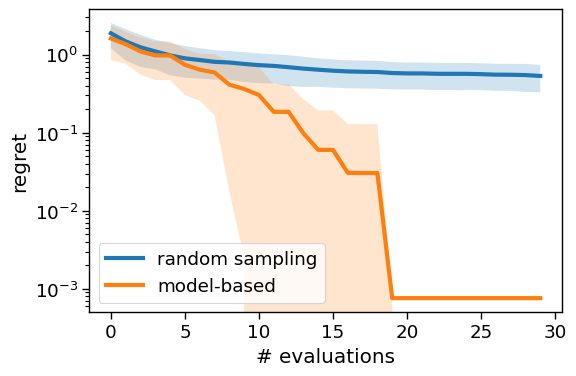

In [15]:
plt.figure(figsize=(6,4))
plt.plot(np.mean(regret_rand,axis=0), lw=3,label='random sampling')
plt.fill_between(
  np.arange(30),
  np.mean(regret_rand,axis=0)-np.std(regret_rand,axis=0),
  np.mean(regret_rand,axis=0)+np.std(regret_rand,axis=0),
  alpha=0.2
)
plt.plot(np.mean(regret_bo,axis=0), lw=3, label='model-based')
plt.fill_between(
  np.arange(30),
  np.mean(regret_bo,axis=0)-np.std(regret_bo,axis=0),
  np.mean(regret_bo,axis=0)+np.std(regret_bo,axis=0),
  alpha=0.2
)
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('# evaluations')
plt.legend()
plt.tight_layout()
# plt.savefig('synthetic_general_conditions_gradient.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()

for r in regret_rand:
    ax.plot(r, lw=1, c='b', alpha=0.2)

for r in regret_bo:
    ax.plot(r, lw=2, c='g')

ax.set_yscale('log')
ax.set_ylabel('regret')
ax.set_xlabel('# evaluations')

plt.show()

## Multiobjective problem

In [ ]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        descriptors=[None for i in range(3)],        # add descriptors later
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)


In [ ]:
BUDGET = 25
NUM_RUNS = 15


#----------
# BayesOpt
#----------

wref = np.array([10000., 10000.])

all_campaigns = []
all_true_measurements = []
all_hvols = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    value_space = ParameterSpace()
    value_space.add(ParameterContinuous(name='obj1'))
    value_space.add(ParameterContinuous(name='obj2'))

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        acquisition_optimizer_kind='gradient',
        general_parmeters=[0],
        is_moo=True,
        scalarizer_kind='Hypervolume', 
        value_space=value_space,
        goals=['min', 'min'],   
    )
    planner.set_param_space(param_space)

    true_measurements = []
    hvols = []

    for iter_ in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = moo_surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    moo_surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements.append(np.mean(all_measurements, axis=0))
            
            hvol = get_hypervolume(np.array(true_measurements), wref)
            hvols.append(hvol)
            


        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements.append(true_measurements)
    all_hvols.append(hvols)
        
    all_campaigns.append(campaign)

In [ ]:

#--------------
# RandomSearch
#--------------

all_campaigns_rand = []
all_true_measurements_rand = []
all_hvols_rand = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    value_space = ParameterSpace()
    value_space.add(ParameterContinuous(name='obj1'))
    value_space.add(ParameterContinuous(name='obj2'))

    planner = Planner(kind='RandomSearch',goal='minimize',)
    planner.set_param_space(param_space)

    true_measurements_rand = []
    hvols_rand = []

    for iter_ in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = moo_surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    moo_surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_rand.append(np.mean(all_measurements, axis=0))
            
            hvol = get_hypervolume(np.array(true_measurements_rand), wref)
            hvols_rand.append(hvol)
            


        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements_rand.append(true_measurements_rand)
    all_hvols_rand.append(hvols_rand)
        
    all_campaigns_rand.append(campaign)

In [ ]:
# normalize the hypervolumes
all_hvols = np.array(all_hvols)
all_hvols_rand = np.array(all_hvols_rand)
print(all_hvols.shape, all_hvols_rand.shape)

min_ = np.amin(np.concatenate((all_hvols,all_hvols_rand)))
max_ = np.amax(np.concatenate((all_hvols,all_hvols_rand)))

all_hvols = (np.array(all_hvols) - min_) / (max_-min_)
all_hvols_rand = (np.array(all_hvols_rand) - min_) / (max_-min_)

plt.figure(figsize=(6,4))
plt.plot(np.mean(all_hvols,axis=0), lw=3,label='bo')
plt.fill_between(
  np.arange(25),
  np.mean(all_hvols,axis=0)-np.std(all_hvols,axis=0),
  np.mean(all_hvols,axis=0)+np.std(all_hvols,axis=0),
  alpha=0.2
)
plt.plot(np.mean(all_hvols_rand,axis=0), lw=3,label='random')
plt.fill_between(
  np.arange(25),
  np.mean(all_hvols_rand,axis=0)-np.std(all_hvols_rand,axis=0),
  np.mean(all_hvols_rand,axis=0)+np.std(all_hvols_rand,axis=0),
  alpha=0.2
)
plt.legend()

plt.xlabel('# evaluations')
plt.ylabel('normalized hypervolume')

plt.savefig('moo_general_params.png', dpi=300)

In [ ]:
np.array(all_hvols).shape